In [24]:
import PIL.Image as Image
import imageio
import pylab as py
%matplotlib inline
import numpy as np
import csv
import warnings
from numpy.linalg import eig, inv

In [25]:
csv_file = '20180921_JP_470_30.csv'
#threshold = 40
input_frame = '20180921_JP_470_30/frame{:d}.jpg'
output_frame = '20180921_JP_470_30_circles/frame{:d}.jpg'
test_frame = '20180921_JP_470_30/frame1.jpg'
first_frame = '20180921_JP_470_30/frame1.jpg'
n_frame = 3911
estimate_center = np.array([600,600])
estimate_radius = 300

In [26]:
def createLineIterator(P1, P2, img):
    """
    Produces and array that consists of the coordinates and intensities of each pixel in a line between two points

    Parameters:
        -P1: a numpy array that consists of the coordinate of the first point (x,y)
        -P2: a numpy array that consists of the coordinate of the second point (x,y)
        -img: the image being processed

    Returns:
        -it: a numpy array that consists of the coordinates and intensities of each pixel in the radii (shape: [numPixels, 3], row = [x,y,intensity])   
        
    Source code: https://stackoverflow.com/questions/32328179/opencv-3-0-python-lineiterator
    """
    #define local variables for readability
    imageH = img.shape[0]
    imageW = img.shape[1]
    P1X = P1[0]
    P1Y = P1[1]
    P2X = P2[0]
    P2Y = P2[1]

    #difference and absolute difference between points
    #used to calculate slope and relative location between points
    dX = P2X - P1X
    dY = P2Y - P1Y
    dXa = np.abs(dX)
    dYa = np.abs(dY)

    #predefine numpy array for output based on distance between points
    itbuffer = np.empty(shape=(np.maximum(dYa,dXa),3),dtype=np.float32)
    itbuffer.fill(np.nan)

    #Obtain coordinates along the line using a form of Bresenham's algorithm
    negY = P1Y > P2Y
    negX = P1X > P2X
    if P1X == P2X: #vertical line segment
        itbuffer[:,0] = P1X
        if negY:
            itbuffer[:,1] = np.arange(P1Y - 1,P1Y - dYa - 1,-1)
        else:
            itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)              
    elif P1Y == P2Y: #horizontal line segment
        itbuffer[:,1] = P1Y
        if negX:
            itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
        else:
            itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
    else: #diagonal line segment
        steepSlope = dYa > dXa
        if steepSlope:
            slope = dX.astype(np.float32)/dY.astype(np.float32)
            if negY:
                itbuffer[:,1] = np.arange(P1Y-1,P1Y-dYa-1,-1)
            else:
                itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)
            itbuffer[:,0] = (slope*(itbuffer[:,1]-P1Y)).astype(np.int) + P1X
        else:
            slope = dY.astype(np.float32)/dX.astype(np.float32)
            if negX:
                itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
            else:
                itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
            itbuffer[:,1] = (slope*(itbuffer[:,0]-P1X)).astype(np.int) + P1Y

    #Remove points outside of image
    colX = itbuffer[:,0]
    colY = itbuffer[:,1]
    itbuffer = itbuffer[(colX >= 0) & (colY >=0) & (colX<imageW) & (colY<imageH)]

    #Get intensities from img ndarray
    itbuffer[:,2] = img[itbuffer[:,1].astype(np.uint),itbuffer[:,0].astype(np.uint)]

    return itbuffer

In [27]:
'''Idea from: https://stackoverflow.com/questions/45922566/ellipse-fitting-for-pupil-center'''

def find_edge_points(center, radius, img, d_theta = np.pi/180 ):
#    r = 2 * radius
    r = 500
    points = []
    
    for theta in np.arange(0, 2*np.pi, d_theta):
        end_point_x = (center[0] + r*np.cos(theta)).astype(np.int)
        end_point_y = (center[1] + r*np.sin(theta)).astype(np.int)
        end_point = np.array([end_point_x,end_point_y])
        result = createLineIterator(center, end_point, img)

        '''need to twiddle more to find a better way to find the edge points'''
#        diff = []
#        sum_lum = []
#        for i in range(1,len(result)):
#            diff.append(result[i][2] - result[i-1][2])
#        for i in range(len(diff)):    
#            sum_lum.append(sum(diff[:i]))
        #print(sum_lum)
#        for i in range(2,len(sum_lum)):
#            if sum_lum[i] > 3 * sum_lum[i-1] and sum_lum[i-1] > 3 * sum_lum[i-2] and sum_lum[i-1] > 0:
#                points.append((result[i][0],result[i][1]))
#                break

        edge_detected = False
        glare_detected = False
        
        for i in range(len(result)):
            
            if result[i][2] == 255:
                edge_detected = True
                
            if edge_detected:
                for j in range(i,len(result)-i):
                    if result[j][2] == 0:
                        glare_detected = True
                        break
            if edge_detected and not glare_detected:
                points.append((result[i][0],result[i][1]))
                break
    return points

'''http://nicky.vanforeest.com/misc/fitEllipse/fitEllipse.html'''

def fitEllipse(x,y):
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    D =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    S = np.dot(D.T,D)
    C = np.zeros([6,6])
    C[0,2] = C[2,0] = 2; C[1,1] = -1
    E, V =  eig(np.dot(inv(S), C))
    n = np.argmax(np.abs(E))
    a = V[:,n]
    return a

def ellipse_center(a):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    num = b*b-a*c
    x0=(c*d-b*f)/num
    y0=(a*f-b*d)/num
    return np.array([x0,y0])


def ellipse_angle_of_rotation( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    return 0.5*np.arctan(2*b/(a-c))

def ellipse_angle_of_rotation2( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    if b == 0:
        if a > c:
            return 0
        else:
            return np.pi/2
    else:
        if a > c:
            return np.arctan(2*b/(a-c))/2
        else:
            return np.pi/2 + np.arctan(2*b/(a-c))/2

def ellipse_axis_length( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    up = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
    down1=(b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    down2=(b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    res1=np.sqrt(up/down1)
    res2=np.sqrt(up/down2)
    return np.array([res1, res2])

In [28]:
def image_thresholding(img,threshold):
    threshold_pupil = threshold  
#    idx1 = img[:,:] > threshold_pupil
#    idx2 = img[:,:] < threshold_pupil
    idx1 =  threshold_pupil < img[:,:] 
    idx2 = img[:,:] < threshold_pupil 
#    idx3 = img[:,:] > 1.5*threshold_pupil
    img[idx1] = 255
    img[idx2] = 0
#    img[idx3] = 0
    return img
    
def get_image_mat(filename):
    img = Image.open(filename).convert('LA')
    #img = img.resize((120, 100), Image.ANTIALIAS)
    img = np.asarray(img, 'double').transpose()  
    img = img[0,:,:] # just one layer
    return img

def get_binary_image_mat(filename,threshold):
    img = Image.open(filename).convert('LA')
    #img = img.resize((120, 100), Image.ANTIALIAS)
    img = np.asarray(img, 'double').transpose()  
    img = img[0,:,:] # just one layer
    img = image_thresholding(img,threshold)
    return img

def show_image(img):
    py.imshow(img.transpose(), cmap=py.cm.Greys_r)
    
def add_circle(img_mat,center,radius,luminance=255):
    for rad in np.arange(0,2*np.pi, 0.01):
        for width in [-0.5, 0, 0.5]: # give width to the circle for viewing
            x = int(center[0] + (radius+width) * np.cos(rad))
            y = int(center[1] + (radius+width) * np.sin(rad))
            img_mat.transpose()[x,y] = luminance
    return


def add_ellipse(img_mat,center,a,b,phi,luminance=255):
    c = np.sqrt(a*a-b*b)
    e = c/a
    for rad in np.arange(0,2*np.pi, 0.01):
        for width in [-1, -0.5, 0, 0.5, 1]: # give width to the circle for viewing
            #r = a*(1-e*e)/(1+e*np.cos(rad))
            #x = int(center[0] + c + r * np.cos(rad))
            #y = int(center[1] + r * np.sin(rad))
            x = int(center[0] + (a+width)*np.cos(rad)*np.cos(phi) - (b+width)*np.sin(rad)*np.sin(phi))
            y = int(center[1] + (a+width)*np.cos(rad)*np.sin(phi) + (b+width)*np.sin(rad)*np.cos(phi))
            img_mat.transpose()[x,y] = luminance
    return

def save_image(img, center, radius, a, b, phi, file_name, lum = 255):
    show_circle_img = img.copy()
    add_circle(show_circle_img,center,radius,lum)
    #add_ellipse(show_circle_img,center,a,b,phi,lum)
    imageio.imwrite(file_name, show_circle_img.transpose())
    return

def export_to_csv(radius_data):
    with open (csv_file, 'w') as csvfile:
        writer = csv.writer(csvfile, lineterminator = '\n', delimiter=' ')
        for num in radius_data:
            writer.writerow([num])
    return

def isNaN(num):
    return num != num


[[ 39.  39.  40. ...,  43.  44.  44.]
 [ 40.  40.  40. ...,  45.  45.  46.]
 [ 44.  44.  44. ...,  50.  50.  50.]
 ..., 
 [ 20.  20.  20. ...,  47.  47.  47.]
 [ 20.  20.  20. ...,  47.  47.  47.]
 [ 20.  20.  20. ...,  47.  47.  47.]]
28.7198631287


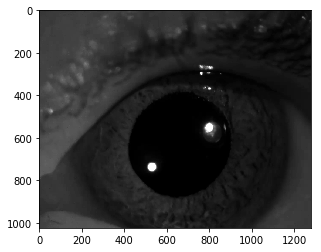

In [29]:

#testing on one image
test_frame = '20180921_JP_470_8/frame625.jpg'
img = get_image_mat(test_frame)
show_image(img)
print(img)
print(img.mean(axis=0).mean())


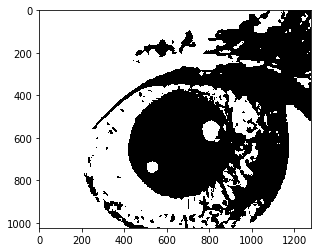

In [30]:
threshold = img.mean(axis=0).mean()*0.7
img = get_binary_image_mat(test_frame,threshold)
show_image(img)

In [31]:
test_estimate_center = np.array([600,800])
test_estimate_radius = 230

test_estimate_a = test_estimate_radius
test_estimate_b = test_estimate_radius

points = find_edge_points(test_estimate_center,test_estimate_radius,img)
a_points = np.array(points)
x = a_points[:, 0]
y = a_points[:, 1]
py.scatter(x,y, color="blue")



eye = fitEllipse(x,y)
center = ellipse_center(eye)

if isinstance(center[0], complex):
    center = test_estimate_center
    r = test_estimate_radius
    a = test_estimate_a
    b = test_estimate_b  
    
else:
    phi = ellipse_angle_of_rotation2(eye)
    axes = ellipse_axis_length(eye)
    a, b = axes
    area = np.pi*a*b
    r = np.sqrt(a*b)


print(center[0])
print ("center = ",  center)
print ("angle of rotation = ",  phi)
print ("axes = ", axes)
print ("area = ", area)
print ("radius = ", r)



R = np.arange(0,2*np.pi, 0.01)
xx = center[0] + a*np.cos(R)*np.cos(phi) - b*np.sin(R)*np.sin(phi)
yy = center[1] + a*np.cos(R)*np.sin(phi) + b*np.sin(R)*np.cos(phi)
py.plot(xx,yy, color = 'red')


IndexError: too many indices for array

In [ ]:
show_circle_img = get_image_mat(test_frame)
add_circle(show_circle_img,center,r,255)
#add_ellipse(show_circle_img,center,a,b,255)
show_image(show_circle_img)

In [32]:
radius_data = []


estimate_center = np.array([600,650])


estimate_radius = 230

estimate_a = test_estimate_radius
estimate_b = test_estimate_radius


for i in range(1,n_frame+1):

    if i< 200:
        estimate_center = np.array([630,600])
    elif i<500:
        estimate_center = np.array([630,650])
    elif i <600:
        estimate_center = np.array([600,730])
    elif i < 2150:
        estimate_center = np.array([600,700])
    elif i < 2420:
        estimate_center = np.array([610,680])
    elif i < 2515:
        estimate_center = np.array([590,630])
    elif i < 2600:
        estimate_center = np.array([520,620])
    elif i >2601:
        estimate_center = np.array([520,700])


    original_img = get_image_mat(input_frame.format(i))
    threshold = original_img.mean(axis=0).mean()
    
    print("FRAME", i)
    print("Prev thres:", threshold)



        
   
    if threshold < 50:
        threshold *= 0.52
        print("else *0.5")
    else:
        threshold *= 0.64
        print("*0.64")
            
    

            
    
    print("New thres:", threshold)
    
#    print(threshold)
    
    img = get_binary_image_mat(input_frame.format(i),threshold)
    
    points = find_edge_points(estimate_center,estimate_radius,img)

    if (len(points)>1):
        print(len(points))
        a_points = np.array(points)
        x = a_points[:, 0]
        y = a_points[:, 1]
        eye = fitEllipse(x,y)
        center = ellipse_center(eye)
        if isinstance(center[0], complex):
            center = estimate_center
            r = estimate_radius
            a = estimate_a
            b = estimate_b        
        else:
            phi = ellipse_angle_of_rotation2(eye)
            axes = ellipse_axis_length(eye)
            a, b = axes
            area = np.pi*a*b
            r = np.sqrt(a*b)
        

    #x-------------------------------------------------------------
    # In the case of blinking, bad detection, or complex
    use_previous_frame = [369,370,371,372,373,374,
                          713,714,715,716,717,718,
                          771,772,773,774,775,
                          1759,1760,1761,1762,1763,1764,1765,1766]


    if (i in use_previous_frame) or (len(points)==0) or isNaN(r) or isNaN(center[0]):
        if i in use_previous_frame:
            print(i,"In use_previous_Frame")
        if len(points)==0:
            print(i,"Points empty")
        if isNaN(r):
            print(i,"isNaN(r) True")
        if isNaN(center[0]):
            print(i,"IsNaN(center[0]) True")
            

            
        r = prev_radius
        center = prev_center
        a = prev_a
        b = prev_b
        threshold = prev_threshold


    else:
        print(i, "Else statement")
        prev_radius = r
        prev_center = center
        prev_a = a
        prev_b = b
        prev_threshold = threshold
    

    radius_data.append(r)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        save_image(original_img,center,r,a,b,phi,output_frame.format(i)) 
        
export_to_csv(radius_data)

FRAME 1
Prev thres: 25.4451126099
else *0.5
New thres: 13.2314585571


300
1 Else statement
FRAME 2
Prev thres: 25.5061592102
else *0.5
New thres: 13.2632027893


298
2 Else statement
FRAME 3
Prev thres: 25.5247497559
else *0.5
New thres: 13.272869873


298
3 Else statement
FRAME 4
Prev thres: 25.4551307678
else *0.5
New thres: 13.2366679993


297
4 Else statement
FRAME 5
Prev thres: 25.3961212158
else *0.5
New thres: 13.2059830322


297
5 Else statement
FRAME 6
Prev thres: 25.5365692139
else *0.5
New thres: 13.2790159912


297
6 Else statement
FRAME 7
Prev thres: 25.6696655273
else *0.5
New thres: 13.3482260742


295
7 Else statement
FRAME 8
Prev thres: 25.7464004517
else *0.5
New thres: 13.3881282349


296
8 Else statement
FRAME 9
Prev thres: 25.7244468689
else *0.5
New thres: 13.3767123718


293
9 Else statement
FRAME 10
Prev thres: 25.6689094543
else *0.5
New thres: 13.3478329163


297
10 Else statement
FRAME 11
Prev thres: 25.7716468811
else *0.5
New thres: 13.4012563782


294
11 Else statement
FRAME 12
Prev thres: 25.6812683105
else *0.5
New thres: 13.3542595215


295
12 Else statement
FRAME 13
Prev thres: 25.6440841675
else *0.5
New thres: 13.3349237671


294
13 Else statement
FRAME 14
Prev thres: 25.5920333862
else *0.5
New thres: 13.3078573608


293
14 Else statement
FRAME 15
Prev thres: 25.5023727417
else *0.5
New thres: 13.2612338257


296
15 Else statement
FRAME 16
Prev thres: 25.6079040527
else *0.5
New thres: 13.3161101074


296
16 Else statement
FRAME 17
Prev thres: 25.5590698242
else *0.5
New thres: 13.2907163086


295
17 Else statement
FRAME 18
Prev thres: 25.5910919189
else *0.5
New thres: 13.3073677979


295
18 Else statement
FRAME 19
Prev thres: 25.4728919983
else *0.5
New thres: 13.2459038391


296
19 Else statement
FRAME 20
Prev thres: 25.1620269775
else *0.5
New thres: 13.0842540283


300
20 Else statement
FRAME 21
Prev thres: 25.2142791748
else *0.5
New thres: 13.1114251709


296
21 Else statement
FRAME

 22
Prev thres: 25.1798065186
else *0.5
New thres: 13.0934993896
296
22 Else statement
FRAME 23
Prev thres: 25.2280456543
else *0.5
New thres: 13.1185837402


296
23 Else statement
FRAME 24
Prev thres: 25.1962242126
else *0.5
New thres: 13.1020365906


297
24 Else statement
FRAME 25
Prev thres: 25.1978805542
else *0.5
New thres: 13.1028978882


298
25 Else statement
FRAME 26
Prev thres: 25.3119949341
else *0.5
New thres: 13.1622373657


295
26 Else statement
FRAME 27
Prev thres: 25.2467453003
else *0.5
New thres: 13.1283075562


295
27 Else statement
FRAME 28
Prev thres: 25.3531204224
else *0.5
New thres: 13.1836226196


295
28 Else statement
FRAME 29
Prev thres: 25.2113540649
else *0.5
New thres: 13.1099041138


295
29 Else statement
FRAME 30
Prev thres: 25.0885009766
else *0.5
New thres: 13.0460205078


298
30 Else statement
FRAME 31
Prev thres: 25.3510368347
else *0.5
New thres: 13.1825391541


297
31 Else statement
FRAME 32
Prev thres: 25.3318466187
else *0.5
New thres: 13.1725602417


298
32 Else statement
FRAME 33
Prev thres: 25.3662437439
else *0.5
New thres: 13.1904467468


297
33 Else statement
FRAME 34
Prev thres: 25.3888870239
else *0.5
New thres: 13.2022212524


295
34 Else statement
FRAME 35
Prev thres: 25.3935409546
else *0.5
New thres: 13.2046412964


297
35 Else statement
FRAME 36
Prev thres: 25.5357795715
else *0.5
New thres: 13.2786053772


296
36 Else statement
FRAME 37
Prev thres:

 25.5716072083
else *0.5
New thres: 13.2972357483
297
37 Else statement
FRAME 38
Prev thres: 25.4724143982
else *0.5
New thres: 13.2456554871


299
38 Else statement
FRAME 39
Prev thres: 25.567350769
else *0.5
New thres: 13.2950223999


297
39 Else statement
FRAME 40
Prev thres: 25.5329978943
else *0.5
New thres: 13.277158905


299
40 Else statement
FRAME 41
Prev thres: 25.4822921753
else *0.5
New thres: 13.2507919312


299
41 Else statement
FRAME 42
Prev thres: 25.511100769
else *0.5
New thres: 13.2657723999


298
42 Else statement
FRAME 43
Prev thres: 25.5626235962
else *0.5
New thres: 13.29256427


298
43 Else statement
FRAME 44
Prev thres: 25.5219284058
else *0.5
New thres: 13.271402771


298
44 Else statement
FRAME 45
Prev thres: 25.5819068909
else *0.5
New thres: 13.3025915833


298
45 Else statement
FRAME 46
Prev thres: 25.6811386108
else *0.5
New thres: 13.3541920776


298
46 Else statement
FRAME 47
Prev thres: 25.5957458496
else *0.5
New thres: 13.3097878418


299
47 Else statement
FRAME

 48
Prev thres: 25.6756057739
else *0.5
New thres: 13.3513150024
297
48 Else statement
FRAME 49
Prev thres: 25.6124328613
else *0.5
New thres: 13.3184650879


297
49 Else statement
FRAME 50
Prev thres: 25.3711875916
else *0.5
New thres: 13.1930175476


297
50 Else statement
FRAME 51
Prev thres: 25.6934814453
else *0.5
New thres: 13.3606103516


297
51 Else statement
FRAME 52
Prev thres: 25.6364173889
else *0.5
New thres: 13.3309370422


295
52 Else statement
FRAME 53
Prev thres: 25.5964431763
else *0.5
New thres: 13.3101504517


295
53 Else statement
FRAME 54
Prev thres: 25.6096832275
else *0.5
New thres: 13.3170352783


295
54 Else statement
FRAME

 55
Prev thres: 25.2866592407
else *0.5
New thres: 13.1490628052
298
55 Else statement
FRAME 56
Prev thres: 25.378881073
else *0.5
New thres: 13.197018158


297
56 Else statement
FRAME 57
Prev thres: 25.8208068848
else *0.5
New thres: 13.4268195801


287
57 Else statement
FRAME 58
Prev thres: 25.7447410583
else *0.5
New thres: 13.3872653503


291
58 Else statement
FRAME 59
Prev thres: 25.5855499268
else *0.5
New thres: 13.3044859619


293
59 Else statement
FRAME 60
Prev thres: 25.6517860413
else *0.5
New thres: 13.3389287415


294
60 Else statement
FRAME 61
Prev thres: 25.6646385193
else *0.5
New thres: 13.34561203


294
61 Else statement
FRAME 62
Prev thres: 25.6411071777
else *0.5
New thres: 13.3333757324


293
62 Else statement
FRAME 63
Prev thres: 25.7020645142
else *0.5
New thres: 13.3650735474


293
63 Else statement
FRAME 64
Prev thres: 25.6948226929
else *0.5
New thres: 13.3613078003


293
64 Else statement
FRAME 65
Prev thres: 25.7681907654
else *0.5
New thres: 13.399459198


294
65 Else statement
FRAME 66
Prev thres: 25.8236862183
else *0.5
New thres: 13.4283168335


293
66 Else statement
FRAME 67
Prev thres: 25.6754333496
else *0.5
New thres: 13.3512253418


292
67 Else statement
FRAME 68
Prev thres: 25.6686096191
else *0.5
New thres: 13.347677002


293
68 Else statement
FRAME 69
Prev thres: 25.6464805603
else *0.5
New thres: 13.3361698914


292
69 Else statement
FRAME 70
Prev thres: 25.5826728821
else *0.5
New thres: 13.3029898987


293
70 Else statement
FRAME 71
Prev thres: 25.4936897278
else *0.5
New thres: 13.2567186584


293
71 Else statement
FRAME 72
Prev thres: 25.5484107971
else *0.5
New thres: 13.2851736145


293
72 Else statement
FRAME 73
Prev thres: 25.6165222168
else *0.5
New thres: 13.3205915527


294
73 Else statement
FRAME 74
Prev thres: 25.4442848206
else *0.5
New thres: 13.2310281067


294
74 Else statement
FRAME 75
Prev thres: 25.6195884705
else *0.5
New thres: 13.3221860046


295
75 Else statement
FRAME 76
Prev thres: 25.5683326721
else *0.5
New thres: 13.2955329895


297
76 Else statement
FRAME 77
Prev thres: 25.5296981812
else *0.5
New thres: 13.2754430542


295
77 Else statement
FRAME 78
Prev thres: 25.6153121948
else *0.5
New thres: 13.3199623413


295
78 Else statement
FRAME 79
Prev thres: 25.526020813
else *0.5
New thres: 13.2735308228


293
79 Else statement
FRAME 80
Prev thres: 25.4187271118
else *0.5
New thres: 13.2177380981


297
80 Else statement
FRAME 81
Prev thres: 25.6030273438
else *0.5
New thres: 13.3135742188


297
81 Else statement
FRAME 82
Prev thres: 25.705821991
else *0.5
New thres: 13.3670274353


296
82 Else statement
FRAME 83
Prev thres: 25.6232620239
else *0.5
New thres: 13.3240962524


297
83 Else statement
FRAME 84
Prev thres: 25.6456985474
else *0.5
New thres: 13.3357632446


297
84 Else statement
FRAME 85
Prev thres: 25.8167991638
else *0.5
New thres: 13.4247355652


297
85 Else statement
FRAME 86
Prev thres: 25.962677002
else *0.5
New thres: 13.500592041


293
86 Else statement
FRAME 87
Prev thres: 25.8908439636
else *0.5
New thres: 13.4632388611


295
87 Else statement
FRAME 88
Prev thres: 25.9365264893
else *0.5
New thres: 13.4869937744


295
88 Else statement
FRAME 89
Prev thres: 25.8359962463
else *0.5
New thres: 13.4347180481


294
89 Else statement
FRAME 90
Prev thres: 25.5344833374
else *0.5
New thres: 13.2779313354


297
90 Else statement
FRAME 91
Prev thres: 25.7133537292
else *0.5
New thres: 13.3709439392


297
91 Else statement
FRAME 92
Prev thres: 26.0015899658
else *0.5
New thres: 13.5208267822


283
92 Else statement
FRAME 93
Prev thres: 25.776399231
else *0.5
New thres: 13.4037276001


291
93 Else statement
FRAME 94
Prev thres: 25.715537262
else *0.5
New thres: 13.3720793762


294
94 Else statement
FRAME 95
Prev thres: 25.9316764832
else *0.5
New thres: 13.4844717712


296
95 Else statement
FRAME 96
Prev thres: 25.7969863892
else *0.5
New thres: 13.4144329224


296
96 Else statement
FRAME 97
Prev thres: 25.7819091797
else *0.5
New thres: 13.4065927734


296
97 Else statement
FRAME 98
Prev thres: 25.7093147278
else *0.5
New thres: 13.3688436584


295
98 Else statement
FRAME 99
Prev thres: 25.6629226685
else *0.5
New thres: 13.3447197876


295
99 Else statement
FRAME 100
Prev thres: 25.8403419495
else *0.5
New thres: 13.4369778137


296
100 Else statement
FRAME 101
Prev thres: 25.918144989
else *0.5
New thres: 13.4774353943


296
101 Else statement
FRAME 102
Prev thres: 25.8802909851
else *0.5
New thres: 13.4577513123


294
102 Else statement
FRAME 103
Prev thres: 25.6807914734
else *0.5
New thres: 13.3540115662


295
103 Else statement
FRAME 104
Prev thres: 25.766178894
else *0.5
New thres: 13.3984130249


296
104 Else statement
FRAME 105
Prev thres: 25.4683547974
else *0.5
New thres: 13.2435444946


297
105 Else statement
FRAME 106
Prev thres: 25.701852417
else *0.5
New thres: 13.3649632568


293
106 Else statement
FRAME 107
Prev thres: 25.6894340515
else *0.5
New thres: 13.3585057068


294
107 Else statement
FRAME 108
Prev thres: 25.6136665344
else *0.5
New thres: 13.3191065979


296
108 Else statement
FRAME 109
Prev thres: 25.55337677
else *0.5
New thres: 13.2877559204


294
109 Else statement
FRAME 110
Prev thres: 25.6234077454
else *0.5
New thres: 13.3241720276


295
110 Else statement
FRAME 111
Prev thres: 25.5097557068
else *0.5
New thres: 13.2650729675


294
111 Else statement
FRAME 112
Prev thres: 25.4979408264
else *0.5
New thres: 13.2589292297


295
112 Else statement
FRAME 113
Prev thres: 25.5374183655
else *0.5
New thres: 13.27945755


294
113 Else statement
FRAME 114
Prev thres: 25.4346176147
else *0.5
New thres: 13.2260011597


295
114 Else statement
FRAME 115
Prev thres: 25.3623954773
else *0.5
New thres: 13.1884456482


297
115 Else statement
FRAME 116
Prev thres: 25.3698745728
else *0.5
New thres: 13.1923347778


296
116 Else statement
FRAME 117
Prev thres: 25.3581672668
else *0.5
New thres: 13.1862469788


297
117 Else statement
FRAME 118
Prev thres: 25.3823242188
else *0.5
New thres: 13.1988085937


294
118 Else statement
FRAME 119
Prev thres: 25.30313797
else *0.5
New thres: 13.1576317444


295
119 Else statement
FRAME 120
Prev thres: 25.2235328674
else *0.5
New thres: 13.1162370911


297
120 Else statement
FRAME 121
Prev thres: 25.4112358093
else *0.5
New thres: 13.2138426208


294
121 Else statement
FRAME 122
Prev thres: 25.3563308716
else *0.5
New thres: 13.1852920532


297
122 Else statement
FRAME 123
Prev thres: 25.3494285583
else *0.5
New thres: 13.1817028503


297
123 Else statement
FRAME 124
Prev thres: 25.3832435608
else *0.5
New thres: 13.1992866516


296
124 Else statement
FRAME 125
Prev thres: 25.4212738037
else *0.5
New thres: 13.2190623779


296
125 Else statement
FRAME 126
Prev thres: 25.6109283447
else *0.5
New thres: 13.3176827393


295
126 Else statement
FRAME 127
Prev thres: 25.5511741638
else *0.5
New thres: 13.2866105652


295
127 Else statement
FRAME 128
Prev thres: 25.5138015747
else *0.5
New thres: 13.2671768188


297
128 Else statement
FRAME 129
Prev thres: 25.5713577271
else *0.5
New thres: 13.2971060181


297
129 Else statement
FRAME 130
Prev thres: 25.6074432373
else *0.5
New thres: 13.3158704834


296
130 Else statement
FRAME 131
Prev thres: 25.691583252
else *0.5
New thres: 13.359623291


297
131 Else statement
FRAME 132
Prev thres: 25.655316925
else *0.5
New thres: 13.340764801


296
132 Else statement
FRAME 133
Prev thres: 25.7227630615
else *0.5
New thres: 13.375836792


296
133 Else statement
FRAME 134
Prev thres: 25.6159393311
else *0.5
New thres: 13.3202884521


295
134 Else statement
FRAME 135
Prev thres: 25.20364151
else *0.5
New thres: 13.1058935852


298
135 Else statement
FRAME 136
Prev thres: 25.543687439
else *0.5
New thres: 13.2827174683


296
136 Else statement
FRAME 137
Prev thres: 25.4275123596
else *0.5
New thres: 13.222306427


297
137 Else statement
FRAME 138
Prev thres: 25.4427246094
else *0.5
New thres: 13.2302167969


296
138 Else statement
FRAME 139
Prev thres: 25.3385620117
else *0.5
New thres: 13.1760522461


296
139 Else statement
FRAME 140
Prev thres: 24.9653518677
else *0.5
New thres: 12.9819829712


298
140 Else statement
FRAME 141
Prev thres: 25.2351928711
else *0.5
New thres: 13.122300293


298
141 Else statement
FRAME 142
Prev thres: 25.222543335
else *0.5
New thres: 13.1157225342


295
142 Else statement
FRAME 143
Prev thres: 25.2587249756
else *0.5
New thres: 13.1345369873


296
143 Else statement
FRAME 144
Prev thres: 25.4575309753
else *0.5
New thres: 13.2379161072


294
144 Else statement
FRAME 145
Prev thres: 25.6547698975
else *0.5
New thres: 13.3404803467


298
145 Else statement
FRAME 146
Prev thres: 25.7335868835
else *0.5
New thres: 13.3814651794


295
146 Else statement
FRAME 147
Prev thres: 25.565247345
else *0.5
New thres: 13.2939286194


296
147 Else statement
FRAME 148
Prev thres: 25.6118469238
else *0.5
New thres: 13.3181604004


298
148 Else statement
FRAME 149
Prev thres: 25.5348960876
else *0.5
New thres: 13.2781459656


296
149 Else statement
FRAME 150
Prev thres: 25.3075218201
else *0.5
New thres: 13.1599113464


299
150 Else statement
FRAME 151
Prev thres: 25.655116272
else *0.5
New thres: 13.3406604614


298
151 Else statement
FRAME 152
Prev thres: 25.5529685974
else *0.5
New thres: 13.2875436707


298
152 Else statement
FRAME 153
Prev thres: 25.5795768738
else *0.5
New thres: 13.3013799744


298
153 Else statement
FRAME 154
Prev thres: 25.4488479614
else *0.5
New thres: 13.2334009399


297
154 Else statement
FRAME 155
Prev thres: 25.1622207642
else *0.5
New thres: 13.0843547974


299
155 Else statement
FRAME 156
Prev thres: 25.4384819031
else *0.5
New thres: 13.2280105896


296
156 Else statement
FRAME 157
Prev thres: 25.2432998657
else *0.5
New thres: 13.1265159302


297
157 Else statement
FRAME 158
Prev thres: 25.3689788818
else *0.5
New thres: 13.1918690186


299
158 Else statement
FRAME 159
Prev thres: 25.2616874695
else *0.5
New thres: 13.1360774841


298
159 Else statement
FRAME 160
Prev thres: 25.1294799805
else *0.5
New thres: 13.0673295898


300
160 Else statement
FRAME 161
Prev thres: 25.3373313904
else *0.5
New thres: 13.175412323


296
161 Else statement
FRAME 162
Prev thres: 25.2900947571
else *0.5
New thres: 13.1508492737


299
162 Else statement
FRAME 163
Prev thres: 25.3603996277
else *0.5
New thres: 13.1874078064


299
163 Else statement
FRAME 164
Prev thres: 25.2950370789
else *0.5
New thres: 13.153419281


298
164 Else statement
FRAME 165
Prev thres: 25.3538856506
else *0.5
New thres: 13.1840205383


298
165 Else statement
FRAME 166
Prev thres: 25.2945289612
else *0.5
New thres: 13.1531550598


299
166 Else statement
FRAME 167
Prev thres: 25.245401001
else *0.5
New thres: 13.1276085205


298
167 Else statement
FRAME 168
Prev thres: 25.340133667
else *0.5
New thres: 13.1768695068


298
168 Else statement
FRAME 169
Prev thres: 25.5758605957
else *0.5
New thres: 13.2994475098


287
169 Else statement
FRAME 170
Prev thres: 25.2694877625
else *0.5
New thres: 13.1401336365


294
170 Else statement
FRAME 171
Prev thres: 25.4293136597
else *0.5
New thres: 13.223243103


297
171 Else statement
FRAME 172
Prev thres: 25.3935890198
else *0.5
New thres: 13.2046662903


296
172 Else statement
FRAME 173
Prev thres: 25.485295105
else *0.5
New thres: 13.2523534546


295
173 Else statement
FRAME 174
Prev thres: 25.3830276489
else *0.5
New thres: 13.1991743774


297
174 Else statement
FRAME 175
Prev thres: 25.5063720703
else *0.5
New thres: 13.2633134766


297
175 Else statement
FRAME 176
Prev thres: 25.5634941101
else *0.5
New thres: 13.2930169373


297
176 Else statement
FRAME 177
Prev thres: 25.5035072327
else *0.5
New thres: 13.261823761


296
177 Else statement
FRAME 178
Prev thres: 25.4940460205
else *0.5
New thres: 13.2569039307


297
178 Else statement
FRAME 179
Prev thres: 25.2998382568
else *0.5
New thres: 13.1559158936


297
179 Else statement
FRAME 180
Prev thres: 25.3110389709
else *0.5
New thres: 13.1617402649


297
180 Else statement
FRAME 181
Prev thres: 25.409513092
else *0.5
New thres: 13.2129468079


296
181 Else statement
FRAME 182
Prev thres: 25.385092926
else *0.5
New thres: 13.2002483215


295
182 Else statement
FRAME 183
Prev thres: 25.4332763672
else *0.5
New thres: 13.2253037109


296
183 Else statement
FRAME 184
Prev thres: 25.3182029724
else *0.5
New thres: 13.1654655457


297
184 Else statement
FRAME 185
Prev thres: 25.2478469849
else *0.5
New thres: 13.1288804321


296
185 Else statement
FRAME 186
Prev thres: 25.2748687744
else *0.5
New thres: 13.1429317627


298
186 Else statement
FRAME 187
Prev thres: 25.2343490601
else *0.5
New thres: 13.1218615112


297
187 Else statement
FRAME 188
Prev thres: 25.2886207581
else *0.5
New thres: 13.1500827942


296
188 Else statement
FRAME 189
Prev thres: 25.2277259827
else *0.5
New thres: 13.118417511


295
189 Else statement
FRAME 190
Prev thres: 25.3097480774
else *0.5
New thres: 13.1610690002


295
190 Else statement
FRAME 191
Prev thres: 25.3619232178
else *0.5
New thres: 13.1882000732


296
191 Else statement
FRAME 192
Prev thres: 25.3798713684
else *0.5
New thres: 13.1975331116


297
192 Else statement
FRAME 193
Prev thres: 25.5038841248
else *0.5
New thres: 13.2620197449


295
193 Else statement
FRAME 194
Prev thres: 25.5854698181
else *0.5
New thres: 13.3044443054


297
194 Else statement
FRAME 195
Prev thres: 25.4302185059
else *0.5
New thres: 13.223713623


299
195 Else statement
FRAME 196
Prev thres: 25.5029205322
else *0.5
New thres: 13.2615186768


298
196 Else statement
FRAME 197
Prev thres: 25.4530349731
else *0.5
New thres: 13.235578186


299
197 Else statement
FRAME 198
Prev thres: 25.5318153381
else *0.5
New thres: 13.2765439758


300
198 Else statement
FRAME 199
Prev thres: 25.583177948
else *0.5
New thres: 13.303252533


299
199 Else statement
FRAME 200
Prev thres: 25.8749298096
else *0.5
New thres: 13.454963501


282
200 Else statement
FRAME 201
Prev thres: 25.8111061096
else *0.5
New thres: 13.421775177


282
201 Else statement
FRAME 202
Prev thres: 25.8257164001
else *0.5
New thres: 13.4293725281


282
202 Else statement
FRAME 203
Prev thres: 25.8966407776
else *0.5
New thres: 13.4662532043


282
203 Else statement
FRAME 204
Prev thres: 25.8231231689
else *0.5
New thres: 13.4280240479


282
204 Else statement
FRAME 205
Prev thres: 25.6954551697
else *0.5
New thres: 13.3616366882


282
205 Else statement
FRAME 206
Prev thres: 25.874936676
else *0.5
New thres: 13.4549670715


280
206 Else statement
FRAME 207
Prev thres: 25.9045906067
else *0.5
New thres: 13.4703871155


279
207 Else statement
FRAME 208
Prev thres: 25.8531013489
else *0.5
New thres: 13.4436127014


280
208 Else statement
FRAME 209
Prev thres: 25.9761749268
else *0.5
New thres: 13.5076109619


280
209 Else statement
FRAME 210
Prev thres: 25.9479156494
else *0.5
New thres: 13.4929161377


284
210 Else statement
FRAME 211
Prev thres: 26.0509376526
else *0.5
New thres: 13.5464875793


285
211 Else statement
FRAME 212
Prev thres: 26.002658844
else *0.5
New thres: 13.5213825989


283
212 Else statement
FRAME 213
Prev thres: 26.0316360474
else *0.5
New thres: 13.5364507446


284
213 Else statement
FRAME 214
Prev thres: 26.0008560181
else *0.5
New thres: 13.5204451294


283
214 Else statement
FRAME 215
Prev thres: 25.7794410706
else *0.5
New thres: 13.4053093567


284
215 Else statement
FRAME 216
Prev thres: 25.872480011
else *0.5
New thres: 13.4536896057


282
216 Else statement
FRAME 217
Prev thres: 25.8282844543
else *0.5
New thres: 13.4307079163


283
217 Else statement
FRAME 218
Prev thres: 25.833631134
else *0.5
New thres: 13.4334881897


282
218 Else statement
FRAME 219
Prev thres: 25.8036178589
else *0.5
New thres: 13.4178812866


282
219 Else statement
FRAME 220
Prev thres: 25.454271698
else *0.5
New thres: 13.236221283


284
220 Else statement
FRAME 221
Prev thres: 25.727066803
else *0.5
New thres: 13.3780747375


282
221 Else statement
FRAME 222
Prev thres: 25.7153800964
else *0.5
New thres: 13.3719976501


282
222 Else statement
FRAME 223
Prev thres: 25.7678611755
else *0.5
New thres: 13.3992878113


282
223 Else statement
FRAME 224
Prev thres: 25.549105072
else *0.5
New thres: 13.2855346375


282
224 Else statement
FRAME 225
Prev thres: 25.5017929077
else *0.5
New thres: 13.260932312


286
225 Else statement
FRAME 226
Prev thres: 25.696269989
else *0.5
New thres: 13.3620603943


284
226 Else statement
FRAME 227
Prev thres: 25.6053062439
else *0.5
New thres: 13.3147592468


284
227 Else statement
FRAME 228
Prev thres: 25.7024147034
else *0.5
New thres: 13.3652556458


284
228 Else statement
FRAME 229
Prev thres: 25.6135345459
else *0.5
New thres: 13.3190379639


284
229 Else statement
FRAME 230
Prev thres: 25.3155235291
else *0.5
New thres: 13.1640722351


284
230 Else statement
FRAME 231
Prev thres: 25.4481628418
else *0.5
New thres: 13.2330446777


282
231 Else statement
FRAME 232
Prev thres: 25.4277046204
else *0.5
New thres: 13.2224064026


282
232 Else statement
FRAME 233
Prev thres: 25.52292099
else *0.5
New thres: 13.2719189148


281
233 Else statement
FRAME 234
Prev thres: 25.7023590088
else *0.5
New thres: 13.3652266846


281
234 Else statement
FRAME 235
Prev thres: 25.6665802002
else *0.5
New thres: 13.3466217041


289
235 Else statement
FRAME 236
Prev thres: 25.6772346497
else *0.5
New thres: 13.3521620178


285
236 Else statement
FRAME 237
Prev thres: 25.6556152344
else *0.5
New thres: 13.3409199219


286
237 Else statement
FRAME 238
Prev thres: 25.6834335327
else *0.5
New thres: 13.355385437


284
238 Else statement
FRAME 239
Prev thres: 25.6440658569
else *0.5
New thres: 13.3349142456


286
239 Else statement
FRAME 240
Prev thres: 25.6618995667
else *0.5
New thres: 13.3441877747


287
240 Else statement
FRAME 241
Prev thres: 25.809148407
else *0.5
New thres: 13.4207571716


285
241 Else statement
FRAME 242
Prev thres: 25.7718589783
else *0.5
New thres: 13.4013666687


284
242 Else statement
FRAME 243
Prev thres: 25.8529418945
else *0.5
New thres: 13.4435297852


283
243 Else statement
FRAME 244
Prev thres: 25.8001693726
else *0.5
New thres: 13.4160880737


284
244 Else statement
FRAME 245
Prev thres: 25.6991073608
else *0.5
New thres: 13.3635358276


287
245 Else statement
FRAME 246
Prev thres: 25.7543067932
else *0.5
New thres: 13.3922395325


287
246 Else statement
FRAME 247
Prev thres: 25.7553878784
else *0.5
New thres: 13.3928016968


287
247 Else statement
FRAME 248
Prev thres: 25.767980957
else *0.5
New thres: 13.3993500977


289
248 Else statement
FRAME 249
Prev thres: 25.7347335815
else *0.5
New thres: 13.3820614624


289
249 Else statement
FRAME 250
Prev thres: 25.4011764526
else *0.5
New thres: 13.2086117554


288
250 Else statement
FRAME 251
Prev thres: 25.7526847839
else *0.5
New thres: 13.3913960876


282
251 Else statement
FRAME 252
Prev thres: 25.7290008545
else *0.5
New thres: 13.3790804443


281
252 Else statement
FRAME 253
Prev thres: 25.4490516663
else *0.5
New thres: 13.2335068665


284
253 Else statement
FRAME 254
Prev thres: 25.5098442078
else *0.5
New thres: 13.265118988


287
254 Else statement
FRAME 255
Prev thres: 25.4647659302
else *0.5
New thres: 13.2416782837


289
255 Else statement
FRAME 256
Prev thres: 25.6000167847
else *0.5
New thres: 13.312008728


284
256 Else statement
FRAME 257
Prev thres: 25.5796936035
else *0.5
New thres: 13.3014406738


284
257 Else statement
FRAME 258
Prev thres: 25.635005188
else *0.5
New thres: 13.3302026978


282
258 Else statement
FRAME 259
Prev thres: 25.5979110718
else *0.5
New thres: 13.3109137573


281
259 Else statement
FRAME 260
Prev thres: 25.4635498047
else *0.5
New thres: 13.2410458984


282
260 Else statement
FRAME 261
Prev thres: 25.7057067871
else *0.5
New thres: 13.3669675293


281
261 Else statement
FRAME 262
Prev thres: 25.5791496277
else *0.5
New thres: 13.3011578064


281
262 Else statement
FRAME 263
Prev thres: 25.6565788269
else *0.5
New thres: 13.34142099


281
263 Else statement
FRAME 264
Prev thres: 25.5057998657
else *0.5
New thres: 13.2630159302


281
264 Else statement
FRAME 265
Prev thres: 25.3495811462
else *0.5
New thres: 13.181782196


285
265 Else statement
FRAME 266
Prev thres: 25.5469009399
else *0.5
New thres: 13.2843884888


281
266 Else statement
FRAME 267
Prev thres: 25.681816864
else *0.5
New thres: 13.3545447693


272
267 Else statement
FRAME 268
Prev thres: 25.6042404175
else *0.5
New thres: 13.3142050171


276
268 Else statement
FRAME 269
Prev thres: 25.5647186279
else *0.5
New thres: 13.2936536865


277
269 Else statement
FRAME 270
Prev thres: 25.7112579346
else *0.5
New thres: 13.369854126


279
270 Else statement
FRAME 271
Prev thres: 25.6778442383
else *0.5
New thres: 13.3524790039


279
271 Else statement
FRAME 272
Prev thres: 25.6204490662
else *0.5
New thres: 13.3226335144


278
272 Else statement
FRAME 273
Prev thres: 25.6211074829
else *0.5
New thres: 13.3229758911


279
273 Else statement
FRAME 274
Prev thres: 25.6115699768
else *0.5
New thres: 13.3180163879


279
274 Else statement
FRAME 275
Prev thres: 25.5058158875
else *0.5
New thres: 13.2630242615


281
275 Else statement
FRAME 276
Prev thres: 25.5473449707
else *0.5
New thres: 13.2846193848


281
276 Else statement
FRAME 277
Prev thres: 25.4931808472
else *0.5
New thres: 13.2564540405


280
277 Else statement
FRAME 278
Prev thres: 25.4972946167
else *0.5
New thres: 13.2585932007


280
278 Else statement
FRAME 279
Prev thres: 25.4641853333
else *0.5
New thres: 13.2413763733


288
279 Else statement
FRAME 280
Prev thres: 25.2238502502
else *0.5
New thres: 13.1164021301


288
280 Else statement
FRAME 281
Prev thres: 25.4653114319
else *0.5
New thres: 13.2419619446


285
281 Else statement
FRAME 282
Prev thres: 25.4426895142
else *0.5
New thres: 13.2301985474


282
282 Else statement
FRAME 283
Prev thres: 25.5718910217
else *0.5
New thres: 13.2973833313


280
283 Else statement
FRAME 284
Prev thres: 25.4234802246
else *0.5
New thres: 13.2202097168


280
284 Else statement
FRAME 285
Prev thres: 25.4125518799
else *0.5
New thres: 13.2145269775


286
285 Else statement
FRAME 286
Prev thres: 25.5851173401
else *0.5
New thres: 13.3042610168


285
286 Else statement
FRAME 287
Prev thres: 25.6039138794
else *0.5
New thres: 13.3140352173


281
287 Else statement
FRAME 288
Prev thres: 25.6690124512
else *0.5
New thres: 13.3478864746


281
288 Else statement
FRAME 289
Prev thres: 25.6713356018
else *0.5
New thres: 13.3490945129


282
289 Else statement
FRAME 290
Prev thres: 25.7584495544
else *0.5
New thres: 13.3943937683


287
290 Else statement
FRAME 291
Prev thres: 25.725466156
else *0.5
New thres: 13.3772424011


286
291 Else statement
FRAME 292
Prev thres: 25.6864532471
else *0.5
New thres: 13.3569556885


285
292 Else statement
FRAME 293
Prev thres: 26.0283477783
else *0.5
New thres: 13.5347408447


280
293 Else statement
FRAME 294
Prev thres: 25.923475647
else *0.5
New thres: 13.4802073364


278
294 Else statement
FRAME 295
Prev thres: 25.8325897217
else *0.5
New thres: 13.4329466553


282
295 Else statement
FRAME 296
Prev thres: 26.0728713989
else *0.5
New thres: 13.5578931274


279
296 Else statement
FRAME 297
Prev thres: 25.9783187866
else *0.5
New thres: 13.508725769


280
297 Else statement
FRAME 298
Prev thres: 25.9394226074
else *0.5
New thres: 13.4884997559


281
298 Else statement
FRAME 299
Prev thres: 25.9018226624
else *0.5
New thres: 13.4689477844


281
299 Else statement
FRAME 300
Prev thres: 25.5028831482
else *0.5
New thres: 13.2614992371


283
300 Else statement
FRAME 301
Prev thres: 25.6313407898
else *0.5
New thres: 13.3282972107


281
301 Else statement
FRAME 302
Prev thres: 25.6345565796
else *0.5
New thres: 13.3299694214


278
302 Else statement
FRAME 303
Prev thres: 25.6303276062
else *0.5
New thres: 13.3277703552


276
303 Else statement
FRAME 304
Prev thres: 25.6400749207
else *0.5
New thres: 13.3328389587


277
304 Else statement
FRAME 305
Prev thres: 25.8198379517
else *0.5
New thres: 13.4263157349


284
305 Else statement
FRAME 306
Prev thres: 25.8573501587
else *0.5
New thres: 13.4458220825


284
306 Else statement
FRAME 307
Prev thres: 25.8218101501
else *0.5
New thres: 13.4273412781


283
307 Else statement
FRAME 308
Prev thres: 25.7670951843
else *0.5
New thres: 13.3988894958


284
308 Else statement
FRAME 309
Prev thres: 25.7732452393
else *0.5
New thres: 13.4020875244


282
309 Else statement
FRAME 310
Prev thres: 25.7007453918
else *0.5
New thres: 13.3643876038


285
310 Else statement
FRAME 311
Prev thres: 25.5847854614
else *0.5
New thres: 13.3040884399


282
311 Else statement
FRAME 312
Prev thres: 25.5438018799
else *0.5
New thres: 13.2827769775


283
312 Else statement
FRAME 313
Prev thres: 25.6230453491
else *0.5
New thres: 13.3239835815


283
313 Else statement
FRAME 314
Prev thres: 25.5225112915
else *0.5
New thres: 13.2717058716


283
314 Else statement
FRAME 315
Prev thres: 25.4850097656
else *0.5
New thres: 13.2522050781


282
315 Else statement
FRAME 316
Prev thres: 25.5739181519
else *0.5
New thres: 13.298437439


282
316 Else statement
FRAME 317
Prev thres: 25.5554100037
else *0.5
New thres: 13.2888132019


281
317 Else statement
FRAME 318
Prev thres: 25.5570640564
else *0.5
New thres: 13.2896733093


282
318 Else statement
FRAME 319
Prev thres: 25.4811073303
else *0.5
New thres: 13.2501758118


280
319 Else statement
FRAME 320
Prev thres: 25.3614471436
else *0.5
New thres: 13.1879525146


286
320 Else statement
FRAME 321
Prev thres: 25.2868110657
else *0.5
New thres: 13.1491417542


286
321 Else statement
FRAME 322
Prev thres: 25.2780128479
else *0.5
New thres: 13.1445666809


285
322 Else statement
FRAME 323
Prev thres: 25.3396636963
else *0.5
New thres: 13.1766251221


288
323 Else statement
FRAME 324
Prev thres: 25.2456825256
else *0.5
New thres: 13.1277549133


288
324 Else statement
FRAME 325
Prev thres: 25.3551979065
else *0.5
New thres: 13.1847029114


286
325 Else statement
FRAME 326
Prev thres: 25.5461868286
else *0.5
New thres: 13.2840171509


281
326 Else statement
FRAME 327
Prev thres: 25.4628158569
else *0.5
New thres: 13.2406642456


282
327 Else statement
FRAME 328
Prev thres: 25.4970031738
else *0.5
New thres: 13.2584416504


282
328 Else statement
FRAME 329
Prev thres: 25.437424469
else *0.5
New thres: 13.2274607239


283
329 Else statement
FRAME 330
Prev thres: 25.321837616
else *0.5
New thres: 13.1673555603


288
330 Else statement
FRAME 331
Prev thres: 25.3431716919
else *0.5
New thres: 13.1784492798


285
331 Else statement
FRAME 332
Prev thres: 25.3345954895
else *0.5
New thres: 13.1739896545


285
332 Else statement
FRAME 333
Prev thres: 25.3507514954
else *0.5
New thres: 13.1823907776


283
333 Else statement
FRAME 334
Prev thres: 25.3362251282
else *0.5
New thres: 13.1748370667


284
334 Else statement
FRAME 335
Prev thres: 25.0467056274
else *0.5
New thres: 13.0242869263


284
335 Else statement
FRAME 336
Prev thres: 25.1045066833
else *0.5
New thres: 13.0543434753


284
336 Else statement
FRAME 337
Prev thres: 25.1446128845
else *0.5
New thres: 13.0751987


285
337 Else statement
FRAME 338
Prev thres: 25.1735687256
else *0.5
New thres: 13.0902557373


285
338 Else statement
FRAME 339
Prev thres: 25.1047424316
else *0.5
New thres: 13.0544660645


284
339 Else statement
FRAME 340
Prev thres: 25.0358551025
else *0.5
New thres: 13.0186446533


286
340 Else statement
FRAME 341
Prev thres: 25.1043022156
else *0.5
New thres: 13.0542371521


284
341 Else statement
FRAME 342
Prev thres: 25.1021835327
else *0.5
New thres: 13.053135437


283
342 Else statement
FRAME 343
Prev thres: 25.4314064026
else *0.5
New thres: 13.2243313293


281
343 Else statement
FRAME 344
Prev thres: 25.5407585144
else *0.5
New thres: 13.2811944275


282
344 Else statement
FRAME 345
Prev thres: 25.5059112549
else *0.5
New thres: 13.2630738525


292
345 Else statement
FRAME 346
Prev thres: 25.641305542
else *0.5
New thres: 13.3334788818


289
346 Else statement
FRAME 347
Prev thres: 25.6413276672
else *0.5
New thres: 13.333490387


287
347 Else statement
FRAME 348
Prev thres: 25.792691803
else *0.5
New thres: 13.4121997375


287
348 Else statement
FRAME 349
Prev thres: 25.7046920776
else *0.5
New thres: 13.3664398804


289
349 Else statement
FRAME 350
Prev thres: 25.4557136536
else *0.5
New thres: 13.2369710999


297
350 Else statement
FRAME 351
Prev thres: 25.7509605408
else *0.5
New thres: 13.3904994812


291
351 Else statement
FRAME 352
Prev thres: 25.7415710449
else *0.5
New thres: 13.3856169434


289
352 Else statement
FRAME 353
Prev thres: 25.7257003784
else *0.5
New thres: 13.3773641968


288
353 Else statement
FRAME 354
Prev thres: 25.7450721741
else *0.5
New thres: 13.3874375305


287
354 Else statement
FRAME 355
Prev thres: 25.7324577332
else *0.5
New thres: 13.3808780212


289
355 Else statement
FRAME 356
Prev thres: 25.6492324829
else *0.5
New thres: 13.3376008911


285
356 Else statement
FRAME 357
Prev thres: 25.7339149475
else *0.5
New thres: 13.3816357727


282
357 Else statement
FRAME 358
Prev thres: 25.8458343506
else *0.5
New thres: 13.4398338623


279
358 Else statement
FRAME 359
Prev thres: 25.8469841003
else *0.5
New thres: 13.4404317322


284
359 Else statement
FRAME 360
Prev thres: 25.9520179749
else *0.5
New thres: 13.4950493469


287
360 Else statement
FRAME 361
Prev thres: 26.1095443726
else *0.5
New thres: 13.5769630737


287
361 Else statement
FRAME 362
Prev thres: 26.3521957397
else *0.5
New thres: 13.7031417847


292
362 Else statement
FRAME 363
Prev thres: 26.4611457825
else *0.5
New thres: 13.7597958069


293
363 Else statement
FRAME 364
Prev thres: 26.4273239136
else *0.5
New thres: 13.7422084351


293
364 Else statement
FRAME 365
Prev thres: 26.2807983398
else *0.5
New thres: 13.6660151367


296
365 Else statement
FRAME 366
Prev thres: 26.6553848267
else *0.5
New thres: 13.8608001099


297
366 Else statement
FRAME 367
Prev thres: 26.5710617065
else *0.5
New thres: 13.8169520874


297
367 Else statement
FRAME 368
Prev thres: 26.5896072388
else *0.5
New thres: 13.8265957642


299
368 Else statement
FRAME 369
Prev thres: 31.0686737061
else *0.5
New thres: 16.1557103271


255
369 In use_previous_Frame
FRAME 370
Prev thres: 50.7381340027
*0.64
New thres: 32.4724057617


C:\Users\Julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in sqrt


192
370 In use_previous_Frame
370 isNaN(r) True
FRAME 371
Prev thres: 60.4265838623
*0.64
New thres: 38.6730136719


C:\Users\Julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in sqrt


204
371 In use_previous_Frame
371 isNaN(r) True
FRAME 372
Prev thres: 54.0089111328
*0.64
New thres: 34.565703125


C:\Users\Julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in sqrt


201
372 In use_previous_Frame
372 isNaN(r) True
FRAME 373
Prev thres: 41.8610580444
else *0.5
New thres: 21.7677501831


237
373 In use_previous_Frame
FRAME 374
Prev thres: 32.4510726929
else *0.5
New thres: 16.8745578003


196
374 In use_previous_Frame
FRAME 375
Prev thres: 28.4385604858
else *0.5
New thres: 14.7880514526


273
375 Else statement
FRAME 376
Prev thres: 26.5303497314
else *0.5
New thres: 13.7957818604


263
376 Else statement
FRAME 377
Prev thres: 26.0371284485
else *0.5
New thres: 13.5393067932


260
377 Else statement
FRAME 378
Prev thres: 25.818144989
else *0.5
New thres: 13.4254353943


256
378 Else statement
FRAME 379
Prev thres: 25.8210548401
else *0.5
New thres: 13.4269485168


256
379 Else statement
FRAME 380
Prev thres: 25.8834777832
else *0.5
New thres: 13.4594084473


275
380 Else statement
FRAME 381
Prev thres: 25.7578269958
else *0.5
New thres: 13.3940700378


276
381 Else statement
FRAME 382
Prev thres: 25.7419494629
else *0.5
New thres: 13.3858137207


278
382 Else statement
FRAME 383
Prev thres: 25.9705741882
else *0.5
New thres: 13.5046985779


278
383 Else statement
FRAME 384
Prev thres: 26.0622520447
else *0.5
New thres: 13.5523710632


284
384 Else statement
FRAME 385
Prev thres: 25.7113212585
else *0.5
New thres: 13.3698870544


291
385 Else statement
FRAME 386
Prev thres: 26.0302879333
else *0.5
New thres: 13.5357497253


291
386 Else statement
FRAME 387
Prev thres: 25.7526573181
else *0.5
New thres: 13.3913818054


286
387 Else statement
FRAME 388
Prev thres: 25.4555801392
else *0.5
New thres: 13.2369016724


285
388 Else statement
FRAME 389
Prev thres: 25.2363670349
else *0.5
New thres: 13.1229108582


281
389 Else statement
FRAME 390
Prev thres: 25.1241577148
else *0.5
New thres: 13.0645620117


294
390 Else statement
FRAME 391
Prev thres: 25.0293556213
else *0.5
New thres: 13.0152649231


294
391 Else statement
FRAME 392
Prev thres: 25.0051902771
else *0.5
New thres: 13.0026989441


297
392 Else statement
FRAME 393
Prev thres: 25.0887443542
else *0.5
New thres: 13.0461470642


295
393 Else statement
FRAME 394
Prev thres: 24.7969741821
else *0.5
New thres: 12.8944265747


285
394 Else statement
FRAME 395
Prev thres: 24.73647995
else *0.5
New thres: 12.862969574


284
395 Else statement
FRAME 396
Prev thres: 24.8322296143
else *0.5
New thres: 12.9127593994


283
396 Else statement
FRAME 397
Prev thres: 24.7836975098
else *0.5
New thres: 12.8875227051


287
397 Else statement
FRAME 398
Prev thres: 25.6627281189
else *0.5
New thres: 13.3446186218


287
398 Else statement
FRAME 399
Prev thres: 25.3609169006
else *0.5
New thres: 13.1876767883


283
399 Else statement
FRAME 400
Prev thres: 25.2378425598
else *0.5
New thres: 13.1236781311


285
400 Else statement
FRAME 401
Prev thres: 25.1528465271
else *0.5
New thres: 13.0794801941


284
401 Else statement
FRAME 402
Prev thres: 25.1595275879
else *0.5
New thres: 13.0829543457


280
402 Else statement
FRAME 403
Prev thres: 25.3262634277
else *0.5
New thres: 13.1696569824


280
403 Else statement
FRAME 404
Prev thres: 25.5431060791
else *0.5
New thres: 13.2824151611


283
404 Else statement
FRAME 405
Prev thres: 25.7036186218
else *0.5
New thres: 13.3658816833


294
405 Else statement
FRAME 406
Prev thres: 25.9517807007
else *0.5
New thres: 13.4949259644


293
406 Else statement
FRAME 407
Prev thres: 25.9932434082
else *0.5
New thres: 13.5164865723


294
407 Else statement
FRAME 408
Prev thres: 26.3214164734
else *0.5
New thres: 13.6871365662


294
408 Else statement
FRAME 409
Prev thres: 26.370349884
else *0.5
New thres: 13.7125819397


293
409 Else statement
FRAME 410
Prev thres: 26.9075790405
else *0.5
New thres: 13.9919411011


295
410 Else statement
FRAME 411
Prev thres: 27.2751037598
else *0.5
New thres: 14.1830539551


295
411 Else statement
FRAME 412
Prev thres: 27.7569923401
else *0.5
New thres: 14.4336360168


294
412 Else statement
FRAME 413
Prev thres: 27.8875724792
else *0.5
New thres: 14.5015376892


291
413 Else statement
FRAME 414
Prev thres: 27.6350395203
else *0.5
New thres: 14.3702205505


289
414 Else statement
FRAME 415
Prev thres: 27.6338111877
else *0.5
New thres: 14.3695818176


294
415 Else statement
FRAME 416
Prev thres: 27.7688941956
else *0.5
New thres: 14.4398249817


293
416 Else statement
FRAME 417
Prev thres: 27.8156570435
else *0.5
New thres: 14.4641416626


296
417 Else statement
FRAME 418
Prev thres: 27.861542511
else *0.5
New thres: 14.4880021057


295
418 Else statement
FRAME 419
Prev thres: 27.5231231689
else *0.5
New thres: 14.3120240479


293
419 Else statement
FRAME 420
Prev thres: 27.3323822021
else *0.5
New thres: 14.2128387451


295
420 Else statement
FRAME 421
Prev thres: 27.4334884644
else *0.5
New thres: 14.2654140015


294
421 Else statement
FRAME 422
Prev thres: 27.0570228577
else *0.5
New thres: 14.069651886


295
422 Else statement
FRAME 423
Prev thres: 26.904876709
else *0.5
New thres: 13.9905358887


294
423 Else statement
FRAME 424
Prev thres: 26.6294219971
else *0.5
New thres: 13.8472994385


287
424 Else statement
FRAME 425
Prev thres: 26.5956192017
else *0.5
New thres: 13.8297219849


295
425 Else statement
FRAME 426
Prev thres: 26.4727729797
else *0.5
New thres: 13.7658419495


296
426 Else statement
FRAME 427
Prev thres: 26.5884811401
else *0.5
New thres: 13.8260101929


296
427 Else statement
FRAME 428
Prev thres: 26.6261634827
else *0.5
New thres: 13.845605011


294
428 Else statement
FRAME 429
Prev thres: 26.7609191895
else *0.5
New thres: 13.9156779785


295
429 Else statement
FRAME 430
Prev thres: 26.9267875671
else *0.5
New thres: 14.0019295349


295
430 Else statement
FRAME 431
Prev thres: 26.7810417175
else *0.5
New thres: 13.9261416931


296
431 Else statement
FRAME 432
Prev thres: 26.8058685303
else *0.5
New thres: 13.9390516357


295
432 Else statement
FRAME 433
Prev thres: 26.8038795471
else *0.5
New thres: 13.9380173645


294
433 Else statement
FRAME 434
Prev thres: 26.6642799377
else *0.5
New thres: 13.8654255676


296
434 Else statement
FRAME 435
Prev thres: 26.7763114929
else *0.5
New thres: 13.9236819763


295
435 Else statement
FRAME 436
Prev thres: 26.7305809021
else *0.5
New thres: 13.8999020691


294
436 Else statement
FRAME 437
Prev thres: 26.6632881165
else *0.5
New thres: 13.8649098206


294
437 Else statement
FRAME 438
Prev thres: 26.6212524414
else *0.5
New thres: 13.8430512695


293
438 Else statement
FRAME 439
Prev thres: 26.566078949
else *0.5
New thres: 13.8143610535


293
439 Else statement
FRAME 440
Prev thres: 26.4538726807
else *0.5
New thres: 13.7560137939


297
440 Else statement
FRAME 441
Prev thres: 26.4788360596
else *0.5
New thres: 13.768994751


296
441 Else statement
FRAME 442
Prev thres: 26.4428894043
else *0.5
New thres: 13.7503024902


296
442 Else statement
FRAME 443
Prev thres: 26.4557662964
else *0.5
New thres: 13.7569984741


296
443 Else statement
FRAME 444
Prev thres: 26.3908615112
else *0.5
New thres: 13.7232479858


294
444 Else statement
FRAME 445
Prev thres: 26.5307052612
else *0.5
New thres: 13.7959667358


294
445 Else statement
FRAME 446
Prev thres: 26.5138175964
else *0.5
New thres: 13.7871851501


294
446 Else statement
FRAME 447
Prev thres: 26.9414321899
else *0.5
New thres: 14.0095447388


296
447 Else statement
FRAME 448
Prev thres: 26.8196601868
else *0.5
New thres: 13.9462232971


293
448 Else statement
FRAME 449
Prev thres: 26.6606521606
else *0.5
New thres: 13.8635391235


292
449 Else statement
FRAME 450
Prev thres: 26.4210159302
else *0.5
New thres: 13.7389282837


295
450 Else statement
FRAME 451
Prev thres: 26.4782287598
else *0.5
New thres: 13.7686789551


294
451 Else statement
FRAME 452
Prev thres: 26.6686248779
else *0.5
New thres: 13.8676849365


296
452 Else statement
FRAME 453
Prev thres: 26.9614646912
else *0.5
New thres: 14.0199616394


295
453 Else statement
FRAME 454
Prev thres: 26.9658607483
else *0.5
New thres: 14.0222475891


294
454 Else statement
FRAME 455
Prev thres: 26.81040802
else *0.5
New thres: 13.9414121704


296
455 Else statement
FRAME 456
Prev thres: 26.8604438782
else *0.5
New thres: 13.9674308167


293
456 Else statement
FRAME 457
Prev thres: 26.7148956299
else *0.5
New thres: 13.8917457275


294
457 Else statement
FRAME 458
Prev thres: 26.7524017334
else *0.5
New thres: 13.9112489014


293
458 Else statement
FRAME 459
Prev thres: 26.9079689026
else *0.5
New thres: 13.9921438293


294
459 Else statement
FRAME 460
Prev thres: 26.8107849121
else *0.5
New thres: 13.9416081543


295
460 Else statement
FRAME 461
Prev thres: 26.9052452087
else *0.5
New thres: 13.9907275085


294
461 Else statement
FRAME 462
Prev thres: 26.9342033386
else *0.5
New thres: 14.0057857361


294
462 Else statement
FRAME 463
Prev thres: 26.7352775574
else *0.5
New thres: 13.9023443298


295
463 Else statement
FRAME 464
Prev thres: 26.6794075012
else *0.5
New thres: 13.8732919006


295
464 Else statement
FRAME 465
Prev thres: 26.8640953064
else *0.5
New thres: 13.9693295593


295
465 Else statement
FRAME 466
Prev thres: 26.9073074341
else *0.5
New thres: 13.9917998657


293
466 Else statement
FRAME 467
Prev thres: 27.0169006348
else *0.5
New thres: 14.0487883301


295
467 Else statement
FRAME 468
Prev thres: 27.0642524719
else *0.5
New thres: 14.0734112854


292
468 Else statement
FRAME 469
Prev thres: 26.8314292908
else *0.5
New thres: 13.9523432312


294
469 Else statement
FRAME 470
Prev thres: 26.7908676147
else *0.5
New thres: 13.9312511597


291
470 Else statement
FRAME 471
Prev thres: 26.7405609131
else *0.5
New thres: 13.9050916748


292
471 Else statement
FRAME 472
Prev thres: 26.7447898865
else *0.5
New thres: 13.907290741


291
472 Else statement
FRAME 473
Prev thres: 26.7435974121
else *0.5
New thres: 13.9066706543


293
473 Else statement
FRAME 474
Prev thres: 26.7796615601
else *0.5
New thres: 13.9254240112


292
474 Else statement
FRAME 475
Prev thres: 26.7541488647
else *0.5
New thres: 13.9121574097


294
475 Else statement
FRAME 476
Prev thres: 26.8586265564
else *0.5
New thres: 13.9664858093


292
476 Else statement
FRAME 477
Prev thres: 26.8426948547
else *0.5
New thres: 13.9582013245


293
477 Else statement
FRAME 478
Prev thres: 26.7752586365
else *0.5
New thres: 13.923134491


292
478 Else statement
FRAME 479
Prev thres: 26.6867660522
else *0.5
New thres: 13.8771183472


292
479 Else statement
FRAME 480
Prev thres: 26.4424552917
else *0.5
New thres: 13.7500767517


295
480 Else statement
FRAME 481
Prev thres: 26.8041854858
else *0.5
New thres: 13.9381764526


294
481 Else statement
FRAME 482
Prev thres: 26.8258514404
else *0.5
New thres: 13.949442749


292
482 Else statement
FRAME 483
Prev thres: 26.8572471619
else *0.5
New thres: 13.9657685242


293
483 Else statement
FRAME 484
Prev thres: 26.8359481812
else *0.5
New thres: 13.9546930542


292
484 Else statement
FRAME 485
Prev thres: 26.7855880737
else *0.5
New thres: 13.9285057983


293
485 Else statement
FRAME 486
Prev thres: 26.9741394043
else *0.5
New thres: 14.0265524902


294
486 Else statement
FRAME 487
Prev thres: 26.9193023682
else *0.5
New thres: 13.9980372314


291
487 Else statement
FRAME 488
Prev thres: 26.9184921265
else *0.5
New thres: 13.9976159058


292
488 Else statement
FRAME 489
Prev thres: 26.8471229553
else *0.5
New thres: 13.9605039368


292
489 Else statement
FRAME 490
Prev thres: 26.8111366272
else *0.5
New thres: 13.9417910461


294
490 Else statement
FRAME 491
Prev thres: 27.198840332
else *0.5
New thres: 14.1433969727


270
491 Else statement
FRAME 492
Prev thres: 27.1163253784
else *0.5
New thres: 14.1004891968


278
492 Else statement
FRAME 493
Prev thres: 27.2355873108
else *0.5
New thres: 14.1625054016


282
493 Else statement
FRAME 494
Prev thres: 27.2518013
else *0.5
New thres: 14.170936676


283
494 Else statement
FRAME 495
Prev thres: 27.0468040466
else *0.5
New thres: 14.0643381042


284
495 Else statement
FRAME 496
Prev thres: 27.5222564697
else *0.5
New thres: 14.3115733643


282
496 Else statement
FRAME 497
Prev thres: 27.6863105774
else *0.5
New thres: 14.3968815002


283
497 Else statement
FRAME 498
Prev thres: 27.7227409363
else *0.5
New thres: 14.4158252869


283
498 Else statement
FRAME 499
Prev thres: 27.7706718445
else *0.5
New thres: 14.4407493591


284
499 Else statement
FRAME 500
Prev thres: 27.8433616638
else *0.5
New thres: 14.4785480652


288
500 Else statement
FRAME 501
Prev thres: 27.996157074
else *0.5
New thres: 14.5580016785


291
501 Else statement
FRAME 502
Prev thres: 28.1634429932
else *0.5
New thres: 14.6449903564


291
502 Else statement
FRAME 503
Prev thres: 28.2681259155
else *0.5
New thres: 14.6994254761


290
503 Else statement
FRAME 504
Prev thres: 28.2213104248
else *0.5
New thres: 14.6750814209


290
504 Else statement
FRAME 505
Prev thres: 28.270186615
else *0.5
New thres: 14.7004970398


286
505 Else statement
FRAME 506
Prev thres: 28.5676139832
else *0.5
New thres: 14.8551592712


275
506 Else statement
FRAME 507
Prev thres: 28.6349822998
else *0.5
New thres: 14.8901907959


277
507 Else statement
FRAME 508
Prev thres: 28.8639076233
else *0.5
New thres: 15.0092319641


275
508 Else statement
FRAME 509
Prev thres: 28.9091072083
else *0.5
New thres: 15.0327357483


267
509 Else statement
FRAME 510
Prev thres: 28.8473060608
else *0.5
New thres: 15.0005991516


272
510 Else statement
FRAME 511
Prev thres: 29.128591156
else *0.5
New thres: 15.1468674011


262
511 Else statement
FRAME 512
Prev thres: 29.140045166
else *0.5
New thres: 15.1528234863


254
512 Else statement
FRAME 513
Prev thres: 29.2159729004
else *0.5
New thres: 15.1923059082


245
513 Else statement
FRAME 514
Prev thres: 29.1717460632
else *0.5
New thres: 15.1693079529


227
514 Else statement
FRAME 515
Prev thres: 28.5377861023
else *0.5
New thres: 14.8396487732


257
515 Else statement
FRAME 516
Prev thres: 29.4646476746
else *0.5
New thres: 15.3216167908


245
516 Else statement
FRAME 517
Prev thres: 29.2672569275
else *0.5
New thres: 15.2189736023


236
517 Else statement
FRAME 518
Prev thres: 29.3841575623
else *0.5
New thres: 15.2797619324


235
518 Else statement
FRAME 519
Prev thres: 29.2708366394
else *0.5
New thres: 15.2208350525


239
519 Else statement
FRAME 520
Prev thres: 29.2994346619
else *0.5
New thres: 15.2357060242


255
520 Else statement
FRAME 521
Prev thres: 29.6295021057
else *0.5
New thres: 15.407341095


247
521 Else statement
FRAME 522
Prev thres: 29.5462608337
else *0.5
New thres: 15.3640556335


246
522 Else statement
FRAME 523
Prev thres: 29.6546539307
else *0.5
New thres: 15.4204200439


249
523 Else statement
FRAME 524
Prev thres: 29.4990135193
else *0.5
New thres: 15.33948703


245
524 Else statement
FRAME 525
Prev thres: 29.539630127
else *0.5
New thres: 15.360607666


263
525 Else statement
FRAME 526
Prev thres: 29.7828727722
else *0.5
New thres: 15.4870938416


251
526 Else statement
FRAME 527
Prev thres: 29.6968391418
else *0.5
New thres: 15.4423563538


252
527 Else statement
FRAME 528
Prev thres: 29.7483833313
else *0.5
New thres: 15.4691593323


244
528 Else statement
FRAME 529
Prev thres: 29.668296051
else *0.5
New thres: 15.4275139465


243
529 Else statement
FRAME 530
Prev thres: 29.6465454102
else *0.5
New thres: 15.4162036133


265
530 Else statement
FRAME 531
Prev thres: 29.8296150208
else *0.5
New thres: 15.5113998108


258
531 Else statement
FRAME 532
Prev thres: 29.7362541199
else *0.5
New thres: 15.4628521423


249
532 Else statement
FRAME 533
Prev thres: 29.6989227295
else *0.5
New thres: 15.4434398193


247
533 Else statement
FRAME 534
Prev thres: 29.6446807861
else *0.5
New thres: 15.4152340088


245
534 Else statement
FRAME 535
Prev thres: 29.6356391907
else *0.5
New thres: 15.4105323792


257
535 Else statement
FRAME 536
Prev thres: 29.6860168457
else *0.5
New thres: 15.4367287598


249
536 Else statement
FRAME 537
Prev thres: 29.618901825
else *0.5
New thres: 15.401828949


238
537 Else statement
FRAME 538
Prev thres: 29.6889137268
else *0.5
New thres: 15.4382351379


240
538 Else statement
FRAME 539
Prev thres: 29.5011878967
else *0.5
New thres: 15.3406177063


238
539 Else statement
FRAME 540
Prev thres: 29.7148925781
else *0.5
New thres: 15.4517441406


260
540 Else statement
FRAME 541
Prev thres: 29.6761207581
else *0.5
New thres: 15.4315827942


258
541 Else statement
FRAME 542
Prev thres: 29.6572868347
else *0.5
New thres: 15.4217891541


256
542 Else statement
FRAME 543
Prev thres: 29.885383606
else *0.5
New thres: 15.5403994751


257
543 Else statement
FRAME 544
Prev thres: 29.7643981934
else *0.5
New thres: 15.4774870605


240
544 Else statement
FRAME 545
Prev thres: 29.6962280273
else *0.5
New thres: 15.4420385742


260
545 Else statement
FRAME 546
Prev thres: 29.8797607422
else *0.5
New thres: 15.5374755859


257
546 Else statement
FRAME 547
Prev thres: 29.7562850952
else *0.5
New thres: 15.4732682495


243
547 Else statement
FRAME 548
Prev thres: 29.8161369324
else *0.5
New thres: 15.5043912048


248
548 Else statement
FRAME 549
Prev thres: 29.6442466736
else *0.5
New thres: 15.4150082703


237
549 Else statement
FRAME 550
Prev thres: 29.5627700806
else *0.5
New thres: 15.3726404419


260
550 Else statement
FRAME 551
Prev thres: 29.6690788269
else *0.5
New thres: 15.42792099


249
551 Else statement
FRAME 552
Prev thres: 29.8129653931
else *0.5
New thres: 15.5027420044


246
552 Else statement
FRAME 553
Prev thres: 29.8815605164
else *0.5
New thres: 15.5384114685


247
553 Else statement
FRAME 554
Prev thres: 29.7767539978
else *0.5
New thres: 15.4839120789


245
554 Else statement
FRAME 555
Prev thres: 30.0181282043
else *0.5
New thres: 15.6094266663


262
555 Else statement
FRAME 556
Prev thres: 29.844342804
else *0.5
New thres: 15.5190582581


242
556 Else statement
FRAME 557
Prev thres: 29.8643447876
else *0.5
New thres: 15.5294592896


245
557 Else statement
FRAME 558
Prev thres: 29.8702270508
else *0.5
New thres: 15.5325180664


253
558 Else statement
FRAME 559
Prev thres: 29.8851547241
else *0.5
New thres: 15.5402804565


247
559 Else statement
FRAME 560
Prev thres: 29.6126182556
else *0.5
New thres: 15.3985614929


259
560 Else statement
FRAME 561
Prev thres: 29.5771224976
else *0.5
New thres: 15.3801036987


242
561 Else statement
FRAME 562
Prev thres: 29.4340713501
else *0.5
New thres: 15.3057171021


221
562 Else statement
FRAME 563
Prev thres: 29.4584663391
else *0.5
New thres: 15.3184024963


226
563 Else statement
FRAME 564
Prev thres: 29.2713485718
else *0.5
New thres: 15.2211012573


214
564 Else statement
FRAME 565
Prev thres: 29.0319450378
else *0.5
New thres: 15.0966114197


228
565 Else statement
FRAME 566
Prev thres: 29.2812431335
else *0.5
New thres: 15.2262464294


231
566 Else statement
FRAME 567
Prev thres: 29.4799514771
else *0.5
New thres: 15.3295747681


224
567 Else statement
FRAME 568
Prev thres: 29.6445632935
else *0.5
New thres: 15.4151729126


227
568 Else statement
FRAME 569
Prev thres: 29.5870834351
else *0.5
New thres: 15.3852833862


224
569 Else statement
FRAME 570
Prev thres: 29.4218292236
else *0.5
New thres: 15.2993511963


225
570 Else statement
FRAME 571
Prev thres: 29.6390014648
else *0.5
New thres: 15.4122807617


228
571 Else statement
FRAME 572
Prev thres: 29.701146698
else *0.5
New thres: 15.444596283


229
572 Else statement
FRAME 573
Prev thres: 29.7518440247
else *0.5
New thres: 15.4709588928


229
573 Else statement
FRAME 574
Prev thres: 29.6187797546
else *0.5
New thres: 15.4017654724


227
574 Else statement
FRAME 575
Prev thres: 29.721837616
else *0.5
New thres: 15.4553555603


231
575 Else statement
FRAME 576
Prev thres: 29.7357879639
else *0.5
New thres: 15.4626097412


230
576 Else statement
FRAME 577
Prev thres: 29.6947090149
else *0.5
New thres: 15.4412486877


222
577 Else statement
FRAME 578
Prev thres: 29.7418167114
else *0.5
New thres: 15.4657446899


224
578 Else statement
FRAME 579
Prev thres: 29.4953964233
else *0.5
New thres: 15.3376061401


217
579 Else statement
FRAME 580
Prev thres: 29.3831809998
else *0.5
New thres: 15.2792541199


230
580 Else statement
FRAME 581
Prev thres: 29.4968704224
else *0.5
New thres: 15.3383726196


213
581 Else statement
FRAME 582
Prev thres: 29.4857208252
else *0.5
New thres: 15.3325748291


218
582 Else statement
FRAME 583
Prev thres: 29.5080429077
else *0.5
New thres: 15.344182312


219
583 Else statement
FRAME 584
Prev thres: 29.540688324
else *0.5
New thres: 15.3611579285


219
584 Else statement
FRAME 585
Prev thres: 29.4038948059
else *0.5
New thres: 15.2900252991


222
585 Else statement
FRAME 586
Prev thres: 29.667868042
else *0.5
New thres: 15.4272913818


231
586 Else statement
FRAME 587
Prev thres: 29.682358551
else *0.5
New thres: 15.4348264465


224
587 Else statement
FRAME 588
Prev thres: 29.6804656982
else *0.5
New thres: 15.4338421631


224
588 Else statement
FRAME 589
Prev thres: 29.8724281311
else *0.5
New thres: 15.5336626282


219
589 Else statement
FRAME 590
Prev thres: 30.1473655701
else *0.5
New thres: 15.6766300964


239
590 Else statement
FRAME 591
Prev thres: 29.8692047119
else *0.5
New thres: 15.5319864502


224
591 Else statement
FRAME 592
Prev thres: 29.8884979248
else *0.5
New thres: 15.5420189209


220
592 Else statement
FRAME 593
Prev thres: 30.2123893738
else *0.5
New thres: 15.7104424744


231
593 Else statement
FRAME 594
Prev thres: 30.1040626526
else *0.5
New thres: 15.6541125793


218
594 Else statement
FRAME 595
Prev thres: 30.0004798889
else *0.5
New thres: 15.6002495422


234
595 Else statement
FRAME 596
Prev thres: 30.0585281372
else *0.5
New thres: 15.6304346313


222
596 Else statement
FRAME 597
Prev thres: 30.013269043
else *0.5
New thres: 15.6068999023


215
597 Else statement
FRAME 598
Prev thres: 30.0775291443
else *0.5
New thres: 15.640315155


220
598 Else statement
FRAME 599
Prev thres: 30.1924674988
else *0.5
New thres: 15.7000830994


218
599 Else statement
FRAME 600
Prev thres: 30.0750915527
else *0.5
New thres: 15.6390476074


272
600 Else statement
FRAME 601
Prev thres: 30.3361724854
else *0.5
New thres: 15.7748096924


258
601 Else statement
FRAME 602
Prev thres: 30.3979263306
else *0.5
New thres: 15.8069216919


260
602 Else statement
FRAME 603
Prev thres: 30.4628311157
else *0.5
New thres: 15.8406721802


259
603 Else statement
FRAME 604
Prev thres: 30.5995155334
else *0.5
New thres: 15.9117480774


257
604 Else statement
FRAME 605
Prev thres: 30.3750770569
else *0.5
New thres: 15.7950400696


276
605 Else statement
FRAME 606
Prev thres: 30.3924156189
else *0.5
New thres: 15.8040561218


264
606 Else statement
FRAME 607
Prev thres: 30.3831565857
else *0.5
New thres: 15.7992414246


249
607 Else statement
FRAME 608
Prev thres: 30.2322929382
else *0.5
New thres: 15.7207923279


250
608 Else statement
FRAME 609
Prev thres: 30.072114563
else *0.5
New thres: 15.6374995728


233
609 Else statement
FRAME 610
Prev thres: 30.0211647034
else *0.5
New thres: 15.6110056458


262
610 Else statement
FRAME 611
Prev thres: 30.2543586731
else *0.5
New thres: 15.73226651


255
611 Else statement
FRAME 612
Prev thres: 30.3270523071
else *0.5
New thres: 15.7700671997


246
612 Else statement
FRAME 613
Prev thres: 30.2913803101
else *0.5
New thres: 15.7515177612


249
613 Else statement
FRAME 614
Prev thres: 30.2697494507
else *0.5
New thres: 15.7402697144


240
614 Else statement
FRAME 615
Prev thres: 30.1160591125
else *0.5
New thres: 15.6603507385


263
615 Else statement
FRAME 616
Prev thres: 30.2626678467
else *0.5
New thres: 15.7365872803


262
616 Else statement
FRAME 617
Prev thres: 30.606728363
else *0.5
New thres: 15.9154987488


260
617 Else statement
FRAME 618
Prev thres: 30.8499229431
else *0.5
New thres: 16.0419599304


247
618 Else statement
FRAME 619
Prev thres: 30.9520736694
else *0.5
New thres: 16.0950783081


235
619 Else statement
FRAME 620
Prev thres: 30.5486534119
else *0.5
New thres: 15.8852997742


279
620 Else statement
FRAME 621
Prev thres: 30.6820587158
else *0.5
New thres: 15.9546705322


271
621 Else statement
FRAME 622
Prev thres: 30.7526351929
else *0.5
New thres: 15.9913703003


263
622 Else statement
FRAME 623
Prev thres: 30.7976539612
else *0.5
New thres: 16.0147800598


251
623 Else statement
FRAME 624
Prev thres: 30.8465698242
else *0.5
New thres: 16.0402163086


245
624 Else statement
FRAME 625
Prev thres: 30.7370391846
else *0.5
New thres: 15.983260376


263
625 Else statement
FRAME 626
Prev thres: 30.8566184998
else *0.5
New thres: 16.0454416199


247
626 Else statement
FRAME 627
Prev thres: 30.8473945618
else *0.5
New thres: 16.0406451721


236
627 Else statement
FRAME 628
Prev thres: 30.9130500793
else *0.5
New thres: 16.0747860413


236
628 Else statement
FRAME 629
Prev thres: 30.8797271729
else *0.5
New thres: 16.0574581299


235
629 Else statement
FRAME 630
Prev thres: 30.9584403992
else *0.5
New thres: 16.0983890076


259
630 Else statement
FRAME 631
Prev thres: 30.8382568359
else *0.5
New thres: 16.0358935547


249
631 Else statement
FRAME 632
Prev thres: 30.8763511658
else *0.5
New thres: 16.0557026062


227
632 Else statement
FRAME 633
Prev thres: 30.9170532227
else *0.5
New thres: 16.0768676758


232
633 Else statement
FRAME 634
Prev thres: 30.8316459656
else *0.5
New thres: 16.0324559021


231
634 Else statement
FRAME 635
Prev thres: 30.9198348999
else *0.5
New thres: 16.0783141479


231
635 Else statement
FRAME 636
Prev thres: 31.2858810425
else *0.5
New thres: 16.2686581421


228
636 Else statement
FRAME 637
Prev thres: 31.3642921448
else *0.5
New thres: 16.3094319153


212
637 Else statement
FRAME 638
Prev thres: 31.4369987488
else *0.5
New thres: 16.3472393494


216
638 Else statement
FRAME 639
Prev thres: 31.3976387024
else *0.5
New thres: 16.3267721252


208
639 Else statement
FRAME 640
Prev thres: 31.6014663696
else *0.5
New thres: 16.4327625122


214
640 Else statement
FRAME 641
Prev thres: 31.7236312866
else *0.5
New thres: 16.496288269


205
641 Else statement
FRAME 642
Prev thres: 31.5775482178
else *0.5
New thres: 16.4203250732


205
642 Else statement
FRAME 643
Prev thres: 31.5587211609
else *0.5
New thres: 16.4105350037


200
643 Else statement
FRAME 644
Prev thres: 31.5870285034
else *0.5
New thres: 16.4252548218


192
644 Else statement
FRAME 645
Prev thres: 31.9806159973
else *0.5
New thres: 16.6299203186


215
645 Else statement
FRAME 646
Prev thres: 31.7867851257
else *0.5
New thres: 16.5291282654


200
646 Else statement
FRAME 647
Prev thres: 31.7968811035
else *0.5
New thres: 16.5343781738


196
647 Else statement
FRAME 648
Prev thres: 31.6555763245
else *0.5
New thres: 16.4608996887


178
648 Else statement
FRAME 649
Prev thres: 31.7034423828
else *0.5
New thres: 16.4857900391


175
649 Else statement
FRAME 650
Prev thres: 31.5956825256
else *0.5
New thres: 16.4297549133


198
650 Else statement
FRAME 651
Prev thres: 31.9215873718
else *0.5
New thres: 16.5992254333


195
651 Else statement
FRAME 652
Prev thres: 31.8456390381
else *0.5
New thres: 16.5597322998


189
652 Else statement
FRAME 653
Prev thres: 31.8701179504
else *0.5
New thres: 16.5724613342


190
653 Else statement
FRAME 654
Prev thres: 31.8070999146
else *0.5
New thres: 16.5396919556


183
654 Else statement
FRAME 655
Prev thres: 31.6492446899
else *0.5
New thres: 16.4576072388


201
655 Else statement
FRAME 656
Prev thres: 31.596660614
else *0.5
New thres: 16.4302635193


194
656 Else statement
FRAME 657
Prev thres: 31.3752922058
else *0.5
New thres: 16.315151947


174
657 Else statement
FRAME 658
Prev thres: 31.5338233948
else *0.5
New thres: 16.3975881653


178
658 Else statement
FRAME 659
Prev thres: 31.4319389343
else *0.5
New thres: 16.3446082458


170
659 Else statement
FRAME 660
Prev thres: 31.2503662109
else *0.5
New thres: 16.2501904297


195
660 Else statement
FRAME 661
Prev thres: 31.3016448975
else *0.5
New thres: 16.2768553467


185
661 Else statement
FRAME 662
Prev thres: 31.281048584
else *0.5
New thres: 16.2661452637


186
662 Else statement
FRAME 663
Prev thres: 31.2896087646
else *0.5
New thres: 16.2705965576


188
663 Else statement
FRAME 664
Prev thres: 31.2327659607
else *0.5
New thres: 16.2410382996


192
664 Else statement
FRAME 665
Prev thres: 31.2073257446
else *0.5
New thres: 16.2278093872


212
665 Else statement
FRAME 666
Prev thres: 30.9622123718
else *0.5
New thres: 16.1003504333


200
666 Else statement
FRAME 667
Prev thres: 30.9456222534
else *0.5
New thres: 16.0917235718


204
667 Else statement
FRAME 668
Prev thres: 30.8907897949
else *0.5
New thres: 16.0632106934


206
668 Else statement
FRAME 669
Prev thres: 30.8235572815
else *0.5
New thres: 16.0282497864


212
669 Else statement
FRAME 670
Prev thres: 30.6624031067
else *0.5
New thres: 15.9444496155


271
670 Else statement
FRAME 671
Prev thres: 30.6838790894
else *0.5
New thres: 15.9556171265


284
671 Else statement
FRAME 672
Prev thres: 30.3858093262
else *0.5
New thres: 15.8006208496


281
672 Else statement
FRAME 673
Prev thres: 30.3564971924
else *0.5
New thres: 15.78537854


276
673 Else statement
FRAME 674
Prev thres: 30.2627212524
else *0.5
New thres: 15.7366150513


271
674 Else statement
FRAME 675
Prev thres: 30.1352012634
else *0.5
New thres: 15.670304657


291
675 Else statement
FRAME 676
Prev thres: 30.0962989807
else *0.5
New thres: 15.65007547


289
676 Else statement
FRAME 677
Prev thres: 30.1894348145
else *0.5
New thres: 15.6985061035


289
677 Else statement
FRAME 678
Prev thres: 30.1167518616
else *0.5
New thres: 15.660710968


276
678 Else statement
FRAME 679
Prev thres: 30.0832023621
else *0.5
New thres: 15.6432652283


282
679 Else statement
FRAME 680
Prev thres: 30.0077636719
else *0.5
New thres: 15.6040371094


293
680 Else statement
FRAME 681
Prev thres: 30.0636657715
else *0.5
New thres: 15.6331062012


294
681 Else statement
FRAME 682
Prev thres: 29.7785728455
else *0.5
New thres: 15.4848578796


290
682 Else statement
FRAME 683
Prev thres: 29.7264907837
else *0.5
New thres: 15.4577752075


285
683 Else statement
FRAME 684
Prev thres: 29.5332046509
else *0.5
New thres: 15.3572664185


279
684 Else statement
FRAME 685
Prev thres: 29.0713287354
else *0.5
New thres: 15.1170909424


293
685 Else statement
FRAME 686
Prev thres: 29.540977478
else *0.5
New thres: 15.3613082886


289
686 Else statement
FRAME 687
Prev thres: 29.564024353
else *0.5
New thres: 15.3732926636


291
687 Else statement
FRAME 688
Prev thres: 29.5441238403
else *0.5
New thres: 15.362944397


288
688 Else statement
FRAME 689
Prev thres: 29.2360466003
else *0.5
New thres: 15.2027442322


280
689 Else statement
FRAME 690
Prev thres: 29.044430542
else *0.5
New thres: 15.1031038818


293
690 Else statement
FRAME 691
Prev thres: 29.3156425476
else *0.5
New thres: 15.2441341248


294
691 Else statement
FRAME 692
Prev thres: 29.4283798218
else *0.5
New thres: 15.3027575073


289
692 Else statement
FRAME 693
Prev thres: 29.3687599182
else *0.5
New thres: 15.2717551575


285
693 Else statement
FRAME 694
Prev thres: 29.2642974854
else *0.5
New thres: 15.2174346924


284
694 Else statement
FRAME 695
Prev thres: 29.3500648499
else *0.5
New thres: 15.2620337219


293
695 Else statement
FRAME 696
Prev thres: 29.3331825256
else *0.5
New thres: 15.2532549133


293
696 Else statement
FRAME 697
Prev thres: 29.3495353699
else *0.5
New thres: 15.2617583923


289
697 Else statement
FRAME 698
Prev thres: 29.1854400635
else *0.5
New thres: 15.176428833


294
698 Else statement
FRAME 699
Prev thres: 29.0018493652
else *0.5
New thres: 15.0809616699


292
699 Else statement
FRAME 700
Prev thres: 29.0471710205
else *0.5
New thres: 15.1045289307


294
700 Else statement
FRAME 701
Prev thres: 29.1747329712
else *0.5
New thres: 15.170861145


292
701 Else statement
FRAME 702
Prev thres: 29.0958488464
else *0.5
New thres: 15.1298414001


290
702 Else statement
FRAME 703
Prev thres: 29.0716690063
else *0.5
New thres: 15.1172678833


291
703 Else statement
FRAME 704
Prev thres: 28.9337432861
else *0.5
New thres: 15.0455465088


291
704 Else statement
FRAME 705
Prev thres: 28.9716331482
else *0.5
New thres: 15.0652492371


294
705 Else statement
FRAME 706
Prev thres: 29.230796051
else *0.5
New thres: 15.2000139465


292
706 Else statement
FRAME 707
Prev thres: 29.1393112183
else *0.5
New thres: 15.1524418335


290
707 Else statement
FRAME 708
Prev thres: 29.5082290649
else *0.5
New thres: 15.3442791138


290
708 Else statement
FRAME 709
Prev thres: 29.570211792
else *0.5
New thres: 15.3765101318


286
709 Else statement
FRAME 710
Prev thres: 29.6861022949
else *0.5
New thres: 15.4367731934


292
710 Else statement
FRAME 711
Prev thres: 29.38491745
else *0.5
New thres: 15.280157074


291
711 Else statement
FRAME 712
Prev thres: 29.392829895
else *0.5
New thres: 15.2842715454


294
712 Else statement
FRAME 713
Prev thres: 33.0083389282
else *0.5
New thres: 17.1643362427


242
713 In use_previous_Frame
FRAME 714
Prev thres: 42.9800422668
else *0.5
New thres: 22.3496219788


140
714 In use_previous_Frame
FRAME 715
Prev thres: 42.4576721191
else *0.5
New thres: 22.077989502


221
715 In use_previous_Frame
FRAME 716
Prev thres: 38.6656204224
else *0.5
New thres: 20.1061226196


217
716 In use_previous_Frame
FRAME 717
Prev thres: 35.4940376282
else *0.5
New thres: 18.4568995667


189
717 In use_previous_Frame
FRAME 718
Prev thres: 33.4875312805
else *0.5
New thres: 17.4135162659


217
718 In use_previous_Frame
FRAME 719
Prev thres: 32.1409988403
else *0.5
New thres: 16.713319397


265
719 Else statement
FRAME 720
Prev thres: 31.7452705383
else *0.5
New thres: 16.5075406799


268
720 Else statement
FRAME 721
Prev thres: 31.5038841248
else *0.5
New thres: 16.3820197449


259
721 Else statement
FRAME 722
Prev thres: 31.0542861938
else *0.5
New thres: 16.1482288208


246
722 Else statement
FRAME 723
Prev thres: 30.4669128418
else *0.5
New thres: 15.8427946777


243
723 Else statement
FRAME 724
Prev thres: 29.943536377
else *0.5
New thres: 15.570638916


261
724 Else statement
FRAME 725
Prev thres: 29.2801383972
else *0.5
New thres: 15.2256719666


301
725 Else statement
FRAME 726
Prev thres: 29.2409317017
else *0.5
New thres: 15.2052844849


301
726 Else statement
FRAME 727
Prev thres: 29.1237213135
else *0.5
New thres: 15.144335083


298
727 Else statement
FRAME 728
Prev thres: 29.1920661926
else *0.5
New thres: 15.1798744202


294
728 Else statement
FRAME 729
Prev thres: 29.3813224792
else *0.5
New thres: 15.2782876892


293
729 Else statement
FRAME 730
Prev thres: 29.1318756104
else *0.5
New thres: 15.1485753174


301
730 Else statement
FRAME 731
Prev thres: 29.1789268494
else *0.5
New thres: 15.1730419617


293
731 Else statement
FRAME 732
Prev thres: 29.1515136719
else *0.5
New thres: 15.1587871094


292
732 Else statement
FRAME 733
Prev thres: 29.1748374939
else *0.5
New thres: 15.1709154968


294
733 Else statement
FRAME 734
Prev thres: 29.2323440552
else *0.5
New thres: 15.2008189087


291
734 Else statement
FRAME 735
Prev thres: 29.1460983276
else *0.5
New thres: 15.1559711304


301
735 Else statement
FRAME 736
Prev thres: 29.1111808777
else *0.5
New thres: 15.1378140564


299
736 Else statement
FRAME 737
Prev thres: 29.1173431396
else *0.5
New thres: 15.1410184326


297
737 Else statement
FRAME 738
Prev thres: 29.0949043274
else *0.5
New thres: 15.1293502502


296
738 Else statement
FRAME 739
Prev thres: 28.993825531
else *0.5
New thres: 15.0767892761


293
739 Else statement
FRAME 740
Prev thres: 28.8550041199
else *0.5
New thres: 15.0046021423


300
740 Else statement
FRAME 741
Prev thres: 29.0859909058
else *0.5
New thres: 15.124715271


300
741 Else statement
FRAME 742
Prev thres: 29.0345451355
else *0.5
New thres: 15.0979634705


294
742 Else statement
FRAME 743
Prev thres: 28.8660400391
else *0.5
New thres: 15.0103408203


297
743 Else statement
FRAME 744
Prev thres: 28.8979148865
else *0.5
New thres: 15.026915741


299
744 Else statement
FRAME 745
Prev thres: 28.5775993347
else *0.5
New thres: 14.8603516541


304
745 Else statement
FRAME 746
Prev thres: 28.657926178
else *0.5
New thres: 14.9021216125


304
746 Else statement
FRAME 747
Prev thres: 28.8183746338
else *0.5
New thres: 14.9855548096


302
747 Else statement
FRAME 748
Prev thres: 28.856552124
else *0.5
New thres: 15.0054071045


299
748 Else statement
FRAME 749
Prev thres: 28.9513595581
else *0.5
New thres: 15.0547069702


297
749 Else statement
FRAME 750
Prev thres: 28.6562561035
else *0.5
New thres: 14.9012531738


305
750 Else statement
FRAME 751
Prev thres: 28.5411254883
else *0.5
New thres: 14.8413852539


302
751 Else statement
FRAME 752
Prev thres: 28.7579101562
else *0.5
New thres: 14.9541132813


301
752 Else statement
FRAME 753
Prev thres: 28.9820137024
else *0.5
New thres: 15.0706471252


302
753 Else statement
FRAME 754
Prev thres: 29.0540405273
else *0.5
New thres: 15.1081010742


302
754 Else statement
FRAME 755
Prev thres: 29.1807113647
else *0.5
New thres: 15.1739699097


300
755 Else statement
FRAME 756
Prev thres: 29.0020462036
else *0.5
New thres: 15.0810640259


303
756 Else statement
FRAME 757
Prev thres: 28.7793693542
else *0.5
New thres: 14.9652720642


303
757 Else statement
FRAME 758
Prev thres: 28.7710258484
else *0.5
New thres: 14.9609334412


302
758 Else statement
FRAME 759
Prev thres: 28.3884880066
else *0.5
New thres: 14.7620137634


304
759 Else statement
FRAME 760
Prev thres: 28.6542503357
else *0.5
New thres: 14.9002101746


304
760 Else statement
FRAME 761
Prev thres: 28.8411735535
else *0.5
New thres: 14.9974102478


302
761 Else statement
FRAME 762
Prev thres: 28.7484191895
else *0.5
New thres: 14.9491779785


301
762 Else statement
FRAME 763
Prev thres: 28.7198196411
else *0.5
New thres: 14.9343062134


302
763 Else statement
FRAME 764
Prev thres: 28.711542511
else *0.5
New thres: 14.9300021057


302
764 Else statement
FRAME 765
Prev thres: 28.4073913574
else *0.5
New thres: 14.7718435059


302
765 Else statement
FRAME 766
Prev thres: 28.6577720642
else *0.5
New thres: 14.9020414734


302
766 Else statement
FRAME 767
Prev thres: 28.7591468811
else *0.5
New thres: 14.9547563782


305
767 Else statement
FRAME 768
Prev thres: 29.2350364685
else *0.5
New thres: 15.2022189636


302
768 Else statement
FRAME 769
Prev thres: 29.1890640259
else *0.5
New thres: 15.1783132935


302
769 Else statement
FRAME 770
Prev thres: 28.888243103
else *0.5
New thres: 15.0218864136


305
770 Else statement
FRAME 771
Prev thres: 29.8598632813
else *0.5
New thres: 15.5271289063


285
771 In use_previous_Frame
FRAME 772
Prev thres: 35.6118537903
else *0.5
New thres: 18.5181639709


179
772 In use_previous_Frame
FRAME 773
Prev thres: 35.2490631104
else *0.5
New thres: 18.3295128174


164
773 In use_previous_Frame
FRAME 774
Prev thres: 33.256829834
else *0.5
New thres: 17.2935515137


199
774 In use_previous_Frame
FRAME 775
Prev thres: 31.1926597595
else *0.5
New thres: 16.220183075


240
775 In use_previous_Frame
FRAME 776
Prev thres: 30.858656311
else *0.5
New thres: 16.0465012817


231
776 Else statement
FRAME 777
Prev thres: 29.8873512268
else *0.5
New thres: 15.5414226379


241
777 Else statement
FRAME 778
Prev thres: 29.5272773743
else *0.5
New thres: 15.3541842346


264
778 Else statement
FRAME 779
Prev thres: 29.0072387695
else *0.5
New thres: 15.0837641602


278
779 Else statement
FRAME 780
Prev thres: 28.4396324158
else *0.5
New thres: 14.7886088562


280
780 Else statement
FRAME 781
Prev thres: 28.2051506042
else *0.5
New thres: 14.6666783142


277
781 Else statement
FRAME 782
Prev thres: 27.8161628723
else *0.5
New thres: 14.4644046936


278
782 Else statement
FRAME 783
Prev thres: 27.7089851379
else *0.5
New thres: 14.4086722717


281
783 Else statement
FRAME 784
Prev thres: 27.6033599854
else *0.5
New thres: 14.3537471924


284
784 Else statement
FRAME 785
Prev thres: 26.5867118835
else *0.5
New thres: 13.8250901794


288
785 Else statement
FRAME 786
Prev thres: 26.3409484863
else *0.5
New thres: 13.6972932129


290
786 Else statement
FRAME 787
Prev thres: 26.4266098022
else *0.5
New thres: 13.7418370972


282
787 Else statement
FRAME 788
Prev thres: 26.4188262939
else *0.5
New thres: 13.7377896729


279
788 Else statement
FRAME 789
Prev thres: 26.3215232849
else *0.5
New thres: 13.6871921082


278
789 Else statement
FRAME 790
Prev thres: 26.3886810303
else *0.5
New thres: 13.7221141357


286
790 Else statement
FRAME 791
Prev thres: 26.485080719
else *0.5
New thres: 13.7722419739


284
791 Else statement
FRAME 792
Prev thres: 26.3620773315
else *0.5
New thres: 13.7082802124


285
792 Else statement
FRAME 793
Prev thres: 25.6696037292
else *0.5
New thres: 13.3481939392


252
793 Else statement
FRAME 794
Prev thres: 25.9458274841
else *0.5
New thres: 13.4918302917


248
794 Else statement
FRAME 795
Prev thres: 25.9697906494
else *0.5
New thres: 13.5042911377


266
795 Else statement
FRAME 796
Prev thres: 26.0514381409
else *0.5
New thres: 13.5467478333


260
796 Else statement
FRAME 797
Prev thres: 26.0067710876
else *0.5
New thres: 13.5235209656


255
797 Else statement
FRAME 798
Prev thres: 25.9675674438
else *0.5
New thres: 13.5031350708


253
798 Else statement
FRAME 799
Prev thres: 25.9425392151
else *0.5
New thres: 13.4901203918


253
799 Else statement
FRAME 800
Prev thres: 25.9299293518
else *0.5
New thres: 13.4835632629


252
800 Else statement
FRAME 801
Prev thres: 25.8856323242
else *0.5
New thres: 13.4605288086


246
801 Else statement
FRAME 802
Prev thres: 25.8735725403
else *0.5
New thres: 13.4542577209


246
802 Else statement
FRAME 803
Prev thres: 25.9012962341
else *0.5
New thres: 13.4686740417


247
803 Else statement
FRAME 804
Prev thres: 26.0187995911
else *0.5
New thres: 13.5297757874


247
804 Else statement
FRAME 805
Prev thres: 26.5066200256
else *0.5
New thres: 13.7834424133


281
805 Else statement
FRAME 806
Prev thres: 26.6155479431
else *0.5
New thres: 13.8400849304


277
806 Else statement
FRAME 807
Prev thres: 26.8209457397
else *0.5
New thres: 13.9468917847


283
807 Else statement
FRAME 808
Prev thres: 26.7063987732
else *0.5
New thres: 13.8873273621


287
808 Else statement
FRAME 809
Prev thres: 27.2156959534
else *0.5
New thres: 14.1521618958


291
809 Else statement
FRAME 810
Prev thres: 27.2617126465
else *0.5
New thres: 14.1760905762


292
810 Else statement
FRAME 811
Prev thres: 27.5455322266
else *0.5
New thres: 14.3236767578


291
811 Else statement
FRAME 812
Prev thres: 27.5670097351
else *0.5
New thres: 14.3348450623


293
812 Else statement
FRAME 813
Prev thres: 27.6048225403
else *0.5
New thres: 14.3545077209


292
813 Else statement
FRAME 814
Prev thres: 27.5129837036
else *0.5
New thres: 14.3067515259


291
814 Else statement
FRAME 815
Prev thres: 27.2332626343
else *0.5
New thres: 14.1612965698


291
815 Else statement
FRAME 816
Prev thres: 27.5070472717
else *0.5
New thres: 14.3036645813


289
816 Else statement
FRAME 817
Prev thres: 27.3533096313
else *0.5
New thres: 14.2237210083


289
817 Else statement
FRAME 818
Prev thres: 27.3393081665
else *0.5
New thres: 14.2164402466


290
818 Else statement
FRAME 819
Prev thres: 27.4822563171
else *0.5
New thres: 14.2907732849


288
819 Else statement
FRAME 820
Prev thres: 27.1967834473
else *0.5
New thres: 14.1423273926


292
820 Else statement
FRAME 821
Prev thres: 27.537097168
else *0.5
New thres: 14.3192905273


289
821 Else statement
FRAME 822
Prev thres: 27.4935462952
else *0.5
New thres: 14.2966440735


288
822 Else statement
FRAME 823
Prev thres: 27.4796478271
else *0.5
New thres: 14.2894168701


287
823 Else statement
FRAME 824
Prev thres: 27.5323944092
else *0.5
New thres: 14.3168450928


289
824 Else statement
FRAME 825
Prev thres: 27.657660675
else *0.5
New thres: 14.381983551


289
825 Else statement
FRAME 826
Prev thres: 27.682636261
else *0.5
New thres: 14.3949708557


288
826 Else statement
FRAME 827
Prev thres: 27.4403160095
else *0.5
New thres: 14.268964325


292
827 Else statement
FRAME 828
Prev thres: 27.5756629944
else *0.5
New thres: 14.3393447571


292
828 Else statement
FRAME 829
Prev thres: 27.5509544373
else *0.5
New thres: 14.3264963074


293
829 Else statement
FRAME 830
Prev thres: 27.1601280212
else *0.5
New thres: 14.123266571


293
830 Else statement
FRAME 831
Prev thres: 27.5152137756
else *0.5
New thres: 14.3079111633


292
831 Else statement
FRAME 832
Prev thres: 27.3864608765
else *0.5
New thres: 14.2409596558


292
832 Else statement
FRAME 833
Prev thres: 27.4660430908
else *0.5
New thres: 14.2823424072


293
833 Else statement
FRAME 834
Prev thres: 27.5112411499
else *0.5
New thres: 14.3058453979


292
834 Else statement
FRAME 835
Prev thres: 27.4768783569
else *0.5
New thres: 14.2879767456


291
835 Else statement
FRAME 836
Prev thres: 27.5202606201
else *0.5
New thres: 14.3105355225


289
836 Else statement
FRAME 837
Prev thres: 27.3844215393
else *0.5
New thres: 14.2398992004


291
837 Else statement
FRAME 838
Prev thres: 27.4335357666
else *0.5
New thres: 14.2654385986


291
838 Else statement
FRAME 839
Prev thres: 27.2922775269
else *0.5
New thres: 14.191984314


290
839 Else statement
FRAME 840
Prev thres: 27.3636619568
else *0.5
New thres: 14.2291042175


290
840 Else statement
FRAME 841
Prev thres: 27.3409996033
else *0.5
New thres: 14.2173197937


290
841 Else statement
FRAME 842
Prev thres: 27.3240203857
else *0.5
New thres: 14.2084906006


290
842 Else statement
FRAME 843
Prev thres: 27.5536056519
else *0.5
New thres: 14.327874939


289
843 Else statement
FRAME 844
Prev thres: 27.2048980713
else *0.5
New thres: 14.1465469971


285
844 Else statement
FRAME 845
Prev thres: 27.1071273804
else *0.5
New thres: 14.0957062378


288
845 Else statement
FRAME 846
Prev thres: 27.28777771
else *0.5
New thres: 14.1896444092


286
846 Else statement
FRAME 847
Prev thres: 27.1719993591
else *0.5
New thres: 14.1294396667


288
847 Else statement
FRAME 848
Prev thres: 27.2929725647
else *0.5
New thres: 14.1923457336


288
848 Else statement
FRAME 849
Prev thres: 27.2731506348
else *0.5
New thres: 14.1820383301


288
849 Else statement
FRAME 850
Prev thres: 27.0820297241
else *0.5
New thres: 14.0826554565


292
850 Else statement
FRAME 851
Prev thres: 27.4677947998
else *0.5
New thres: 14.2832532959


287
851 Else statement
FRAME 852
Prev thres: 27.414981842
else *0.5
New thres: 14.2557905579


287
852 Else statement
FRAME 853
Prev thres: 27.3537910461
else *0.5
New thres: 14.223971344


287
853 Else statement
FRAME 854
Prev thres: 27.2929885864
else *0.5
New thres: 14.1923540649


286
854 Else statement
FRAME 855
Prev thres: 27.224382782
else *0.5
New thres: 14.1566790466


284
855 Else statement
FRAME 856
Prev thres: 27.1937553406
else *0.5
New thres: 14.1407527771


282
856 Else statement
FRAME 857
Prev thres: 27.1332023621
else *0.5
New thres: 14.1092652283


274
857 Else statement
FRAME 858
Prev thres: 27.0771560669
else *0.5
New thres: 14.0801211548


273
858 Else statement
FRAME 859
Prev thres: 26.8234291077
else *0.5
New thres: 13.948183136


263
859 Else statement
FRAME 860
Prev thres: 27.0079040527
else *0.5
New thres: 14.0441101074


268
860 Else statement
FRAME 861
Prev thres: 27.1052337646
else *0.5
New thres: 14.0947215576


266
861 Else statement
FRAME 862
Prev thres: 26.9927894592
else *0.5
New thres: 14.0362505188


264
862 Else statement
FRAME 863
Prev thres: 27.0747077942
else *0.5
New thres: 14.078848053


265
863 Else statement
FRAME 864
Prev thres: 26.822592926
else *0.5
New thres: 13.9477483215


260
864 Else statement
FRAME 865
Prev thres: 26.6847396851
else *0.5
New thres: 13.8760646362


263
865 Else statement
FRAME 866
Prev thres: 26.9241134644
else *0.5
New thres: 14.0005390015


263
866 Else statement
FRAME 867
Prev thres: 26.8730781555
else *0.5
New thres: 13.9740006409


266
867 Else statement
FRAME 868
Prev thres: 26.9858139038
else *0.5
New thres: 14.03262323


273
868 Else statement
FRAME 869
Prev thres: 26.9763969421
else *0.5
New thres: 14.0277264099


264
869 Else statement
FRAME 870
Prev thres: 26.8104499817
else *0.5
New thres: 13.9414339905


283
870 Else statement
FRAME 871
Prev thres: 26.9430496216
else *0.5
New thres: 14.0103858032


274
871 Else statement
FRAME 872
Prev thres: 26.5858085632
else *0.5
New thres: 13.8246204529


247
872 Else statement
FRAME 873
Prev thres: 26.7263931274
else *0.5
New thres: 13.8977244263


254
873 Else statement
FRAME 874
Prev thres: 26.8157371521
else *0.5
New thres: 13.9441833191


258
874 Else statement
FRAME 875
Prev thres: 27.0235137939
else *0.5
New thres: 14.0522271729


277
875 Else statement
FRAME 876
Prev thres: 26.9679084778
else *0.5
New thres: 14.0233124084


275
876 Else statement
FRAME 877
Prev thres: 26.9897697449
else *0.5
New thres: 14.0346802673


264
877 Else statement
FRAME 878
Prev thres: 27.0850753784
else *0.5
New thres: 14.0842391968


265
878 Else statement
FRAME 879
Prev thres: 27.0248756409
else *0.5
New thres: 14.0529353333


264
879 Else statement
FRAME 880
Prev thres: 26.8763053894
else *0.5
New thres: 13.9756788025


277
880 Else statement
FRAME 881
Prev thres: 26.7710258484
else *0.5
New thres: 13.9209334412


255
881 Else statement
FRAME 882
Prev thres: 26.7134559631
else *0.5
New thres: 13.8909971008


239
882 Else statement
FRAME 883
Prev thres: 26.8508903503
else *0.5
New thres: 13.9624629822


232
883 Else statement
FRAME 884
Prev thres: 26.7674690247
else *0.5
New thres: 13.9190838928


228
884 Else statement
FRAME 885
Prev thres: 26.5921043396
else *0.5
New thres: 13.8278942566


254
885 Else statement
FRAME 886
Prev thres: 26.8184318542
else *0.5
New thres: 13.9455845642


239
886 Else statement
FRAME 887
Prev thres: 26.7819816589
else *0.5
New thres: 13.9266304626


245
887 Else statement
FRAME 888
Prev thres: 26.7455352783
else *0.5
New thres: 13.9076783447


247
888 Else statement
FRAME 889
Prev thres: 26.8586166382
else *0.5
New thres: 13.9664806519


242
889 Else statement
FRAME 890
Prev thres: 26.4995346069
else *0.5
New thres: 13.7797579956


256
890 Else statement
FRAME 891
Prev thres: 26.6906303406
else *0.5
New thres: 13.8791277771


254
891 Else statement
FRAME 892
Prev thres: 26.6955711365
else *0.5
New thres: 13.881696991


247
892 Else statement
FRAME 893
Prev thres: 26.8258750916
else *0.5
New thres: 13.9494550476


260
893 Else statement
FRAME 894
Prev thres: 26.9860572815
else *0.5
New thres: 14.0327497864


263
894 Else statement
FRAME 895
Prev thres: 27.3305938721
else *0.5
New thres: 14.2119088135


286
895 Else statement
FRAME 896
Prev thres: 27.2242202759
else *0.5
New thres: 14.1565945435


289
896 Else statement
FRAME 897
Prev thres: 27.6591545105
else *0.5
New thres: 14.3827603455


292
897 Else statement
FRAME 898
Prev thres: 27.6131248474
else *0.5
New thres: 14.3588249207


289
898 Else statement
FRAME 899
Prev thres: 27.8369567871
else *0.5
New thres: 14.4752175293


293
899 Else statement
FRAME 900
Prev thres: 27.7875595093
else *0.5
New thres: 14.4495309448


295
900 Else statement
FRAME 901
Prev thres: 28.0988609314
else *0.5
New thres: 14.6114076843


296
901 Else statement
FRAME 902
Prev thres: 28.3987380981
else *0.5
New thres: 14.767343811


296
902 Else statement
FRAME 903
Prev thres: 28.4801719666
else *0.5
New thres: 14.8096894226


294
903 Else statement
FRAME 904
Prev thres: 28.6028450012
else *0.5
New thres: 14.8734794006


286
904 Else statement
FRAME 905
Prev thres: 28.2762832642
else *0.5
New thres: 14.7036672974


293
905 Else statement
FRAME 906
Prev thres: 28.3637527466
else *0.5
New thres: 14.7491514282


293
906 Else statement
FRAME 907
Prev thres: 28.4189407349
else *0.5
New thres: 14.7778491821


291
907 Else statement
FRAME 908
Prev thres: 28.4279144287
else *0.5
New thres: 14.7825155029


292
908 Else statement
FRAME 909
Prev thres: 28.405997467
else *0.5
New thres: 14.7711186829


293
909 Else statement
FRAME 910
Prev thres: 28.5886550903
else *0.5
New thres: 14.866100647


295
910 Else statement
FRAME 911
Prev thres: 28.5180801392
else *0.5
New thres: 14.8294016724


293
911 Else statement
FRAME 912
Prev thres: 28.4886276245
else *0.5
New thres: 14.8140863647


292
912 Else statement
FRAME 913
Prev thres: 28.5013381958
else *0.5
New thres: 14.8206958618


292
913 Else statement
FRAME 914
Prev thres: 28.3970863342
else *0.5
New thres: 14.7664848938


295
914 Else statement
FRAME 915
Prev thres: 28.0859306335
else *0.5
New thres: 14.6046839294


296
915 Else statement
FRAME 916
Prev thres: 28.2257240295
else *0.5
New thres: 14.6773764954


293
916 Else statement
FRAME 917
Prev thres: 28.2782814026
else *0.5
New thres: 14.7047063293


292
917 Else statement
FRAME 918
Prev thres: 28.2450737
else *0.5
New thres: 14.687438324


293
918 Else statement
FRAME 919
Prev thres: 27.9952896118
else *0.5
New thres: 14.5575505981


302
919 Else statement
FRAME 920
Prev thres: 27.8163330078
else *0.5
New thres: 14.4644931641


302
920 Else statement
FRAME 921
Prev thres: 28.1184013367
else *0.5
New thres: 14.6215686951


299
921 Else statement
FRAME 922
Prev thres: 28.1080284119
else *0.5
New thres: 14.6161747742


299
922 Else statement
FRAME 923
Prev thres: 27.8907928467
else *0.5
New thres: 14.5032122803


298
923 Else statement
FRAME 924
Prev thres: 27.9807182312
else *0.5
New thres: 14.5499734802


298
924 Else statement
FRAME 925
Prev thres: 27.8023849487
else *0.5
New thres: 14.4572401733


299
925 Else statement
FRAME 926
Prev thres: 28.1453765869
else *0.5
New thres: 14.6355958252


299
926 Else statement
FRAME 927
Prev thres: 28.2581832886
else *0.5
New thres: 14.6942553101


298
927 Else statement
FRAME 928
Prev thres: 28.6270065308
else *0.5
New thres: 14.886043396


294
928 Else statement
FRAME 929
Prev thres: 28.5823944092
else *0.5
New thres: 14.8628450928


295
929 Else statement
FRAME 930
Prev thres: 28.1858345032
else *0.5
New thres: 14.6566339417


300
930 Else statement
FRAME 931
Prev thres: 28.3454238892
else *0.5
New thres: 14.7396204224


300
931 Else statement
FRAME 932
Prev thres: 28.3159133911
else *0.5
New thres: 14.7242749634


299
932 Else statement
FRAME 933
Prev thres: 28.265675354
else *0.5
New thres: 14.6981511841


300
933 Else statement
FRAME 934
Prev thres: 28.2204269409
else *0.5
New thres: 14.6746220093


299
934 Else statement
FRAME 935
Prev thres: 28.3217407227
else *0.5
New thres: 14.7273051758


301
935 Else statement
FRAME 936
Prev thres: 28.4690200806
else *0.5
New thres: 14.8038904419


300
936 Else statement
FRAME 937
Prev thres: 28.2270027161
else *0.5
New thres: 14.6780414124


300
937 Else statement
FRAME 938
Prev thres: 28.0183166504
else *0.5
New thres: 14.5695246582


302
938 Else statement
FRAME 939
Prev thres: 28.1365150452
else *0.5
New thres: 14.6309878235


300
939 Else statement
FRAME 940
Prev thres: 27.8154884338
else *0.5
New thres: 14.4640539856


301
940 Else statement
FRAME 941
Prev thres: 28.1372299194
else *0.5
New thres: 14.6313595581


300
941 Else statement
FRAME 942
Prev thres: 28.0981620789
else *0.5
New thres: 14.611044281


300
942 Else statement
FRAME 943
Prev thres: 28.1328643799
else *0.5
New thres: 14.6290894775


301
943 Else statement
FRAME 944
Prev thres: 28.049332428
else *0.5
New thres: 14.5856528625


301
944 Else statement
FRAME 945
Prev thres: 27.6758300781
else *0.5
New thres: 14.3914316406


301
945 Else statement
FRAME 946
Prev thres: 27.9305412292
else *0.5
New thres:

 14.5238814392
300
946 Else statement
FRAME 947
Prev thres: 27.7044654846
else *0.5
New thres: 14.406322052


302
947 Else statement
FRAME 948
Prev thres: 27.7916687012
else *0.5


New thres: 14.4516677246
301
948 Else statement
FRAME 949
Prev thres: 27.7100341797
else *0.5
New thres: 14.4092177734


300
949 Else statement
FRAME 950
Prev thres: 27.4528015137
else *0.5
New thres: 14.2754567871


301
950 Else statement
FRAME 951
Prev thres: 27.595716095
else *0.5
New thres: 14.3497723694


300
951 Else statement
FRAME 952
Prev thres: 27.5950538635
else *0.5
New thres: 14.349428009


301
952 Else statement
FRAME 953
Prev thres: 27.639099884
else *0.5
New thres: 14.3723319397


301
953 Else statement
FRAME 954
Prev thres: 27.7381591797
else *0.5
New thres: 14.4238427734


300
954 Else statement
FRAME 955
Prev thres: 27.6914039612
else *0.5
New thres: 14.3995300598


302
955 Else statement
FRAME 956
Prev thres: 27.7974777222
else *0.5
New thres: 14.4546884155


302
956 Else statement
FRAME 957
Prev thres: 27.7880386353
else *0.5
New thres: 14.4497800903


301
957 Else statement
FRAME 958
Prev thres: 27.7369995117
else *0.5
New thres: 14.4232397461


300
958 Else statement
FRAME 959
Prev thres: 27.6547286987
else *0.5
New thres: 14.3804589233


301
959 Else statement
FRAME 960
Prev thres: 27.7127815247
else *0.5
New thres: 14.4106463928


301
960 Else statement
FRAME 961
Prev thres: 27.8194244385
else *0.5
New thres: 14.466100708


301
961 Else statement
FRAME 962
Prev thres: 27.7798080444
else *0.5
New thres: 14.4455001831


300
962 Else statement
FRAME 963
Prev thres: 27.7898925781
else *0.5
New thres: 14.4507441406


300
963 Else statement
FRAME 964
Prev thres: 27.6856086731
else *0.5
New thres: 14.39651651


301
964 Else statement
FRAME 965
Prev thres: 27.5854919434
else *0.5
New thres: 14.3444558105


301
965 Else statement
FRAME 966
Prev thres: 27.8078048706
else *0.5
New thres: 14.4600585327


300
966 Else statement
FRAME 967
Prev thres: 27.5510505676
else *0.5
New thres: 14.3265462952


301
967 Else statement
FRAME 968
Prev thres: 27.6467025757
else *0.5
New thres: 14.3762853394


302
968 Else statement
FRAME 969
Prev thres: 27.5380470276
else *0.5
New thres: 14.3197844543


300
969 Else statement
FRAME 970
Prev thres: 27.6617736816
else *0.5
New thres: 14.3841223145


302
970 Else statement
FRAME 971
Prev thres: 27.981338501
else *0.5
New thres: 14.5502960205


300
971 Else statement
FRAME 972
Prev thres: 27.8985565186
else *0.5
New thres: 14.5072493896


302
972 Else statement
FRAME 973
Prev thres: 27.9341804504
else *0.5
New thres: 14.5257738342


302
973 Else statement
FRAME 974
Prev thres: 27.8864097595
else *0.5
New thres: 14.500933075


303
974 Else statement
FRAME 975
Prev thres: 27.6308700562
else *0.5
New thres: 14.3680524292


304
975 Else statement
FRAME 976
Prev thres: 27.9804077148
else *0.5
New thres: 14.5498120117


304
976 Else statement
FRAME 977
Prev thres: 27.785395813
else *0.5
New thres: 14.4484058228


302
977 Else statement
FRAME 978
Prev thres: 27.8137741089
else *0.5
New thres: 14.4631625366


303
978 Else statement
FRAME 979
Prev thres: 27.7935401917
else *0.5
New thres: 14.4526408997


301
979 Else statement
FRAME 980
Prev thres: 27.6789779663
else *0.5
New thres: 14.3930685425


303
980 Else statement
FRAME 981
Prev thres: 27.7766197205
else *0.5
New thres: 14.4438422546


302
981 Else statement
FRAME 982
Prev thres: 27.7011947632
else *0.5
New thres: 14.4046212769


302
982 Else statement
FRAME 983
Prev thres: 27.6983833313
else *0.5
New thres: 14.4031593323


302
983 Else statement
FRAME 984
Prev thres: 27.6520683289
else *0.5
New thres: 14.379075531


302
984 Else statement
FRAME 985
Prev thres: 27.3734580994
else *0.5
New thres: 14.2341982117


298
985 Else statement
FRAME 986
Prev thres: 27.5320205688
else *0.5
New thres: 14.3166506958


298
986 Else statement
FRAME 987
Prev thres: 27.41352005
else *0.5
New thres: 14.255030426


297
987 Else statement
FRAME 988
Prev thres: 27.4865180969
else *0.5
New thres: 14.2929894104


298
988 Else statement
FRAME 989
Prev thres: 27.4864494324
else *0.5
New thres: 14.2929537048


293
989 Else statement
FRAME 990
Prev thres: 27.2798324585
else *0.5
New thres: 14.1855128784


298
990 Else statement
FRAME 991
Prev thres: 27.5860031128
else *0.5
New thres: 14.3447216187


297
991 Else statement
FRAME 992
Prev thres: 27.7890830994
else *0.5
New thres: 14.4503232117


296
992 Else statement
FRAME 993
Prev thres: 27.9642822266
else *0.5
New thres: 14.5414267578


301
993 Else statement
FRAME 994
Prev thres: 27.9415229797
else *0.5
New thres: 14.5295919495


302
994 Else statement
FRAME 995
Prev thres: 27.9102111816
else *0.5
New thres: 14.5133098145


303
995 Else statement
FRAME 996
Prev thres: 28.0654319763
else *0.5
New thres: 14.5940246277


303
996 Else statement
FRAME 997
Prev thres: 28.0683265686
else *0.5
New thres: 14.5955298157


301
997 Else statement
FRAME 998
Prev thres: 28.0719314575
else *0.5
New thres: 14.5974043579


301
998 Else statement
FRAME 999
Prev thres: 28.0447608948
else *0.5
New thres: 14.5832756653


300
999 Else statement
FRAME 1000
Prev thres: 28.4819084167
else *0.5
New thres: 14.8105923767


303
1000 Else statement
FRAME 1001
Prev thres: 28.2050796509
else *0.5
New thres: 14.6666414185


303
1001 Else statement
FRAME 1002
Prev thres: 28.2381271362
else *0.5
New thres: 14.6838261108


303
1002 Else statement
FRAME 1003
Prev thres: 28.2896881104
else *0.5
New thres: 14.7106378174


300
1003 Else statement
FRAME 1004
Prev thres: 28.0937202454
else *0.5
New thres: 14.6087345276


302
1004 Else statement
FRAME 1005
Prev thres: 27.9293930054
else *0.5
New thres: 14.5232843628


304
1005 Else statement
FRAME 1006
Prev thres: 28.1452346802
else *0.5
New thres: 14.6355220337


303
1006 Else statement
FRAME 1007
Prev thres: 28.1188537598
else *0.5
New thres: 14.6218039551


303
1007 Else statement
FRAME 1008
Prev thres: 28.1841079712
else *0.5
New thres: 14.655736145


303
1008 Else statement
FRAME 1009
Prev thres: 28.0412132263
else *0.5
New thres: 14.5814308777


303
1009 Else statement
FRAME 1010
Prev thres: 27.8914260864
else *0.5
New thres: 14.5035415649


304
1010 Else statement
FRAME 1011
Prev thres: 27.9212051392
else *0.5
New thres: 14.5190266724


303
1011 Else statement
FRAME 1012
Prev thres: 27.9108848572
else *0.5
New thres: 14.5136601257


303
1012 Else statement
FRAME 1013
Prev thres: 27.8965766907
else *0.5
New thres: 14.5062198792


301
1013 Else statement
FRAME 1014
Prev thres: 27.6854537964
else *0.5
New thres: 14.3964359741


302
1014 Else statement
FRAME 1015
Prev thres: 27.9122642517
else *0.5
New thres: 14.5143774109


302
1015 Else statement
FRAME 1016
Prev thres: 27.8049758911
else *0.5
New thres: 14.4585874634


301
1016 Else statement
FRAME 1017
Prev thres: 27.7554229736
else *0.5
New thres: 14.4328199463


299
1017 Else statement
FRAME 1018
Prev thres: 27.8503013611
else *0.5
New thres: 14.4821567078


300
1018 Else statement
FRAME 1019
Prev thres: 27.7519638062
else *0.5
New thres: 14.4310211792


300
1019 Else statement
FRAME 1020
Prev thres: 27.7890731812
else *0.5
New thres: 14.4503180542


301
1020 Else statement
FRAME 1021
Prev thres: 27.6545829773
else *0.5
New thres: 14.3803831482


302
1021 Else statement
FRAME 1022
Prev thres: 27.5424201965
else *0.5
New thres: 14.3220585022


295
1022 Else statement
FRAME 1023
Prev thres: 27.579977417
else *0.5
New thres: 14.3415882568


301
1023 Else statement
FRAME 1024
Prev thres: 27.5706665039
else *0.5
New thres: 14.336746582


301
1024 Else statement
FRAME 1025
Prev thres: 27.582069397
else *0.5
New thres: 14.3426760864


299
1025 Else statement
FRAME 1026
Prev thres: 27.5831581116
else *0.5
New thres: 14.343242218


298
1026 Else statement
FRAME 1027
Prev thres: 27.601121521
else *0.5
New thres: 14.3525831909


298
1027 Else statement
FRAME 1028
Prev thres: 27.6478126526
else *0.5
New thres: 14.3768625793


299
1028 Else statement
FRAME 1029
Prev thres: 27.654750061
else *0.5
New thres: 14.3804700317


295
1029 Else statement
FRAME 1030
Prev thres: 27.3129203796
else *0.5
New thres: 14.2027185974


301
1030 Else statement
FRAME 1031
Prev thres: 27.2938560486
else *0.5
New thres: 14.1928051453


301
1031 Else statement
FRAME 1032
Prev thres: 27.35887146
else *0.5
New thres: 14.2266131592


302
1032 Else statement
FRAME 1033
Prev thres: 27.362474823
else *0.5
New thres: 14.228486908


301
1033 Else statement
FRAME 1034
Prev thres: 27.5677581787
else *0.5
New thres: 14.3352342529


303
1034 Else statement
FRAME 1035
Prev thres: 27.6000732422
else *0.5
New thres: 14.3520380859


303
1035 Else statement
FRAME 1036
Prev thres: 27.4443412781
else *0.5
New thres: 14.2710574646


302
1036 Else statement
FRAME 1037
Prev thres: 27.4740615845
else *0.5
New thres: 14.2865120239


302
1037 Else statement
FRAME 1038
Prev thres: 27.5213928223
else *0.5
New thres: 14.3111242676


302
1038 Else statement
FRAME 1039
Prev thres: 27.3863037109
else *0.5
New thres: 14.2408779297


301
1039 Else statement
FRAME 1040
Prev thres: 27.4245414734
else *0.5
New thres: 14.2607615662


302
1040 Else statement
FRAME 1041
Prev thres: 27.3180755615
else *0.5
New thres: 14.205399292


303
1041 Else statement
FRAME 1042
Prev thres: 27.2994941711
else *0.5
New thres: 14.195736969


301
1042 Else statement
FRAME 1043
Prev thres: 27.3123001099
else *0.5
New thres: 14.2023960571


302
1043 Else statement
FRAME 1044
Prev thres: 27.3615203857
else *0.5
New thres: 14.2279906006


303
1044 Else statement
FRAME 1045
Prev thres: 27.0045608521
else *0.5
New thres: 14.0423716431


301
1045 Else statement
FRAME 1046
Prev thres: 27.2485595703
else *0.5
New thres: 14.1692509766


301
1046 Else statement
FRAME 1047
Prev thres: 27.2750930786
else *0.5
New thres: 14.1830484009


300
1047 Else statement
FRAME 1048
Prev thres: 27.3280754089
else *0.5
New thres: 14.2105992126


302
1048 Else statement
FRAME 1049
Prev thres: 27.3066047668
else *0.5
New thres: 14.1994344788


303
1049 Else statement
FRAME 1050
Prev thres: 27.0651550293
else *0.5
New thres: 14.0738806152


304
1050 Else statement
FRAME 1051
Prev thres: 27.3239303589
else *0.5
New thres: 14.2084437866


298
1051 Else statement
FRAME 1052
Prev thres: 27.3259025574
else *0.5
New thres: 14.2094693298


296
1052 Else statement
FRAME 1053
Prev thres: 27.2806724548
else *0.5
New thres: 14.1859496765


296
1053 Else statement
FRAME 1054
Prev thres: 27.2313415527
else *0.5
New thres: 14.1602976074


297
1054 Else statement
FRAME

 1055
Prev thres: 27.2065338135
else *0.5
New thres: 14.147397583
299
1055 Else statement
FRAME 1056
Prev thres: 

27.4204666138
else *0.5
New thres: 14.2586426392
298
1056 Else statement
FRAME 1057
Prev thres: 27.362878418
else *0.5
New thres: 14.2286967773


297
1057 Else statement
FRAME 1058
Prev thres: 27.4526771545
else *0.5
New thres: 14.2753921204


297
1058 Else statement
FRAME 1059
Prev thres: 27.3847938538
else *0.5
New thres: 14.240092804


297
1059 Else statement
FRAME 1060
Prev thres: 27.1363494873
else *0.5
New thres: 14.1109017334


302
1060 Else statement
FRAME 1061
Prev thres: 27.6289176941
else *0.5
New thres: 14.3670372009


295
1061 Else statement
FRAME 1062
Prev thres: 27.6715698242
else *0.5
New thres: 14.3892163086


295
1062 Else statement
FRAME 1063
Prev thres: 27.7096557617
else *0.5
New thres: 14.4090209961


296
1063 Else statement
FRAME 1064
Prev thres: 27.7896766663
else *0.5
New thres: 14.4506318665


295
1064 Else statement
FRAME 1065
Prev thres: 27.9596199036
else *0.5
New thres: 14.5390023499


301
1065 Else statement
FRAME 1066
Prev thres: 28.0875762939
else *0.5
New thres: 14.6055396729


296
1066 Else statement
FRAME 1067
Prev thres: 28.0449142456
else *0.5
New thres: 14.5833554077


299
1067 Else statement
FRAME 1068
Prev thres: 28.0586029053
else *0.5
New thres: 14.5904735107


303
1068 Else statement
FRAME 1069
Prev thres: 27.9731575012
else *0.5
New thres: 14.5460419006


301
1069 Else statement
FRAME 1070
Prev thres: 27.8329200745
else *0.5
New thres: 14.4731184387


301
1070 Else statement
FRAME 1071
Prev thres: 28.0233177185
else *0.5
New thres: 14.5721252136


302
1071 Else statement
FRAME 1072
Prev thres: 27.9537841797
else *0.5
New thres: 14.5359677734


302
1072 Else statement
FRAME 1073
Prev thres: 27.9616714478
else *0.5
New thres: 14.5400691528


302
1073 Else statement
FRAME 1074
Prev thres: 27.9662117004
else *0.5
New thres: 14.5424300842


303
1074 Else statement
FRAME 1075
Prev thres: 28.1863052368
else *0.5
New thres: 14.6568787231


302
1075 Else statement
FRAME 1076
Prev thres: 28.2467720032
else *0.5
New thres: 14.6883214417


302
1076 Else statement
FRAME 1077
Prev thres: 28.0442443848
else *0.5
New thres: 14.5830070801


303
1077 Else statement
FRAME 1078
Prev thres: 28.0947715759
else *0.5
New thres: 14.6092812195


302
1078 Else statement
FRAME

 1079
Prev thres: 28.085660553
else *0.5
New thres: 14.6045434875
301
1079 Else statement
FRAME 1080
Prev thres: 27.8772232056
else *0.5
New thres: 14.4961560669


302
1080 Else statement
FRAME 1081
Prev thres: 28.3873069763
else *0.5
New thres: 14.7613996277


296
1081 Else statement
FRAME 1082
Prev thres: 28.3515510559
else *0.5
New thres: 14.7428065491


297
1082 Else statement
FRAME 1083
Prev thres: 28.4132354736
else *0.5
New thres: 14.7748824463


299
1083 Else statement
FRAME 1084
Prev thres: 28.3725288391
else *0.5
New thres: 14.7537149963


299
1084 Else statement
FRAME 1085
Prev thres: 28.204888916
else *0.5
New thres: 14.6665422363


301
1085 Else statement
FRAME 1086
Prev thres: 28.2270606995
else *0.5
New thres: 14.6780715637


301
1086 Else statement
FRAME 1087
Prev thres: 28.1040534973
else *0.5
New thres: 14.6141078186


297
1087 Else statement
FRAME 1088
Prev thres: 28.1675476074
else *0.5
New thres: 14.6471247559


302
1088 Else statement
FRAME 1089
Prev thres: 27.8149879456
else *0.5
New thres: 14.4637937317


301
1089 Else statement
FRAME 1090
Prev thres: 27.5399055481
else *0.5
New thres: 14.320750885


301
1090 Else statement
FRAME 1091
Prev thres: 27.6206817627
else *0.5
New thres: 14.3627545166


303
1091 Else statement
FRAME 1092
Prev thres: 27.6136451721
else *0.5
New thres: 14.3590954895


302
1092 Else statement
FRAME 1093
Prev thres: 27.6915039062
else *0.5
New thres: 14.3995820313


303
1093 Else statement
FRAME 1094
Prev thres: 27.6427680969
else *0.5
New thres: 14.3742394104


302
1094 Else statement
FRAME 1095
Prev thres: 27.4131439209
else *0.5
New thres: 14.2548348389


306
1095 Else statement
FRAME 1096
Prev thres: 27.6758033752
else *0.5
New thres: 14.3914177551


305
1096 Else statement
FRAME 1097
Prev thres: 27.5614646912
else *0.5
New thres: 14.3319616394


304
1097 Else statement
FRAME 1098
Prev thres: 27.7169532776
else *0.5
New thres: 14.4128157043


304
1098 Else statement
FRAME 1099
Prev thres: 27.6662857056
else *0.5
New thres: 14.3864685669


305
1099 Else statement
FRAME 1100
Prev thres: 27.2620773315
else *0.5
New thres: 14.1762802124


304
1100 Else statement
FRAME 1101
Prev thres: 27.5387397766
else *0.5
New thres: 14.3201446838


304
1101 Else statement
FRAME 1102
Prev thres: 27.5452560425
else *0.5
New thres: 14.3235331421


304
1102 Else statement
FRAME 1103
Prev thres: 27.4469093323
else *0.5
New thres: 14.2723928528


303
1103 Else statement
FRAME 1104
Prev thres: 27.4993408203
else *0.5
New thres: 14.2996572266


303
1104 Else statement
FRAME 1105
Prev thres: 27.3963508606
else *0.5
New thres: 14.2461024475


303
1105 Else statement
FRAME 1106
Prev thres: 27.2901649475
else *0.5
New thres: 14.1908857727


305
1106 Else statement
FRAME 1107
Prev thres: 27.323853302
else *0.5
New thres: 14.208403717


304
1107 Else statement
FRAME 1108
Prev thres: 27.4066490173
else *0.5
New thres: 14.251457489


303
1108 Else statement
FRAME 1109
Prev thres: 27.2585906982
else *0.5
New thres: 14.1744671631


304
1109 Else statement
FRAME 1110
Prev thres: 27.420993042
else *0.5
New thres: 14.2589163818


303
1110 Else statement
FRAME 1111
Prev thres: 27.4304748535
else *0.5
New thres: 14.2638469238


302
1111 Else statement
FRAME 1112
Prev thres: 27.3085525513
else *0.5
New thres: 14.2004473267


298
1112 Else statement
FRAME 1113
Prev thres: 27.2836303711
else *0.5
New thres: 14.187487793


301
1113 Else statement
FRAME 1114
Prev thres: 27.3543525696
else *0.5
New thres: 14.2242633362


297
1114 Else statement
FRAME 1115
Prev thres: 27.0689971924
else *0.5
New thres: 14.07587854


301
1115 Else statement
FRAME 1116
Prev thres: 27.3610954285
else *0.5
New thres: 14.2277696228


299
1116 Else statement
FRAME

 1117
Prev thres: 27.1788093567
else *0.5
New thres: 14.1329808655
299
1117 Else statement
FRAME

 1118
Prev thres: 27.2697387695
else *0.5
New thres: 14.1802641602
297
1118 Else statement
FRAME 1119
Prev thres: 27.2406814575
else *0.5
New thres: 14.1651543579


295
1119 Else statement
FRAME 1120
Prev thres: 26.9887756348
else *0.5
New thres: 14.0341633301


299
1120 Else statement
FRAME 1121
Prev thres: 27.1458908081
else *0.5
New thres: 14.1158632202


296
1121 Else statement
FRAME 1122
Prev thres: 27.1440986633
else *0.5
New thres: 14.1149313049


296
1122 Else statement
FRAME 1123
Prev thres: 27.1677253723
else *0.5
New thres: 14.1272171936


297
1123 Else statement
FRAME 1124
Prev thres: 27.0094512939
else *0.5
New thres: 14.0449146729


296
1124 Else statement
FRAME 1125
Prev thres: 27.1971153259
else *0.5
New thres: 14.1424999695


301
1125 Else statement
FRAME 1126
Prev thres: 27.6289093018
else *0.5
New thres: 14.3670328369


289
1126 Else statement
FRAME 1127
Prev thres: 27.5125930786
else *0.5
New thres: 14.3065484009


291
1127 Else statement
FRAME 1128
Prev thres: 27.5609916687
else *0.5
New thres: 14.3317156677


291
1128 Else statement
FRAME 1129
Prev thres: 27.4519737244
else *0.5
New thres: 14.2750263367


292
1129 Else statement
FRAME 1130
Prev thres: 27.1439239502
else *0.5
New thres: 14.1148404541


294
1130 Else statement
FRAME 1131
Prev thres: 27.3820846558
else *0.5
New thres: 14.238684021


294
1131 Else statement
FRAME 1132
Prev thres: 27.3847702026
else *0.5
New thres: 14.2400805054


292
1132 Else statement
FRAME 1133
Prev thres: 27.4360237122
else *0.5
New thres: 14.2667323303


293
1133 Else statement
FRAME 1134
Prev thres: 27.2172279358
else *0.5
New thres: 14.1529585266


292
1134 Else statement
FRAME 1135
Prev thres: 26.9479187012
else *0.5
New thres: 14.0129177246


294
1135 Else statement
FRAME 1136
Prev thres: 27.2391166687
else *0.5
New thres: 14.1643406677


294
1136 Else statement
FRAME 1137
Prev thres: 27.1796195984
else *0.5
New thres: 14.1334021912


296
1137 Else statement
FRAME 1138
Prev thres: 27.2351715088
else *0.5
New thres: 14.1622891846


292
1138 Else statement
FRAME 1139
Prev thres: 27.1409645081
else *0.5
New thres: 14.1133015442


292
1139 Else statement
FRAME 1140
Prev thres: 27.3152450562
else *0.5
New thres: 14.2039274292


296
1140 Else statement
FRAME 1141
Prev thres: 27.3820480347
else *0.5
New thres: 14.238664978


295
1141 Else statement
FRAME 1142
Prev thres: 27.2044616699
else *0.5
New thres: 14.1463200684


295
1142 Else statement
FRAME 1143
Prev thres: 27.356162262
else *0.5
New thres: 14.2252043762


293
1143 Else statement
FRAME 1144
Prev thres: 27.3164505005
else *0.5
New thres: 14.2045542603


293
1144 Else statement
FRAME 1145
Prev thres: 27.7299552917
else *0.5
New thres: 14.4195767517


296
1145 Else statement
FRAME 1146
Prev thres: 27.3637649536
else *0.5
New thres: 14.2291577759


301
1146 Else statement
FRAME 1147
Prev thres: 27.1834136963
else *0.5
New thres: 14.1353751221


296
1147 Else statement
FRAME 1148
Prev thres: 27.223538208
else *0.5
New thres: 14.1562398682


295
1148 Else statement
FRAME 1149
Prev thres: 27.2124923706
else *0.5
New thres: 14.1504960327


296
1149 Else statement
FRAME 1150
Prev thres: 27.1321014404
else *0.5
New thres: 14.108692749


299
1150 Else statement
FRAME 1151
Prev thres: 27.4160064697
else *0.5
New thres: 14.2563233643


299
1151 Else statement
FRAME 1152
Prev thres: 27.2633811951
else *0.5
New thres: 14.1769582214


298
1152 Else statement
FRAME 1153
Prev thres: 27.1315925598
else *0.5
New thres: 14.1084281311


296
1153 Else statement
FRAME 1154
Prev thres: 27.1707473755
else *0.5
New thres: 14.1287886353


295
1154 Else statement
FRAME 1155
Prev thres: 26.9348777771
else *0.5
New thres: 14.0061364441


299
1155 Else statement
FRAME 1156
Prev thres: 26.9956993103
else *0.5
New thres: 14.0377636414


297
1156 Else statement
FRAME 1157
Prev thres: 27.135799408
else *0.5
New thres: 14.1106156921


294
1157 Else statement
FRAME 1158
Prev thres: 27.7841796875
else *0.5
New thres: 14.4477734375


290
1158 Else statement
FRAME 1159
Prev thres: 27.5816581726
else *0.5
New thres: 14.3424622498


296
1159 Else statement
FRAME 1160
Prev thres: 27.6712005615
else *0.5
New thres: 14.389024292


296
1160 Else statement
FRAME 1161
Prev thres: 27.7007980347
else *0.5
New thres: 14.404414978


298
1161 Else statement
FRAME 1162
Prev thres: 27.6801322937
else *0.5
New thres: 14.3936687927


298
1162 Else statement
FRAME 1163
Prev thres: 27.9349685669
else *0.5
New thres: 14.5261836548


298
1163 Else statement
FRAME 1164
Prev thres: 27.9649009705
else *0.5
New thres: 14.5417485046


298
1164 Else statement
FRAME 1165
Prev thres: 27.6251976013
else *0.5
New thres: 14.3651027527


299
1165 Else statement
FRAME 1166
Prev thres: 28.067010498
else *0.5
New thres: 14.594845459


296
1166 Else statement
FRAME 1167
Prev thres: 27.9878639221
else *0.5
New thres: 14.5536892395


298
1167 Else statement
FRAME 1168
Prev thres: 27.8985481262
else *0.5
New thres: 14.5072450256


297
1168 Else statement
FRAME 1169
Prev thres: 27.704876709
else *0.5
New thres: 14.4065358887


294
1169 Else statement
FRAME 1170
Prev thres: 27.4849861145
else *0.5
New thres: 14.2921927795


292
1170 Else statement
FRAME 1171
Prev thres: 27.7474914551
else *0.5
New thres: 14.4286955566


291
1171 Else statement
FRAME 1172
Prev thres: 27.8450332642
else *0.5
New thres: 14.4794172974


291
1172 Else statement
FRAME 1173
Prev thres: 27.8192054749
else *0.5
New thres: 14.4659868469


289
1173 Else statement
FRAME 1174
Prev thres: 27.9011184692
else *0.5
New thres: 14.508581604


291
1174 Else statement
FRAME 1175
Prev thres: 27.9188186646
else *0.5
New thres: 14.5177857056


294
1175 Else statement
FRAME 1176
Prev thres: 27.9335578918
else *0.5
New thres: 14.5254501038


293
1176 Else statement
FRAME 1177
Prev thres: 27.9344955444
else *0.5
New thres: 14.5259376831


291
1177 Else statement
FRAME 1178
Prev thres: 28.0677093506
else *0.5
New thres: 14.5952088623


292
1178 Else statement
FRAME 1179
Prev thres: 27.9928642273
else *0.5
New thres: 14.5562893982


292
1179 Else statement
FRAME 1180
Prev thres: 27.5329780579
else *0.5
New thres: 14.3171485901


301
1180 Else statement
FRAME 1181
Prev thres: 27.617741394
else *0.5
New thres: 14.3612255249


299
1181 Else statement
FRAME 1182
Prev thres: 27.5406829834
else *0.5
New thres: 14.3211551514


300
1182 Else statement
FRAME 1183
Prev thres: 27.6224853516
else *0.5
New thres: 14.3636923828


298
1183 Else statement
FRAME 1184
Prev thres: 27.539793396
else *0.5
New thres: 14.3206925659


296
1184 Else statement
FRAME 1185
Prev thres: 27.6654396057
else *0.5
New thres: 14.386028595


298
1185 Else statement
FRAME 1186
Prev thres: 27.7804595947
else *0.5
New thres: 14.4458389893


298
1186 Else statement
FRAME 1187
Prev thres: 27.6056411743
else *0.5
New thres: 14.3549334106


299
1187 Else statement
FRAME 1188
Prev thres: 27.5684883118
else *0.5
New thres: 14.3356139221


296
1188 Else statement
FRAME 1189
Prev thres: 27.4436836243
else *0.5
New thres: 14.2707154846


295
1189 Else statement
FRAME 1190
Prev thres: 27.1667861938
else *0.5
New thres: 14.1267288208


299
1190 Else statement
FRAME 1191
Prev thres: 27.4794090271
else *0.5
New thres: 14.2892926941


298
1191 Else statement
FRAME 1192
Prev thres: 27.6459358215
else *0.5
New thres: 14.3758866272


296
1192 Else statement
FRAME 1193
Prev thres: 27.7590660095
else *0.5
New thres: 14.434714325


296
1193 Else statement
FRAME 1194
Prev thres: 27.9900054932
else *0.5
New thres: 14.5548028564


295
1194 Else statement
FRAME 1195
Prev thres: 28.0471221924
else *0.5
New thres: 14.58450354


291
1195 Else statement
FRAME 1196
Prev thres: 28.1052230835
else *0.5
New thres: 14.6147160034


292
1196 Else statement
FRAME 1197
Prev thres: 27.8845176697
else *0.5
New thres: 14.4999491882


291
1197 Else statement
FRAME 1198
Prev thres: 27.7500999451
else *0.5
New thres: 14.4300519714


290
1198 Else statement
FRAME 1199
Prev thres: 27.5256729126
else *0.5
New thres: 14.3133499146


292
1199 Else statement
FRAME 1200
Prev thres: 27.4193763733
else *0.5
New thres: 14.2580757141


295
1200 Else statement
FRAME 1201
Prev thres: 27.6950233459
else *0.5
New thres: 14.4014121399


293
1201 Else statement
FRAME 1202
Prev thres: 27.6270606995
else *0.5
New thres: 14.3660715637


293
1202 Else statement
FRAME 1203
Prev thres: 27.6967971802
else *0.5
New thres: 14.4023345337


294
1203 Else statement
FRAME 1204
Prev thres: 27.5931762695
else *0.5
New thres: 14.3484516602


294
1204 Else statement
FRAME 1205
Prev thres: 27.3385643005
else *0.5
New thres: 14.2160534363


293
1205 Else statement
FRAME 1206
Prev thres: 27.6487426758
else *0.5
New thres: 14.3773461914


294
1206 Else statement
FRAME 1207
Prev thres: 27.7443107605
else *0.5
New thres: 14.4270415955


292
1207 Else statement
FRAME 1208
Prev thres: 27.7727088928
else *0.5
New thres: 14.4418086243


290
1208 Else statement
FRAME 1209
Prev thres: 27.6337623596
else *0.5
New thres: 14.369556427


291
1209 Else statement
FRAME 1210
Prev thres: 27.1940322876
else *0.5
New thres: 14.1408967896


294
1210 Else statement
FRAME 1211
Prev thres: 27.4001281738
else *0.5
New thres: 14.2480666504


293
1211 Else statement
FRAME 1212
Prev thres: 27.4509773254
else *0.5
New thres: 14.2745082092


294
1212 Else statement
FRAME 1213
Prev thres: 27.4556121826
else *0.5
New thres: 14.276918335


295
1213 Else statement
FRAME 1214
Prev thres: 27.264957428
else *0.5
New thres: 14.1777778625


291
1214 Else statement
FRAME 1215
Prev thres: 27.2671600342
else *0.5
New thres: 14.1789232178


294
1215 Else statement
FRAME 1216
Prev thres: 27.3849693298
else *0.5
New thres: 14.2401840515


293
1216 Else statement
FRAME 1217
Prev thres: 27.3108528137
else *0.5
New thres: 14.2016434631


295
1217 Else statement
FRAME 1218
Prev thres: 27.3764205933
else *0.5
New thres: 14.2357387085


293
1218 Else statement
FRAME 1219
Prev thres: 27.2426696777
else *0.5
New thres: 14.1661882324


294
1219 Else statement
FRAME 1220
Prev thres: 26.9762397766
else *0.5
New thres: 14.0276446838


298
1220 Else statement
FRAME 1221
Prev thres: 27.3369049072
else *0.5
New thres: 14.2151905518


294
1221 Else statement
FRAME 1222
Prev thres: 27.3451881409
else *0.5
New thres: 14.2194978333


295
1222 Else statement
FRAME 1223
Prev thres: 27.3740882874
else *0.5
New thres: 14.2345259094


294
1223 Else statement
FRAME 1224
Prev thres: 27.3449920654
else *0.5
New thres: 14.219395874


293
1224 Else statement
FRAME 1225
Prev thres: 26.9022819519
else *0.5
New thres: 13.989186615


295
1225 Else statement
FRAME 1226
Prev thres: 27.0078094482
else *0.5
New thres: 14.0440609131


295
1226 Else statement
FRAME 1227
Prev thres: 26.9961769104
else *0.5
New thres: 14.0380119934


293
1227 Else statement
FRAME 1228
Prev thres: 27.0444602966
else *0.5
New thres: 14.0631193542


295
1228 Else statement
FRAME 1229
Prev thres: 27.029032135
else *0.5
New thres: 14.0550967102


293
1229 Else statement
FRAME 1230
Prev thres: 26.7719337463
else *0.5
New thres: 13.9214055481


298
1230 Else statement
FRAME 1231
Prev thres: 26.9215446472
else *0.5
New thres: 13.9992032166


293
1231 Else statement
FRAME 1232
Prev thres: 26.9053695679
else *0.5
New thres: 13.9907921753


291
1232 Else statement
FRAME 1233
Prev thres: 26.9716217041
else *0.5
New thres: 14.0252432861


294
1233 Else statement
FRAME 1234
Prev thres: 26.9063224792
else *0.5
New thres: 13.9912876892


294
1234 Else statement
FRAME

 1235
Prev thres: 26.8391067505
else *0.5
New thres: 13.9563355103
298
1235 Else statement
FRAME 1236
Prev thres: 26.98385849
else *0.5
New thres: 14.0316064148


297
1236 Else statement
FRAME 1237
Prev thres: 26.9514190674
else *0.5
New thres: 14.014737915


298
1237 Else statement
FRAME 1238
Prev thres: 26.9975860596
else *0.5
New thres: 14.038744751


297
1238 Else statement
FRAME 1239
Prev thres: 26.9810745239
else *0.5
New thres: 14.0301587524


293
1239 Else statement
FRAME 1240
Prev thres: 27.1724983215
else *0.5
New thres: 14.1296991272


295
1240 Else statement
FRAME 1241
Prev thres: 27.2368331909
else *0.5
New thres: 14.1631532593


296
1241 Else statement
FRAME 1242
Prev thres: 27.1406356812
else *0.5
New thres: 14.1131305542


296
1242 Else statement
FRAME 1243
Prev thres: 27.1575675964
else *0.5
New thres: 14.1219351501


296
1243 Else statement
FRAME

 1244
Prev thres: 27.4357131958
else *0.5
New thres: 14.2665708618
296
1244 Else statement
FRAME 1245
Prev thres: 27.3824943542
else *0.5
New thres: 14.2388970642


295
1245 Else statement
FRAME 1246
Prev thres: 27.4033699036
else *0.5
New thres: 14.2497523499


295
1246 Else statement
FRAME 1247
Prev thres: 27.3283638
else *0.5
New thres: 14.210749176


296
1247 Else statement
FRAME 1248
Prev thres: 27.444165802
else *0.5
New thres: 14.270966217


294
1248 Else statement
FRAME 1249
Prev thres: 27.3111404419
else *0.5
New thres: 14.2017930298


295
1249 Else statement
FRAME 1250
Prev thres: 27.3697555542
else *0.5
New thres: 14.2322728882


296
1250 Else statement
FRAME 1251
Prev thres: 27.4702857971
else *0.5
New thres: 14.2845486145


296
1251 Else statement
FRAME 1252
Prev thres: 27.4639457703
else *0.5
New thres: 14.2812518005


297
1252 Else statement
FRAME 1253
Prev thres: 27.7369796753
else *0.5
New thres: 14.4232294312


288
1253 Else statement
FRAME 1254
Prev thres: 27.5562400818
else *0.5
New thres: 14.3292448425


290
1254 Else statement
FRAME 1255
Prev thres: 27.3661407471
else *0.5
New thres: 14.2303931885


292
1255 Else statement
FRAME 1256
Prev thres: 27.7203285217
else *0.5
New thres: 14.4145708313


293
1256 Else statement
FRAME 1257
Prev thres: 27.7520095825
else *0.5
New thres: 14.4310449829


288
1257 Else statement
FRAME 1258
Prev thres: 27.7376800537
else *0.5
New thres: 14.4235936279


289
1258 Else statement
FRAME 1259
Prev thres: 27.7639556885
else *0.5
New thres: 14.437256958


288
1259 Else statement
FRAME 1260
Prev thres: 27.7545440674
else *0.5
New thres: 14.432362915


289
1260 Else statement
FRAME 1261
Prev thres: 27.9671699524
else *0.5
New thres: 14.5429283752


289
1261 Else statement
FRAME 1262
Prev thres: 27.9806518555
else *0.5
New thres: 14.5499389648


287
1262 Else statement
FRAME 1263
Prev thres: 28.0201324463
else *0.5
New thres: 14.5704688721


289
1263 Else statement
FRAME 1264
Prev thres: 27.98932724
else *0.5
New thres: 14.5544501648


290
1264 Else statement
FRAME 1265
Prev thres: 27.9049575806
else *0.5
New thres: 14.5105779419


292
1265 Else statement
FRAME 1266
Prev thres: 27.9031707764
else *0.5
New thres: 14.5096488037


291
1266 Else statement
FRAME 1267
Prev thres: 27.9272117615
else *0.5
New thres: 14.522150116


289
1267 Else statement
FRAME 1268
Prev thres: 28.0461036682
else *0.5
New thres: 14.5839739075


292
1268 Else statement
FRAME 1269
Prev thres: 27.9331169128
else *0.5
New thres: 14.5252207947


289
1269 Else statement
FRAME 1270
Prev thres: 28.0115577698
else *0.5
New thres: 14.5660100403


288
1270 Else statement
FRAME 1271
Prev thres: 27.757371521
else *0.5
New thres: 14.4338331909


298
1271 Else statement
FRAME 1272
Prev thres: 27.7165328979
else *0.5
New thres: 14.4125971069


297
1272 Else statement
FRAME 1273
Prev thres: 27.9109542847
else *0.5
New thres: 14.513696228


297
1273 Else statement
FRAME 1274
Prev thres: 27.8763168335
else *0.5
New thres: 14.4956847534


295
1274 Else statement
FRAME 1275
Prev thres: 27.9280227661
else *0.5
New thres: 14.5225718384


297
1275 Else statement
FRAME 1276
Prev thres: 28.2954025269
else *0.5
New thres: 14.713609314


297
1276 Else statement
FRAME 1277
Prev thres: 28.2582817078
else *0.5
New thres: 14.694306488


296
1277 Else statement
FRAME 1278
Prev thres: 28.2734802246
else *0.5
New thres: 14.7022097168


294
1278 Else statement
FRAME 1279
Prev thres: 28.3644439697
else *0.5
New thres: 14.7495108643


293
1279 Else statement
FRAME 1280
Prev thres: 28.4259613037
else *0.5
New thres: 14.7814998779


295
1280 Else statement
FRAME 1281
Prev thres: 28.4415481567
else *0.5
New thres: 14.7896050415


296
1281 Else statement
FRAME 1282
Prev thres: 28.630606842
else *0.5
New thres: 14.8879155579


287
1282 Else statement
FRAME 1283
Prev thres: 28.5931930542
else *0.5
New thres: 14.8684603882


292
1283 Else statement
FRAME 1284
Prev thres: 28.5304244995
else *0.5
New thres: 14.8358207397


290
1284 Else statement
FRAME 1285
Prev thres: 28.4572677612
else *0.5
New thres: 14.7977792358


292
1285 Else statement
FRAME 1286
Prev thres: 28.480670166
else *0.5
New thres: 14.8099484863


292
1286 Else statement
FRAME 1287
Prev thres: 28.4920227051
else *0.5
New thres: 14.8158518066


291
1287 Else statement
FRAME 1288
Prev thres: 28.5116333008
else *0.5
New thres: 14.8260493164


292
1288 Else statement
FRAME 1289
Prev thres: 28.3219459534
else *0.5
New thres: 14.7274118958


292
1289 Else statement
FRAME 1290
Prev thres: 27.9146514893
else *0.5
New thres: 14.5156187744


296
1290 Else statement
FRAME 1291
Prev thres: 27.7618003845
else *0.5
New thres: 14.4361362


294
1291 Else statement
FRAME 1292
Prev thres: 27.5997062683
else *0.5
New thres: 14.3518472595


294
1292 Else statement
FRAME 1293
Prev thres: 27.699785614
else *0.5
New thres: 14.4038885193


294
1293 Else statement
FRAME 1294
Prev thres: 27.5825950623
else *0.5
New thres: 14.3429494324


294
1294 Else statement
FRAME 1295
Prev thres: 27.1790351868
else *0.5
New thres: 14.1330982971


297
1295 Else statement
FRAME 1296
Prev thres: 27.6407585144
else *0.5
New thres: 14.3731944275


295
1296 Else statement
FRAME 1297
Prev thres: 27.5974632263
else *0.5
New thres: 14.3506808777


295
1297 Else statement
FRAME 1298
Prev thres: 27.6066726685
else *0.5
New thres: 14.3554697876


294
1298 Else statement
FRAME 1299
Prev thres: 27.5727203369
else *0.5
New thres: 14.3378145752


294
1299 Else statement
FRAME 1300
Prev thres: 27.4687431335
else *0.5
New thres: 14.2837464294


296
1300 Else statement
FRAME 1301
Prev thres: 27.5220466614
else *0.5
New thres: 14.3114642639


296
1301 Else statement
FRAME 1302
Prev thres: 27.5077171326
else *0.5
New thres: 14.3040129089


296
1302 Else statement
FRAME 1303
Prev thres: 27.5700553894
else *0.5
New thres: 14.3364288025


297
1303 Else statement
FRAME 1304
Prev thres: 27.302570343
else *0.5
New thres: 14.1973365784


295
1304 Else statement
FRAME 1305
Prev thres: 27.5185836792
else *0.5
New thres: 14.3096635132


295
1305 Else statement
FRAME 1306
Prev thres: 27.4808891296
else *0.5
New thres: 14.2900623474


296
1306 Else statement
FRAME 1307
Prev thres: 27.5266334534
else *0.5
New thres: 14.3138493958


296
1307 Else statement
FRAME 1308
Prev thres: 27.6349304199
else *0.5
New thres: 14.3701638184


296
1308 Else statement
FRAME 1309
Prev thres: 27.5223510742
else *0.5
New thres: 14.3116225586


294
1309 Else statement
FRAME 1310
Prev thres: 27.3088798523
else *0.5
New thres: 14.2006175232


299
1310 Else statement
FRAME 1311
Prev thres: 27.389214325
else *0.5
New thres: 14.242391449


296
1311 Else statement
FRAME 1312
Prev thres: 27.3782295227
else *0.5
New thres: 14.2366793518


297
1312 Else statement
FRAME 1313
Prev thres: 27.4386505127
else *0.5
New thres: 14.2680982666


296
1313 Else statement
FRAME 1314
Prev thres: 27.4463111877
else *0.5
New thres: 14.2720818176


296
1314 Else statement
FRAME 1315
Prev thres: 27.3051330566
else *0.5
New thres: 14.1986691895


297
1315 Else statement
FRAME 1316
Prev thres: 27.2511100769
else *0.5
New thres: 14.17057724


297
1316 Else statement
FRAME 1317
Prev thres: 27.2425544739
else *0.5
New thres: 14.1661283264


296
1317 Else statement
FRAME 1318
Prev thres: 27.3995605469
else *0.5
New thres: 14.2477714844


294
1318 Else statement
FRAME 1319
Prev thres: 27.5878204346
else *0.5
New thres: 14.345666626


295
1319 Else statement
FRAME 1320
Prev thres: 27.6394920349
else *0.5
New thres: 14.3725358582


297
1320 Else statement
FRAME 1321
Prev thres: 27.5566078186
else *0.5
New thres: 14.3294360657


295
1321 Else statement
FRAME

 1322
Prev thres: 27.8829948425
else *0.5
New thres: 14.4991573181
288
1322 Else statement
FRAME 1323
Prev thres: 27.940877533
else *0.5
New thres: 14.5292563171


289
1323 Else statement
FRAME 1324
Prev thres: 27.9805305481
else *0.5
New thres: 14.549875885


288
1324 Else statement
FRAME 1325
Prev thres: 28.1869918823
else *0.5
New thres: 14.6572357788


291
1325 Else statement
FRAME 1326
Prev thres: 28.2719009399
else *0.5
New thres: 14.7013884888


291
1326 Else statement
FRAME 1327
Prev thres: 28.1864997864
else *0.5
New thres: 14.6569798889


290
1327 Else statement
FRAME 1328
Prev thres: 28.1941734314
else *0.5
New thres: 14.6609701843


292
1328 Else statement
FRAME 1329
Prev thres: 28.2573432922
else *0.5
New thres: 14.693818512


288
1329 Else statement
FRAME 1330
Prev thres: 28.2975120544
else *0.5
New thres: 14.7147062683


291
1330 Else statement
FRAME 1331
Prev thres: 28.5379898071
else *0.5
New thres: 14.8397546997


289
1331 Else statement
FRAME 1332
Prev thres: 28.4790390015
else *0.5
New thres: 14.8091002808


289
1332 Else statement
FRAME 1333
Prev thres: 28.5672195435
else *0.5
New thres: 14.8549541626


288
1333 Else statement
FRAME 1334
Prev thres: 28.6176528931
else *0.5
New thres: 14.8811795044


286
1334 Else statement
FRAME 1335
Prev thres: 28.9796142578
else *0.5
New thres: 15.0693994141


291
1335 Else statement
FRAME 1336
Prev thres: 29.0310119629
else *0.5
New thres: 15.0961262207


291
1336 Else statement
FRAME 1337
Prev thres: 29.10493927
else *0.5
New thres: 15.1345684204


291
1337 Else statement
FRAME 1338
Prev thres: 29.3004379272
else *0.5
New thres: 15.2362277222


291
1338 Else statement
FRAME 1339
Prev thres: 29.1491279602
else *0.5
New thres: 15.1575465393


290
1339 Else statement
FRAME 1340
Prev thres: 29.333807373
else *0.5
New thres: 15.253579834


292
1340 Else statement
FRAME 1341
Prev thres: 29.3714363098
else *0.5
New thres: 15.2731468811


293
1341 Else statement
FRAME 1342
Prev thres: 29.2318000793
else *0.5
New thres: 15.2005360413


291
1342 Else statement
FRAME 1343
Prev thres: 29.1682685852
else *0.5
New thres: 15.1674996643


290
1343 Else statement
FRAME 1344
Prev thres: 28.7356666565
else *0.5
New thres: 14.9425466614


288
1344 Else statement
FRAME 1345
Prev thres: 28.800957489
else *0.5
New thres: 14.9764978943


290
1345 Else statement
FRAME 1346
Prev thres: 28.9604011536
else *0.5
New thres: 15.0594085999


291
1346 Else statement
FRAME 1347
Prev thres: 28.893913269
else *0.5
New thres: 15.0248348999


289
1347 Else statement
FRAME 1348
Prev thres: 28.9028617859
else *0.5
New thres: 15.0294881287


290
1348 Else statement
FRAME 1349
Prev thres: 28.9149597168
else *0.5
New thres: 15.0357790527


287
1349 Else statement
FRAME 1350
Prev thres: 28.6955917358
else *0.5
New thres: 14.9217077026


292
1350 Else statement
FRAME 1351
Prev thres: 28.8283172607
else *0.5
New thres: 14.9907249756


289
1351 Else statement
FRAME 1352
Prev thres: 28.8853553772
else *0.5
New thres: 15.0203847961


288
1352 Else statement
FRAME 1353
Prev thres: 28.9179626465
else *0.5
New thres: 15.0373405762


288
1353 Else statement
FRAME 1354
Prev thres: 28.6351364136
else *0.5
New thres: 14.8902709351


289
1354 Else statement
FRAME 1355
Prev thres: 28.5063156128
else *0.5
New thres: 14.8232841187


292
1355 Else statement
FRAME 1356
Prev thres: 28.2781494141
else *0.5
New thres: 14.7046376953


295
1356 Else statement
FRAME 1357
Prev thres: 28.6994445801
else *0.5
New thres: 14.9237111816


280
1357 Else statement
FRAME 1358
Prev thres: 28.3935539246
else *0.5
New thres: 14.7646480408


289
1358 Else statement
FRAME 1359
Prev thres: 28.2314247131
else *0.5
New thres: 14.6803408508


285
1359 Else statement
FRAME 1360
Prev thres: 28.1330955505
else *0.5
New thres: 14.6292096863


287
1360 Else statement
FRAME 1361
Prev thres: 28.2530700684
else *0.5
New thres: 14.6915964355


288
1361 Else statement
FRAME 1362
Prev thres: 28.2468528748
else *0.5
New thres: 14.6883634949


285
1362 Else statement
FRAME 1363
Prev thres: 28.3326469421
else *0.5
New thres: 14.7329764099


285
1363 Else statement
FRAME 1364
Prev thres: 28.218309021
else *0.5
New thres: 14.6735206909


287
1364 Else statement
FRAME 1365
Prev thres: 28.2312393188
else *0.5
New thres: 14.6802444458


288
1365 Else statement
FRAME 1366
Prev thres: 27.9919921875
else *0.5
New thres: 14.5558359375


287
1366 Else statement
FRAME 1367
Prev thres: 28.1131095886
else *0.5
New thres: 14.6188169861


290
1367 Else statement
FRAME 1368
Prev thres: 28.0619880676
else *0.5
New thres: 14.5922337952


287
1368 Else statement
FRAME 1369
Prev thres: 28.0991279602
else *0.5
New thres: 14.6115465393


288
1369 Else statement
FRAME 1370
Prev thres: 27.9162940979
else *0.5
New thres: 14.5164729309


293
1370 Else statement
FRAME 1371
Prev thres: 27.4181724548
else *0.5
New thres: 14.2574496765


293
1371 Else statement
FRAME 1372
Prev thres: 27.1899787903
else *0.5
New thres: 14.1387889709


294
1372 Else statement
FRAME 1373
Prev thres: 27.1362625122
else *0.5
New thres: 14.1108565063


293
1373 Else statement
FRAME 1374
Prev thres: 27.045022583
else *0.5
New thres: 14.0634117432


295
1374 Else statement
FRAME 1375
Prev thres: 27.2241188049
else *0.5
New thres: 14.1565417786


297
1375 Else statement
FRAME 1376
Prev thres: 27.0071228027
else *0.5
New thres: 14.0437038574


298
1376 Else statement
FRAME 1377
Prev thres: 26.9806724548
else *0.5
New thres: 14.0299496765


296
1377 Else statement
FRAME 1378
Prev thres: 26.9967094421
else *0.5
New thres: 14.0382889099


297
1378 Else statement
FRAME 1379
Prev thres: 27.2749755859
else *0.5
New thres: 14.1829873047


293
1379 Else statement
FRAME 1380
Prev thres: 26.9127944946
else *0.5
New thres: 13.9946531372


297
1380 Else statement
FRAME 1381
Prev thres: 27.2243965149
else *0.5
New thres: 14.1566861877


298
1381 Else statement
FRAME 1382
Prev thres: 27.1421447754
else *0.5
New thres: 14.1139152832


297
1382 Else statement
FRAME 1383
Prev thres: 26.8874763489
else *0.5
New thres: 13.9814877014


294
1383 Else statement
FRAME 1384
Prev thres: 27.2760620117
else *0.5
New thres: 14.1835522461


289
1384 Else statement
FRAME 1385
Prev thres: 26.9542541504
else *0.5
New thres: 14.0162121582


297
1385 Else statement
FRAME 1386
Prev thres: 27.04036026
else *0.5
New thres: 14.0609873352


296
1386 Else statement
FRAME 1387
Prev thres: 27.0547561646
else *0.5
New thres: 14.0684732056


295
1387 Else statement
FRAME 1388
Prev thres: 26.9903549194
else *0.5
New thres: 14.0349845581


297
1388 Else statement
FRAME 1389
Prev thres: 26.828717804
else *0.5
New thres: 13.9509332581


292
1389 Else statement
FRAME 1390
Prev thres: 26.654385376
else *0.5
New thres: 13.8602803955


296
1390 Else statement
FRAME 1391
Prev thres: 26.9111679077
else *0.5
New thres: 13.993807312


296
1391 Else statement
FRAME 1392
Prev thres: 26.9535934448
else *0.5
New thres: 14.0158685913


295
1392 Else statement
FRAME 1393
Prev thres: 26.9968940735
else *0.5
New thres: 14.0383849182


296
1393 Else statement
FRAME 1394
Prev thres: 27.0512191772
else *0.5
New thres: 14.0666339722


296
1394 Else statement
FRAME 1395
Prev thres: 27.147996521
else *0.5
New thres: 14.1169581909


296
1395 Else statement
FRAME 1396
Prev thres: 27.3501434326
else *0.5
New thres: 14.222074585


295
1396 Else statement
FRAME 1397
Prev thres: 27.2931388855
else *0.5
New thres: 14.1924322205


294
1397 Else statement
FRAME 1398
Prev thres: 27.2862815857
else *0.5
New thres: 14.1888664246


296
1398 Else statement
FRAME 1399
Prev thres: 27.6624801636
else *0.5
New thres: 14.3844896851


294
1399 Else statement
FRAME 1400
Prev thres: 27.2538757324
else *0.5
New thres: 14.1720153809


294
1400 Else statement
FRAME 1401
Prev thres: 27.6135047913
else *0.5
New thres: 14.3590224915


294
1401 Else statement
FRAME 1402
Prev thres: 27.4391670227
else *0.5
New thres: 14.2683668518


297
1402 Else statement
FRAME 1403
Prev thres: 27.5164558411
else *0.5
New thres: 14.3085570374


295
1403 Else statement
FRAME 1404
Prev thres: 27.592565918
else *0.5
New thres: 14.3481342773


295
1404 Else statement
FRAME 1405
Prev thres: 27.223033905
else *0.5
New thres: 14.1559776306


297
1405 Else statement
FRAME 1406
Prev thres: 27.4502563477
else *0.5
New thres: 14.2741333008


296
1406 Else statement
FRAME

 1407
Prev thres: 27.4536445618
else *0.5
New thres: 14.2758951721
297
1407 Else statement
FRAME 1408
Prev thres: 27.2645309448
else *0.5
New thres: 14.1775560913


295
1408 Else statement
FRAME 1409
Prev thres: 27.2523651123
else *0.5
New thres: 14.1712298584


296
1409 Else statement
FRAME 1410
Prev thres: 27.4135139465
else *0.5
New thres: 14.2550272522


299
1410 Else statement
FRAME 1411
Prev thres: 27.4992507935
else *0.5
New thres: 14.2996104126


299
1411 Else statement
FRAME 1412
Prev thres: 27.4764289856
else *0.5
New thres: 14.2877430725


297
1412 Else statement
FRAME 1413
Prev thres: 27.6030288696
else *0.5
New thres: 14.3535750122


296
1413 Else statement
FRAME 1414
Prev thres: 27.4861961365
else *0.5
New thres: 14.292821991


296
1414 Else statement
FRAME 1415
Prev thres: 27.2010696411
else *0.5
New thres: 14.1445562134


298
1415 Else statement
FRAME 1416
Prev thres: 27.6364700317
else *0.5
New thres: 14.3709644165


297
1416 Else statement
FRAME 1417
Prev thres: 27.6090339661
else *0.5
New thres: 14.3566976624


299
1417 Else statement
FRAME 1418
Prev thres: 27.6350379944
else *0.5
New thres: 14.3702197571


297
1418 Else statement
FRAME 1419
Prev thres: 27.5632583618
else *0.5
New thres: 14.3328943481


296
1419 Else statement
FRAME 1420
Prev thres: 27.1898147583
else *0.5
New thres: 14.1387036743


298
1420 Else statement
FRAME 1421
Prev thres: 27.5125801086
else *0.5
New thres: 14.3065416565


296
1421 Else statement
FRAME 1422
Prev thres: 27.5580917358
else *0.5
New thres: 14.3302077026


294
1422 Else statement
FRAME 1423
Prev thres: 27.68385849
else *0.5
New thres: 14.3956064148


294
1423 Else statement
FRAME 1424
Prev thres: 27.7314926147
else *0.5
New thres: 14.4203761597


293
1424 Else statement
FRAME 1425
Prev thres: 27.3196212769
else *0.5
New thres: 14.206203064


297
1425 Else statement
FRAME 1426
Prev thres: 27.489389801
else *0.5
New thres: 14.2944826965


295
1426 Else statement
FRAME 1427
Prev thres: 27.6514526367
else *0.5
New thres: 14.3787553711


297
1427 Else statement
FRAME 1428
Prev thres: 27.7040611267
else *0.5
New thres: 14.4061117859


290
1428 Else statement
FRAME 1429
Prev thres: 27.8851852417
else *0.5
New thres: 14.5002963257


286
1429 Else statement
FRAME 1430
Prev thres: 28.0610908508
else *0.5
New thres: 14.5917672424


293
1430 Else statement
FRAME 1431
Prev thres: 28.4130653381
else *0.5
New thres: 14.7747939758


290
1431 Else statement
FRAME 1432
Prev thres: 28.3945968628
else *0.5
New thres: 14.7651903687


289
1432 Else statement
FRAME 1433
Prev thres: 28.4630447388
else *0.5
New thres: 14.8007832642


292
1433 Else statement
FRAME 1434
Prev thres: 28.3529830933
else *0.5
New thres: 14.7435512085


287
1434 Else statement
FRAME 1435
Prev thres: 27.9837745667
else *0.5
New thres: 14.5515627747


292
1435 Else statement
FRAME 1436
Prev thres: 28.3216308594
else *0.5
New thres: 14.7272480469


288
1436 Else statement
FRAME 1437
Prev thres: 28.2989105225
else *0.5
New thres: 14.7154334717


290
1437 Else statement
FRAME 1438
Prev thres: 28.3997329712
else *0.5
New thres: 14.767861145


288
1438 Else statement
FRAME 1439
Prev thres: 28.2734535217
else *0.5
New thres: 14.7021958313


288
1439 Else statement
FRAME 1440
Prev thres: 28.2061584473
else *0.5
New thres: 14.6672023926


294
1440 Else statement
FRAME 1441
Prev thres: 28.3640739441
else *0.5
New thres: 14.7493184509


290
1441 Else statement
FRAME 1442
Prev thres: 28.3255653381
else *0.5
New thres: 14.7292939758


287
1442 Else statement
FRAME 1443
Prev thres: 28.33543396
else *0.5
New thres: 14.7344256592


288
1443 Else statement
FRAME 1444
Prev thres: 28.273323822
else *0.5
New thres: 14.7021283875


287
1444 Else statement
FRAME 1445
Prev thres: 28.282359314
else *0.5
New thres: 14.7068268433


290
1445 Else statement
FRAME 1446
Prev thres: 28.3405921936
else *0.5
New thres: 14.7371079407


290
1446 Else statement
FRAME 1447
Prev thres: 28.3104164124
else *0.5
New thres: 14.7214165344


289
1447 Else statement
FRAME 1448
Prev thres: 28.2577659607
else *0.5
New thres: 14.6940382996


290
1448 Else statement
FRAME 1449
Prev thres: 28.0499206543
else *0.5
New thres: 14.5859587402


289
1449 Else statement
FRAME 1450
Prev thres: 27.9300354004
else *0.5
New thres: 14.5236184082


295
1450 Else statement
FRAME 1451
Prev thres: 28.0242370605
else *0.5
New thres: 14.5726032715


292
1451 Else statement
FRAME 1452
Prev thres: 27.969871521
else *0.5
New thres: 14.5443331909


291
1452 Else statement
FRAME 1453
Prev thres: 28.1862739563
else *0.5
New thres: 14.6568624573


292
1453 Else statement
FRAME 1454
Prev thres: 28.1548370361
else *0.5
New thres: 14.6405152588


289
1454 Else statement
FRAME 1455
Prev thres: 27.9433570862
else *0.5
New thres: 14.5305456848


293
1455 Else statement
FRAME 1456
Prev thres: 27.8879829407
else *0.5
New thres: 14.5017511292


294
1456 Else statement
FRAME 1457
Prev thres: 27.8094047546
else *0.5
New thres: 14.4608904724


294
1457 Else statement
FRAME 1458
Prev thres: 27.9988609314
else *0.5
New thres: 14.5594076843


296
1458 Else statement
FRAME 1459
Prev thres: 27.8380302429
else *0.5
New thres: 14.4757757263


295
1459 Else statement
FRAME 1460
Prev thres: 27.7660987854
else *0.5
New thres: 14.4383713684


298
1460 Else statement
FRAME 1461
Prev thres: 27.7951431274
else *0.5
New thres: 14.4534744263


299
1461 Else statement
FRAME 1462
Prev thres: 27.7865318298
else *0.5
New thres: 14.4489965515


298
1462 Else statement
FRAME 1463
Prev thres: 27.8164291382
else *0.5
New thres: 14.4645431519


298
1463 Else statement
FRAME 1464
Prev thres: 27.7633361816
else *0.5
New thres: 14.4369348145


296
1464 Else statement
FRAME 1465
Prev thres: 27.9910438538
else *0.5
New thres: 14.555342804


297
1465 Else statement
FRAME 1466
Prev thres: 27.9612693787
else *0.5
New thres: 14.5398600769


299
1466 Else statement
FRAME 1467
Prev thres: 27.9038635254
else *0.5
New thres: 14.5100090332


298
1467 Else statement
FRAME 1468
Prev thres: 28.0381629944
else *0.5
New thres: 14.5798447571


297
1468 Else statement
FRAME 1469
Prev thres: 27.8587219238
else *0.5
New thres: 14.4865354004


296
1469 Else statement
FRAME 1470
Prev thres: 27.6872161865
else *0.5
New thres: 14.397352417


297
1470 Else statement
FRAME 1471
Prev thres: 27.8800735474
else *0.5
New thres: 14.4976382446


297
1471 Else statement
FRAME 1472
Prev thres: 27.6741172791
else *0.5
New thres: 14.3905409851


296
1472 Else statement
FRAME 1473
Prev thres: 27.750365448
else *0.5
New thres: 14.430190033


296
1473 Else statement
FRAME 1474
Prev thres: 27.6608581543
else *0.5
New thres: 14.3836462402


296
1474 Else statement
FRAME

 1475
Prev thres: 27.505770874
else *0.5
New thres: 14.3030008545
297
1475 Else statement
FRAME 1476
Prev thres: 27.6718658447
else *0.5
New thres: 14.3893702393


299
1476 Else statement
FRAME 1477
Prev thres: 27.6868980408
else *0.5
New thres: 14.3971869812


299
1477 Else statement
FRAME 1478
Prev thres: 27.6005851746
else *0.5
New thres: 14.3523042908


298
1478 Else statement
FRAME 1479
Prev thres: 27.5898803711
else *0.5
New thres: 14.346737793


297
1479 Else statement
FRAME 1480
Prev thres: 27.7853103638
else *0.5
New thres: 14.4483613892


299
1480 Else statement
FRAME 1481
Prev thres: 27.6439666748
else *0.5
New thres: 14.3748626709


299
1481 Else statement
FRAME 1482
Prev thres: 27.5696006775
else *0.5
New thres: 14.3361923523


298
1482 Else statement
FRAME 1483
Prev thres: 27.4733474731
else *0.5
New thres: 14.286140686


298
1483 Else statement
FRAME 1484
Prev thres: 27.4267288208
else *0.5
New thres: 14.2618989868


299
1484 Else statement
FRAME 1485
Prev thres: 27.7613174438
else *0.5
New thres: 14.4358850708


298
1485 Else statement
FRAME 1486
Prev thres: 27.6322715759
else *0.5
New thres: 14.3687812195


299
1486 Else statement
FRAME 1487
Prev thres: 27.5448867798
else *0.5
New thres: 14.3233411255


298
1487 Else statement
FRAME 1488
Prev thres: 27.440436554
else *0.5
New thres: 14.2690270081


299
1488 Else statement
FRAME 1489
Prev thres: 27.2945953369
else *0.5
New thres: 14.1931895752


296
1489 Else statement
FRAME 1490
Prev thres: 27.1266967773
else *0.5
New thres: 14.1058823242


299
1490 Else statement
FRAME 1491
Prev thres: 27.245866394
else *0.5
New thres: 14.1678505249


299
1491 Else statement
FRAME 1492
Prev thres: 27.1924232483
else *0.5
New thres: 14.1400600891


298
1492 Else statement
FRAME 1493
Prev thres: 26.8999633789
else *0.5
New thres: 13.987980957


297
1493 Else statement
FRAME 1494
Prev thres: 26.6752670288
else *0.5
New thres: 13.871138855


296
1494 Else statement
FRAME 1495
Prev thres: 26.4975616455
else *0.5
New thres: 13.7787320557


295
1495 Else statement
FRAME 1496
Prev thres: 26.4044952393
else *0.5
New thres: 13.7303375244


296
1496 Else statement
FRAME 1497
Prev thres: 26.4105873108
else *0.5
New thres: 13.7335054016


296
1497 Else statement
FRAME 1498
Prev thres: 26.3987037659
else *0.5
New thres: 13.7273259583


296
1498 Else statement
FRAME 1499
Prev thres: 26.1523117065
else *0.5
New thres: 13.5992020874


296
1499 Else statement
FRAME 1500
Prev thres: 26.0766975403
else *0.5
New thres: 13.5598827209


299
1500 Else statement
FRAME 1501
Prev thres: 26.4247802734
else *0.5
New thres: 13.7408857422


298
1501 Else statement
FRAME 1502
Prev thres: 26.4488937378
else *0.5
New thres: 13.7534247437


294
1502 Else statement
FRAME 1503
Prev thres: 26.6051887512
else *0.5
New thres: 13.8346981506


296
1503 Else statement
FRAME 1504
Prev thres: 26.7016944885
else *0.5
New thres: 13.884881134


297
1504 Else statement
FRAME 1505
Prev thres: 26.844972229
else *0.5
New thres: 13.9593855591


297
1505 Else statement
FRAME 1506
Prev thres: 26.8796600342
else *0.5
New thres: 13.9774232178


297
1506 Else statement
FRAME 1507
Prev thres: 26.8939994812
else *0.5
New thres: 13.9848797302


295
1507 Else statement
FRAME 1508
Prev thres: 26.8623558044
else *0.5
New thres: 13.9684250183


295
1508 Else statement
FRAME 1509
Prev thres: 26.8604248047
else *0.5
New thres: 13.9674208984


296
1509 Else statement
FRAME 1510
Prev thres: 26.4476005554
else *0.5
New thres: 13.7527522888


297
1510 Else statement
FRAME 1511
Prev thres: 26.642440033
else *0.5
New thres: 13.8540688171


297
1511 Else statement
FRAME 1512
Prev thres: 26.6094032288
else *0.5
New thres: 13.836889679


298
1512 Else statement
FRAME 1513
Prev thres: 26.3199035645
else *0.5
New thres: 13.6863498535


298
1513 Else statement
FRAME 1514
Prev thres: 26.393611145
else *0.5
New thres: 13.7246777954


297
1514 Else statement
FRAME 1515
Prev thres: 26.3044906616
else *0.5
New thres: 13.678335144


299
1515 Else statement
FRAME 1516
Prev thres: 26.2805206299
else *0.5
New thres: 13.6658707275


298
1516 Else statement
FRAME 1517
Prev thres: 26.4554763794
else *0.5
New thres: 13.7568477173


299
1517 Else statement
FRAME 1518
Prev thres: 26.6802627563
else *0.5
New thres: 13.8737366333


298
1518 Else statement
FRAME 1519
Prev thres: 26.7331604004
else *0.5
New thres: 13.9012434082


297
1519 Else statement
FRAME 1520
Prev thres: 26.7473114014
else *0.5
New thres: 13.9086019287


298
1520 Else statement
FRAME 1521
Prev thres: 27.2738098145
else *0.5
New thres: 14.1823811035


298
1521 Else statement
FRAME 1522
Prev thres: 27.3898521423
else *0.5
New thres: 14.242723114


298
1522 Else statement
FRAME 1523
Prev thres: 27.5369148254
else *0.5
New thres: 14.3191957092


298
1523 Else statement
FRAME 1524
Prev thres: 27.5945541382
else *0.5
New thres: 14.3491681519


298
1524 Else statement
FRAME 1525
Prev thres: 27.4151626587
else *0.5
New thres: 14.2558845825


297
1525 Else statement
FRAME 1526
Prev thres: 27.4771217346
else *0.5
New thres: 14.288103302


294
1526 Else statement
FRAME 1527
Prev thres: 27.2491455078
else *0.5
New thres: 14.1695556641


299
1527 Else statement
FRAME 1528
Prev thres: 27.3356269836
else *0.5
New thres: 14.2145260315


300
1528 Else statement
FRAME 1529
Prev thres: 27.3798416138
else *0.5
New thres: 14.2375176392


298
1529 Else statement
FRAME 1530
Prev thres: 27.328754425
else *0.5
New thres: 14.210952301


299
1530 Else statement
FRAME 1531
Prev thres: 27.4304512024
else *0.5
New thres: 14.2638346252


299
1531 Else statement
FRAME 1532
Prev thres: 27.2138961792
else *0.5
New thres: 14.1512260132


300
1532 Else statement
FRAME 1533
Prev thres: 27.4401657104
else *0.5
New thres: 14.2688861694


300
1533 Else statement
FRAME 1534
Prev thres: 27.7570373535
else *0.5
New thres: 14.4336594238


301
1534 Else statement
FRAME 1535
Prev thres: 27.4392700195
else *0.5
New thres: 14.2684204102


301
1535 Else statement
FRAME 1536
Prev thres: 27.7795417786
else *0.5
New thres: 14.4453617249


300
1536 Else statement
FRAME 1537
Prev thres: 27.6171386719
else *0.5
New thres: 14.3609121094


300
1537 Else statement
FRAME 1538
Prev thres: 27.4295539856
else *0.5
New thres: 14.2633680725


301
1538 Else statement
FRAME 1539
Prev thres: 27.1422523499
else *0.5
New thres: 14.1139712219


300
1539 Else statement
FRAME 1540
Prev thres: 27.0618644714
else *0.5
New thres: 14.0721695251


300
1540 Else statement
FRAME 1541
Prev thres: 27.0116798401
else *0.5
New thres: 14.0460735168


299
1541 Else statement
FRAME 1542
Prev thres: 26.825920105
else *0.5
New thres: 13.9494784546


297
1542 Else statement
FRAME 1543
Prev thres: 26.9856735229
else *0.5
New thres: 14.0325502319


299
1543 Else statement
FRAME 1544
Prev thres: 27.3959533691
else *0.5
New thres: 14.245895752


291
1544 Else statement
FRAME 1545
Prev thres: 27.1691093445
else *0.5
New thres: 14.1279368591


299
1545 Else statement
FRAME 1546
Prev thres: 27.6490837097
else *0.5
New thres: 14.3775235291


298
1546 Else statement
FRAME 1547
Prev thres: 28.0490821838
else *0.5
New thres: 14.5855227356


296
1547 Else statement
FRAME 1548
Prev thres: 28.1090110779
else *0.5
New thres: 14.6166857605


294
1548 Else statement
FRAME 1549
Prev thres: 28.2503288269
else *0.5
New thres: 14.69017099


292
1549 Else statement
FRAME 1550
Prev thres: 28.2637657166
else *0.5
New thres: 14.6971581726


290
1550 Else statement
FRAME 1551
Prev thres: 28.7767578125
else *0.5
New thres: 14.9639140625


293
1551 Else statement
FRAME 1552
Prev thres: 28.8106773376
else *0.5
New thres: 14.9815522156


289
1552 Else statement
FRAME 1553
Prev thres: 29.0024391174
else *0.5
New thres: 15.0812683411


286
1553 Else statement
FRAME 1554
Prev thres: 29.0362075806
else *0.5
New thres: 15.0988279419


281
1554 Else statement
FRAME 1555
Prev thres: 28.7642738342
else *0.5
New thres: 14.9574223938


288
1555 Else statement
FRAME 1556
Prev thres: 28.899836731
else *0.5
New thres: 15.0279151001


286
1556 Else statement
FRAME 1557
Prev thres: 28.7441810608
else *0.5
New thres: 14.9469741516


278
1557 Else statement
FRAME 1558
Prev thres: 28.9564537048
else *0.5
New thres: 15.0573559265


268
1558 Else statement
FRAME 1559
Prev thres: 28.8337913513
else *0.5
New thres: 14.9935715027


278
1559 Else statement
FRAME 1560
Prev thres: 28.9653030396
else *0.5
New thres: 15.0619575806


281
1560 Else statement
FRAME 1561
Prev thres: 28.46508255
else *0.5
New thres: 14.801842926


271
1561 Else statement
FRAME 1562
Prev thres: 28.4941474915
else *0.5
New thres: 14.8169566956


263
1562 Else statement
FRAME 1563
Prev thres: 28.6496696472
else *0.5
New thres: 14.8978282166


265
1563 Else statement
FRAME 1564
Prev thres: 28.5626495361
else *0.5
New thres: 14.8525777588


270
1564 Else statement
FRAME

 1565
Prev thres: 28.3171882629
else *0.5
New thres: 14.7249378967
280
1565 Else statement
FRAME

 1566
Prev thres: 28.7038108826
else *0.5
New thres: 14.9259816589
276
1566 Else statement
FRAME 1567
Prev thres: 28.5580886841
else *0.5
New thres: 14.8502061157


276
1567 Else statement
FRAME 1568
Prev thres: 28.5773529053
else *0.5
New thres: 14.8602235107


285
1568 Else statement
FRAME 1569
Prev thres: 28.5124671936
else *0.5
New thres: 14.8264829407


285
1569 Else statement
FRAME 1570
Prev thres: 28.7608848572
else *0.5
New thres: 14.9556601257


294
1570 Else statement
FRAME 1571
Prev thres: 28.6600379944
else *0.5
New thres: 14.9032197571


291
1571 Else statement
FRAME 1572
Prev thres: 28.5935081482
else *0.5
New thres: 14.8686242371


298
1572 Else statement
FRAME 1573
Prev thres: 28.7535644531
else *0.5
New thres: 14.9518535156


289
1573 Else statement
FRAME 1574
Prev thres: 28.4790565491
else *0.5
New thres: 14.8091094055


289
1574 Else statement
FRAME 1575
Prev thres: 28.5458686829
else *0.5
New thres: 14.8438517151


292
1575 Else statement
FRAME 1576
Prev thres: 28.658039093
else *0.5
New thres: 14.9021803284


293
1576 Else statement
FRAME 1577
Prev thres: 28.4263519287
else *0.5
New thres: 14.7817030029


294
1577 Else statement
FRAME 1578
Prev thres: 28.4668464661
else *0.5
New thres: 14.8027601624


294
1578 Else statement
FRAME 1579
Prev thres: 28.3397003174
else *0.5
New thres: 14.736644165


295
1579 Else statement
FRAME 1580
Prev thres: 28.2430671692
else *0.5
New thres: 14.686394928


296
1580 Else statement
FRAME 1581
Prev thres: 28.3403114319
else *0.5
New thres: 14.7369619446


295
1581 Else statement
FRAME 1582
Prev thres: 28.1854026794
else *0.5
New thres: 14.6564093933


295
1582 Else statement
FRAME 1583
Prev thres: 27.9620040894
else *0.5
New thres: 14.5402421265


296
1583 Else statement
FRAME 1584
Prev thres: 27.8406806946
else *0.5
New thres: 14.4771539612


296
1584 Else statement
FRAME 1585
Prev thres: 27.7446784973
else *0.5
New thres: 14.4272328186


296
1585 Else statement
FRAME 1586
Prev thres: 27.6515144348
else *0.5
New thres: 14.3787875061


296
1586 Else statement
FRAME 1587
Prev thres: 27.7855789185
else *0.5
New thres: 14.4485010376


296
1587 Else statement
FRAME 1588
Prev thres: 27.8827110291
else *0.5
New thres: 14.4990097351


296
1588 Else statement
FRAME 1589
Prev thres: 27.6799697876
else *0.5
New thres: 14.3935842896


296
1589 Else statement
FRAME 1590
Prev thres: 27.7507835388
else *0.5
New thres: 14.4304074402


297
1590 Else statement
FRAME 1591
Prev thres: 27.8061355591
else *0.5
New thres: 14.4591904907


296
1591 Else statement
FRAME 1592
Prev thres: 27.7237335205
else *0.5
New thres: 14.4163414307


295
1592 Else statement
FRAME 1593
Prev thres: 28.0040901184
else *0.5
New thres: 14.5621268616


297
1593 Else statement
FRAME 1594
Prev thres: 27.8905128479
else *0.5
New thres: 14.5030666809


295
1594 Else statement
FRAME 1595
Prev thres: 27.765486908
else *0.5
New thres: 14.4380531921


296
1595 Else statement
FRAME 1596
Prev thres: 27.9550376892
else *0.5
New thres: 14.5366195984


295
1596 Else statement
FRAME 1597
Prev thres: 27.8420272827
else *0.5
New thres: 14.477854187


293
1597 Else statement
FRAME 1598
Prev thres: 27.8928497314
else *0.5
New thres: 14.5042818604


295
1598 Else statement
FRAME 1599
Prev thres: 27.8458305359
else *0.5
New thres: 14.4798318787


294
1599 Else statement
FRAME 1600
Prev thres: 27.9175575256
else *0.5
New thres: 14.5171299133


290
1600 Else statement
FRAME 1601
Prev thres: 27.932333374
else *0.5
New thres: 14.5248133545


292
1601 Else statement
FRAME 1602
Prev thres: 28.1234451294
else *0.5
New thres: 14.6241914673


288
1602 Else statement
FRAME 1603
Prev thres: 28.4781867981
else *0.5
New thres: 14.808657135


289
1603 Else statement
FRAME 1604
Prev thres: 28.4528060913
else *0.5
New thres: 14.7954591675


284
1604 Else statement
FRAME 1605
Prev thres: 28.6386039734
else *0.5
New thres: 14.8920740662


288
1605 Else statement
FRAME 1606
Prev thres: 28.5700065613
else *0.5
New thres: 14.8564034119


286
1606 Else statement
FRAME 1607
Prev thres: 28.717930603
else *0.5
New thres: 14.9333239136


287
1607 Else statement
FRAME 1608
Prev thres: 28.8543701172
else *0.5
New thres: 15.0042724609


285
1608 Else statement
FRAME 1609
Prev thres: 28.7355140686
else *0.5
New thres: 14.9424673157


282
1609 Else statement
FRAME 1610
Prev thres: 29.0963996887
else *0.5
New thres: 15.1301278381


284
1610 Else statement
FRAME 1611
Prev thres: 29.0734336853
else *0.5
New thres: 15.1181855164


281
1611 Else statement
FRAME 1612
Prev thres: 29.1646690369
else *0.5
New thres: 15.1656278992


276
1612 Else statement
FRAME 1613
Prev thres: 29.211530304
else *0.5
New thres: 15.1899957581


278
1613 Else statement
FRAME 1614
Prev thres: 29.3810325623
else *0.5
New thres: 15.2781369324


279
1614 Else statement
FRAME 1615
Prev thres: 29.3472167969
else *0.5
New thres: 15.2605527344


281
1615 Else statement
FRAME 1616
Prev thres: 29.4403076172
else *0.5
New thres: 15.3089599609


275
1616 Else statement
FRAME 1617
Prev thres: 29.4350143433
else *0.5
New thres: 15.3062074585


269
1617 Else statement
FRAME 1618
Prev thres: 29.2528877258
else *0.5
New thres: 15.2115016174


265
1618 Else statement
FRAME 1619
Prev thres: 29.2903305054
else *0.5
New thres: 15.2309718628


263
1619 Else statement
FRAME 1620
Prev thres: 29.138218689
else *0.5
New thres: 15.1518737183


268
1620 Else statement
FRAME 1621
Prev thres: 29.2206932068
else *0.5
New thres: 15.1947604675


269
1621 Else statement
FRAME 1622
Prev thres: 29.2633903503
else *0.5
New thres: 15.2169629822


260
1622 Else statement
FRAME 1623
Prev thres: 29.2743019104
else *0.5
New thres: 15.2226369934


255
1623 Else statement
FRAME 1624
Prev thres: 29.0839134216
else *0.5
New thres: 15.1236349792


251
1624 Else statement
FRAME 1625
Prev thres: 29.021169281
else *0.5
New thres: 15.0910080261


260
1625 Else statement
FRAME 1626
Prev thres: 29.0449623108
else *0.5
New thres: 15.1033804016


262
1626 Else statement
FRAME 1627
Prev thres: 29.0350967407
else *0.5
New thres: 15.0982503052


259
1627 Else statement
FRAME 1628
Prev thres: 29.1371749878
else *0.5
New thres: 15.1513309937


253
1628 Else statement
FRAME 1629
Prev thres: 28.933681488
else *0.5
New thres: 15.0455143738


246
1629 Else statement
FRAME 1630
Prev thres: 29.2661621094
else *0.5
New thres: 15.2184042969


255
1630 Else statement
FRAME 1631
Prev thres: 29.4096420288
else *0.5
New thres: 15.293013855


253
1631 Else statement
FRAME 1632
Prev thres: 29.5417190552
else *0.5
New thres: 15.3616939087


246
1632 Else statement
FRAME 1633
Prev thres: 29.6177589417
else *0.5
New thres: 15.4012346497


249
1633 Else statement
FRAME 1634
Prev thres: 29.5367240906
else *0.5
New thres: 15.3590965271


249
1634 Else statement
FRAME 1635
Prev thres: 29.3758422852
else *0.5
New thres: 15.2754379883


250
1635 Else statement
FRAME 1636
Prev thres: 29.5563011169
else *0.5
New thres: 15.3692765808


244
1636 Else statement
FRAME 1637
Prev thres: 29.5541740417
else *0.5
New thres: 15.3681705017


243
1637 Else statement
FRAME 1638
Prev thres: 29.2842643738
else *0.5
New thres: 15.2278174744


240
1638 Else statement
FRAME 1639
Prev thres: 29.3887466431
else *0.5
New thres: 15.2821482544


232
1639 Else statement
FRAME 1640
Prev thres: 29.1464897156
else *0.5
New thres: 15.1561746521


254
1640 Else statement
FRAME 1641
Prev thres: 29.193762207
else *0.5
New thres: 15.1807563477


236
1641 Else statement
FRAME 1642
Prev thres: 29.1291877747
else *0.5
New thres: 15.1471776428


229
1642 Else statement
FRAME 1643
Prev thres: 29.0569648743
else *0.5
New thres: 15.1096217346


230
1643 Else statement
FRAME 1644
Prev thres: 29.0188949585
else *0.5
New thres: 15.0898253784


224
1644 Else statement
FRAME 1645
Prev thres: 28.749105072
else *0.5
New thres: 14.9495346375


260
1645 Else statement
FRAME 1646
Prev thres: 28.7061599731
else *0.5
New thres: 14.927203186


241
1646 Else statement
FRAME 1647
Prev thres: 28.773903656
else *0.5
New thres: 14.9624299011


236
1647 Else statement
FRAME 1648
Prev thres: 28.9447128296
else *0.5
New thres: 15.0512506714


233
1648 Else statement
FRAME 1649
Prev thres: 29.0636016846
else *0.5
New thres: 15.113072876


224
1649 Else statement
FRAME 1650
Prev thres: 28.9531341553
else *0.5
New thres: 15.0556297607


250
1650 Else statement
FRAME 1651
Prev thres: 29.1225242615
else *0.5
New thres: 15.143712616


242
1651 Else statement
FRAME 1652
Prev thres: 28.9881782532
else *0.5
New thres: 15.0738526917


235
1652 Else statement
FRAME 1653
Prev thres: 28.86432724
else *0.5
New thres: 15.0094501648


232
1653 Else statement
FRAME 1654
Prev thres: 28.9551948547
else *0.5
New thres: 15.0567013245


233
1654 Else statement
FRAME 1655
Prev thres: 28.6986442566
else *0.5
New thres: 14.9232950134


268
1655 Else statement
FRAME 1656
Prev thres: 28.9221885681
else *0.5
New thres: 15.0395380554


235
1656 Else statement
FRAME 1657
Prev thres: 28.8926742554
else *0.5
New thres: 15.0241906128


234
1657 Else statement
FRAME 1658
Prev thres: 28.9226257324
else *0.5
New thres: 15.0397653809


241
1658 Else statement
FRAME 1659
Prev thres: 28.8450668335
else *0.5
New thres: 14.9994347534


244
1659 Else statement
FRAME 1660
Prev thres: 29.1130088806
else *0.5
New thres: 15.1387646179


260
1660 Else statement
FRAME 1661
Prev thres: 29.0220237732
else *0.5
New thres: 15.0914523621


243
1661 Else statement
FRAME 1662
Prev thres: 28.9661575317
else *0.5
New thres: 15.0624019165


238
1662 Else statement
FRAME 1663
Prev thres: 29.0010772705
else *0.5
New thres: 15.0805601807


234
1663 Else statement
FRAME 1664
Prev thres: 28.8905441284
else *0.5
New thres: 15.0230829468


234
1664 Else statement
FRAME 1665
Prev thres: 28.7523246765
else *0.5
New thres: 14.9512088318


265
1665 Else statement
FRAME 1666
Prev thres: 28.9886703491
else *0.5
New thres: 15.0741085815


247
1666 Else statement
FRAME 1667
Prev thres: 28.9178924561
else *0.5
New thres: 15.0373040771


247
1667 Else statement
FRAME 1668
Prev thres: 28.8721763611
else *0.5
New thres: 15.0135317078


247
1668 Else statement
FRAME 1669
Prev thres: 28.8930053711
else *0.5
New thres: 15.024362793


233
1669 Else statement
FRAME 1670
Prev thres: 28.4610031128
else *0.5
New thres: 14.7997216187


258
1670 Else statement
FRAME 1671
Prev thres: 28.7780319214
else *0.5
New thres: 14.9645765991


253
1671 Else statement
FRAME 1672
Prev thres: 28.7746917725
else *0.5
New thres: 14.9628397217


253
1672 Else statement
FRAME 1673
Prev thres: 28.6540710449
else *0.5
New thres: 14.9001169434


249
1673 Else statement
FRAME 1674
Prev thres: 28.7156669617
else *0.5
New thres: 14.9321468201


247
1674 Else statement
FRAME 1675
Prev thres: 28.4540161133
else *0.5
New thres: 14.7960883789


254
1675 Else statement
FRAME 1676
Prev thres: 28.49165802
else *0.5
New thres: 14.8156621704


247
1676 Else statement
FRAME 1677
Prev thres: 28.4509368896
else *0.5
New thres: 14.7944871826


249
1677 Else statement
FRAME 1678
Prev thres: 28.549647522
else *0.5
New thres: 14.8458167114


253
1678 Else statement
FRAME 1679
Prev thres: 28.466645813
else *0.5
New thres: 14.8026558228


249
1679 Else statement
FRAME 1680
Prev thres: 28.4333389282
else *0.5
New thres: 14.7853362427


255
1680 Else statement
FRAME 1681
Prev thres: 28.645425415
else *0.5
New thres: 14.8956212158


253
1681 Else statement
FRAME 1682
Prev thres: 28.2331298828
else *0.5
New thres: 14.6812275391


239
1682 Else statement
FRAME 1683
Prev thres: 28.3915611267
else *0.5
New thres: 14.7636117859


246
1683 Else statement
FRAME 1684
Prev thres: 28.3475975037
else *0.5
New thres: 14.7407507019


238
1684 Else statement
FRAME 1685
Prev thres: 28.1053901672
else *0.5
New thres: 14.614802887


250
1685 Else statement
FRAME 1686
Prev thres: 28.4876449585
else *0.5
New thres: 14.8135753784


248
1686 Else statement
FRAME 1687
Prev thres: 28.4543998718
else *0.5
New thres: 14.7962879333


246
1687 Else statement
FRAME 1688
Prev thres: 28.4786972046
else *0.5
New thres: 14.8089225464


250
1688 Else statement
FRAME 1689
Prev thres: 28.448134613
else *0.5
New thres: 14.7930299988


238
1689 Else statement
FRAME 1690
Prev thres: 28.3561035156
else *0.5
New thres: 14.7451738281


255
1690 Else statement
FRAME 1691
Prev thres: 28.4378181458
else *0.5
New thres: 14.7876654358


251
1691 Else statement
FRAME 1692
Prev thres: 28.9378547668
else *0.5
New thres: 15.0476844788


229
1692 Else statement
FRAME 1693
Prev thres: 28.958065033
else *0.5
New thres: 15.0581938171


231
1693 Else statement
FRAME 1694
Prev thres: 28.8227882385
else *0.5
New thres: 14.987849884


234
1694 Else statement
FRAME 1695
Prev thres: 28.9877723694
else *0.5
New thres: 15.0736416321


243
1695 Else statement
FRAME 1696
Prev thres: 29.1894828796
else *0.5
New thres: 15.1785310974


240
1696 Else statement
FRAME 1697
Prev thres: 29.1778953552
else *0.5
New thres: 15.1725055847


242
1697 Else statement
FRAME 1698
Prev thres: 29.1654335022
else *0.5
New thres: 15.1660254211


246
1698 Else statement
FRAME 1699
Prev thres: 29.0161499023
else *0.5
New thres: 15.0883979492


233
1699 Else statement
FRAME 1700
Prev thres: 28.788633728
else *0.5
New thres: 14.9700895386


263
1700 Else statement
FRAME 1701
Prev thres: 29.1396514893
else *0.5
New thres: 15.1526187744


243
1701 Else statement
FRAME 1702
Prev thres: 29.0369468689
else *0.5
New thres: 15.0992123718


242
1702 Else statement
FRAME 1703
Prev thres: 29.1712898254
else *0.5
New thres: 15.1690707092


241
1703 Else statement
FRAME 1704
Prev thres: 29.1765892029
else *0.5
New thres: 15.1718263855


237
1704 Else statement
FRAME 1705
Prev thres: 28.9623458862
else *0.5
New thres: 15.0604198608


243
1705 Else statement
FRAME 1706
Prev thres: 29.2017158508
else *0.5
New thres: 15.1848922424


237
1706 Else statement
FRAME 1707
Prev thres: 29.1790031433
else *0.5
New thres: 15.1730816345


236
1707 Else statement
FRAME 1708
Prev thres: 29.2138618469
else *0.5
New thres: 15.1912081604


234
1708 Else statement
FRAME 1709
Prev thres: 29.1510803223
else *0.5
New thres: 15.1585617676


237
1709 Else statement
FRAME 1710
Prev thres: 29.0310661316
else *0.5
New thres: 15.0961543884


251
1710 Else statement
FRAME 1711
Prev thres: 29.2062271118
else *0.5
New thres: 15.1872380981


240
1711 Else statement
FRAME 1712
Prev thres: 29.162046814
else *0.5
New thres: 15.1642643433


237
1712 Else statement
FRAME 1713
Prev thres: 29.2306365967
else *0.5
New thres: 15.1999310303


238
1713 Else statement
FRAME 1714
Prev thres: 28.9996414185
else *0.5
New thres: 15.0798135376


236
1714 Else statement
FRAME 1715
Prev thres: 29.1206100464
else *0.5
New thres: 15.1427172241


246
1715 Else statement
FRAME 1716
Prev thres: 29.2851165771
else *0.5
New thres: 15.2282606201


241
1716 Else statement
FRAME 1717
Prev thres: 29.1730018616
else *0.5
New thres: 15.169960968


238
1717 Else statement
FRAME 1718
Prev thres: 29.3054550171
else *0.5
New thres: 15.2388366089


238
1718 Else statement
FRAME 1719
Prev thres: 29.1607536316
else *0.5
New thres: 15.1635918884


236
1719 Else statement
FRAME 1720
Prev thres: 28.8193260193
else *0.5
New thres: 14.98604953


257
1720 Else statement
FRAME 1721
Prev thres: 29.0447158813
else *0.5
New thres: 15.1032522583


239
1721 Else statement
FRAME 1722
Prev thres: 29.1213935852
else *0.5
New thres: 15.1431246643


237
1722 Else statement
FRAME 1723
Prev thres: 29.2938026428
else *0.5
New thres: 15.2327773743


240
1723 Else statement
FRAME 1724
Prev thres: 29.2602134705
else *0.5
New thres: 15.2153110046


231
1724 Else statement
FRAME 1725
Prev thres: 29.2275939941
else *0.5
New thres: 15.198348877


250
1725 Else statement
FRAME 1726
Prev thres: 29.2800247192
else *0.5
New thres: 15.225612854


247
1726 Else statement
FRAME 1727
Prev thres: 29.3098060608
else *0.5
New thres: 15.2410991516


242
1727 Else statement
FRAME 1728
Prev thres: 29.3959381104
else *0.5
New thres: 15.2858878174


233
1728 Else statement
FRAME 1729
Prev thres: 29.2110618591
else *0.5
New thres: 15.1897521667


227
1729 Else statement
FRAME 1730
Prev thres: 29.363785553
else *0.5
New thres: 15.2691684875


251
1730 Else statement
FRAME 1731
Prev thres: 29.3047637939
else *0.5
New thres: 15.2384771729


250
1731 Else statement
FRAME 1732
Prev thres: 29.2076087952
else *0.5
New thres: 15.1879565735


238
1732 Else statement
FRAME 1733
Prev thres: 29.192489624
else *0.5
New thres: 15.1800946045


241
1733 Else statement
FRAME 1734
Prev thres: 28.9506034851
else *0.5
New thres: 15.0543138123


229
1734 Else statement
FRAME 1735
Prev thres: 28.8984031677
else *0.5
New thres: 15.0271696472


238
1735 Else statement
FRAME 1736
Prev thres: 29.1038230896
else *0.5
New thres: 15.1339880066


242
1736 Else statement
FRAME 1737
Prev thres: 28.9421600342
else *0.5
New thres: 15.0499232178


229
1737 Else statement
FRAME 1738
Prev thres: 29.0420349121
else *0.5
New thres: 15.1018581543


231
1738 Else statement
FRAME 1739
Prev thres: 28.902166748
else *0.5
New thres: 15.029126709


234
1739 Else statement
FRAME 1740
Prev thres: 28.8718574524
else *0.5
New thres: 15.0133658752


240
1740 Else statement
FRAME 1741
Prev thres: 28.9579177856
else *0.5
New thres: 15.0581172485


229
1741 Else statement
FRAME 1742
Prev thres: 28.8673706055
else *0.5
New thres: 15.0110327148


221
1742 Else statement
FRAME 1743
Prev thres: 28.8588874817
else *0.5
New thres: 15.0066214905


228
1743 Else statement
FRAME 1744
Prev thres: 28.8391616821
else *0.5
New thres: 14.9963640747


237
1744 Else statement
FRAME 1745
Prev thres: 28.9800109863
else *0.5
New thres: 15.0696057129


236
1745 Else statement
FRAME 1746
Prev thres: 29.1487991333
else *0.5
New thres: 15.1573755493


247
1746 Else statement
FRAME 1747
Prev thres: 29.3531227112
else *0.5
New thres: 15.2636238098


225
1747 Else statement
FRAME 1748
Prev thres: 29.4366943359
else *0.5
New thres: 15.3070810547


235
1748 Else statement
FRAME 1749
Prev thres: 29.1049484253
else *0.5
New thres: 15.1345731812


233
1749 Else statement
FRAME 1750
Prev thres: 29.1747314453
else *0.5
New thres: 15.1708603516


259
1750 Else statement
FRAME 1751
Prev thres: 29.411566925
else *0.5
New thres: 15.294014801


257
1751 Else statement
FRAME 1752
Prev thres: 29.6046417236
else *0.5
New thres: 15.3944136963


245
1752 Else statement
FRAME 1753
Prev thres: 29.6742050171
else *0.5
New thres: 15.4305866089


248
1753 Else statement
FRAME 1754
Prev thres: 29.2257858276
else *0.5
New thres: 15.1974086304


231
1754 Else statement
FRAME 1755
Prev thres: 28.8286804199
else *0.5
New thres: 14.9909138184


265
1755 Else statement
FRAME 1756
Prev thres: 28.9032295227
else *0.5
New thres: 15.0296793518


249
1756 Else statement
FRAME

 1757
Prev thres: 28.8324783325
else *0.5
New thres: 14.9928887329
257
1757 Else statement
FRAME 1758
Prev thres: 28.9292068481
else *0.5
New thres: 15.043187561


243
1758 Else statement
FRAME 1759
Prev thres: 31.8743843079
else *0.5
New thres: 16.5746798401


205
1759 In use_previous_Frame
FRAME 1760
Prev thres: 40.2607978821
else *0.5
New thres: 20.9356148987


C:\Users\Julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in sqrt


165
1760 In use_previous_Frame
1760 isNaN(r) True
FRAME 1761
Prev thres: 41.170223999
else *0.5
New thres: 21.4085164795


111
1761 In use_previous_Frame
FRAME 1762
Prev thres: 38.5737205505
else *0.5
New thres: 20.0583346863


182
1762 In use_previous_Frame
FRAME 1763
Prev thres: 35.0254966736
else *0.5
New thres: 18.2132582703


135
1763 In use_previous_Frame
FRAME 1764
Prev thres: 32.4237258911
else *0.5
New thres: 16.8603374634


225
1764 In use_previous_Frame
FRAME 1765
Prev thres: 31.486277771
else *0.5
New thres: 16.3728644409


242
1765 In use_previous_Frame
FRAME 1766
Prev thres: 30.2160415649
else *0.5
New thres: 15.7123416138


244
1766 In use_previous_Frame
FRAME 1767
Prev thres: 29.7020584106
else *0.5
New thres: 15.4450703735


273
1767 Else statement
FRAME 1768
Prev thres: 29.2220687866
else *0.5
New thres: 15.195475769


274
1768 Else statement
FRAME 1769
Prev thres: 28.6264457703
else *0.5
New thres: 14.8857518005


282
1769 Else statement
FRAME 1770
Prev thres: 28.3098350525
else *0.5
New thres: 14.7211142273


287
1770 Else statement
FRAME 1771
Prev thres: 28.2526832581
else *0.5
New thres: 14.6913952942


280
1771 Else statement
FRAME 1772
Prev thres: 28.1171104431
else *0.5
New thres: 14.6208974304


285
1772 Else statement
FRAME 1773
Prev thres: 27.9298995972
else *0.5
New thres: 14.5235477905


284
1773 Else statement
FRAME 1774
Prev thres: 27.8252235413
else *0.5
New thres: 14.4691162415


283
1774 Else statement
FRAME 1775
Prev thres: 27.7816726685
else *0.5
New thres: 14.4464697876


289
1775 Else statement
FRAME 1776
Prev thres: 28.1924316406
else *0.5
New thres: 14.6600644531


290
1776 Else statement
FRAME 1777
Prev thres: 28.0159088135
else *0.5
New thres: 14.568272583


289
1777 Else statement
FRAME 1778
Prev thres: 28.0255439758
else *0.5
New thres: 14.5732828674


290
1778 Else statement
FRAME 1779
Prev thres: 27.8765266418
else *0.5
New thres: 14.4957938538


290
1779 Else statement
FRAME 1780
Prev thres: 27.4369346619
else *0.5
New thres: 14.2672060242


294
1780 Else statement
FRAME 1781
Prev thres: 27.4761802673
else *0.5
New thres: 14.287613739


300
1781 Else statement
FRAME 1782
Prev thres: 27.4696594238
else *0.5
New thres: 14.2842229004


300
1782 Else statement
FRAME 1783
Prev thres: 27.6302978516
else *0.5
New thres: 14.3677548828


297
1783 Else statement
FRAME 1784
Prev thres: 27.7891517639
else *0.5
New thres: 14.4503589172


299
1784 Else statement
FRAME 1785
Prev thres: 27.7294052124
else *0.5
New thres: 14.4192907104


300
1785 Else statement
FRAME 1786
Prev thres: 27.9207229614
else *0.5
New thres: 14.5187759399


299
1786 Else statement
FRAME 1787
Prev thres: 27.8670951843
else *0.5
New thres: 14.4908894958


300
1787 Else statement
FRAME 1788
Prev thres: 27.9162536621
else *0.5
New thres: 14.5164519043


298
1788 Else statement
FRAME 1789
Prev thres: 27.8180328369
else *0.5
New thres: 14.4653770752


299
1789 Else statement
FRAME 1790
Prev thres: 27.3599220276
else *0.5
New thres: 14.2271594543


301
1790 Else statement
FRAME 1791
Prev thres: 27.6234519958
else *0.5
New thres: 14.3641950378


300
1791 Else statement
FRAME 1792
Prev thres: 27.394393158
else *0.5
New thres: 14.2450844421


300
1792 Else statement
FRAME 1793
Prev thres: 27.3716468811
else *0.5
New thres: 14.2332563782


301
1793 Else statement
FRAME 1794
Prev thres: 27.4375312805
else *0.5
New thres: 14.2675162659


300
1794 Else statement
FRAME 1795
Prev thres: 27.1638641357
else *0.5
New thres: 14.1252093506


298
1795 Else statement
FRAME 1796
Prev thres: 27.3175788879
else *0.5
New thres: 14.2051410217


298
1796 Else statement
FRAME 1797
Prev thres: 27.3537132263
else *0.5
New thres: 14.2239308777


294
1797 Else statement
FRAME 1798
Prev thres: 26.9983543396
else *0.5
New thres: 14.0391442566


289
1798 Else statement
FRAME 1799
Prev thres: 27.0741401672
else *0.5
New thres: 14.078552887


292
1799 Else statement
FRAME 1800
Prev thres: 26.8634468079
else *0.5
New thres: 13.9689923401


296
1800 Else statement
FRAME 1801
Prev thres: 27.0854011536
else *0.5
New thres: 14.0844085999


299
1801 Else statement
FRAME 1802
Prev thres: 27.0829528809
else *0.5
New thres: 14.083135498


294
1802 Else statement
FRAME 1803
Prev thres: 27.1096450806
else *0.5
New thres: 14.0970154419


297
1803 Else statement
FRAME 1804
Prev thres: 27.1210723877
else *0.5
New thres: 14.1029576416


297
1804 Else statement
FRAME 1805
Prev thres: 27.022076416
else *0.5
New thres: 14.0514797363


298
1805 Else statement
FRAME 1806
Prev thres: 27.3862968445
else *0.5
New thres: 14.2408743591


299
1806 Else statement
FRAME 1807
Prev thres: 27.2552711487
else *0.5
New thres: 14.1727409973


296
1807 Else statement
FRAME 1808
Prev thres: 27.3105781555
else *0.5
New thres: 14.2015006409


297
1808 Else statement
FRAME 1809
Prev thres: 27.6323242188
else *0.5
New thres: 14.3688085937


298
1809 Else statement
FRAME 1810
Prev thres: 27.538433075
else *0.5
New thres: 14.319985199


299
1810 Else statement
FRAME 1811
Prev thres: 27.5350578308
else *0.5
New thres: 14.318230072


302
1811 Else statement
FRAME 1812
Prev thres: 27.4127319336
else *0.5
New thres: 14.2546206055


299
1812 Else statement
FRAME 1813
Prev thres: 27.4738899231
else *0.5
New thres: 14.28642276


300
1813 Else statement
FRAME 1814
Prev thres: 27.4934631348
else *0.5
New thres: 14.2966008301


300
1814 Else statement
FRAME 1815
Prev thres: 26.9925521851
else *0.5
New thres: 14.0361271362


301
1815 Else statement
FRAME 1816
Prev thres: 27.2852844238
else *0.5
New thres: 14.1883479004


301
1816 Else statement
FRAME 1817
Prev thres: 27.244367218
else *0.5
New thres: 14.1670709534


301
1817 Else statement
FRAME 1818
Prev thres: 27.3289176941
else *0.5
New thres: 14.2110372009


301
1818 Else statement
FRAME 1819
Prev thres: 27.1769309998
else *0.5
New thres: 14.1320041199


302
1819 Else statement
FRAME 1820
Prev thres: 27.3593887329
else *0.5
New thres: 14.2268821411


300
1820 Else statement
FRAME 1821
Prev thres: 27.3140548706
else *0.5
New thres: 14.2033085327


300
1821 Else statement
FRAME 1822
Prev thres: 27.2459152222
else *0.5
New thres: 14.1678759155


300
1822 Else statement
FRAME 1823
Prev thres: 27.4516563416
else *0.5
New thres: 14.2748612976


300
1823 Else statement
FRAME 1824
Prev thres: 27.3874984741
else *0.5
New thres: 14.2414992065


299
1824 Else statement
FRAME 1825
Prev thres: 27.0199302673
else *0.5
New thres: 14.050363739


300
1825 Else statement
FRAME 1826
Prev thres: 27.3047134399
else *0.5
New thres: 14.1984509888


300
1826 Else statement
FRAME 1827
Prev thres: 27.2288421631
else *0.5
New thres: 14.1589979248


300
1827 Else statement
FRAME 1828
Prev thres: 27.2785850525
else *0.5
New thres: 14.1848642273


300
1828 Else statement
FRAME 1829
Prev thres: 27.2535491943
else *0.5
New thres: 14.1718455811


300
1829 Else statement
FRAME 1830
Prev thres: 26.9341491699
else *0.5
New thres: 14.0057575684


301
1830 Else statement
FRAME 1831
Prev thres: 27.0884040833
else *0.5
New thres: 14.0859701233


300
1831 Else statement
FRAME 1832
Prev thres: 27.0128189087
else *0.5
New thres: 14.0466658325


300
1832 Else statement
FRAME 1833
Prev thres: 27.0585151672
else *0.5
New thres: 14.070427887


298
1833 Else statement
FRAME 1834
Prev thres: 27.0126174927
else *0.5
New thres: 14.0465610962


300
1834 Else statement
FRAME 1835
Prev thres: 27.1529281616
else *0.5
New thres: 14.119522644


301
1835 Else statement
FRAME 1836
Prev thres: 27.1687957764
else *0.5
New thres: 14.1277738037


301
1836 Else statement
FRAME 1837
Prev thres: 27.1248733521
else *0.5
New thres: 14.1049341431


301
1837 Else statement
FRAME 1838
Prev thres: 27.1628494263
else *0.5
New thres: 14.1246817017


299
1838 Else statement
FRAME 1839
Prev thres: 26.9693939209
else *0.5
New thres: 14.0240848389


298
1839 Else statement
FRAME 1840
Prev thres: 26.8662132263
else *0.5
New thres: 13.9704308777


295
1840 Else statement
FRAME 1841
Prev thres: 26.892024231
else *0.5
New thres: 13.9838526001


295
1841 Else statement
FRAME 1842
Prev thres: 26.8016769409
else *0.5
New thres: 13.9368720093


295
1842 Else statement
FRAME 1843
Prev thres: 26.7013923645
else *0.5
New thres: 13.8847240295


283
1843 Else statement
FRAME 1844
Prev thres: 26.6579360962
else *0.5
New thres: 13.86212677


276
1844 Else statement
FRAME 1845
Prev thres: 26.4096641541
else *0.5
New thres: 13.7330253601


283
1845 Else statement
FRAME 1846
Prev thres: 26.6754516602
else *0.5
New thres: 13.8712348633


271
1846 Else statement
FRAME 1847
Prev thres: 26.6283279419
else *0.5
New thres: 13.8467305298


267
1847 Else statement
FRAME 1848
Prev thres: 26.6990615845
else *0.5
New thres: 13.8835120239


267
1848 Else statement
FRAME 1849
Prev thres: 26.5020095825
else *0.5
New thres: 13.7810449829


255
1849 Else statement
FRAME 1850
Prev thres: 26.3393386841
else *0.5
New thres: 13.6964561157


259
1850 Else statement
FRAME 1851
Prev thres: 26.4783622742
else *0.5
New thres: 13.7687483826


255
1851 Else statement
FRAME 1852
Prev thres: 26.4536857605
else *0.5
New thres: 13.7559165955


260
1852 Else statement
FRAME 1853
Prev thres: 26.4351394653
else *0.5
New thres: 13.746272522


252
1853 Else statement
FRAME 1854
Prev thres: 26.4276428223
else *0.5
New thres: 13.7423742676


242
1854 Else statement
FRAME 1855
Prev thres: 26.2813446045
else *0.5
New thres: 13.6662991943


252
1855 Else statement
FRAME 1856
Prev thres: 26.3445480347
else *0.5
New thres: 13.699164978


249
1856 Else statement
FRAME 1857
Prev thres: 26.3294631958
else *0.5
New thres: 13.6913208618


247
1857 Else statement
FRAME 1858
Prev thres: 26.2380340576
else *0.5
New thres: 13.64377771


243
1858 Else statement
FRAME 1859
Prev thres: 26.1029541016
else *0.5
New thres: 13.5735361328


234
1859 Else statement
FRAME 1860
Prev thres: 26.0118865967
else *0.5
New thres: 13.5261810303


252
1860 Else statement
FRAME 1861
Prev thres: 26.0658973694
else *0.5
New thres: 13.5542666321


247
1861 Else statement
FRAME 1862
Prev thres: 26.3219924927
else *0.5
New thres: 13.6874360962


259
1862 Else statement
FRAME 1863
Prev thres: 26.4519447327
else *0.5
New thres: 13.755011261


259
1863 Else statement
FRAME 1864
Prev thres: 26.5555915833
else *0.5
New thres: 13.8089076233


259
1864 Else statement
FRAME 1865
Prev thres: 26.4539230347
else *0.5
New thres: 13.756039978


282
1865 Else statement
FRAME 1866
Prev thres: 26.645375824
else *0.5
New thres: 13.8555954285


279
1866 Else statement
FRAME 1867
Prev thres: 26.5909927368
else *0.5
New thres: 13.8273162231


275
1867 Else statement
FRAME 1868
Prev thres: 26.735307312
else *0.5
New thres: 13.9023598022


283
1868 Else statement
FRAME 1869
Prev thres: 26.4955467224
else *0.5
New thres: 13.7776842957


268
1869 Else statement
FRAME 1870
Prev thres: 26.8622344971
else *0.5
New thres: 13.9683619385


278
1870 Else statement
FRAME 1871
Prev thres: 26.687651062
else *0.5
New thres: 13.8775785522


265
1871 Else statement
FRAME 1872
Prev thres: 26.717225647
else *0.5
New thres: 13.8929573364


261
1872 Else statement
FRAME 1873
Prev thres: 26.8572593689
else *0.5
New thres: 13.9657748718


262
1873 Else statement
FRAME 1874
Prev thres: 26.7245758057
else *0.5
New thres: 13.8967794189


261
1874 Else statement
FRAME 1875
Prev thres: 26.9073005676
else *0.5
New thres: 13.9917962952


280
1875 Else statement
FRAME 1876
Prev thres: 26.712172699
else *0.5
New thres: 13.8903298035


267
1876 Else statement
FRAME 1877
Prev thres: 26.7575141907
else *0.5
New thres: 13.9139073792


265
1877 Else statement
FRAME 1878
Prev thres: 26.7573806763
else *0.5
New thres: 13.9138379517


270
1878 Else statement
FRAME 1879
Prev thres: 26.7125991821
else *0.5
New thres: 13.8905515747


263
1879 Else statement
FRAME 1880
Prev thres: 26.9012031555
else *0.5
New thres: 13.9886256409


278
1880 Else statement
FRAME 1881
Prev thres: 26.9359588623
else *0.5
New thres: 14.0066986084


266
1881 Else statement
FRAME 1882
Prev thres: 26.8647888184
else *0.5
New thres: 13.9696901855


270
1882 Else statement
FRAME 1883
Prev thres: 27.0085075378
else *0.5
New thres: 14.0444239197


275
1883 Else statement
FRAME 1884
Prev thres: 27.0077339172
else *0.5
New thres: 14.044021637


275
1884 Else statement
FRAME 1885
Prev thres: 26.816355896
else *0.5
New thres: 13.9445050659


283
1885 Else statement
FRAME 1886
Prev thres: 26.8435554504
else *0.5
New thres: 13.9586488342


277
1886 Else statement
FRAME 1887
Prev thres: 27.0340957642
else *0.5
New thres: 14.0577297974


283
1887 Else statement
FRAME 1888
Prev thres: 27.1508079529
else *0.5
New thres: 14.1184201355


286
1888 Else statement
FRAME 1889
Prev thres: 27.1102165222
else *0.5
New thres: 14.0973125916


278
1889 Else statement
FRAME

 1890
Prev thres: 27.2163192749
else *0.5
New thres: 14.1524860229
287
1890 Else statement
FRAME 1891
Prev thres: 27.3382194519
else *0.5
New thres:

 14.215874115
290
1891 Else statement
FRAME 1892
Prev thres: 27.3462745667
else *0.5
New thres: 14.2200627747


291
1892 Else statement
FRAME 1893
Prev thres: 27.3968193054
else *0.5
New thres: 14.2463460388


292
1893 Else statement
FRAME 1894
Prev thres: 27.2505485535
else *0.5
New thres: 14.1702852478


291
1894 Else statement
FRAME 1895
Prev thres: 27.1663345337
else *0.5
New thres: 14.1264939575


294
1895 Else statement
FRAME 1896
Prev thres: 27.3637405396
else *0.5
New thres: 14.2291450806


291
1896 Else statement
FRAME 1897
Prev thres: 27.3614959717
else *0.5
New thres: 14.2279779053


290
1897 Else statement
FRAME 1898
Prev thres: 27.395854187
else *0.5
New thres: 14.2458441772


291
1898 Else statement
FRAME 1899
Prev thres: 27.3452033997
else *0.5
New thres: 14.2195057678


290
1899 Else statement
FRAME 1900
Prev thres: 27.2445007324
else *0.5
New thres: 14.1671403809


297
1900 Else statement
FRAME 1901
Prev thres: 27.4934120178
else *0.5
New thres: 14.2965742493


293
1901 Else statement
FRAME 1902
Prev thres: 27.4401443481
else *0.5
New thres: 14.268875061


294
1902 Else statement
FRAME 1903
Prev thres: 27.4093017578
else *0.5
New thres: 14.2528369141


290
1903 Else statement
FRAME 1904
Prev thres: 27.4720802307
else *0.5
New thres: 14.28548172


291
1904 Else statement
FRAME 1905
Prev thres: 27.5751747131
else *0.5
New thres: 14.3390908508


297
1905 Else statement
FRAME 1906
Prev thres: 27.5024665833
else *0.5
New thres: 14.3012826233


295
1906 Else statement
FRAME 1907
Prev thres: 27.527684021
else *0.5
New thres: 14.3143956909


295
1907 Else statement
FRAME 1908
Prev thres: 27.5657608032
else *0.5
New thres: 14.3341956177


296
1908 Else statement
FRAME 1909
Prev thres: 27.4834541321
else *0.5
New thres: 14.2913961487


293
1909 Else statement
FRAME 1910
Prev thres: 27.5073371887
else *0.5
New thres: 14.3038153381


295
1910 Else statement
FRAME 1911
Prev thres: 27.5502494812
else *0.5
New thres: 14.3261297302


293
1911 Else statement
FRAME 1912
Prev thres: 27.5248428345
else *0.5
New thres: 14.3129182739


291
1912 Else statement
FRAME 1913
Prev thres: 27.5234275818
else *0.5
New thres: 14.3121823425


293
1913 Else statement
FRAME 1914
Prev thres: 27.4821105957
else *0.5
New thres: 14.2906975098


291
1914 Else statement
FRAME 1915
Prev thres: 27.5401229858
else *0.5
New thres: 14.3208639526


293
1915 Else statement
FRAME 1916
Prev thres: 27.6580802917
else *0.5
New thres: 14.3822017517


295
1916 Else statement
FRAME 1917
Prev thres: 27.5508453369
else *0.5
New thres: 14.3264395752


292
1917 Else statement
FRAME 1918
Prev thres: 27.5471588135
else *0.5
New thres: 14.324522583


291
1918 Else statement
FRAME 1919
Prev thres: 27.4044784546
else *0.5
New thres: 14.2503287964


282
1919 Else statement
FRAME 1920
Prev thres: 27.0275421143
else *0.5
New thres: 14.0543218994


276
1920 Else statement
FRAME 1921
Prev thres: 27.2308197021
else *0.5
New thres: 14.1600262451


277
1921 Else statement
FRAME 1922
Prev thres: 27.3824516296
else *0.5
New thres: 14.2388748474


276
1922 Else statement
FRAME 1923
Prev thres: 27.3530319214
else *0.5
New thres: 14.2235765991


282
1923 Else statement
FRAME 1924
Prev thres: 27.3554771423
else *0.5
New thres: 14.224848114


285
1924 Else statement
FRAME 1925
Prev thres: 27.4386611938
else *0.5
New thres: 14.2681038208


282
1925 Else statement
FRAME 1926
Prev thres: 27.620249939
else *0.5
New thres: 14.3625299683


282
1926 Else statement
FRAME 1927
Prev thres: 27.5258956909
else *0.5
New thres: 14.3134657593


276
1927 Else statement
FRAME 1928
Prev thres: 27.5566825867
else *0.5
New thres: 14.3294749451


281
1928 Else statement
FRAME 1929
Prev thres: 27.5579360962
else *0.5
New thres: 14.33012677


278
1929 Else statement
FRAME 1930
Prev thres: 27.2751800537
else *0.5
New thres: 14.1830936279


286
1930 Else statement
FRAME 1931
Prev thres: 27.3636978149
else *0.5
New thres: 14.2291228638


272
1931 Else statement
FRAME 1932
Prev thres: 27.2712371826
else *0.5
New thres: 14.181043335


263
1932 Else statement
FRAME 1933
Prev thres: 27.1677345276
else *0.5
New thres: 14.1272219543


267
1933 Else statement
FRAME 1934
Prev thres: 27.1604194641
else *0.5
New thres: 14.1234181213


273
1934 Else statement
FRAME 1935
Prev thres: 27.042653656
else *0.5
New thres: 14.0621799011


279
1935 Else statement
FRAME 1936
Prev thres: 27.1172645569
else *0.5
New thres: 14.1009775696


261
1936 Else statement
FRAME 1937
Prev thres: 27.0672729492
else *0.5
New thres: 14.0749819336


262
1937 Else statement
FRAME 1938
Prev thres: 27.0528900146
else *0.5
New thres: 14.0675028076


272
1938 Else statement
FRAME 1939
Prev thres: 27.0162124634
else *0.5
New thres: 14.048430481


270
1939 Else statement
FRAME 1940
Prev thres: 26.7623016357
else *0.5
New thres: 13.9163968506


294
1940 Else statement
FRAME 1941
Prev thres: 27.1028945923
else *0.5
New thres: 14.093505188


290
1941 Else statement
FRAME 1942
Prev thres: 27.0705413818
else *0.5
New thres: 14.0766815186


287
1942 Else statement
FRAME 1943
Prev thres: 27.0666389465
else *0.5
New thres: 14.0746522522


288
1943 Else statement
FRAME 1944
Prev thres: 27.1290657043
else *0.5
New thres: 14.1071141663


288
1944 Else statement
FRAME 1945
Prev thres: 27.0036514282
else *0.5
New thres: 14.0418987427


289
1945 Else statement
FRAME 1946
Prev thres: 26.9865936279
else *0.5
New thres: 14.0330286865


281
1946 Else statement
FRAME 1947
Prev thres: 26.8257606506
else *0.5
New thres: 13.9493955383


280
1947 Else statement
FRAME 1948
Prev thres: 26.9443443298
else *0.5
New thres: 14.0110590515


280
1948 Else statement
FRAME 1949
Prev thres: 26.9230873108
else *0.5
New thres: 14.0000054016


276
1949 Else statement
FRAME 1950
Prev thres: 26.4410774231
else *0.5
New thres: 13.74936026


283
1950 Else statement
FRAME 1951
Prev thres: 26.7741989136
else *0.5
New thres: 13.9225834351


282
1951 Else statement
FRAME 1952
Prev thres: 26.7408302307
else *0.5
New thres: 13.90523172


278
1952 Else statement
FRAME 1953
Prev thres: 26.7315574646
else *0.5
New thres: 13.9004098816


278
1953 Else statement
FRAME 1954
Prev thres: 26.6852737427
else *0.5
New thres: 13.8763423462


273
1954 Else statement
FRAME 1955
Prev thres: 26.4893424988
else *0.5
New thres: 13.7744580994


279
1955 Else statement
FRAME 1956
Prev thres: 26.5731277466
else *0.5
New thres: 13.8180264282


280
1956 Else statement
FRAME 1957
Prev thres: 26.5513633728
else *0.5
New thres: 13.8067089539


276
1957 Else statement
FRAME 1958
Prev thres: 26.6163902283
else *0.5
New thres: 13.8405229187


278
1958 Else statement
FRAME 1959
Prev thres: 26.5159461975
else *0.5
New thres: 13.7882920227


276
1959 Else statement
FRAME 1960
Prev thres: 26.4847991943
else *0.5
New thres: 13.7720955811


277
1960 Else statement
FRAME 1961
Prev thres: 26.5226295471
else *0.5
New thres: 13.7917673645


277
1961 Else statement
FRAME 1962
Prev thres: 26.4209640503
else *0.5
New thres: 13.7389013062


276
1962 Else statement
FRAME 1963
Prev thres: 26.5321456909
else *0.5
New thres: 13.7967157593


266
1963 Else statement
FRAME 1964
Prev thres: 26.2971435547
else *0.5
New thres: 13.6745146484


250
1964 Else statement
FRAME 1965
Prev thres: 26.3921287537
else *0.5
New thres: 13.7239069519


272
1965 Else statement
FRAME 1966
Prev thres: 26.7077423096
else *0.5
New thres: 13.888026001


280
1966 Else statement
FRAME 1967
Prev thres: 26.6364601135
else *0.5
New thres: 13.850959259


268
1967 Else statement
FRAME 1968
Prev thres: 26.9587532043
else *0.5
New thres: 14.0185516663


274
1968 Else statement
FRAME 1969
Prev thres: 26.8613998413
else *0.5
New thres: 13.9679279175


272
1969 Else statement
FRAME 1970
Prev thres: 26.5492340088
else *0.5
New thres: 13.8056016846


287
1970 Else statement
FRAME 1971
Prev thres: 26.9465393066
else *0.5
New thres: 14.0122004395


283
1971 Else statement
FRAME 1972
Prev thres: 26.8335983276
else *0.5
New thres: 13.9534711304


282
1972 Else statement
FRAME 1973
Prev thres: 26.7103599548
else *0.5
New thres: 13.8893871765


275
1973 Else statement
FRAME 1974
Prev thres: 26.5603790283
else *0.5
New thres: 13.8113970947


274
1974 Else statement
FRAME 1975
Prev thres: 26.579334259
else *0.5
New thres: 13.8212538147


286
1975 Else statement
FRAME 1976
Prev thres: 26.6155731201
else *0.5
New thres: 13.8400980225


289
1976 Else statement
FRAME 1977
Prev thres: 26.6637199402
else *0.5
New thres: 13.8651343689


283
1977 Else statement
FRAME 1978
Prev thres: 26.8545288086
else *0.5
New thres: 13.9643549805


282
1978 Else statement
FRAME 1979
Prev thres: 26.6913284302
else *0.5
New thres: 13.8794907837


279
1979 Else statement
FRAME 1980
Prev thres: 26.7422821045
else *0.5
New thres: 13.9059866943


284
1980 Else statement
FRAME 1981
Prev thres: 26.7760665894
else *0.5
New thres: 13.9235546265


285
1981 Else statement
FRAME 1982
Prev thres: 26.6999511719
else *0.5
New thres: 13.8839746094


287
1982 Else statement
FRAME 1983
Prev thres: 26.8095611572
else *0.5
New thres: 13.9409718018


281
1983 Else statement
FRAME 1984
Prev thres: 26.680153656
else *0.5
New thres: 13.8736799011


278
1984 Else statement
FRAME 1985
Prev thres: 26.5876800537
else *0.5
New thres: 13.8255936279


283
1985 Else statement
FRAME 1986
Prev thres: 26.6912307739
else *0.5
New thres: 13.8794400024


279
1986 Else statement
FRAME 1987
Prev thres: 26.6880401611
else *0.5
New thres: 13.8777808838


283
1987 Else statement
FRAME 1988
Prev thres: 27.0329612732
else *0.5
New thres: 14.0571398621


280
1988 Else statement
FRAME 1989
Prev thres: 26.9798721313
else *0.5
New thres: 14.0295335083


281
1989 Else statement
FRAME 1990
Prev thres: 26.7519645691
else *0.5
New thres: 13.9110215759


290
1990 Else statement
FRAME 1991
Prev thres: 26.7993927002
else *0.5
New thres: 13.9356842041


276
1991 Else statement
FRAME 1992
Prev thres: 26.8836051941
else *0.5
New thres: 13.9794747009


275
1992 Else statement
FRAME 1993
Prev thres: 27.0048835754
else *0.5
New thres: 14.0425394592


278
1993 Else statement
FRAME 1994
Prev thres: 27.0051139832
else *0.5
New thres: 14.0426592712


280
1994 Else statement
FRAME 1995
Prev thres: 27.1434333801
else *0.5
New thres: 14.1145853577


290
1995 Else statement
FRAME 1996
Prev thres: 27.0816474915
else *0.5
New thres: 14.0824566956


288
1996 Else statement
FRAME 1997
Prev thres: 27.0261390686
else *0.5
New thres: 14.0535923157


289
1997 Else statement
FRAME 1998
Prev thres: 27.0848861694
else *0.5
New thres: 14.0841408081


288
1998 Else statement
FRAME 1999
Prev thres: 26.9368515015
else *0.5
New thres: 14.0071627808


288
1999 Else statement
FRAME 2000
Prev thres: 27.1742805481
else *0.5
New thres: 14.130625885


293
2000 Else statement
FRAME 2001
Prev thres: 27.0357810974
else *0.5
New thres: 14.0586061707


292
2001 Else statement
FRAME 2002
Prev thres: 26.9487960815
else *0.5
New thres: 14.0133739624


289
2002 Else statement
FRAME 2003
Prev thres: 26.9337097168
else *0.5
New thres: 14.0055290527


290
2003 Else statement
FRAME 2004
Prev thres: 26.8242080688
else *0.5
New thres: 13.9485881958


291
2004 Else statement
FRAME 2005
Prev thres: 27.1048538208
else *0.5
New thres: 14.0945239868


296
2005 Else statement
FRAME 2006
Prev thres: 27.1909545898
else *0.5
New thres: 14.1392963867


295
2006 Else statement
FRAME 2007
Prev thres: 27.0461204529
else *0.5
New thres: 14.0639826355


292
2007 Else statement
FRAME 2008
Prev thres: 27.0630058289
else *0.5
New thres: 14.072763031


294
2008 Else statement
FRAME 2009
Prev thres: 27.1286315918
else *0.5
New thres: 14.1068884277


294
2009 Else statement
FRAME 2010
Prev thres: 27.525038147
else *0.5
New thres: 14.3130198364


299
2010 Else statement
FRAME 2011
Prev thres: 27.4778144836
else *0.5
New thres: 14.2884635315


299
2011 Else statement
FRAME 2012
Prev thres: 27.4796653748
else *0.5
New thres: 14.2894259949


299
2012 Else statement
FRAME 2013
Prev thres: 27.2765518188
else *0.5
New thres: 14.1838069458


296
2013 Else statement
FRAME 2014
Prev thres: 27.0301544189
else *0.5
New thres: 14.0556802979


295
2014 Else statement
FRAME 2015
Prev thres: 26.9140808105
else *0.5
New thres: 13.9953220215


299
2015 Else statement
FRAME 2016
Prev thres: 27.010244751
else *0.5
New thres: 14.0453272705


295
2016 Else statement
FRAME 2017
Prev thres: 26.9019042969
else *0.5
New thres: 13.9889902344


288
2017 Else statement
FRAME 2018
Prev thres: 27.0224128723
else *0.5
New thres: 14.0516546936


288
2018 Else statement
FRAME 2019
Prev thres: 26.7728904724
else *0.5
New thres: 13.9219030457


285
2019 Else statement
FRAME 2020
Prev thres: 26.7131958008
else *0.5
New thres: 13.8908618164


292
2020 Else statement
FRAME 2021
Prev thres: 26.9096817017
else *0.5
New thres: 13.9930344849


281
2021 Else statement
FRAME 2022
Prev thres: 26.7967834473
else *0.5
New thres: 13.9343273926


280
2022 Else statement
FRAME 2023
Prev thres: 26.8945823669
else *0.5
New thres: 13.9851828308


281
2023 Else statement
FRAME 2024
Prev thres: 26.7605186462
else *0.5
New thres: 13.915469696


291
2024 Else statement
FRAME 2025
Prev thres: 26.6665084839
else *0.5
New thres: 13.8665844116


288
2025 Else statement
FRAME 2026
Prev thres: 26.9454444885
else *0.5
New thres: 14.011631134


292
2026 Else statement
FRAME 2027
Prev thres: 26.9946456909
else *0.5
New thres: 14.0372157593


289
2027 Else statement
FRAME 2028
Prev thres: 27.0624450684
else *0.5
New thres: 14.0724714355


289
2028 Else statement
FRAME 2029
Prev thres: 27.2884094238
else *0.5
New thres: 14.1899729004


283
2029 Else statement
FRAME 2030
Prev thres: 26.887978363
else *0.5
New thres: 13.9817487488


286
2030 Else statement
FRAME 2031
Prev thres: 27.1917388916
else *0.5
New thres: 14.1397042236


284
2031 Else statement
FRAME 2032
Prev thres: 27.1368751526
else *0.5
New thres: 14.1111750793


283
2032 Else statement
FRAME 2033
Prev thres: 27.1911697388
else *0.5
New thres: 14.1394082642


284
2033 Else statement
FRAME 2034
Prev thres: 27.0772079468
else *0.5
New thres: 14.0801481323


280
2034 Else statement
FRAME 2035
Prev thres: 27.1290557861
else *0.5
New thres: 14.1071090088


284
2035 Else statement
FRAME 2036
Prev thres: 27.1894721985
else *0.5
New thres: 14.1385255432


284
2036 Else statement
FRAME 2037
Prev thres: 27.1895896912
else *0.5
New thres: 14.1385866394


284
2037 Else statement
FRAME 2038
Prev thres: 27.2401473999
else *0.5
New thres: 14.1648766479


284
2038 Else statement
FRAME 2039
Prev thres: 27.142918396
else *0.5
New thres: 14.1143175659


279
2039 Else statement
FRAME 2040
Prev thres: 27.1227714539
else *0.5
New thres: 14.103841156


288
2040 Else statement
FRAME 2041
Prev thres: 27.3107582092
else *0.5
New thres: 14.2015942688


282
2041 Else statement
FRAME 2042
Prev thres: 27.2128890991
else *0.5
New thres: 14.1507023315


279
2042 Else statement
FRAME 2043
Prev thres: 27.2541641235
else *0.5
New thres: 14.1721653442


281
2043 Else statement
FRAME 2044
Prev thres: 27.0722679138
else *0.5
New thres: 14.0775793152


281
2044 Else statement
FRAME 2045
Prev thres: 26.6873603821
else *0.5
New thres: 13.8774273987


281
2045 Else statement
FRAME 2046
Prev thres: 26.8039741516
else *0.5
New thres: 13.9380665588


278
2046 Else statement
FRAME 2047
Prev thres: 26.7837379456
else *0.5
New thres: 13.9275437317


281
2047 Else statement
FRAME 2048
Prev thres: 26.5991134644
else *0.5
New thres: 13.8315390015


277
2048 Else statement
FRAME 2049
Prev thres: 26.5846282959
else *0.5
New thres: 13.8240067139


273
2049 Else statement
FRAME 2050
Prev thres: 

26.9822952271
else *0.5
New thres: 14.0307935181
286
2050 Else statement
FRAME

 2051
Prev thres: 26.8439628601
else *0.5
New thres: 13.9588606873
288
2051 Else statement
FRAME 2052
Prev thres: 26.6786705017
else *0.5
New thres: 13.8729086609


273
2052 Else statement
FRAME 2053
Prev thres: 26.6833938599
else *0.5
New thres: 13.8753648071


266
2053 Else statement
FRAME 2054
Prev thres: 26.3862304688
else *0.5
New thres: 13.7208398438


264
2054 Else statement
FRAME 2055
Prev thres: 26.597164917
else *0.5
New thres: 13.8305257568


276
2055 Else statement
FRAME 2056
Prev thres: 26.7056335449
else *0.5
New thres: 13.8869294434


269
2056 Else statement
FRAME 2057
Prev thres: 26.6122215271
else *0.5
New thres: 13.8383551941


271
2057 Else statement
FRAME 2058
Prev thres: 26.6832870483
else *0.5
New thres: 13.8753092651


271
2058 Else statement
FRAME 2059
Prev thres: 26.6186294556
else *0.5
New thres: 13.8416873169


270
2059 Else statement
FRAME 2060
Prev thres: 26.4727684021
else *0.5
New thres: 13.7658395691


275
2060 Else statement
FRAME 2061
Prev thres: 26.5622528076
else *0.5
New thres: 13.81237146


268
2061 Else statement
FRAME 2062
Prev thres: 26.504901886
else *0.5
New thres: 13.7825489807


268
2062 Else statement
FRAME 2063
Prev thres: 26.5306892395
else *0.5
New thres: 13.7959584045


269
2063 Else statement
FRAME 2064
Prev thres: 26.6698356628
else *0.5
New thres: 13.8683145447


275
2064 Else statement
FRAME 2065
Prev thres: 26.7266769409
else *0.5
New thres: 13.8978720093


276
2065 Else statement
FRAME 2066
Prev thres: 26.4968063354
else *0.5
New thres: 13.7783392944


269
2066 Else statement
FRAME 2067
Prev thres: 26.4983169556
else *0.5
New thres: 13.7791248169


269
2067 Else statement
FRAME

 2068
Prev thres: 26.7388336182
else *0.5
New thres: 13.9041934814
266
2068 Else statement
FRAME 2069
Prev thres: 26.6331497192
else *0.5
New thres: 13.849237854


263
2069 Else statement
FRAME 2070
Prev thres: 26.8680244446
else *0.5
New thres: 13.9713727112


286
2070 Else statement
FRAME 2071
Prev thres: 26.8370826721
else *0.5
New thres: 13.9552829895


281
2071 Else statement
FRAME 2072
Prev thres: 26.8167938232
else *0.5
New thres: 13.9447327881


282
2072 Else statement
FRAME 2073
Prev thres: 26.8506462097
else *0.5
New thres: 13.9623360291


279
2073 Else statement
FRAME 2074
Prev thres: 26.7090888977
else *0.5
New thres: 13.8887262268


278
2074 Else statement
FRAME 2075
Prev thres: 26.3690582275
else *0.5
New thres: 13.7119102783


280
2075 Else statement
FRAME 2076
Prev thres: 26.7862327576
else *0.5
New thres: 13.9288410339


275
2076 Else statement
FRAME 2077
Prev thres: 26.7347007751
else *0.5
New thres: 13.9020444031


274
2077 Else statement
FRAME 2078
Prev thres: 26.7909141541
else *0.5
New thres: 13.9312753601


275
2078 Else statement
FRAME 2079
Prev thres: 26.7577316284
else *0.5
New thres: 13.9140204468


272
2079 Else statement
FRAME 2080
Prev thres: 26.4842300415
else *0.5
New thres: 13.7717996216


274
2080 Else statement
FRAME 2081
Prev thres: 26.5894256592
else *0.5
New thres: 13.8265013428


265
2081 Else statement
FRAME 2082
Prev thres: 26.5897186279
else *0.5
New thres: 13.8266536865


263
2082 Else statement
FRAME 2083
Prev thres: 26.5737236023
else *0.5
New thres: 13.8183362732


263
2083 Else statement
FRAME 2084
Prev thres: 26.3964813232
else *0.5
New thres: 13.7261702881


264
2084 Else statement
FRAME 2085
Prev thres: 26.5834068298
else *0.5
New thres: 13.8233715515


267
2085 Else statement
FRAME 2086
Prev thres: 26.6128044128
else *0.5
New thres: 13.8386582947


267
2086 Else statement
FRAME 2087
Prev thres: 26.5515930176
else *0.5
New thres: 13.8068283691


267
2087 Else statement
FRAME 2088
Prev thres: 26.6241317749
else *0.5
New thres: 13.8445485229


269
2088 Else statement
FRAME 2089
Prev thres: 26.5720695496
else *0.5
New thres: 13.8174761658


263
2089 Else statement
FRAME 2090
Prev thres: 26.5896156311
else *0.5
New thres: 13.8266001282


277
2090 Else statement
FRAME 2091
Prev thres: 26.7092308044
else *0.5
New thres: 13.8888000183


277
2091 Else statement
FRAME 2092
Prev thres: 26.4989074707
else *0.5
New thres: 13.7794318848


262
2092 Else statement
FRAME 2093
Prev thres: 26.4897537231
else *0.5
New thres: 13.774671936


263
2093 Else statement
FRAME 2094
Prev thres: 26.2614021301
else *0.5
New thres: 13.6559291077


258
2094 Else statement
FRAME 2095
Prev thres: 26.1582740784
else *0.5
New thres: 13.6023025208


274
2095 Else statement
FRAME 2096
Prev thres: 26.4497497559
else *0.5
New thres: 13.753869873


269
2096 Else statement
FRAME 2097
Prev thres: 26.524357605
else *0.5
New thres: 13.7926659546


267
2097 Else statement
FRAME 2098
Prev thres: 26.4496086121
else *0.5
New thres: 13.7537964783


269
2098 Else statement
FRAME 2099
Prev thres: 26.3725608826
else *0.5
New thres: 13.7137316589


262
2099 Else statement
FRAME 2100
Prev thres: 26.167175293
else *0.5
New thres: 13.6069311523


267
2100 Else statement
FRAME

 2101
Prev thres: 26.2730255127
else *0.5
New thres: 13.6619732666
271
2101 Else statement
FRAME 2102
Prev thres: 26.3992828369
else *0.5
New thres: 13.7276270752


273
2102 Else statement
FRAME 2103
Prev thres: 26.3905960083
else *0.5
New thres: 13.7231099243


285
2103 Else statement
FRAME 2104
Prev thres: 26.5913215637
else *0.5
New thres: 13.8274872131


286
2104 Else statement
FRAME 2105
Prev thres: 26.5992355347
else *0.5
New thres: 13.831602478


286
2105 Else statement
FRAME 2106
Prev thres: 26.4295669556
else *0.5
New thres: 13.7433748169


279
2106 Else statement
FRAME 2107
Prev thres: 26.3995346069
else *0.5
New thres: 13.7277579956


279
2107 Else statement
FRAME 2108
Prev thres: 26.5916801453
else *0.5
New thres: 13.8276736755


285
2108 Else statement
FRAME 2109
Prev thres: 26.5584213257
else *0.5
New thres: 13.8103790894


287
2109 Else statement
FRAME 2110
Prev thres: 26.0935920715
else *0.5
New thres: 13.5686678772


290
2110 Else statement
FRAME 2111
Prev thres: 26.3659408569
else *0.5
New thres: 13.7102892456


285
2111 Else statement
FRAME 2112
Prev thres: 26.2924346924
else *0.5
New thres: 13.67206604


285
2112 Else statement
FRAME 2113
Prev thres: 26.3423431396
else *0.5
New thres: 13.6980184326


285
2113 Else statement
FRAME 2114
Prev thres: 26.3889984131
else *0.5
New thres: 13.7222791748


286
2114 Else statement
FRAME 2115
Prev thres: 26.3670249939
else *0.5
New thres: 13.7108529968


291
2115 Else statement
FRAME 2116
Prev thres: 26.3304481506
else *0.5
New thres: 13.6918330383


293
2116 Else statement
FRAME 2117
Prev thres: 26.3204696655
else *0.5
New thres: 13.6866442261


289
2117 Else statement
FRAME 2118
Prev thres: 26.1052177429
else *0.5
New thres: 13.5747132263


284
2118 Else statement
FRAME 2119
Prev thres: 26.0105743408
else *0.5
New thres: 13.5254986572


275
2119 Else statement
FRAME 2120
Prev thres: 26.1082443237
else *0.5
New thres: 13.5762870483


285
2120 Else statement
FRAME 2121
Prev thres: 26.0589485168
else *0.5
New thres: 13.5506532288


283
2121 Else statement
FRAME 2122
Prev thres: 25.9675483704
else *0.5
New thres: 13.5031251526


275
2122 Else statement
FRAME 2123
Prev thres: 25.7223434448
else *0.5
New thres: 13.3756185913


252
2123 Else statement
FRAME 2124
Prev thres: 25.5098686218
else *0.5
New thres: 13.2651316833


250
2124 Else statement
FRAME 2125
Prev thres: 25.6611961365
else *0.5
New thres: 13.343821991


251
2125 Else statement
FRAME 2126
Prev thres: 25.7774848938
else *0.5
New thres: 13.4042921448


252
2126 Else statement
FRAME 2127
Prev thres: 25.5245178223
else *0.5
New thres: 13.2727492676


239
2127 Else statement
FRAME 2128
Prev thres: 25.6886657715
else *0.5
New thres: 13.3581062012


240
2128 Else statement
FRAME 2129
Prev thres: 25.674899292
else *0.5
New thres: 13.3509476318


237
2129 Else statement
FRAME 2130
Prev thres: 25.386605835
else *0.5
New thres: 13.2010350342


242
2130 Else statement
FRAME 2131
Prev thres: 25.6557151794
else *0.5
New thres: 13.3409718933


234
2131 Else statement
FRAME 2132
Prev thres: 25.4795066833
else *0.5
New thres: 13.2493434753


235
2132 Else statement
FRAME 2133
Prev thres: 25.6188789368
else *0.5
New thres: 13.3218170471


242
2133 Else statement
FRAME 2134
Prev thres: 25.4535041809
else *0.5
New thres: 13.2358221741


233
2134 Else statement
FRAME 2135
Prev thres: 25.6200027466
else *0.5
New thres: 13.3224014282


248
2135 Else statement
FRAME 2136
Prev thres: 25.6179603577
else *0.5
New thres: 13.321339386


245
2136 Else statement
FRAME 2137
Prev thres: 25.6882041931
else *0.5
New thres: 13.3578661804


249
2137 Else statement
FRAME 2138
Prev thres: 25.61277771
else *0.5
New thres: 13.3186444092


251
2138 Else statement
FRAME 2139
Prev thres: 25.5356719971
else *0.5
New thres: 13.2785494385


248
2139 Else statement
FRAME 2140
Prev thres: 25.7905265808
else *0.5
New thres: 13.411073822


265
2140 Else statement
FRAME 2141
Prev thres: 25.8702796936
else *0.5
New thres: 13.4525454407


258
2141 Else statement
FRAME 2142
Prev thres: 25.672088623
else *0.5
New thres: 13.349486084


246
2142 Else statement
FRAME 2143
Prev thres: 25.793661499
else *0.5
New thres: 13.4127039795


244
2143 Else statement
FRAME 2144
Prev thres: 25.7613578796
else *0.5
New thres: 13.3959060974


247
2144 Else statement
FRAME 2145
Prev thres: 25.5796699524
else *0.5
New thres: 13.3014283752


256
2145 Else statement
FRAME 2146
Prev thres: 25.8367080688
else *0.5
New thres: 13.4350881958


244
2146 Else statement
FRAME 2147
Prev thres: 25.6683082581
else *0.5
New thres: 13.3475202942


244
2147 Else statement
FRAME 2148
Prev thres: 25.5727561951
else *0.5
New thres: 13.2978332214


233
2148 Else statement
FRAME 2149
Prev thres: 25.6188072205
else *0.5
New thres: 13.3217797546


224
2149 Else statement
FRAME 2150
Prev thres: 25.6713127136
else *0.5
New thres: 13.3490826111


270
2150 Else statement
FRAME 2151
Prev thres: 25.7816947937
else *0.5
New thres: 13.4064812927


263
2151 Else statement
FRAME 2152
Prev thres: 25.7188041687
else *0.5
New thres: 13.3737781677


261
2152 Else statement
FRAME 2153
Prev thres: 25.7043540955
else *0.5
New thres: 13.3662641296


262
2153 Else statement
FRAME 2154
Prev thres: 25.6383758545
else *0.5
New thres: 13.3319554443


263
2154 Else statement
FRAME 2155
Prev thres: 25.4489952087
else *0.5
New thres: 13.2334775085


263
2155 Else statement
FRAME 2156
Prev thres: 25.4161087036
else *0.5
New thres: 13.2163765259


260
2156 Else statement
FRAME 2157
Prev thres: 25.4056900024
else *0.5
New thres: 13.2109588013


263
2157 Else statement
FRAME 2158
Prev thres: 25.4567726135
else *0.5
New thres: 13.237521759


262
2158 Else statement
FRAME 2159
Prev thres: 25.401587677
else *0.5
New thres: 13.208825592


262
2159 Else statement
FRAME 2160
Prev thres: 25.3691108704
else *0.5
New thres: 13.1919376526


261
2160 Else statement
FRAME 2161
Prev thres: 25.4982940674
else *0.5
New thres: 13.259112915


257
2161 Else statement
FRAME 2162
Prev thres: 25.464705658
else *0.5
New thres: 13.2416469421


261
2162 Else statement
FRAME 2163
Prev thres: 25.5505455017
else *0.5
New thres: 13.2862836609


262
2163 Else statement
FRAME 2164
Prev thres: 25.3814170837
else *0.5
New thres: 13.1983368835


267
2164 Else statement
FRAME 2165
Prev thres: 25.1934356689
else *0.5
New thres: 13.1005865479


267
2165 Else statement
FRAME 2166
Prev thres: 25.4229698181
else *0.5
New thres: 13.2199443054


268
2166 Else statement
FRAME 2167
Prev thres: 25.5075675964
else *0.5
New thres: 13.2639351501


267
2167 Else statement
FRAME 2168
Prev thres: 25.484526062
else *0.5
New thres: 13.2519535522


270
2168 Else statement
FRAME 2169
Prev thres: 25.5284919739
else *0.5
New thres: 13.2748158264


270
2169 Else statement
FRAME 2170
Prev thres: 25.3071655273
else *0.5
New thres: 13.1597260742


280
2170 Else statement
FRAME 2171
Prev thres: 25.4284515381
else *0.5
New thres: 13.2227947998


275
2171 Else statement
FRAME

 2172
Prev thres: 25.4216850281
else *0.5
New thres: 13.2192762146
275
2172 Else statement
FRAME

 2173
Prev thres: 25.5081604004
else *0.5
New thres: 13.2642434082
273
2173 Else statement
FRAME 2174
Prev thres: 25.4212791443
else *0.5
New thres: 13.219065155


270
2174 Else statement
FRAME 2175
Prev thres: 25.8118461609
else *0.5
New thres: 13.4221600037


274
2175 Else statement
FRAME 2176
Prev thres: 25.5837516785
else *0.5
New thres: 13.3035508728


271
2176 Else statement
FRAME 2177
Prev thres: 25.5500190735
else *0.5
New thres: 13.2860099182


263
2177 Else statement
FRAME 2178
Prev thres: 25.5807563782
else *0.5
New thres: 13.3019933167


263
2178 Else statement
FRAME 2179
Prev thres: 25.4890953064
else *0.5
New thres: 13.2543295593


261
2179 Else statement
FRAME 2180
Prev thres: 25.4227043152
else *0.5
New thres: 13.2198062439


271
2180 Else statement
FRAME 2181
Prev thres: 25.8123931885
else *0.5
New thres: 13.422444458


274
2181 Else statement
FRAME 2182
Prev thres: 25.877722168
else *0.5
New thres: 13.4564155273


277
2182 Else statement
FRAME 2183
Prev thres: 25.9264801025
else *0.5
New thres: 13.4817696533


278
2183 Else statement
FRAME 2184
Prev thres: 25.996572876
else *0.5
New thres: 13.5182178955


279
2184 Else statement
FRAME 2185
Prev thres: 25.7447937012
else *0.5
New thres: 13.3872927246


289
2185 Else statement
FRAME 2186
Prev thres: 26.0522689819
else *0.5
New thres: 13.5471798706


286
2186 Else statement
FRAME 2187
Prev thres: 26.0496963501
else *0.5
New thres: 13.5458421021


287
2187 Else statement
FRAME 2188
Prev thres: 26.032623291
else *0.5
New thres: 13.5369641113


289
2188 Else statement
FRAME 2189
Prev thres: 26.1067649841
else *0.5
New thres: 13.5755177917


290
2189 Else statement
FRAME 2190
Prev thres: 26.1007461548
else *0.5
New thres: 13.5723880005


294
2190 Else statement
FRAME 2191
Prev thres: 26.0982055664
else *0.5
New thres: 13.5710668945


294
2191 Else statement
FRAME 2192
Prev thres: 26.0791038513
else *0.5
New thres: 13.5611340027


293
2192 Else statement
FRAME 2193
Prev thres: 26.097026062
else *0.5
New thres: 13.5704535522


293
2193 Else statement
FRAME 2194
Prev thres: 26.1283027649
else *0.5
New thres: 13.5867174377


295
2194 Else statement
FRAME 2195
Prev thres: 26.4246231079
else *0.5
New thres: 13.7408040161


293
2195 Else statement
FRAME 2196
Prev thres: 26.2751319885
else *0.5
New thres: 13.663068634


294
2196 Else statement
FRAME 2197
Prev thres: 26.2381515503
else *0.5
New thres: 13.6438388062


295
2197 Else statement
FRAME 2198
Prev thres: 26.3271812439
else *0.5
New thres: 13.6901342468


294
2198 Else statement
FRAME 2199
Prev thres: 26.2646003723
else *0.5
New thres: 13.6575921936


294
2199 Else statement
FRAME 2200
Prev thres: 25.9039512634
else *0.5
New thres: 13.470054657


296
2200 Else statement
FRAME 2201
Prev thres: 26.004410553
else *0.5
New thres: 13.5222934875


297
2201 Else statement
FRAME 2202
Prev thres: 26.0409126282
else *0.5
New thres: 13.5412745667


296
2202 Else statement
FRAME 2203
Prev thres: 26.2127784729
else *0.5
New thres: 13.6306448059


296
2203 Else statement
FRAME 2204
Prev thres: 26.1977401733
else *0.5
New thres: 13.6228248901


295
2204 Else statement
FRAME 2205
Prev thres: 25.8838432312
else *0.5
New thres: 13.4595984802


296
2205 Else statement
FRAME 2206
Prev thres: 26.0050315857
else *0.5
New thres: 13.5226164246


297
2206 Else statement
FRAME 2207
Prev thres: 25.9447532654
else *0.5
New thres: 13.491271698


297
2207 Else statement
FRAME 2208
Prev thres: 25.987677002
else *0.5
New thres: 13.513592041


297
2208 Else statement
FRAME 2209
Prev thres: 25.9750854492
else *0.5
New thres: 13.5070444336


291
2209 Else statement
FRAME 2210
Prev thres: 25.8787887573
else *0.5
New thres: 13.4569701538


295
2210 Else statement
FRAME 2211
Prev thres: 26.0355010986
else *0.5
New thres: 13.5384605713


292
2211 Else statement
FRAME 2212
Prev thres: 26.0253509521
else *0.5
New thres: 13.5331824951


291
2212 Else statement
FRAME 2213
Prev thres: 26.0623245239
else *0.5
New thres: 13.5524087524


292
2213 Else statement
FRAME 2214
Prev thres: 26.0144248962
else *0.5
New thres: 13.527500946


292
2214 Else statement
FRAME 2215
Prev thres: 25.7397148132
else *0.5
New thres: 13.3846517029


295
2215 Else statement
FRAME 2216
Prev thres: 25.9878555298
else *0.5
New thres: 13.5136848755


293
2216 Else statement
FRAME 2217
Prev thres: 25.9263801575
else *0.5
New thres: 13.4817176819


295
2217 Else statement
FRAME 2218
Prev thres: 25.9740325928
else *0.5
New thres: 13.5064969482


294
2218 Else statement
FRAME 2219
Prev thres: 25.9436050415
else *0.5
New thres: 13.4906746216


294
2219 Else statement
FRAME 2220
Prev thres: 25.9136863708
else *0.5
New thres: 13.4751169128


298
2220 Else statement
FRAME 2221
Prev thres: 26.0790809631
else *0.5
New thres: 13.5611221008


297
2221 Else statement
FRAME 2222
Prev thres: 26.0295974731
else *0.5
New thres: 13.535390686


297
2222 Else statement
FRAME 2223
Prev thres: 26.0215179443
else *0.5
New thres: 13.5311893311


294
2223 Else statement
FRAME 2224
Prev thres: 25.9453804016
else *0.5
New thres: 13.4915978088


295
2224 Else statement
FRAME 2225
Prev thres: 25.8010047913
else *0.5
New thres: 13.4165224915


295
2225 Else statement
FRAME 2226
Prev thres: 25.7656799316
else *0.5
New thres: 13.3981535645


294
2226 Else statement
FRAME 2227
Prev thres: 25.7742637634
else *0.5
New thres: 13.402617157


293
2227 Else statement
FRAME 2228
Prev thres: 25.689226532
else *0.5
New thres: 13.3583977966


295
2228 Else statement
FRAME 2229
Prev thres: 25.5713233948
else *0.5
New thres: 13.2970881653


293
2229 Else statement
FRAME 2230
Prev thres: 25.6895759583
else *0.5
New thres: 13.3585794983


296
2230 Else statement
FRAME 2231
Prev thres: 25.8611938477
else *0.5
New thres: 13.4478208008


296
2231 Else statement
FRAME 2232
Prev thres: 25.738861084
else *0.5
New thres: 13.3842077637


297
2232 Else statement
FRAME 2233
Prev thres: 25.7899330139
else *0.5
New thres: 13.4107651672


293
2233 Else statement
FRAME 2234
Prev thres: 25.6653175354
else *0.5
New thres: 13.3459651184


289
2234 Else statement
FRAME 2235
Prev thres: 25.4878860474
else *0.5
New thres: 13.2537007446


292
2235 Else statement
FRAME 2236
Prev thres: 25.8581192017
else *0.5
New thres: 13.4462219849


295
2236 Else statement
FRAME 2237
Prev thres: 25.7734359741
else *0.5
New thres: 13.4021867065


294
2237 Else statement
FRAME 2238
Prev thres: 25.726852417
else *0.5
New thres: 13.3779632568


291
2238 Else statement
FRAME 2239
Prev thres: 25.6512016296
else *0.5
New thres: 13.3386248474


291
2239 Else statement
FRAME 2240
Prev thres: 25.6511116028
else *0.5
New thres: 13.3385780334


293
2240 Else statement
FRAME 2241
Prev thres: 25.5970275879
else *0.5
New thres: 13.3104543457


293
2241 Else statement
FRAME 2242
Prev thres: 25.5708427429
else *0.5
New thres: 13.2968382263


291
2242 Else statement
FRAME 2243
Prev thres: 25.5572799683
else *0.5
New thres: 13.2897855835


293
2243 Else statement
FRAME

 2244
Prev thres: 25.4441650391
else *0.5
New thres: 13.2309658203
288
2244 Else statement
FRAME 2245
Prev thres: 25.4695625305
else *0.5
New thres: 13.2441725159


287
2245 Else statement
FRAME 2246
Prev thres: 25.4866783142
else *0.5
New thres: 13.2530727234


283
2246 Else statement
FRAME 2247
Prev thres: 25.4374214172
else *0.5
New thres: 13.227459137


284
2247 Else statement
FRAME 2248
Prev thres: 25.5600440979
else *0.5
New thres: 13.2912229309


287
2248 Else statement
FRAME 2249
Prev thres: 25.497845459
else *0.5
New thres: 13.2588796387


285
2249 Else statement
FRAME 2250
Prev thres: 25.120349884
else *0.5
New thres: 13.0625819397


285
2250 Else statement
FRAME 2251
Prev thres: 25.4321846008
else *0.5
New thres: 13.2247359924


284
2251 Else statement
FRAME 2252
Prev thres: 25.4145233154
else *0.5
New thres: 13.215552124


284
2252 Else statement
FRAME 2253
Prev thres: 25.448928833
else *0.5
New thres: 13.2334429932


284
2253 Else statement
FRAME 2254
Prev thres: 25.2692550659
else *0.5
New thres: 13.1400126343


280
2254 Else statement
FRAME 2255
Prev thres: 25.2187965393
else *0.5
New thres: 13.1137742004


283
2255 Else statement
FRAME 2256
Prev thres: 25.3678016663
else *0.5
New thres: 13.1912568665


279
2256 Else statement
FRAME 2257
Prev thres: 25.3803733826
else *0.5
New thres: 13.1977941589


281
2257 Else statement
FRAME 2258
Prev thres: 25.445892334
else *0.5
New thres: 13.2318640137


281
2258 Else statement
FRAME 2259
Prev thres: 25.2947525024
else *0.5
New thres:

 13.1532713013
281
2259 Else statement
FRAME 2260
Prev thres: 25.4150489807
else *0.5
New thres: 13.21582547


293
2260 Else statement
FRAME 2261
Prev thres: 25.3745315552
else *0.5
New thres: 13.1947564087


294
2261 Else statement
FRAME 2262
Prev thres: 25.3509208679
else *0.5
New thres: 13.1824788513


294
2262 Else statement
FRAME 2263
Prev thres: 25.3990478516
else *0.5
New thres: 13.2075048828


296
2263 Else statement
FRAME 2264
Prev thres: 25.4384078979
else *0.5
New thres: 13.2279721069


294
2264 Else statement
FRAME 2265
Prev thres: 25.4215606689
else *0.5
New thres: 13.2192115479


300
2265 Else statement
FRAME 2266
Prev thres: 25.5440055847
else *0.5
New thres: 13.2828829041


295
2266 Else statement
FRAME 2267
Prev thres: 25.4993408203
else *0.5
New thres: 13.2596572266


290
2267 Else statement
FRAME 2268
Prev thres: 25.5809074402
else *0.5
New thres: 13.3020718689


292
2268 Else statement
FRAME 2269
Prev thres: 25.618170929
else *0.5
New thres: 13.3214488831


295
2269 Else statement
FRAME 2270
Prev thres: 25.2998413086
else *0.5
New thres: 13.1559174805


301
2270 Else statement
FRAME 2271
Prev thres: 25.5649459839
else *0.5
New thres: 13.2937719116


295
2271 Else statement
FRAME 2272
Prev thres: 25.5240829468
else *0.5
New thres: 13.2725231323


293
2272 Else statement
FRAME 2273
Prev thres: 25.5471130371
else *0.5
New thres: 13.2844987793


295
2273 Else statement
FRAME 2274
Prev thres: 25.4958259583
else *0.5
New thres: 13.2578294983


296
2274 Else statement
FRAME 2275
Prev thres: 25.5153175354
else *0.5
New thres: 13.2679651184


297
2275 Else statement
FRAME 2276
Prev thres: 25.6880332947
else *0.5
New thres: 13.3577773132


297
2276 Else statement
FRAME 2277
Prev thres: 25.7327064514
else *0.5
New thres: 13.3810073547


293
2277 Else statement
FRAME 2278
Prev thres: 25.4228286743
else *0.5
New thres: 13.2198709106


288
2278 Else statement
FRAME 2279
Prev thres: 25.4764801025
else *0.5
New thres: 13.2477696533


286
2279 Else statement
FRAME 2280
Prev thres: 25.5167694092
else *0.5
New thres: 13.2687200928


298
2280 Else statement
FRAME 2281
Prev thres: 25.5137229919
else *0.5
New thres: 13.2671359558


296
2281 Else statement
FRAME 2282
Prev thres: 25.4767875671
else *0.5
New thres: 13.2479295349


298
2282 Else statement
FRAME 2283
Prev thres: 25.5620544434
else *0.5
New thres: 13.2922683105


294
2283 Else statement
FRAME 2284
Prev thres: 25.3604911804
else *0.5
New thres: 13.1874554138


287
2284 Else statement
FRAME 2285
Prev thres: 25.5546035767
else *0.5
New thres: 13.2883938599


292
2285 Else statement
FRAME 2286
Prev thres: 25.6275505066
else *0.5
New thres: 13.3263262634


295
2286 Else statement
FRAME 2287
Prev thres: 25.6131195068
else *0.5
New thres: 13.3188221436


294
2287 Else statement
FRAME 2288
Prev thres: 25.6712936401
else *0.5
New thres: 13.3490726929


291
2288 Else statement
FRAME 2289
Prev thres: 25.5555931091
else *0.5
New thres: 13.2889084167


288
2289 Else statement
FRAME 2290
Prev thres: 25.2141624451
else *0.5
New thres: 13.1113644714


285
2290 Else statement
FRAME 2291
Prev thres: 25.4748428345
else *0.5
New thres: 13.2469182739


288
2291 Else statement
FRAME 2292
Prev thres: 25.4832901001
else *0.5
New thres: 13.2513108521


289
2292 Else statement
FRAME 2293
Prev thres: 25.4447860718
else *0.5
New thres: 13.2312887573


287
2293 Else statement
FRAME 2294
Prev thres: 25.6063674927
else *0.5
New thres: 13.3153110962


287
2294 Else statement
FRAME 2295
Prev thres: 25.4542617798
else *0.5
New thres: 13.2362161255


294
2295 Else statement
FRAME 2296
Prev thres: 25.6101654053
else *0.5
New thres: 13.3172860107


290
2296 Else statement
FRAME 2297
Prev thres: 25.6234863281
else *0.5
New thres: 13.3242128906


292
2297 Else statement
FRAME 2298
Prev thres: 25.6759056091
else *0.5
New thres: 13.3514709167


293
2298 Else statement
FRAME 2299
Prev thres: 25.5805015564
else *0.5
New thres: 13.3018608093


292
2299 Else statement
FRAME 2300
Prev thres: 25.7261741638
else *0.5
New thres: 13.3776105652


296
2300 Else statement
FRAME 2301
Prev thres: 25.7811126709
else *0.5
New thres: 13.4061785889


297
2301 Else statement
FRAME 2302
Prev thres: 25.8946540833
else *0.5
New thres: 13.4652201233


295
2302 Else statement
FRAME 2303
Prev thres: 26.0015007019
else *0.5
New thres: 13.520780365


296
2303 Else statement
FRAME 2304
Prev thres: 26.0410820007
else *0.5
New thres: 13.5413626404


296
2304 Else statement
FRAME 2305
Prev thres: 26.0328895569
else *0.5
New thres: 13.5371025696


302
2305 Else statement
FRAME 2306
Prev thres: 26.3263008118
else *0.5
New thres: 13.6896764221


303
2306 Else statement
FRAME 2307
Prev thres: 26.2730178833
else *0.5
New thres: 13.6619692993


300
2307 Else statement
FRAME

 2308
Prev thres: 26.3718833923
else *0.5
New thres: 13.713379364
300
2308 Else statement
FRAME 2309
Prev thres: 26.3890579224
else *0.5
New thres: 13.7223101196


301
2309 Else statement
FRAME 2310
Prev thres: 26.4202407837
else *0.5
New thres: 13.7385252075


300
2310 Else statement
FRAME 2311
Prev thres: 26.2311943054
else *0.5
New thres: 13.6402210388


302
2311 Else statement
FRAME 2312
Prev thres: 26.230796814
else *0.5
New thres: 13.6400143433


301
2312 Else statement
FRAME 2313
Prev thres: 26.6171180725
else *0.5
New thres: 13.8409013977


294
2313 Else statement
FRAME 2314
Prev thres: 26.2899909973
else *0.5
New thres: 13.6707953186


292
2314 Else statement
FRAME 2315
Prev thres: 25.9483268738
else *0.5
New thres: 13.4931299744


295
2315 Else statement
FRAME 2316
Prev thres: 26.0832115173
else *0.5
New thres: 13.563269989


295
2316 Else statement
FRAME 2317
Prev thres: 26.0552452087
else *0.5
New thres: 13.5487275085


293
2317 Else statement
FRAME 2318
Prev thres: 26.1251548767
else *0.5
New thres: 13.5850805359


293
2318 Else statement
FRAME 2319
Prev thres: 26.0205734253
else *0.5
New thres: 13.5306981812


295
2319 Else statement
FRAME 2320
Prev thres: 25.9711280823
else *0.5
New thres: 13.5049866028


296
2320 Else statement
FRAME 2321
Prev thres: 25.9429748535
else *0.5
New thres: 13.4903469238


293
2321 Else statement
FRAME 2322
Prev thres: 25.9233970642
else *0.5
New thres: 13.4801664734


289
2322 Else statement
FRAME 2323
Prev thres: 25.9889389038
else *0.5
New thres: 13.51424823


293
2323 Else statement
FRAME 2324
Prev thres: 25.964226532
else *0.5
New thres: 13.5013977966


284
2324 Else statement
FRAME 2325
Prev thres: 25.5287651062
else *0.5
New thres: 13.2749578552


291
2325 Else statement
FRAME 2326
Prev thres: 25.9196235657
else *0.5
New thres: 13.4782042542


286
2326 Else statement
FRAME

 2327
Prev thres: 25.84296875
else *0.5
New thres: 13.43834375
284
2327 Else statement
FRAME 2328
Prev thres: 25.5210769653
else *0.5
New thres: 13.270960022


277
2328 Else statement
FRAME 2329
Prev thres: 25.5372215271
else *0.5
New thres: 13.2793551941


264
2329 Else statement
FRAME 2330
Prev thres: 25.1629981995
else *0.5
New thres: 13.0847590637


270
2330 Else statement
FRAME 2331
Prev thres: 25.0863700867
else *0.5
New thres: 13.0449124451


259
2331 Else statement
FRAME 2332
Prev thres: 25.0586219788
else *0.5
New thres: 13.030483429


259
2332 Else statement
FRAME 2333
Prev thres: 25.046761322
else *0.5
New thres: 13.0243158875


254
2333 Else statement
FRAME 2334
Prev thres: 25.0489936829
else *0.5
New thres: 13.0254767151


252
2334 Else statement
FRAME 2335
Prev thres: 24.8697807312
else *0.5
New thres: 12.9322859802


258
2335 Else statement
FRAME 2336
Prev thres: 24.8376739502
else *0.5
New thres: 12.9155904541


247
2336 Else statement
FRAME 2337
Prev thres: 24.7895988464
else *0.5
New thres: 12.8905914001


252
2337 Else statement
FRAME 2338
Prev thres: 24.8446426392
else *0.5
New thres: 12.9192141724


251
2338 Else statement
FRAME 2339
Prev thres: 24.7961647034
else *0.5
New thres: 12.8940056458


251
2339 Else statement
FRAME 2340
Prev thres: 24.9349983215
else *0.5
New thres: 12.9661991272


261
2340 Else statement
FRAME 2341
Prev thres: 24.8925201416
else *0.5
New thres: 12.9441104736


247
2341 Else statement
FRAME 2342
Prev thres: 24.8845245361
else *0.5
New thres: 12.9399527588


247
2342 Else statement
FRAME 2343
Prev thres: 24.8879394531
else *0.5
New thres: 12.9417285156


251
2343 Else statement
FRAME 2344
Prev thres: 24.868586731
else *0.5
New thres: 12.9316651001


250
2344 Else statement
FRAME 2345
Prev thres: 24.8215919495
else *0.5
New thres: 12.9072278137


261
2345 Else statement
FRAME 2346
Prev thres: 24.7420791626
else *0.5
New thres: 12.8658811646


247
2346 Else statement
FRAME 2347
Prev thres: 24.8054466248
else *0.5
New thres: 12.8988322449


244
2347 Else statement
FRAME 2348
Prev thres: 24.858152771
else *0.5
New thres: 12.9262394409


241
2348 Else statement
FRAME 2349
Prev thres: 24.8948509216
else *0.5
New thres: 12.9453224792


243
2349 Else statement
FRAME 2350
Prev thres: 24.9841781616
else *0.5
New thres: 12.991772644


253
2350 Else statement
FRAME 2351
Prev thres: 24.9097053528
else *0.5
New thres: 12.9530467834


249
2351 Else statement
FRAME 2352
Prev thres: 24.8927360535
else *0.5
New thres: 12.9442227478


249
2352 Else statement
FRAME 2353
Prev thres: 24.9592575073
else *0.5
New thres: 12.9788139038


247
2353 Else statement
FRAME 2354
Prev thres: 24.8234237671
else *0.5
New thres: 12.9081803589


240
2354 Else statement
FRAME 2355
Prev thres: 25.3060569763
else *0.5
New thres: 13.1591496277


259
2355 Else statement
FRAME 2356
Prev thres: 25.2243721008
else *0.5
New thres: 13.1166734924


256
2356 Else statement
FRAME 2357
Prev thres: 25.1332885742
else *0.5
New thres: 13.0693100586


252
2357 Else statement
FRAME 2358
Prev thres: 25.0674224854
else *0.5
New thres: 13.0350596924


249
2358 Else statement
FRAME 2359
Prev thres: 25.0368125916
else *0.5
New thres: 13.0191425476


249
2359 Else statement
FRAME 2360
Prev thres: 24.8451766968
else *0.5
New thres: 12.9194918823


260
2360 Else statement
FRAME 2361
Prev thres: 24.9549125671
else *0.5
New thres: 12.9765545349


258
2361 Else statement
FRAME 2362
Prev thres: 25.0546058655
else *0.5
New thres: 13.02839505


253
2362 Else statement
FRAME 2363
Prev thres: 25.1125869751
else *0.5
New thres: 13.0585452271


258
2363 Else statement
FRAME 2364
Prev thres: 25.0914985657
else *0.5
New thres: 13.0475792542


257
2364 Else statement
FRAME 2365
Prev thres: 24.9641815186
else *0.5
New thres: 12.9813743896


261
2365 Else statement
FRAME

 2366
Prev thres: 25.2234107971
else *0.5
New thres: 13.1161736145
264
2366 Else statement
FRAME 2367
Prev thres: 25.2991958618
else *0.5
New thres: 13.1555818481


262
2367 Else statement
FRAME 2368
Prev thres: 25.3011260986
else *0.5
New thres: 13.1565855713


264
2368 Else statement
FRAME 2369
Prev thres: 25.1932312012
else *0.5
New thres: 13.1004802246


264
2369 Else statement
FRAME 2370
Prev thres: 25.2388320923
else *0.5
New thres: 13.124192688


273
2370 Else statement
FRAME 2371
Prev thres: 25.3869651794
else *0.5
New thres: 13.2012218933


270
2371 Else statement
FRAME 2372
Prev thres: 25.4306228638
else *0.5
New thres: 13.2239238892


256
2372 Else statement
FRAME 2373
Prev thres: 25.4328353882
else *0.5
New thres: 13.2250744019


262
2373 Else statement
FRAME 2374
Prev thres: 25.3924301147
else *0.5
New thres: 13.2040636597


265
2374 Else statement
FRAME 2375
Prev thres: 25.3090286255
else *0.5
New thres: 13.1606948853


274
2375 Else statement
FRAME 2376
Prev thres: 25.6013557434
else *0.5
New thres: 13.3127049866


274
2376 Else statement
FRAME 2377
Prev thres: 25.6019760132
else *0.5
New thres: 13.3130275269


276
2377 Else statement
FRAME 2378
Prev thres: 25.7533782959
else *0.5
New thres: 13.3917567139


273
2378 Else statement
FRAME 2379
Prev thres: 25.7161743164
else *0.5
New thres: 13.3724106445


275
2379 Else statement
FRAME 2380
Prev thres: 25.6840339661
else *0.5
New thres: 13.3556976624


281
2380 Else statement
FRAME 2381
Prev thres: 25.9183097839
else *0.5
New thres: 13.4775210876


277
2381 Else statement
FRAME 2382
Prev thres: 25.9840324402
else *0.5
New thres: 13.5116968689


276
2382 Else statement
FRAME 2383
Prev thres: 25.9450439453
else *0.5
New thres: 13.4914228516


276
2383 Else statement
FRAME 2384
Prev thres: 26.0623908997
else *0.5
New thres: 13.5524432678


279
2384 Else statement
FRAME 2385
Prev thres: 26.1268096924
else *0.5
New thres: 13.58594104


289
2385 Else statement
FRAME 2386
Prev thres: 26.0497138977
else *0.5
New thres: 13.5458512268


283
2386 Else statement
FRAME 2387
Prev thres: 26.066998291
else *0.5
New thres: 13.5548391113


280
2387 Else statement
FRAME 2388
Prev thres: 26.0412223816
else *0.5
New thres: 13.5414356384


281
2388 Else statement
FRAME 2389
Prev thres: 25.9672515869
else *0.5
New thres: 13.5029708252


273
2389 Else statement
FRAME 2390
Prev thres: 26.2421012878
else *0.5
New thres: 13.6458926697


281
2390 Else statement
FRAME 2391
Prev thres: 26.2465538025
else *0.5
New thres: 13.6482079773


275
2391 Else statement
FRAME 2392
Prev thres: 26.199030304
else *0.5
New thres: 13.6234957581


275
2392 Else statement
FRAME 2393
Prev thres: 26.2164505005
else *0.5
New thres: 13.6325542603


280
2393 Else statement
FRAME 2394
Prev thres: 26.1636482239
else *0.5
New thres: 13.6050970764


277
2394 Else statement
FRAME 2395
Prev thres: 26.0907264709
else *0.5
New thres: 13.5671777649


284
2395 Else statement
FRAME 2396
Prev thres: 26.2604362488
else *0.5
New thres: 13.6554268494


284
2396 Else statement
FRAME 2397
Prev thres: 26.1501846313
else *0.5
New thres: 13.5980960083


278
2397 Else statement
FRAME 2398
Prev thres: 26.0727668762
else *0.5
New thres: 13.5578387756


279
2398 Else statement
FRAME 2399
Prev thres: 26.1258293152
else *0.5
New thres: 13.5854312439


274
2399 Else statement
FRAME 2400
Prev thres: 26.002835083
else *0.5
New thres: 13.5214742432


272
2400 Else statement
FRAME 2401
Prev thres: 26.3358314514
else *0.5
New thres: 13.6946323547


265
2401 Else statement
FRAME 2402
Prev thres: 26.2203842163
else *0.5
New thres: 13.6345997925


266
2402 Else statement
FRAME 2403
Prev thres: 26.1149101257
else *0.5
New thres: 13.5797532654


265
2403 Else statement
FRAME 2404
Prev thres: 25.9885055542
else *0.5
New thres: 13.5140228882


259
2404 Else statement
FRAME 2405
Prev thres: 25.8309135437
else *0.5
New thres: 13.4320750427


267
2405 Else statement
FRAME 2406
Prev thres: 25.9300941467
else *0.5
New thres: 13.4836489563


264
2406 Else statement
FRAME 2407
Prev thres: 25.9131599426
else *0.5
New thres: 13.4748431702


262
2407 Else statement
FRAME 2408
Prev thres: 25.9242492676
else *0.5
New thres: 13.4806096191


256
2408 Else statement
FRAME 2409
Prev thres: 25.9545158386
else *0.5
New thres: 13.4963482361


262
2409 Else statement
FRAME 2410
Prev thres: 25.8841812134
else *0.5
New thres: 13.459774231


271
2410 Else statement
FRAME 2411
Prev thres: 25.9802185059
else *0.5
New thres: 13.509713623


268
2411 Else statement
FRAME 2412
Prev thres: 25.9336158752
else *0.5
New thres: 13.4854802551


269
2412 Else statement
FRAME 2413
Prev thres: 26.1249427795
else *0.5
New thres: 13.5849702454


262
2413 Else statement
FRAME 2414
Prev thres: 26.0881202698
else *0.5
New thres: 13.5658225403


263
2414 Else statement
FRAME 2415
Prev thres: 25.7879920959
else *0.5
New thres: 13.4097558899


269
2415 Else statement
FRAME 2416
Prev thres: 26.119393158
else *0.5
New thres: 13.5820844421


265
2416 Else statement
FRAME 2417
Prev thres: 26.0450950623
else *0.5
New thres: 13.5434494324


265
2417 Else statement
FRAME 2418
Prev thres: 26.118296814
else *0.5
New thres: 13.5815143433


269
2418 Else statement
FRAME 2419
Prev thres: 26.1056785583
else *0.5
New thres: 13.5749528503


268
2419 Else statement
FRAME 2420
Prev thres: 25.9716262817
else *0.5
New thres: 13.5052456665


297
2420 Else statement
FRAME 2421
Prev thres: 26.0142211914
else *0.5
New thres: 13.5273950195


295
2421 Else statement
FRAME 2422
Prev thres: 25.9612190247
else *0.5
New thres: 13.4998338928


297
2422 Else statement
FRAME 2423
Prev thres: 26.2049987793
else *0.5
New thres: 13.6265993652


296
2423 Else statement
FRAME 2424
Prev thres: 26.0945678711
else *0.5
New thres: 13.569175293


297
2424 Else statement
FRAME 2425
Prev thres: 25.9337417603
else *0.5
New thres: 13.4855457153


296
2425 Else statement
FRAME 2426
Prev thres: 26.1292312622
else *0.5
New thres: 13.5872002563


295
2426 Else statement
FRAME 2427
Prev thres: 25.8640625
else *0.5
New thres: 13.4493125


294
2427 Else statement
FRAME 2428
Prev thres: 26.0089042664
else *0.5
New thres: 13.5246302185


295
2428 Else statement
FRAME 2429
Prev thres: 25.8556945801
else *0.5
New thres: 13.4449611816


294
2429 Else statement
FRAME 2430
Prev thres: 25.6950500488
else *0.5
New thres: 13.3614260254


294
2430 Else statement
FRAME 2431
Prev thres: 26.0792221069
else *0.5
New thres: 13.5611954956


294
2431 Else statement
FRAME 2432
Prev thres: 25.9679176331
else *0.5
New thres: 13.5033171692


294
2432 Else statement
FRAME 2433
Prev thres: 26.2904624939
else *0.5
New thres: 13.6710404968


289
2433 Else statement
FRAME 2434
Prev thres: 26.3649017334
else *0.5
New thres: 13.7097489014


291
2434 Else statement
FRAME 2435
Prev thres: 25.8249946594
else *0.5
New thres: 13.4289972229


290
2435 Else statement
FRAME 2436
Prev thres: 26.1376647949
else *0.5
New thres: 13.5915856934


290
2436 Else statement
FRAME 2437
Prev thres: 26.1698348999
else *0.5
New thres: 13.6083141479


288
2437 Else statement
FRAME 2438
Prev thres: 26.1657524109
else *0.5
New thres: 13.6061912537


289
2438 Else statement
FRAME 2439
Prev thres: 26.1519927979
else *0.5
New thres: 13.5990362549


289
2439 Else statement
FRAME 2440
Prev thres: 26.105254364
else *0.5
New thres: 13.5747322693


289
2440 Else statement
FRAME 2441
Prev thres: 26.1908859253
else *0.5
New thres: 13.6192606812


288
2441 Else statement
FRAME 2442
Prev thres: 26.1610168457
else *0.5
New thres: 13.6037287598


287
2442 Else statement
FRAME 2443
Prev thres: 26.2352622986
else *0.5
New thres: 13.6423363953


289
2443 Else statement
FRAME 2444
Prev thres: 26.1236808777
else *0.5
New thres: 13.5843140564


287
2444 Else statement
FRAME 2445
Prev thres: 26.3017211914
else *0.5
New thres: 13.6768950195


287
2445 Else statement
FRAME 2446
Prev thres: 26.3050895691
else *0.5
New thres: 13.6786465759


288
2446 Else statement
FRAME 2447
Prev thres: 26.2405090332
else *0.5
New thres: 13.6450646973


289
2447 Else statement
FRAME 2448
Prev thres: 26.3338157654
else *0.5
New thres: 13.693584198


288
2448 Else statement
FRAME 2449
Prev thres: 26.1741546631
else *0.5
New thres: 13.6105604248


288
2449 Else statement
FRAME 2450
Prev thres: 26.2890258789
else *0.5
New thres: 13.670293457


289
2450 Else statement
FRAME 2451
Prev thres: 26.2852706909
else *0.5
New thres: 13.6683407593


288
2451 Else statement
FRAME 2452
Prev thres: 26.3476074219
else *0.5
New thres: 13.7007558594


286
2452 Else statement
FRAME 2453
Prev thres: 26.3772087097
else *0.5
New thres: 13.7161485291


286
2453 Else statement
FRAME 2454
Prev thres: 26.2897285461
else *0.5
New thres: 13.670658844


283
2454 Else statement
FRAME 2455
Prev thres: 26.3266540527
else *0.5
New thres: 13.6898601074


287
2455 Else statement
FRAME 2456
Prev thres: 26.2660057068
else *0.5
New thres: 13.6583229675


287
2456 Else statement
FRAME 2457
Prev thres: 26.2229560852
else *0.5
New thres: 13.6359371643


286
2457 Else statement
FRAME 2458
Prev thres: 26.2462158203
else *0.5
New thres: 13.6480322266


287
2458 Else statement
FRAME 2459
Prev thres: 25.9580764771
else *0.5
New thres: 13.4981997681


280
2459 Else statement
FRAME 2460
Prev thres: 26.0499420166
else *0.5
New thres: 13.5459698486


285
2460 Else statement
FRAME 2461
Prev thres: 25.7190834045
else *0.5
New thres: 13.3739233704


284
2461 Else statement
FRAME 2462
Prev thres: 25.5299415588
else *0.5
New thres: 13.2755696106


277
2462 Else statement
FRAME 2463
Prev thres: 25.6468238831
else *0.5
New thres: 13.3363484192


283
2463 Else statement
FRAME 2464
Prev thres: 25.3263916016
else *0.5
New thres: 13.1697236328


281
2464 Else statement
FRAME 2465
Prev thres: 25.2585250854
else *0.5
New thres: 13.1344330444


286
2465 Else statement
FRAME 2466
Prev thres: 25.3278488159
else *0.5
New thres: 13.1704813843


285
2466 Else statement
FRAME 2467
Prev thres: 25.4651054382
else *0.5
New thres: 13.2418548279


280
2467 Else statement
FRAME 2468
Prev thres: 25.576361084
else *0.5
New thres: 13.2997077637


282
2468 Else statement
FRAME 2469
Prev thres: 25.4087753296
else *0.5
New thres: 13.2125631714


280
2469 Else statement
FRAME 2470
Prev thres: 25.339591217
else *0.5
New thres: 13.1765874329


284
2470 Else statement
FRAME 2471
Prev thres: 25.4991081238
else *0.5
New thres: 13.2595362244


284
2471 Else statement
FRAME 2472
Prev thres: 25.4614181519
else *0.5
New thres: 13.239937439


279
2472 Else statement
FRAME 2473
Prev thres: 25.5809371948
else *0.5
New thres: 13.3020873413


282
2473 Else statement
FRAME 2474
Prev thres: 25.4122077942
else *0.5
New thres: 13.214348053


277
2474 Else statement
FRAME 2475
Prev thres: 25.3654701233
else *0.5
New thres: 13.1900444641


286
2475 Else statement
FRAME 2476
Prev thres: 25.5658187866
else *0.5
New thres: 13.294225769


293
2476 Else statement
FRAME 2477
Prev thres: 26.0017486572
else *0.5
New thres: 13.5209093018


290
2477 Else statement
FRAME 2478
Prev thres: 25.9103843689
else *0.5
New thres: 13.4733998718


285
2478 Else statement
FRAME 2479
Prev thres: 25.9484268188
else *0.5
New thres: 13.4931819458


285
2479 Else statement
FRAME 2480
Prev thres: 25.9980148315
else *0.5
New thres: 13.5189677124


287
2480 Else statement
FRAME 2481
Prev thres: 25.8481193542
else *0.5
New thres: 13.4410220642


287
2481 Else statement
FRAME 2482
Prev thres: 25.8928276062
else *0.5
New thres: 13.4642703552


284
2482 Else statement
FRAME 2483
Prev thres: 25.9073928833
else *0.5
New thres: 13.4718442993


282
2483 Else statement
FRAME 2484
Prev thres: 25.8608642578
else *0.5
New thres: 13.4476494141


287
2484 Else statement
FRAME 2485
Prev thres: 26.1457015991
else *0.5
New thres: 13.5957648315


284
2485 Else statement
FRAME 2486
Prev thres: 26.3690971375
else *0.5
New thres: 13.7119305115


282
2486 Else statement
FRAME 2487
Prev thres: 26.3102745056
else *0.5
New thres: 13.6813427429


284
2487 Else statement
FRAME 2488
Prev thres: 26.0994949341
else *0.5
New thres: 13.5717373657


285
2488 Else statement
FRAME 2489
Prev thres: 26.0900230408
else *0.5
New thres: 13.5668119812


285
2489 Else statement
FRAME 2490
Prev thres: 26.0405815125
else *0.5
New thres: 13.5411023865


288
2490 Else statement
FRAME 2491
Prev thres: 26.0905181885
else *0.5
New thres: 13.567069458


285
2491 Else statement
FRAME 2492
Prev thres: 26.1713340759
else *0.5
New thres: 13.6090937195


286
2492 Else statement
FRAME 2493
Prev thres: 26.2100128174
else *0.5
New thres: 13.629206665


284
2493 Else statement
FRAME 2494
Prev thres: 26.1068580627
else *0.5
New thres: 13.5755661926


283
2494 Else statement
FRAME 2495
Prev thres: 25.9894882202
else *0.5
New thres: 13.5145338745


282
2495 Else statement
FRAME 2496
Prev thres: 26.1675895691
else *0.5
New thres: 13.6071465759


279
2496 Else statement
FRAME 2497
Prev thres: 26.1406951904
else *0.5
New thres: 13.593161499


278
2497 Else statement
FRAME 2498
Prev thres: 26.1489601135
else *0.5
New thres: 13.597459259


276
2498 Else statement
FRAME 2499
Prev thres: 26.1254394531
else *0.5
New thres: 13.5852285156


277
2499 Else statement
FRAME 2500
Prev thres: 26.054977417
else *0.5
New thres: 13.5485882568


286
2500 Else statement
FRAME 2501
Prev thres: 26.1045013428
else *0.5
New thres: 13.5743406982


284
2501 Else statement
FRAME 2502
Prev thres: 26.1011634827
else *0.5
New thres: 13.572605011


279
2502 Else statement
FRAME 2503
Prev thres: 26.0638404846
else *0.5
New thres: 13.553197052


278
2503 Else statement
FRAME 2504
Prev thres: 26.1142379761
else *0.5
New thres: 13.5794037476


279
2504 Else statement
FRAME 2505
Prev thres: 25.6830711365
else *0.5
New thres: 13.355196991


282
2505 Else statement
FRAME 2506
Prev thres: 25.8160873413
else *0.5
New thres: 13.4243654175


283
2506 Else statement
FRAME 2507
Prev thres: 25.9917472839
else *0.5
New thres: 13.5157085876


282
2507 Else statement
FRAME 2508
Prev thres: 26.1105728149
else *0.5
New thres: 13.5774978638


282
2508 Else statement
FRAME 2509
Prev thres: 25.8571838379
else *0.5
New thres: 13.4457355957


285
2509 Else statement
FRAME 2510
Prev thres: 25.9644882202
else *0.5
New thres: 13.5015338745


290
2510 Else statement
FRAME 2511
Prev thres: 26.1721893311
else *0.5
New thres: 13.6095384521


291
2511 Else statement
FRAME 2512
Prev thres: 26.1541931152
else *0.5
New thres: 13.6001804199


287
2512 Else statement
FRAME 2513
Prev thres: 26.3912971497
else *0.5
New thres: 13.7234745178


287
2513 Else statement
FRAME 2514
Prev thres: 26.5352165222
else *0.5
New thres: 13.7983125916


282
2514 Else statement
FRAME 2515
Prev thres: 26.404473114
else *0.5
New thres: 13.7303260193


298
2515 Else statement
FRAME 2516
Prev thres: 26.4912780762
else *0.5
New thres: 13.7754645996


297
2516 Else statement
FRAME 2517
Prev thres: 26.5311988831
else *0.5
New thres: 13.7962234192


297
2517 Else statement
FRAME 2518
Prev thres: 26.5538902283
else *0.5
New thres: 13.8080229187


296
2518 Else statement
FRAME 2519
Prev thres: 26.5338989258
else *0.5
New thres: 13.7976274414


295
2519 Else statement
FRAME 2520
Prev thres: 26.1536193848
else *0.5
New thres: 13.5998820801


296
2520 Else statement
FRAME 2521
Prev thres: 26.7096481323
else *0.5
New thres: 13.8890170288


295
2521 Else statement
FRAME 2522
Prev thres: 26.8944618225
else *0.5
New thres: 13.9851201477


296
2522 Else statement
FRAME 2523
Prev thres: 26.6442329407
else *0.5
New thres: 13.8550011292


296
2523 Else statement
FRAME 2524
Prev thres: 26.6059494019
else *0.5
New thres: 13.835093689


298
2524 Else statement
FRAME 2525
Prev thres: 26.0941131592
else *0.5
New thres: 13.5689388428


300
2525 Else statement
FRAME 2526
Prev thres: 26.3599723816
else *0.5
New thres: 13.7071856384


299
2526 Else statement
FRAME 2527
Prev thres: 26.3810424805
else *0.5
New thres: 13.7181420898


296
2527 Else statement
FRAME 2528
Prev thres: 26.3531364441
else *0.5
New thres: 13.7036309509


298
2528 Else statement
FRAME 2529
Prev thres: 26.3531829834
else *0.5
New thres: 13.7036551514


297
2529 Else statement
FRAME 2530
Prev thres: 26.2878570557
else *0.5
New thres: 13.6696856689


299
2530 Else statement
FRAME 2531
Prev thres: 26.3828147888
else *0.5
New thres: 13.7190636902


297
2531 Else statement
FRAME 2532
Prev thres: 26.2650115967
else *0.5
New thres: 13.6578060303


299
2532 Else statement
FRAME 2533
Prev thres: 26.3793861389
else *0.5
New thres: 13.7172807922


299
2533 Else statement
FRAME 2534
Prev thres: 26.2576858521
else *0.5
New thres: 13.6539966431


297
2534 Else statement
FRAME 2535
Prev thres: 26.1898872375
else *0.5
New thres: 13.6187413635


298
2535 Else statement
FRAME 2536
Prev thres: 26.4173355103
else *0.5
New thres: 13.7370144653


297
2536 Else statement
FRAME 2537
Prev thres: 26.3301322937
else *0.5
New thres: 13.6916687927


298
2537 Else statement
FRAME 2538
Prev thres: 26.299823761
else *0.5
New thres: 13.6759083557


298
2538 Else statement
FRAME 2539
Prev thres: 26.3526390076
else *0.5
New thres: 13.7033722839


297
2539 Else statement
FRAME 2540
Prev thres: 25.7228820801
else *0.5
New thres: 13.3758986816


299
2540 Else statement
FRAME 2541
Prev thres: 25.9538230896
else *0.5
New thres: 13.4959880066


301
2541 Else statement
FRAME 2542
Prev thres: 26.026361084
else *0.5
New thres: 13.5337077637


300
2542 Else statement
FRAME 2543
Prev thres: 26.0170089722
else *0.5
New thres: 13.5288446655


299
2543 Else statement
FRAME 2544
Prev thres: 26.0287376404
else *0.5
New thres: 13.534943573


300
2544 Else statement
FRAME 2545
Prev thres: 25.9295661926
else *0.5
New thres: 13.4833744202


300
2545 Else statement
FRAME 2546
Prev thres: 26.0678436279
else *0.5
New thres: 13.5552786865


301
2546 Else statement
FRAME 2547
Prev thres: 26.1080383301
else *0.5
New thres: 13.5761799316


297
2547 Else statement
FRAME 2548
Prev thres: 26.1314903259
else *0.5
New thres: 13.5883749695


300
2548 Else statement
FRAME 2549
Prev thres: 26.1279808044
else *0.5
New thres: 13.5865500183


299
2549 Else statement
FRAME 2550
Prev thres: 25.8800094604
else *0.5
New thres: 13.4576049194


300
2550 Else statement
FRAME 2551
Prev thres: 26.3038902283
else *0.5
New thres: 13.6780229187


300
2551 Else statement
FRAME 2552
Prev thres: 26.2173942566
else *0.5
New thres: 13.6330450134


298
2552 Else statement
FRAME 2553
Prev thres: 26.3355857849
else *0.5
New thres: 13.6945046082


300
2553 Else statement
FRAME 2554
Prev thres: 26.160433197
else *0.5
New thres: 13.6034252625


300
2554 Else statement
FRAME 2555
Prev thres: 25.9846893311
else *0.5
New thres: 13.5120384521


298
2555 Else statement
FRAME 2556
Prev thres: 26.3457138062
else *0.5
New thres: 13.6997711792


299
2556 Else statement
FRAME 2557
Prev thres: 26.3009384155
else *0.5
New thres: 13.6764879761


300
2557 Else statement
FRAME 2558
Prev thres: 26.2659957886
else *0.5
New thres: 13.6583178101


299
2558 Else statement
FRAME 2559
Prev thres: 26.06795578
else *0.5
New thres: 13.5553370056


297
2559 Else statement
FRAME 2560
Prev thres: 26.1184593201
else *0.5
New thres: 13.5815988464


300
2560 Else statement
FRAME 2561
Prev thres: 26.0540267944
else *0.5
New thres: 13.5480939331


300
2561 Else statement
FRAME 2562
Prev thres: 26.0716255188
else *0.5
New thres: 13.5572452698


301
2562 Else statement
FRAME 2563
Prev thres: 25.9200866699
else *0.5
New thres: 13.4784450684


299
2563 Else statement
FRAME 2564
Prev thres: 25.8985435486
else *0.5
New thres: 13.4672426453


299
2564 Else statement
FRAME 2565
Prev thres: 26.0824478149
else *0.5
New thres: 13.5628728638


298
2565 Else statement
FRAME 2566
Prev thres: 26.2133331299
else *0.5
New thres: 13.6309332275


297
2566 Else statement
FRAME 2567
Prev thres: 26.2383293152
else *0.5
New thres: 13.6439312439


296
2567 Else statement
FRAME 2568
Prev thres: 26.5322715759
else *0.5
New thres: 13.7967812195


294
2568 Else statement
FRAME 2569
Prev thres: 26.2047805786
else *0.5
New thres: 13.6264859009


296
2569 Else statement
FRAME 2570
Prev thres: 26.4837745667
else *0.5
New thres: 13.7715627747


296
2570 Else statement
FRAME 2571
Prev thres: 26.548525238
else *0.5
New thres: 13.8052331238


297
2571 Else statement
FRAME 2572
Prev thres: 26.388269043
else *0.5
New thres: 13.7218999023


295
2572 Else statement
FRAME 2573
Prev thres: 26.5176994324
else *0.5
New thres: 13.7892037048


296
2573 Else statement
FRAME 2574
Prev thres: 26.5870170593
else *0.5
New thres: 13.8252488708


297
2574 Else statement
FRAME 2575
Prev thres: 26.7865615845
else *0.5
New thres: 13.9290120239


298
2575 Else statement
FRAME 2576
Prev thres: 26.6094322205
else *0.5
New thres: 13.8369047546


296
2576 Else statement
FRAME 2577
Prev thres: 26.5807647705
else *0.5
New thres: 13.8219976807


295
2577 Else statement
FRAME 2578
Prev thres: 26.6558982849
else *0.5
New thres: 13.8610671082


296
2578 Else statement
FRAME 2579
Prev thres: 26.790750885
else *0.5
New thres: 13.9311904602


297
2579 Else statement
FRAME 2580
Prev thres: 26.7923858643
else *0.5
New thres: 13.9320406494


296
2580 Else statement
FRAME 2581
Prev thres: 26.8060470581
else *0.5
New thres: 13.9391444702


296
2581 Else statement
FRAME 2582
Prev thres: 26.9105377197
else *0.5
New thres: 13.9934796143


296
2582 Else statement
FRAME 2583
Prev thres: 26.9543861389
else *0.5
New thres: 14.0162807922


296
2583 Else statement
FRAME 2584
Prev thres: 26.8742515564
else *0.5
New thres: 13.9746108093


295
2584 Else statement
FRAME 2585
Prev thres: 27.3617347717
else *0.5
New thres: 14.2281020813


296
2585 Else statement
FRAME 2586
Prev thres: 27.1436897278
else *0.5
New thres: 14.1147186584


294
2586 Else statement
FRAME 2587
Prev thres: 26.9607727051
else *0.5
New thres: 14.0196018066


295
2587 Else statement
FRAME 2588
Prev thres: 27.08203125
else *0.5
New thres: 14.08265625


295
2588 Else statement
FRAME 2589
Prev thres: 26.9336395264
else *0.5
New thres: 14.0054925537


296
2589 Else statement
FRAME 2590
Prev thres: 26.7851959229
else *0.5
New thres: 13.9283018799


296
2590 Else statement
FRAME 2591
Prev thres: 27.1423706055
else *0.5
New thres: 14.1140327148


296
2591 Else statement
FRAME 2592
Prev thres: 27.2764472961
else *0.5
New thres: 14.183752594


294
2592 Else statement
FRAME 2593
Prev thres: 27.2119346619
else *0.5
New thres: 14.1502060242


294
2593 Else statement
FRAME 2594
Prev thres: 27.1209350586
else *0.5
New thres: 14.1028862305


297
2594 Else statement
FRAME 2595
Prev thres: 27.1241981506
else *0.5
New thres: 14.1045830383


296
2595 Else statement
FRAME 2596
Prev thres: 26.8421218872
else *0.5
New thres: 13.9579033813


296
2596 Else statement
FRAME 2597
Prev thres: 26.9936462402
else *0.5
New thres: 14.0366960449


296
2597 Else statement
FRAME 2598
Prev thres: 26.8897453308
else *0.5
New thres: 13.982667572


294
2598 Else statement
FRAME 2599
Prev thres: 26.5667480469
else *0.5
New thres: 13.8147089844


296
2599 Else statement
FRAME 2600
Prev thres: 26.7645515442
else *0.5
New thres: 13.917566803


297
2600 Else statement
FRAME 2601
Prev thres: 26.768182373
else *0.5
New thres: 13.919454834


297
2601 Else statement
FRAME 2602
Prev thres: 26.8009307861
else *0.5
New thres: 13.9364840088


293
2602 Else statement
FRAME 2603
Prev thres: 26.6024383545
else *0.5
New thres: 13.8332679443


291
2603 Else statement
FRAME 2604
Prev thres: 26.4064842224
else *0.5
New thres: 13.7313717957


293
2604 Else statement
FRAME 2605
Prev thres: 26.7945846558
else *0.5
New thres: 13.933184021


295
2605 Else statement
FRAME 2606
Prev thres: 26.5837409973
else *0.5
New thres: 13.8235453186


294
2606 Else statement
FRAME 2607
Prev thres: 26.50102005
else *0.5
New thres: 13.780530426


293
2607 Else statement
FRAME 2608
Prev thres: 26.4671424866
else *0.5
New thres: 13.762914093


293
2608 Else statement
FRAME 2609
Prev thres: 26.3652900696
else *0.5
New thres: 13.7099508362


295
2609 Else statement
FRAME 2610
Prev thres: 25.9359992981
else *0.5
New thres: 13.486719635


295
2610 Else statement
FRAME 2611
Prev thres: 26.0249557495
else *0.5
New thres: 13.5329769897


294
2611 Else statement
FRAME 2612
Prev thres: 25.8037513733
else *0.5
New thres: 13.4179507141


294
2612 Else statement
FRAME 2613
Prev thres: 25.7688987732
else *0.5
New thres: 13.3998273621


293
2613 Else statement
FRAME 2614
Prev thres: 25.7390968323
else *0.5
New thres: 13.3843303528


292
2614 Else statement
FRAME 2615
Prev thres: 25.6334991455
else *0.5
New thres: 13.3294195557


293
2615 Else statement
FRAME 2616
Prev thres: 25.5997161865
else *0.5
New thres: 13.311852417


292
2616 Else statement
FRAME 2617
Prev thres: 25.6538070679
else *0.5
New thres: 13.3399796753


294
2617 Else statement
FRAME 2618
Prev thres: 25.35418396
else *0.5
New thres: 13.1841756592


294
2618 Else statement
FRAME 2619
Prev thres: 25.5038391113
else *0.5
New thres: 13.2619963379


294
2619 Else statement
FRAME 2620
Prev thres: 25.7072380066
else *0.5
New thres: 13.3677637634


295
2620 Else statement
FRAME 2621
Prev thres: 25.6937149048
else *0.5
New thres: 13.3607317505


294
2621 Else statement
FRAME 2622
Prev thres: 25.5599998474
else *0.5
New thres: 13.2911999207


293
2622 Else statement
FRAME 2623
Prev thres: 25.6541786194
else *0.5
New thres: 13.3401728821


293
2623 Else statement
FRAME 2624
Prev thres: 25.6205741882
else *0.5
New thres: 13.3226985779


293
2624 Else statement
FRAME 2625
Prev thres: 25.5287651062
else *0.5
New thres: 13.2749578552


293
2625 Else statement
FRAME 2626
Prev thres: 25.400958252
else *0.5
New thres: 13.208498291


293
2626 Else statement
FRAME 2627
Prev thres: 25.3889465332
else *0.5
New thres: 13.2022521973


293
2627 Else statement
FRAME 2628
Prev thres: 25.2430252075
else *0.5
New thres: 13.1263731079


292
2628 Else statement
FRAME 2629
Prev thres: 25.3693809509
else *0.5
New thres: 13.1920780945


293
2629 Else statement
FRAME 2630
Prev thres: 25.2531417847
else *0.5
New thres: 13.131633728


294
2630 Else statement
FRAME 2631
Prev thres: 25.4967857361
else *0.5
New thres: 13.2583285828


294
2631 Else statement
FRAME 2632
Prev thres: 25.4818824768
else *0.5
New thres: 13.2505788879


295
2632 Else statement
FRAME 2633
Prev thres: 25.5063957214
else *0.5
New thres: 13.2633257751


296
2633 Else statement
FRAME 2634
Prev thres: 25.6016777039
else *0.5
New thres: 13.312872406


295
2634 Else statement
FRAME 2635
Prev thres: 25.2594276428
else *0.5
New thres: 13.1349023743


298
2635 Else statement
FRAME 2636
Prev thres: 25.619985199
else *0.5
New thres: 13.3223923035


298
2636 Else statement
FRAME 2637
Prev thres: 25.5782234192
else *0.5
New thres: 13.300676178


298
2637 Else statement
FRAME 2638
Prev thres: 25.576965332
else *0.5
New thres: 13.3000219727


294
2638 Else statement
FRAME 2639
Prev thres: 25.574016571
else *0.5
New thres: 13.2984886169


294
2639 Else statement
FRAME 2640
Prev thres: 25.1732879639
else *0.5
New thres: 13.0901097412


294
2640 Else statement
FRAME 2641
Prev thres: 25.3893539429
else *0.5
New thres: 13.2024640503


293
2641 Else statement
FRAME 2642
Prev thres: 25.3427810669
else *0.5
New thres: 13.1782461548


293
2642 Else statement
FRAME 2643
Prev thres: 25.4869567871
else *0.5
New thres: 13.2532175293


294
2643 Else statement
FRAME 2644
Prev thres: 25.6434288025
else *0.5
New thres: 13.3345829773


293
2644 Else statement
FRAME 2645
Prev thres: 25.4903816223
else *0.5
New thres: 13.2549984436


297
2645 Else statement
FRAME 2646
Prev thres: 25.7211235046
else *0.5
New thres: 13.3749842224


296
2646 Else statement
FRAME 2647
Prev thres: 25.667250824
else *0.5
New thres: 13.3469704285


296
2647 Else statement
FRAME 2648
Prev thres: 25.6434860229
else *0.5
New thres: 13.3346127319


296
2648 Else statement
FRAME 2649
Prev thres: 25.5769500732
else *0.5
New thres: 13.3000140381


296
2649 Else statement
FRAME 2650
Prev thres: 25.2628433228
else *0.5
New thres: 13.1366785278


296
2650 Else statement
FRAME 2651
Prev thres: 25.4678733826
else *0.5
New thres: 13.2432941589


294
2651 Else statement
FRAME 2652
Prev thres: 25.4824501038
else *0.5
New thres: 13.250874054


295
2652 Else statement
FRAME 2653
Prev thres: 25.6784057617
else *0.5
New thres: 13.3527709961


297
2653 Else statement
FRAME 2654
Prev thres: 25.9301345825
else *0.5
New thres: 13.4836699829


300
2654 Else statement
FRAME 2655
Prev thres: 25.8913505554
else *0.5
New thres: 13.4635022888


302
2655 Else statement
FRAME 2656
Prev thres: 26.2791030884
else *0.5
New thres: 13.665133606


301
2656 Else statement
FRAME 2657
Prev thres: 26.3402328491
else *0.5
New thres: 13.6969210815


298
2657 Else statement
FRAME 2658
Prev thres: 26.6102119446
else *0.5
New thres: 13.8373102112


299
2658 Else statement
FRAME 2659
Prev thres: 26.7056221008
else *0.5
New thres: 13.8869234924


300
2659 Else statement
FRAME 2660
Prev thres: 26.3231765747
else *0.5
New thres: 13.6880518188


303
2660 Else statement
FRAME 2661
Prev thres: 26.646282959
else *0.5
New thres: 13.8560671387


301
2661 Else statement
FRAME 2662
Prev thres: 26.5886306763
else *0.5
New thres: 13.8260879517


300
2662 Else statement
FRAME 2663
Prev thres: 26.584311676
else *0.5
New thres: 13.8238420715


301
2663 Else statement
FRAME 2664
Prev thres: 26.6291473389
else *0.5
New thres: 13.8471566162


302
2664 Else statement
FRAME 2665
Prev thres: 26.2785087585
else *0.5
New thres: 13.6648245544


302
2665 Else statement
FRAME 2666
Prev thres: 26.7413726807
else *0.5
New thres: 13.9055137939


303
2666 Else statement
FRAME 2667
Prev thres: 26.7782463074
else *0.5
New thres: 13.9246880798


301
2667 Else statement
FRAME 2668
Prev thres: 26.6692390442
else *0.5
New thres: 13.868004303


301
2668 Else statement
FRAME

 2669
Prev thres: 26.7358657837
else *0.5
New thres: 13.9026502075
299
2669 Else statement
FRAME 2670
Prev thres: 26.4635704041
else *0.5
New thres: 13.7610566101


302
2670 Else statement
FRAME 2671
Prev thres: 26.7210678101
else *0.5
New thres: 13.8949552612


301
2671 Else statement
FRAME 2672
Prev thres: 26.7168434143
else *0.5
New thres: 13.8927585754


303
2672 Else statement
FRAME 2673
Prev thres: 26.786315155
else *0.5
New thres: 13.9288838806


301
2673 Else statement
FRAME 2674
Prev thres: 26.6790626526
else *0.5
New thres: 13.8731125793


299
2674 Else statement
FRAME 2675
Prev thres: 26.6986373901
else *0.5
New thres: 13.8832914429


300
2675 Else statement
FRAME 2676
Prev thres: 26.7883712769
else *0.5
New thres: 13.929953064


302
2676 Else statement
FRAME 2677
Prev thres: 26.7441398621
else *0.5
New thres: 13.9069527283


302
2677 Else statement
FRAME 2678
Prev thres: 26.7821090698
else *0.5
New thres: 13.9266967163


299
2678 Else statement
FRAME 2679
Prev thres: 26.3974105835
else *0.5
New thres: 13.7266535034


298
2679 Else statement
FRAME 2680
Prev thres: 26.2449653625
else *0.5
New thres: 13.6473819885


300
2680 Else statement
FRAME 2681
Prev thres: 27.1683937073
else *0.5
New thres: 14.1275647278


298
2681 Else statement
FRAME 2682
Prev thres: 26.6982200623
else *0.5
New thres: 13.8830744324


299
2682 Else statement
FRAME 2683
Prev thres: 26.7620399475
else *0.5
New thres: 13.9162607727


300
2683 Else statement
FRAME

 2684
Prev thres: 26.9767150879
else *0.5
New thres: 14.0278918457
299
2684 Else statement
FRAME 2685
Prev thres: 26.8645957947
else *0.5
New thres: 13.9695898132


300
2685 Else statement
FRAME 2686
Prev thres: 26.9794639587
else *0.5
New thres: 14.0293212585


302
2686 Else statement
FRAME 2687
Prev thres: 26.9011253357
else *0.5
New thres: 13.9885851746


299
2687 Else statement
FRAME 2688
Prev thres: 26.99451828
else *0.5
New thres: 14.0371495056


300
2688 Else statement
FRAME 2689
Prev thres: 26.9710784912
else *0.5
New thres: 14.0249608154


303
2689 Else statement
FRAME 2690
Prev thres: 27.3889633179
else *0.5
New thres: 14.2422609253


301
2690 Else statement
FRAME 2691
Prev thres: 27.4690155029
else *0.5
New thres: 14.2838880615


301
2691 Else statement
FRAME 2692
Prev thres: 27.2281532288
else *0.5
New thres: 14.158639679


301
2692 Else statement
FRAME 2693
Prev thres: 27.2431121826
else *0.5
New thres: 14.166418335


300
2693 Else statement
FRAME 2694
Prev thres: 26.8540275574
else *0.5
New thres: 13.9640943298


299
2694 Else statement
FRAME 2695
Prev thres: 26.9488990784
else *0.5
New thres: 14.0134275208


299
2695 Else statement
FRAME 2696
Prev thres: 27.0515335083
else *0.5
New thres: 14.0667974243


298
2696 Else statement
FRAME 2697
Prev thres: 26.9363945007
else *0.5
New thres: 14.0069251404


299
2697 Else statement
FRAME 2698
Prev thres: 27.0622085571
else *0.5
New thres: 14.0723484497


298
2698 Else statement
FRAME 2699
Prev thres: 27.2311439514
else *0.5
New thres: 14.1601948547


299
2699 Else statement
FRAME 2700
Prev thres: 27.3125495911
else *0.5
New thres: 14.2025257874


301
2700 Else statement
FRAME 2701
Prev thres: 27.5332176208
else *0.5
New thres: 14.3172731628


301
2701 Else statement
FRAME 2702
Prev thres: 27.5135742188
else *0.5
New thres: 14.3070585938


301
2702 Else statement
FRAME 2703
Prev thres: 27.4928871155
else *0.5
New thres: 14.2963013


296
2703 Else statement
FRAME 2704
Prev thres: 27.618321228
else *0.5
New thres: 14.3615270386


298
2704 Else statement
FRAME 2705
Prev thres: 27.2654350281
else *0.5
New thres: 14.1780262146


298
2705 Else statement
FRAME 2706
Prev thres: 27.5214447021
else *0.5
New thres: 14.3111512451


298
2706 Else statement
FRAME 2707
Prev thres: 27.6123924255
else *0.5
New thres: 14.3584440613


296
2707 Else statement
FRAME 2708
Prev thres: 27.8727783203
else *0.5
New thres: 14.4938447266


294
2708 Else statement
FRAME 2709
Prev thres: 27.8333297729
else *0.5
New thres: 14.4733314819


297
2709 Else statement
FRAME 2710
Prev thres: 28.0376678467
else *0.5
New thres: 14.5795872803


295
2710 Else statement
FRAME 2711
Prev thres: 28.0885543823
else *0.5
New thres: 14.6060482788


292
2711 Else statement
FRAME 2712
Prev thres: 28.1393623352
else *0.5
New thres: 14.6324684143


290
2712 Else statement
FRAME 2713
Prev thres: 28.2854370117
else *0.5
New thres: 14.7084272461


291
2713 Else statement
FRAME 2714
Prev thres: 28.2530677795
else *0.5
New thres: 14.6915952454


291
2714 Else statement
FRAME 2715
Prev thres: 28.2567115784
else *0.5
New thres: 14.6934900208


293
2715 Else statement
FRAME 2716
Prev thres: 28.5940734863
else *0.5
New thres: 14.8689182129


287
2716 Else statement
FRAME 2717
Prev thres: 28.5574546814
else *0.5
New thres: 14.8498764343


287
2717 Else statement
FRAME 2718
Prev thres: 28.6939399719
else *0.5
New thres: 14.9208487854


278
2718 Else statement
FRAME 2719
Prev thres: 28.7626922607
else *0.5
New thres: 14.9565999756


283
2719 Else statement
FRAME 2720
Prev thres: 28.7101478577
else *0.5
New thres: 14.929276886


288
2720 Else statement
FRAME 2721
Prev thres: 29.1106323242
else *0.5
New thres: 15.1375288086


284
2721 Else statement
FRAME 2722
Prev thres: 29.2358222961
else *0.5
New thres: 15.202627594


283
2722 Else statement
FRAME 2723
Prev thres: 29.3051460266
else *0.5
New thres: 15.2386759338


283
2723 Else statement
FRAME 2724
Prev thres: 29.2705940247
else *0.5
New thres: 15.2207088928


277
2724 Else statement
FRAME 2725
Prev thres: 29.4130317688
else *0.5
New thres: 15.2947765198


290
2725 Else statement
FRAME 2726
Prev thres: 29.4899681091
else *0.5
New thres: 15.3347834167


288
2726 Else statement
FRAME 2727
Prev thres: 29.3681022644
else *0.5
New thres: 15.2714131775


277
2727 Else statement
FRAME 2728
Prev thres: 29.4607681274
else *0.5
New thres: 15.3195994263


271
2728 Else statement
FRAME 2729
Prev thres: 29.2151000977
else *0.5
New thres: 15.1918520508


256
2729 Else statement
FRAME 2730
Prev thres: 29.3899101257
else *0.5
New thres: 15.2827532654


275
2730 Else statement
FRAME 2731
Prev thres: 29.4249053955
else *0.5
New thres: 15.3009508057


276
2731 Else statement
FRAME 2732
Prev thres: 29.2834671021
else *0.5
New thres: 15.2274028931


269
2732 Else statement
FRAME 2733
Prev thres: 29.3357772827
else *0.5
New thres: 15.254604187


263
2733 Else statement
FRAME 2734
Prev thres: 29.3782653809
else *0.5
New thres: 15.276697998


262
2734 Else statement
FRAME 2735
Prev thres: 29.2450683594
else *0.5
New thres: 15.2074355469


280
2735 Else statement
FRAME 2736
Prev thres: 29.3843261719
else *0.5
New thres: 15.2798496094


271
2736 Else statement
FRAME 2737
Prev thres: 29.7236434937
else *0.5
New thres: 15.4562946167


265
2737 Else statement
FRAME 2738
Prev thres: 29.4763221741
else *0.5
New thres: 15.3276875305


257
2738 Else statement
FRAME 2739
Prev thres: 29.5610847473
else *0.5
New thres: 15.3717640686


257
2739 Else statement
FRAME 2740
Prev thres: 29.4823112488
else *0.5
New thres: 15.3308018494


281
2740 Else statement
FRAME 2741
Prev thres: 29.570917511
else *0.5
New thres: 15.3768771057


268
2741 Else statement
FRAME 2742
Prev thres: 29.5377761841
else *0.5
New thres: 15.3596436157


266
2742 Else statement
FRAME 2743
Prev thres: 29.5336227417
else *0.5
New thres: 15.3574838257


271
2743 Else statement
FRAME 2744
Prev thres: 29.4953819275
else *0.5
New thres: 15.3375986023


276
2744 Else statement
FRAME 2745
Prev thres: 29.1590789795
else *0.5
New thres: 15.1627210693


285
2745 Else statement
FRAME 2746
Prev thres: 29.4021263123
else *0.5
New thres: 15.2891056824


272
2746 Else statement
FRAME 2747
Prev thres: 29.3683494568
else *0.5
New thres: 15.2715417175


260
2747 Else statement
FRAME 2748
Prev thres: 29.5049377441
else *0.5
New thres: 15.342567627


258
2748 Else statement
FRAME 2749
Prev thres: 29.4793579102
else *0.5
New thres: 15.3292661133


252
2749 Else statement
FRAME 2750
Prev thres: 29.4393516541
else *0.5
New thres: 15.3084628601


269
2750 Else statement
FRAME 2751
Prev thres: 29.3601272583
else *0.5
New thres: 15.2672661743


256
2751 Else statement
FRAME 2752
Prev thres: 29.4712615967
else *0.5
New thres: 15.3250560303


262
2752 Else statement
FRAME 2753
Prev thres: 29.5077560425
else *0.5
New thres: 15.3440331421


256
2753 Else statement
FRAME 2754
Prev thres: 29.6250045776
else *0.5
New thres: 15.4050023804


259
2754 Else statement
FRAME 2755
Prev thres: 29.8273963928
else *0.5
New thres: 15.5102461243


270
2755 Else statement
FRAME 2756
Prev thres: 29.8591423035
else *0.5
New thres: 15.5267539978


257
2756 Else statement
FRAME 2757
Prev thres: 29.8161399841
else *0.5
New thres: 15.5043927917


260
2757 Else statement
FRAME 2758
Prev thres: 29.8924476624
else *0.5
New thres: 15.5440727844


265
2758 Else statement
FRAME 2759
Prev thres: 29.8234657288
else *0.5
New thres: 15.508202179


262
2759 Else statement
FRAME 2760
Prev thres: 29.8110191345
else *0.5
New thres: 15.50172995


279
2760 Else statement
FRAME 2761
Prev thres: 29.8930267334
else *0.5
New thres: 15.5443739014


264
2761 Else statement
FRAME 2762
Prev thres: 29.8649406433
else *0.5
New thres: 15.5297691345


256
2762 Else statement
FRAME 2763
Prev thres: 29.8385292053
else *0.5
New thres: 15.5160351868


264
2763 Else statement
FRAME 2764
Prev thres: 29.8742042542
else *0.5
New thres: 15.5345862122


258
2764 Else statement
FRAME 2765
Prev thres: 29.5634895325
else *0.5
New thres: 15.3730145569


277
2765 Else statement
FRAME 2766
Prev thres: 30.0201766968
else *0.5
New thres: 15.6104918823


277
2766 Else statement
FRAME 2767
Prev thres: 30.0463142395
else *0.5
New thres: 15.6240834045


262
2767 Else statement
FRAME 2768
Prev thres: 30.1515724182
else *0.5
New thres: 15.6788176575


266
2768 Else statement
FRAME 2769
Prev thres: 30.1800964355
else *0.5
New thres: 15.6936501465


256
2769 Else statement
FRAME 2770
Prev thres: 30.3045372009
else *0.5
New thres: 15.7583593445


274
2770 Else statement
FRAME 2771
Prev thres: 30.4609474182
else *0.5
New thres: 15.8396926575


262
2771 Else statement
FRAME 2772
Prev thres: 30.501525116
else *0.5
New thres: 15.8607930603


257
2772 Else statement
FRAME 2773
Prev thres: 30.5531394958
else *0.5
New thres: 15.8876325378


255
2773 Else statement
FRAME 2774
Prev thres: 30.6213195801
else *0.5
New thres: 15.9230861816


254
2774 Else statement
FRAME 2775
Prev thres: 30.3797294617
else *0.5
New thres: 15.7974593201


274
2775 Else statement
FRAME 2776
Prev thres: 30.6506820679
else *0.5
New thres: 15.9383546753


270
2776 Else statement
FRAME 2777
Prev thres: 30.9923164368
else *0.5
New thres: 16.1160045471


251
2777 Else statement
FRAME 2778
Prev thres: 31.3054634094
else *0.5
New thres: 16.2788409729


248
2778 Else statement
FRAME 2779
Prev thres: 31.3433807373
else *0.5
New thres: 16.2985579834


216
2779 Else statement
FRAME 2780
Prev thres: 31.3861740112
else *0.5
New thres: 16.3208104858


252
2780 Else statement
FRAME 2781
Prev thres: 31.5046455383
else *0.5
New thres: 16.3824156799


244
2781 Else statement
FRAME 2782
Prev thres: 31.4454864502
else *0.5
New thres: 16.3516529541


229
2782 Else statement
FRAME 2783
Prev thres: 31.575894165
else *0.5
New thres: 16.4194649658


233
2783 Else statement
FRAME 2784
Prev thres: 31.4782478333
else *0.5
New thres: 16.3686888733


225
2784 Else statement
FRAME 2785
Prev thres: 31.1387130737
else *0.5
New thres: 16.1921307983


229
2785 Else statement
FRAME 2786
Prev thres: 31.1444526672
else *0.5
New thres: 16.195115387


219
2786 Else statement
FRAME 2787
Prev thres: 31.6578224182
else *0.5
New thres: 16.4620676575


209
2787 Else statement
FRAME 2788
Prev thres: 32.1355995178
else *0.5
New thres: 16.7105117493


228
2788 Else statement
FRAME 2789
Prev thres: 32.6922622681
else *0.5
New thres: 16.9999763794


217
2789 Else statement
FRAME 2790
Prev thres: 33.5375831604
else *0.5
New thres: 17.4395432434


229
2790 Else statement
FRAME 2791
Prev thres: 34.0003959656
else *0.5
New thres: 17.6802059021


221
2791 Else statement
FRAME 2792
Prev thres: 34.523059845
else *0.5
New thres: 17.9519911194


226
2792 Else statement
FRAME 2793
Prev thres: 34.7146499634
else *0.5
New thres: 18.051617981


196
2793 Else statement
FRAME 2794
Prev thres: 34.9240539551
else *0.5
New thres: 18.1605080566


190
2794 Else statement
FRAME 2795
Prev thres: 34.9315437317
else *0.5
New thres: 18.1644027405


219
2795 Else statement
FRAME 2796
Prev thres: 34.8580291748
else *0.5
New thres: 18.1261751709


210
2796 Else statement
FRAME 2797
Prev thres: 34.9518554687
else *0.5
New thres: 18.1749648438


200
2797 Else statement
FRAME 2798
Prev thres: 35.2002128601
else *0.5
New thres: 18.3041106873


197
2798 Else statement
FRAME 2799
Prev thres: 35.0045906067
else *0.5
New thres: 18.2023871155


185
2799 Else statement
FRAME 2800
Prev thres: 35.1487876892
else *0.5
New thres: 18.2773695984


211
2800 Else statement
FRAME 2801
Prev thres: 35.1910736084
else *0.5
New thres: 18.2993582764


214
2801 Else statement
FRAME 2802
Prev thres: 34.9044410706
else *0.5
New thres: 18.1503093567


199
2802 Else statement
FRAME 2803
Prev thres: 34.8655349731
else *0.5
New thres: 18.130078186


198
2803 Else statement
FRAME 2804
Prev thres: 34.8557701111
else *0.5
New thres: 18.1250004578


189
2804 Else statement
FRAME 2805
Prev thres: 34.6433837891
else *0.5
New thres: 18.0145595703


206
2805 Else statement
FRAME 2806
Prev thres: 34.8291465759
else *0.5
New thres: 18.1111562195


201
2806 Else statement
FRAME 2807
Prev thres: 34.7540550232
else *0.5
New thres: 18.0721086121


200
2807 Else statement
FRAME 2808
Prev thres: 34.7957542419
else *0.5
New thres: 18.0937922058


200
2808 Else statement
FRAME 2809
Prev thres: 34.738079071
else *0.5
New thres: 18.0638011169


198
2809 Else statement
FRAME 2810
Prev thres: 34.5195053101
else *0.5
New thres: 17.9501427612


226
2810 Else statement
FRAME 2811
Prev thres: 34.325843811
else *0.5
New thres: 17.8494387817


214
2811 Else statement
FRAME 2812
Prev thres: 34.3048957825
else *0.5
New thres: 17.8385458069


215
2812 Else statement
FRAME 2813
Prev thres: 33.9131774902
else *0.5
New thres: 17.6348522949


215
2813 Else statement
FRAME 2814
Prev thres: 33.6874382019
else *0.5
New thres: 17.517467865


195
2814 Else statement
FRAME 2815
Prev thres: 33.7386558533
else *0.5
New thres: 17.5441010437


220
2815 Else statement
FRAME 2816
Prev thres: 33.7173469543
else *0.5
New thres: 17.5330204163


214
2816 Else statement
FRAME 2817
Prev thres: 33.6594032288
else *0.5
New thres: 17.502889679


209
2817 Else statement
FRAME 2818
Prev thres: 33.4950050354
else *0.5
New thres: 17.4174026184


208
2818 Else statement
FRAME 2819
Prev thres: 33.4657218933
else *0.5
New thres: 17.4021753845


197
2819 Else statement
FRAME 2820
Prev thres: 33.7312583923
else *0.5
New thres: 17.540254364


207
2820 Else statement
FRAME 2821
Prev thres: 33.6535247803
else *0.5
New thres: 17.4998328857


203
2821 Else statement
FRAME 2822
Prev thres: 33.5949249268
else *0.5
New thres: 17.4693609619


204
2822 Else statement
FRAME 2823
Prev thres: 33.7985664368
else *0.5
New thres: 17.5752545471


205
2823 Else statement
FRAME 2824
Prev thres: 33.7267730713
else *0.5
New thres: 17.5379219971


201
2824 Else statement
FRAME 2825
Prev thres: 33.3506378174
else *0.5
New thres: 17.342331665


217
2825 Else statement
FRAME 2826
Prev thres: 33.5706687927
else *0.5
New thres: 17.4567477722


206
2826 Else statement
FRAME 2827
Prev thres: 33.6208450317
else *0.5
New thres: 17.4828394165


210
2827 Else statement
FRAME 2828
Prev thres: 33.3916786194
else *0.5
New thres: 17.3636728821


205
2828 Else statement
FRAME 2829
Prev thres: 33.3349060059
else *0.5
New thres: 17.334151123


198
2829 Else statement
FRAME 2830
Prev thres: 33.3820640564
else *0.5
New thres: 17.3586733093


205
2830 Else statement
FRAME 2831
Prev thres: 33.6036911011
else *0.5
New thres: 17.4739193726


202
2831 Else statement
FRAME 2832
Prev thres: 33.5496833801
else *0.5
New thres: 17.4458353577


199
2832 Else statement
FRAME 2833
Prev thres: 33.7961891174
else *0.5
New thres: 17.5740183411


211
2833 Else statement
FRAME 2834
Prev thres: 33.8579353333
else *0.5
New thres: 17.6061263733


200
2834 Else statement
FRAME 2835
Prev thres: 34.1506347656
else *0.5
New thres: 17.7583300781


210
2835 Else statement
FRAME 2836
Prev thres: 34.4905174255
else *0.5
New thres: 17.9350690613


212
2836 Else statement
FRAME 2837
Prev thres: 34.4035224915
else *0.5
New thres: 17.8898316956


208
2837 Else statement
FRAME 2838
Prev thres: 34.2596481323
else *0.5
New thres: 17.8150170288


212
2838 Else statement
FRAME 2839
Prev thres: 33.9844177246
else *0.5
New thres: 17.6718972168


202
2839 Else statement
FRAME 2840
Prev thres: 33.5984184265
else *0.5
New thres: 17.4711775818


213
2840 Else statement
FRAME 2841
Prev thres: 33.774016571
else *0.5
New thres: 17.5624886169


206
2841 Else statement
FRAME 2842
Prev thres: 33.8057472229
else *0.5
New thres: 17.5789885559


203
2842 Else statement
FRAME 2843
Prev thres: 33.8058624268
else *0.5
New thres: 17.5790484619


203
2843 Else statement
FRAME 2844
Prev thres: 33.8393585205
else *0.5
New thres: 17.5964664307


206
2844 Else statement
FRAME 2845
Prev thres: 33.6860534668
else *0.5
New thres: 17.5167478027


212
2845 Else statement
FRAME 2846
Prev thres: 34.2794677734
else *0.5
New thres: 17.8253232422


211
2846 Else statement
FRAME 2847
Prev thres: 34.6401794434
else *0.5
New thres: 18.0128933105


194
2847 Else statement
FRAME 2848
Prev thres: 34.8069114685
else *0.5
New thres: 18.0995939636


195
2848 Else statement
FRAME 2849
Prev thres: 34.5046905518
else *0.5
New thres: 17.9424390869


207
2849 Else statement
FRAME 2850
Prev thres: 34.4058631897
else *0.5
New thres: 17.8910488586


242
2850 Else statement
FRAME 2851
Prev thres: 34.2957046509
else *0.5
New thres: 17.8337664185


237
2851 Else statement
FRAME 2852
Prev thres: 34.1157836914
else *0.5
New thres: 17.7402075195


227
2852 Else statement
FRAME 2853
Prev thres: 34.2449249268
else *0.5
New thres: 17.8073609619


224
2853 Else statement
FRAME 2854
Prev thres: 34.2380661011
else *0.5
New thres: 17.8037943726


212
2854 Else statement
FRAME 2855
Prev thres: 34.2712081909
else *0.5
New thres: 17.8210282593


238
2855 Else statement
FRAME 2856
Prev thres: 34.3719902039
else *0.5
New thres: 17.873434906


226
2856 Else statement
FRAME 2857
Prev thres: 34.1666030884
else *0.5
New thres: 17.766633606


226
2857 Else statement
FRAME 2858
Prev thres: 34.2723716736
else *0.5
New thres: 17.8216332703


226
2858 Else statement
FRAME 2859
Prev thres: 34.1859916687
else *0.5
New thres: 17.7767156677


226
2859 Else statement
FRAME 2860
Prev thres: 34.2815628052
else *0.5
New thres: 17.8264126587


243
2860 Else statement
FRAME 2861
Prev thres: 34.3016052246
else *0.5
New thres: 17.8368347168


241
2861 Else statement
FRAME 2862
Prev thres: 34.1276443481
else *0.5
New thres: 17.746375061


236
2862 Else statement
FRAME 2863
Prev thres: 33.8274414063
else *0.5
New thres: 17.5902695313


234
2863 Else statement
FRAME 2864
Prev thres: 33.7920898437
else *0.5
New thres: 17.5718867188


231
2864 Else statement
FRAME 2865
Prev thres: 33.6331474304
else *0.5
New thres: 17.4892366638


251
2865 Else statement
FRAME 2866
Prev thres: 33.8016357422
else *0.5
New thres: 17.5768505859


244
2866 Else statement
FRAME 2867
Prev thres: 33.7663742065
else *0.5
New thres: 17.5585145874


247
2867 Else statement
FRAME 2868
Prev thres: 33.8092498779
else *0.5
New thres: 17.5808099365


251
2868 Else statement
FRAME 2869
Prev thres: 33.7289833069
else *0.5
New thres: 17.5390713196


237
2869 Else statement
FRAME 2870
Prev thres: 33.8791236877
else *0.5
New thres: 17.6171443176


264
2870 Else statement
FRAME 2871
Prev thres: 33.7895851135
else *0.5
New thres: 17.570584259


246
2871 Else statement
FRAME 2872
Prev thres: 33.7078834534
else *0.5
New thres: 17.5280993958


240
2872 Else statement
FRAME 2873
Prev thres: 33.7637657166
else *0.5
New thres: 17.5571581726


243
2873 Else statement
FRAME 2874
Prev thres: 33.5906661987
else *0.5
New thres: 17.4671464233


241
2874 Else statement
FRAME 2875
Prev thres: 33.0751899719
else *0.5
New thres: 17.1990987854


246
2875 Else statement
FRAME 2876
Prev thres: 33.31432724
else *0.5
New thres: 17.3234501648


238
2876 Else statement
FRAME 2877
Prev thres: 33.204498291
else *0.5
New thres: 17.2663391113


240
2877 Else statement
FRAME 2878
Prev thres: 33.1519943237
else *0.5
New thres: 17.2390370483


241
2878 Else statement
FRAME 2879
Prev thres: 32.9747848511
else *0.5
New thres: 17.1468881226


234
2879 Else statement
FRAME 2880
Prev thres: 32.4506713867
else *0.5
New thres: 16.8743491211


272
2880 Else statement
FRAME 2881
Prev thres: 32.5113189697
else *0.5
New thres: 16.9058858643


258
2881 Else statement
FRAME 2882
Prev thres: 32.647795105
else *0.5
New thres: 16.9768534546


257
2882 Else statement
FRAME 2883
Prev thres: 32.7573654175
else *0.5
New thres: 17.0338300171


251
2883 Else statement
FRAME 2884
Prev thres: 32.6060531616
else *0.5
New thres: 16.955147644


268
2884 Else statement
FRAME 2885
Prev thres: 32.9335479736
else *0.5
New thres: 17.1254449463


270
2885 Else statement
FRAME 2886
Prev thres: 33.0508483887
else *0.5
New thres: 17.1864411621


262
2886 Else statement
FRAME 2887
Prev thres: 33.1986473083
else *0.5
New thres: 17.2632966003


259
2887 Else statement
FRAME 2888
Prev thres: 33.7396942139
else *0.5
New thres: 17.5446409912


263
2888 Else statement
FRAME 2889
Prev thres: 34.4855140686
else *0.5
New thres: 17.9324673157


264
2889 Else statement
FRAME 2890
Prev thres: 34.0587188721
else *0.5
New thres: 17.7105338135


274
2890 Else statement
FRAME 2891
Prev thres: 33.9199821472
else *0.5
New thres: 17.6383907166


274
2891 Else statement
FRAME 2892
Prev thres: 33.650353241
else *0.5
New thres: 17.4981836853


269
2892 Else statement
FRAME 2893
Prev thres: 33.3604660034
else *0.5
New thres: 17.3474423218


274
2893 Else statement
FRAME 2894
Prev thres: 32.997277832
else *0.5
New thres: 17.1585844727


257
2894 Else statement
FRAME 2895
Prev thres: 32.4943237305
else *0.5
New thres: 16.8970483398


293
2895 Else statement
FRAME 2896
Prev thres: 32.7032112122
else *0.5
New thres: 17.0056698303


269
2896 Else statement
FRAME 2897
Prev thres: 32.5510185242
else *0.5
New thres: 16.9265296326


292
2897 Else statement
FRAME 2898
Prev thres: 32.6211608887
else *0.5
New thres: 16.9630036621


289
2898 Else statement
FRAME 2899
Prev thres: 32.8124656677
else *0.5
New thres: 17.0624821472


254
2899 Else statement
FRAME 2900
Prev thres: 32.5981872559
else *0.5
New thres: 16.951057373


296
2900 Else statement
FRAME 2901
Prev thres: 32.9011543274
else *0.5
New thres: 17.1086002502


265
2901 Else statement
FRAME 2902
Prev thres: 33.3341072083
else *0.5
New thres: 17.3337357483


271
2902 Else statement
FRAME 2903
Prev thres: 33.4055198669
else *0.5
New thres: 17.3708703308


262
2903 Else statement
FRAME 2904
Prev thres: 33.4612731934
else *0.5
New thres: 17.3998620605


254
2904 Else statement
FRAME 2905
Prev thres: 33.5158996582
else *0.5
New thres: 17.4282678223


273
2905 Else statement
FRAME 2906
Prev thres: 33.349193573
else *0.5
New thres: 17.341580658


268
2906 Else statement
FRAME 2907
Prev thres: 32.7996490479
else *0.5
New thres: 17.0558175049


240
2907 Else statement
FRAME 2908
Prev thres: 32.907800293
else *0.5
New thres: 17.1120561523


248
2908 Else statement
FRAME 2909
Prev thres: 32.7427490234
else *0.5
New thres: 17.0262294922


243
2909 Else statement
FRAME 2910
Prev thres: 32.4750045776
else *0.5
New thres: 16.8870023804


288
2910 Else statement
FRAME 2911
Prev thres: 32.7793624878
else *0.5
New thres: 17.0452684937


266
2911 Else statement
FRAME 2912
Prev thres: 32.6878135681
else *0.5
New thres: 16.9976630554


281
2912 Else statement
FRAME 2913
Prev thres: 32.384929657
else *0.5
New thres: 16.8401634216


282
2913 Else statement
FRAME 2914
Prev thres: 32.1893562317
else *0.5
New thres: 16.7384652405


265
2914 Else statement
FRAME 2915
Prev thres: 31.7555435181
else *0.5
New thres: 16.5128826294


287
2915 Else statement
FRAME 2916
Prev thres: 32.1565444946
else *0.5
New thres: 16.7214031372


270
2916 Else statement
FRAME 2917
Prev thres: 32.1315338135
else *0.5
New thres: 16.708397583


271
2917 Else statement
FRAME 2918
Prev thres: 32.0759185791
else *0.5
New thres: 16.6794776611


274
2918 Else statement
FRAME 2919
Prev thres: 31.9851478577
else *0.5
New thres: 16.632276886


275
2919 Else statement
FRAME 2920
Prev thres: 32.308341217
else *0.5
New thres: 16.8003374329


305
2920 Else statement
FRAME 2921
Prev thres: 32.2624206543
else *0.5
New thres: 16.7764587402


285
2921 Else statement
FRAME 2922
Prev thres: 32.2183609009
else *0.5
New thres: 16.7535476685


284
2922 Else statement
FRAME 2923
Prev thres: 32.4573692322
else *0.5
New thres: 16.8778320007


292
2923 Else statement
FRAME 2924
Prev thres: 32.2023162842
else *0.5
New thres: 16.7452044678


286
2924 Else statement
FRAME 2925
Prev thres: 32.0084518433
else *0.5
New thres: 16.6443949585


302
2925 Else statement
FRAME 2926
Prev thres: 32.141015625
else *0.5
New thres: 16.713328125


303
2926 Else statement
FRAME 2927
Prev thres: 31.9609512329
else *0.5
New thres: 16.6196946411


298
2927 Else statement
FRAME 2928
Prev thres: 31.5564033508
else *0.5
New thres: 16.4093297424


290
2928 Else statement
FRAME 2929
Prev thres: 30.6079627991
else *0.5
New thres: 15.9161406555


297
2929 Else statement
FRAME 2930
Prev thres: 29.9766822815
else *0.5
New thres: 15.5878747864


306
2930 Else statement
FRAME 2931
Prev thres: 29.9036422729
else *0.5
New thres: 15.5498939819


287
2931 Else statement
FRAME 2932
Prev thres: 29.4081726074
else *0.5
New thres: 15.2922497559


287
2932 Else statement
FRAME 2933
Prev thres: 29.206943512
else *0.5
New thres: 15.1876106262


284
2933 Else statement
FRAME 2934
Prev thres: 29.275793457
else *0.5
New thres: 15.2234125977


280
2934 Else statement
FRAME 2935
Prev thres: 29.4660064697
else *0.5
New thres: 15.3223233643


290
2935 Else statement
FRAME 2936
Prev thres: 29.7915618896
else *0.5
New thres: 15.4916121826


292
2936 Else statement
FRAME 2937
Prev thres: 30.0769569397
else *0.5
New thres: 15.6400176086


284
2937 Else statement
FRAME 2938
Prev thres: 30.0192588806
else *0.5
New thres: 15.6100146179


287
2938 Else statement
FRAME 2939
Prev thres: 30.0480781555
else *0.5
New thres: 15.6250006409


284
2939 Else statement
FRAME 2940
Prev thres: 29.804145813
else *0.5
New thres: 15.4981558228


288
2940 Else statement
FRAME 2941
Prev thres: 29.8782165527
else *0.5
New thres: 15.5366726074


288
2941 Else statement
FRAME 2942
Prev thres: 29.5313339233
else *0.5
New thres: 15.3562936401


281
2942 Else statement
FRAME 2943
Prev thres: 29.6043151855
else *0.5
New thres: 15.3942438965


277
2943 Else statement
FRAME 2944
Prev thres: 29.4511268616
else *0.5
New thres: 15.314585968


277
2944 Else statement
FRAME 2945
Prev thres: 29.4565376282
else *0.5
New thres: 15.3173995667


290
2945 Else statement
FRAME 2946
Prev thres: 29.354045105
else *0.5
New thres: 15.2641034546


288
2946 Else statement
FRAME 2947
Prev thres: 28.8177902222
else *0.5
New thres: 14.9852509155


287
2947 Else statement
FRAME 2948
Prev thres: 28.8616203308
else *0.5
New thres: 15.008042572


281
2948 Else statement
FRAME 2949
Prev thres: 28.8586357117
else *0.5
New thres: 15.0064905701


281
2949 Else statement
FRAME 2950
Prev thres: 29.0922035217
else *0.5
New thres: 15.1279458313


291
2950 Else statement
FRAME 2951
Prev thres: 29.3353599548
else *0.5
New thres: 15.2543871765


291
2951 Else statement
FRAME 2952
Prev thres: 29.4006515503
else *0.5
New thres: 15.2883388062


280
2952 Else statement
FRAME 2953
Prev thres: 29.5157264709
else *0.5
New thres: 15.3481777649


278
2953 Else statement
FRAME 2954
Prev thres: 29.3395095825
else *0.5
New thres: 15.2565449829


283
2954 Else statement
FRAME 2955
Prev thres: 28.9393539429
else *0.5
New thres: 15.0484640503


292
2955 Else statement
FRAME 2956
Prev thres: 28.8845535278
else *0.5
New thres: 15.0199678345


289
2956 Else statement
FRAME 2957
Prev thres: 28.48670578
else *0.5
New thres: 14.8130870056


293
2957 Else statement
FRAME 2958
Prev thres: 28.4974235535
else *0.5
New thres: 14.8186602478


295
2958 Else statement
FRAME 2959
Prev thres: 28.0874130249
else *0.5
New thres: 14.6054547729


286
2959 Else statement
FRAME 2960
Prev thres: 28.1635932922
else *0.5
New thres: 14.645068512


297
2960 Else statement
FRAME 2961
Prev thres: 27.9188247681
else *0.5
New thres: 14.5177888794


297
2961 Else statement
FRAME 2962
Prev thres: 27.9517501831
else *0.5
New thres: 14.5349100952


294
2962 Else statement
FRAME 2963
Prev thres: 27.940952301
else *0.5
New thres: 14.5292951965


297
2963 Else statement
FRAME 2964
Prev thres: 27.8830215454
else *0.5
New thres: 14.4991712036


295
2964 Else statement
FRAME 2965
Prev thres: 27.4124893188
else *0.5
New thres: 14.2544944458


294
2965 Else statement
FRAME 2966
Prev thres: 27.6000053406
else *0.5
New thres: 14.3520027771


290
2966 Else statement
FRAME 2967
Prev thres: 27.2691596985
else *0.5
New thres: 14.1799630432


289
2967 Else statement
FRAME 2968
Prev thres: 27.473059082
else *0.5
New thres: 14.2859907227


283
2968 Else statement
FRAME 2969
Prev thres: 27.2899711609
else *0.5
New thres: 14.1907850037


277
2969 Else statement
FRAME 2970
Prev thres: 27.1359649658
else *0.5
New thres: 14.1107017822


281
2970 Else statement
FRAME 2971
Prev thres: 26.9418922424
else *0.5
New thres: 14.0097839661


278
2971 Else statement
FRAME 2972
Prev thres: 26.8353942871
else *0.5
New thres: 13.9544050293


259
2972 Else statement
FRAME 2973
Prev thres: 26.9343681335
else *0.5
New thres: 14.0058714294


266
2973 Else statement
FRAME 2974
Prev thres: 26.6587219238
else *0.5
New thres: 13.8625354004


252
2974 Else statement
FRAME 2975
Prev thres: 26.8384613037
else *0.5
New thres: 13.9559998779


272
2975 Else statement
FRAME 2976
Prev thres: 26.9357971191
else *0.5
New thres: 14.006614502


270
2976 Else statement
FRAME 2977
Prev thres: 26.7056297302
else *0.5
New thres: 13.8869274597


265
2977 Else statement
FRAME 2978
Prev thres: 26.6993911743
else *0.5
New thres: 13.8836834106


259
2978 Else statement
FRAME 2979
Prev thres: 26.4313354492
else *0.5
New thres: 13.7442944336


250
2979 Else statement
FRAME 2980
Prev thres: 26.3512611389
else *0.5
New thres: 13.7026557922


265
2980 Else statement
FRAME 2981
Prev thres: 26.4814804077
else *0.5
New thres: 13.770369812


268
2981 Else statement
FRAME 2982
Prev thres: 26.4277381897
else *0.5
New thres: 13.7424238586


266
2982 Else statement
FRAME 2983
Prev thres: 26.0632324219
else *0.5
New thres: 13.5528808594


253
2983 Else statement
FRAME 2984
Prev thres: 26.1527648926
else *0.5
New thres: 13.5994377441


250
2984 Else statement
FRAME 2985
Prev thres: 25.7793411255
else *0.5
New thres: 13.4052573853


268
2985 Else statement
FRAME 2986
Prev thres: 26.062550354
else *0.5
New thres: 13.5525261841


271
2986 Else statement
FRAME 2987
Prev thres: 25.9979911804
else *0.5
New thres: 13.5189554138


254
2987 Else statement
FRAME 2988
Prev thres: 26.014756012
else *0.5
New thres: 13.5276731262


247
2988 Else statement
FRAME 2989
Prev thres: 25.9570426941
else *0.5
New thres: 13.4976622009


251
2989 Else statement
FRAME 2990
Prev thres: 25.7056175232
else *0.5
New thres: 13.3669211121


263
2990 Else statement
FRAME 2991
Prev thres: 25.6811126709
else *0.5
New thres: 13.3541785889


241
2991 Else statement
FRAME 2992
Prev thres: 25.6497543335
else *0.5
New thres: 13.3378722534


241
2992 Else statement
FRAME 2993
Prev thres: 25.6741676331
else *0.5
New thres: 13.3505671692


248
2993 Else statement
FRAME 2994
Prev thres: 25.680316925
else *0.5
New thres: 13.353764801


240
2994 Else statement
FRAME 2995
Prev thres: 25.3652542114
else *0.5
New thres: 13.1899321899


247
2995 Else statement
FRAME 2996
Prev thres: 25.5554100037
else *0.5
New thres: 13.2888132019


236
2996 Else statement
FRAME 2997
Prev thres: 25.5225349426
else *0.5
New thres: 13.2717181702


236
2997 Else statement
FRAME 2998
Prev thres: 25.7140739441
else *0.5
New thres: 13.3713184509


248
2998 Else statement
FRAME 2999
Prev thres: 25.7389823914
else *0.5
New thres: 13.3842708435


239
2999 Else statement
FRAME 3000
Prev thres: 25.3460716248
else *0.5
New thres: 13.1799572449


249
3000 Else statement
FRAME 3001
Prev thres: 25.8192214966
else *0.5
New thres: 13.4259951782


239
3001 Else statement
FRAME 3002
Prev thres: 25.7868217468
else *0.5
New thres: 13.4091473083


238
3002 Else statement
FRAME 3003
Prev thres: 25.7607315063
else *0.5
New thres: 13.3955803833


238
3003 Else statement
FRAME 3004
Prev thres: 25.7508499146
else *0.5
New thres: 13.3904419556


224
3004 Else statement
FRAME 3005
Prev thres: 25.5946121216
else *0.5
New thres: 13.3091983032


240
3005 Else statement
FRAME 3006
Prev thres: 25.9647460938
else *0.5
New thres: 13.5016679688


243
3006 Else statement
FRAME 3007
Prev thres: 25.8979072571
else *0.5
New thres: 13.4669117737


235
3007 Else statement
FRAME 3008
Prev thres: 25.9072944641
else *0.5
New thres: 13.4717931213


237
3008 Else statement
FRAME 3009
Prev thres: 25.9198944092
else *0.5
New thres: 13.4783450928


241
3009 Else statement
FRAME 3010
Prev thres: 26.0733947754
else *0.5
New thres: 13.5581652832


263
3010 Else statement
FRAME 3011
Prev thres: 26.2137496948
else *0.5
New thres: 13.6311498413


262
3011 Else statement
FRAME 3012
Prev thres: 26.3188110352
else *0.5
New thres: 13.6857817383


254
3012 Else statement
FRAME 3013
Prev thres: 26.4286254883
else *0.5
New thres: 13.7428852539


257
3013 Else statement
FRAME 3014
Prev thres: 26.3027656555
else *0.5
New thres: 13.6774381409


256
3014 Else statement
FRAME 3015
Prev thres: 26.0782943726
else *0.5
New thres: 13.5607130737


267
3015 Else statement
FRAME 3016
Prev thres: 26.4403442383
else *0.5
New thres: 13.7489790039


253
3016 Else statement
FRAME 3017
Prev thres: 26.3626998901
else *0.5
New thres: 13.7086039429


251
3017 Else statement
FRAME

 3018
Prev thres: 26.466468811
else *0.5
New thres: 13.7625637817
259
3018 Else statement
FRAME 3019
Prev thres: 26.4876983643
else *0.5
New thres: 13.7736031494


257
3019 Else statement
FRAME 3020
Prev thres: 26.3228744507
else *0.5
New thres: 13.6878947144


263
3020 Else statement
FRAME 3021
Prev thres: 26.4638252258
else *0.5
New thres: 13.7611891174


250
3021 Else statement
FRAME 3022
Prev thres: 26.5116912842
else *0.5
New thres: 13.7860794678


246
3022 Else statement
FRAME 3023
Prev thres: 26.5436294556
else *0.5
New thres: 13.8026873169


252
3023 Else statement
FRAME 3024
Prev thres: 26.4428657532
else *0.5
New thres: 13.7502901917


252
3024 Else statement
FRAME 3025
Prev thres: 26.3642723083
else *0.5
New thres: 13.7094216003


256
3025 Else statement
FRAME 3026
Prev thres: 26.5550514221
else *0.5
New thres: 13.8086267395


257
3026 Else statement
FRAME 3027
Prev thres: 26.5110748291
else *0.5
New thres: 13.7857589111


253
3027 Else statement
FRAME 3028
Prev thres: 26.7534172058
else *0.5
New thres: 13.911776947


255
3028 Else statement
FRAME 3029
Prev thres: 26.5712944031
else *0.5
New thres: 13.8170730896


250
3029 Else statement
FRAME 3030
Prev thres: 26.4671386719
else *0.5
New thres: 13.7629121094


256
3030 Else statement
FRAME 3031
Prev thres: 26.5790679932
else *0.5
New thres: 13.8211153564


253
3031 Else statement
FRAME 3032
Prev thres: 26.5227661133
else *0.5
New thres: 13.7918383789


251
3032 Else statement
FRAME 3033
Prev thres: 26.5014144897
else *0.5
New thres: 13.7807355347


254
3033 Else statement
FRAME 3034
Prev thres: 26.4752418518
else *0.5
New thres: 13.7671257629


250
3034 Else statement
FRAME 3035
Prev thres: 26.4698120117
else *0.5
New thres: 13.7643022461


255
3035 Else statement
FRAME 3036
Prev thres: 26.5632476807
else *0.5
New thres: 13.8128887939


257
3036 Else statement
FRAME 3037
Prev thres: 26.5069236755
else *0.5
New thres: 13.7836003113


254
3037 Else statement
FRAME 3038
Prev thres: 26.5177658081
else *0.5
New thres: 13.7892382202


249
3038 Else statement
FRAME 3039
Prev thres: 26.4506629944
else *0.5
New thres: 13.7543447571


253
3039 Else statement
FRAME 3040
Prev thres: 26.6379096985
else *0.5
New thres: 13.8517130432


259
3040 Else statement
FRAME 3041
Prev thres: 26.6382751465
else *0.5
New thres: 13.8519030762


257
3041 Else statement
FRAME 3042
Prev thres: 26.6058631897
else *0.5
New thres: 13.8350488586


256
3042 Else statement
FRAME 3043
Prev thres: 26.5798782349
else *0.5
New thres: 13.8215366821


260
3043 Else statement
FRAME 3044
Prev thres: 26.4640800476
else *0.5
New thres: 13.7613216248


256
3044 Else statement
FRAME 3045
Prev thres: 26.5669181824
else *0.5
New thres: 13.8147974548


265
3045 Else statement
FRAME 3046
Prev thres: 26.5281394958
else *0.5
New thres: 13.7946325378


263
3046 Else statement
FRAME 3047
Prev thres: 26.5356361389
else *0.5
New thres: 13.7985307922


265
3047 Else statement
FRAME 3048
Prev thres: 26.6035652161
else *0.5
New thres: 13.8338539124


264
3048 Else statement
FRAME 3049
Prev thres: 26.4481918335
else *0.5
New thres: 13.7530597534


264
3049 Else statement
FRAME 3050
Prev thres: 26.4576080322
else *0.5
New thres: 13.7579561768


275
3050 Else statement
FRAME 3051
Prev thres: 26.643976593
else *0.5
New thres: 13.8548678284


271
3051 Else statement
FRAME 3052
Prev thres: 26.6084098816
else *0.5
New thres: 13.8363731384


272
3052 Else statement
FRAME 3053
Prev thres: 26.6647789001
else *0.5
New thres: 13.8656850281


272
3053 Else statement
FRAME 3054
Prev thres: 26.5988143921
else *0.5
New thres: 13.8313834839


271
3054 Else statement
FRAME 3055
Prev thres: 26.6027168274
else *0.5
New thres: 13.8334127502


270
3055 Else statement
FRAME 3056
Prev thres: 26.4367729187
else *0.5
New thres: 13.7471219177


261
3056 Else statement
FRAME 3057
Prev thres: 26.4930610657
else *0.5
New thres: 13.7763917542


263
3057 Else statement
FRAME 3058
Prev thres: 26.5541305542
else *0.5
New thres: 13.8081478882


262
3058 Else statement
FRAME 3059
Prev thres: 26.4375114441
else *0.5
New thres: 13.7475059509


260
3059 Else statement
FRAME 3060
Prev thres: 26.4710342407
else *0.5
New thres: 13.7649378052


271
3060 Else statement
FRAME 3061
Prev thres: 26.4939834595
else *0.5
New thres: 13.7768713989


265
3061 Else statement
FRAME 3062
Prev thres: 26.4742523193
else *0.5
New thres: 13.7666112061


257
3062 Else statement
FRAME 3063
Prev thres: 26.461895752
else *0.5
New thres: 13.760185791


262
3063 Else statement
FRAME 3064
Prev thres: 26.1896873474
else *0.5
New thres: 13.6186374207


258
3064 Else statement
FRAME 3065
Prev thres: 26.3530296326
else *0.5
New thres: 13.7035754089


257
3065 Else statement
FRAME 3066
Prev thres: 26.348500824
else *0.5
New thres: 13.7012204285


261
3066 Else statement
FRAME 3067
Prev thres: 26.2190330505
else *0.5
New thres: 13.6338971863


258
3067 Else statement
FRAME 3068
Prev thres: 26.2996559143
else *0.5
New thres: 13.6758210754


256
3068 Else statement
FRAME 3069
Prev thres: 26.1534179687
else *0.5
New thres: 13.5997773438


259
3069 Else statement
FRAME 3070
Prev thres: 26.0865943909
else *0.5
New thres: 13.5650290833


271
3070 Else statement
FRAME 3071
Prev thres: 26.2263168335
else *0.5
New thres: 13.6376847534


274
3071 Else statement
FRAME 3072
Prev thres: 26.1980331421
else *0.5
New thres: 13.6229772339


268
3072 Else statement
FRAME 3073
Prev thres: 26.1499725342
else *0.5
New thres: 13.5979857178


261
3073 Else statement
FRAME 3074
Prev thres: 26.1201400757
else *0.5
New thres: 13.5824728394


265
3074 Else statement
FRAME 3075
Prev thres: 25.8937950134
else *0.5
New thres: 13.464773407


277
3075 Else statement
FRAME 3076
Prev thres: 25.9385025024
else *0.5
New thres: 13.4880213013


275
3076 Else statement
FRAME 3077
Prev thres: 25.959916687
else *0.5
New thres: 13.4991566772


273
3077 Else statement
FRAME 3078
Prev thres: 25.8809158325
else *0.5
New thres: 13.4580762329


273
3078 Else statement
FRAME 3079
Prev thres: 25.9569313049
else *0.5
New thres: 13.4976042786


273
3079 Else statement
FRAME 3080
Prev thres: 26.1817054749
else *0.5
New thres: 13.6144868469


275
3080 Else statement
FRAME 3081
Prev thres: 26.0457687378
else *0.5
New thres: 13.5437997437


270
3081 Else statement
FRAME 3082
Prev thres: 26.0927810669
else *0.5
New thres: 13.5682461548


266
3082 Else statement
FRAME 3083
Prev thres: 26.0995353699
else *0.5
New thres: 13.5717583923


274
3083 Else statement
FRAME 3084
Prev thres: 25.8668960571
else *0.5
New thres: 13.4507859497


264
3084 Else statement
FRAME 3085
Prev thres: 25.8750488281


else *0.5
New thres: 13.4550253906
270
3085 Else statement
FRAME 3086
Prev thres: 25.9561805725
else *0.5
New thres: 13.4972138977


271
3086 Else statement
FRAME 3087
Prev thres: 25.8898826599
else *0.5
New thres: 13.4627389832


268
3087 Else statement
FRAME 3088
Prev thres: 25.9206352234
else *0.5
New thres: 13.4787303162


271
3088 Else statement
FRAME 3089
Prev thres: 25.870300293
else *0.5
New thres: 13.4525561523


261
3089 Else statement
FRAME 3090
Prev thres: 25.4980873108
else *0.5
New thres: 13.2590054016


262
3090 Else statement
FRAME 3091
Prev thres: 25.5778793335
else *0.5
New thres: 13.3004972534


265
3091 Else statement
FRAME 3092
Prev thres: 25.6887466431
else *0.5
New thres: 13.3581482544


262
3092 Else statement
FRAME 3093
Prev thres: 25.6679534912
else *0.5
New thres: 13.3473358154


264
3093 Else statement
FRAME 3094
Prev thres: 25.6548088074
else *0.5
New thres: 13.3405005798


263
3094 Else statement
FRAME 3095
Prev thres: 25.6255271912
else *0.5
New thres: 13.3252741394


272
3095 Else statement
FRAME 3096
Prev thres: 25.4410987854
else *0.5
New thres: 13.2293713684


261
3096 Else statement
FRAME 3097
Prev thres: 25.469442749
else *0.5
New thres: 13.2441102295


262
3097 Else statement
FRAME 3098
Prev thres: 25.4568992615
else *0.5
New thres: 13.237587616


266
3098 Else statement
FRAME 3099
Prev thres: 25.3455833435
else *0.5
New thres: 13.1797033386


244
3099 Else statement
FRAME 3100
Prev thres: 25.0815574646
else *0.5
New thres: 13.0424098816


251
3100 Else statement
FRAME 3101
Prev thres: 25.2193283081
else *0.5
New thres: 13.1140507202


253
3101 Else statement
FRAME 3102
Prev thres: 25.2800369263
else *0.5
New thres: 13.1456192017


249
3102 Else statement
FRAME 3103
Prev thres: 25.4906425476
else *0.5
New thres: 13.2551341248


256
3103 Else statement
FRAME 3104
Prev thres: 25.4815162659
else *0.5
New thres: 13.2503884583


257
3104 Else statement
FRAME 3105
Prev thres: 25.3810966492
else *0.5
New thres: 13.1981702576


267
3105 Else statement
FRAME 3106
Prev thres: 25.6193519592
else *0.5
New thres: 13.3220630188


257
3106 Else statement
FRAME 3107
Prev thres: 25.5755889893
else *0.5
New thres: 13.2993062744


257
3107 Else statement
FRAME 3108
Prev thres: 25.5565414429
else *0.5
New thres: 13.2894015503


266
3108 Else statement
FRAME 3109
Prev thres: 25.820615387
else *0.5
New thres: 13.4267200012


270
3109 Else statement
FRAME 3110
Prev thres: 25.5159255981
else *0.5
New thres: 13.268281311


282
3110 Else statement
FRAME 3111
Prev thres: 25.8640953064
else *0.5
New thres: 13.4493295593


278
3111 Else statement
FRAME 3112
Prev thres: 25.84116745
else *0.5
New thres: 13.437407074


269
3112 Else statement
FRAME 3113
Prev thres: 25.8626693726
else *0.5
New thres: 13.4485880737


271
3113 Else statement
FRAME 3114
Prev thres: 25.8056518555
else *0.5
New thres: 13.4189389648


270
3114 Else statement
FRAME 3115
Prev thres: 25.720375061
else *0.5
New thres: 13.3745950317


273
3115 Else statement
FRAME 3116
Prev thres: 25.7485198975
else *0.5
New thres: 13.3892303467


272
3116 Else statement
FRAME 3117
Prev thres: 25.7342773437
else *0.5
New thres: 13.3818242187


264
3117 Else statement
FRAME 3118
Prev thres: 25.7335868835
else *0.5
New thres: 13.3814651794


267
3118 Else statement
FRAME 3119
Prev thres: 25.6779144287
else *0.5
New thres: 13.3525155029


267
3119 Else statement
FRAME 3120
Prev thres: 25.5578475952
else *0.5
New thres: 13.2900807495


274
3120 Else statement
FRAME 3121
Prev thres: 25.770942688
else *0.5
New thres: 13.4008901978


277
3121 Else statement
FRAME 3122
Prev thres: 25.6975669861
else *0.5
New thres: 13.3627348328


279
3122 Else statement
FRAME 3123
Prev thres: 25.7640205383
else *0.5
New thres: 13.3972906799


279
3123 Else statement
FRAME 3124
Prev thres: 25.7316314697
else *0.5
New thres: 13.3804483643


277
3124 Else statement
FRAME

 3125
Prev thres: 25.3995803833
else *0.5
New thres: 13.2077817993
276
3125 Else statement
FRAME 3126
Prev thres: 25.7448318481
else *0.5
New thres: 13.387312561


276
3126 Else statement
FRAME 3127
Prev thres: 25.6819587708
else *0.5
New thres: 13.3546185608


274
3127 Else statement
FRAME 3128
Prev thres: 25.5458305359
else *0.5
New thres: 13.2838318787


259
3128 Else statement
FRAME 3129
Prev thres: 25.5902244568
else *0.5
New thres: 13.3069167175


258
3129 Else statement
FRAME 3130
Prev thres: 25.2573066711
else *0.5
New thres: 13.133799469


270
3130 Else statement
FRAME 3131
Prev thres: 25.4536056519
else *0.5
New thres: 13.235874939


263
3131 Else statement
FRAME 3132
Prev thres: 25.4517341614
else *0.5
New thres: 13.2349017639


252
3132 Else statement
FRAME 3133
Prev thres: 25.5271507263
else *0.5
New thres: 13.2741183777


254
3133 Else statement
FRAME 3134
Prev thres: 25.504322052
else *0.5
New thres: 13.262247467


251
3134 Else statement
FRAME 3135
Prev thres: 25.4708076477
else *0.5
New thres: 13.2448199768


261
3135 Else statement
FRAME 3136
Prev thres: 25.6272209167
else *0.5
New thres: 13.3261548767


260
3136 Else statement
FRAME 3137
Prev thres: 25.5391426086
else *0.5
New thres: 13.2803541565


256
3137 Else statement
FRAME 3138
Prev thres: 25.7154045105
else *0.5
New thres: 13.3720103455


267
3138 Else statement
FRAME 3139
Prev thres: 25.9245407104
else *0.5
New thres: 13.4807611694


274
3139 Else statement
FRAME 3140
Prev thres: 25.7130508423
else *0.5
New thres: 13.370786438


284
3140 Else statement
FRAME 3141
Prev thres: 25.9422531128
else *0.5
New thres: 13.4899716187


282
3141 Else statement
FRAME 3142
Prev thres: 25.8579483032
else *0.5
New thres: 13.4461331177


284
3142 Else statement
FRAME 3143
Prev thres: 25.994657135
else *0.5
New thres: 13.5172217102


288
3143 Else statement
FRAME 3144
Prev thres: 25.9581375122
else *0.5
New thres: 13.4982315063


288
3144 Else statement
FRAME 3145
Prev thres: 25.6775337219
else *0.5
New thres: 13.3523175354


294
3145 Else statement
FRAME 3146
Prev thres: 25.972064209
else *0.5
New thres: 13.5054733887


289
3146 Else statement
FRAME 3147
Prev thres: 25.9579437256
else *0.5
New thres: 13.4981307373


292
3147 Else statement
FRAME 3148
Prev thres: 25.997227478
else *0.5
New thres: 13.5185582886


294
3148 Else statement
FRAME 3149
Prev thres: 25.8676452637
else *0.5
New thres: 13.4511755371


294
3149 Else statement
FRAME 3150
Prev thres: 26.0590515137
else *0.5
New thres: 13.5507067871


293
3150 Else statement
FRAME 3151
Prev thres: 26.2228851318
else *0.5
New thres: 13.6359002686


291
3151 Else statement
FRAME 3152
Prev thres: 26.1416725159
else *0.5
New thres: 13.5936697083


291
3152 Else statement
FRAME 3153
Prev thres: 26.1516181946
else *0.5
New thres: 13.5988414612


284
3153 Else statement
FRAME 3154
Prev thres: 25.9879249573
else *0.5
New thres: 13.5137209778


286
3154 Else statement
FRAME 3155
Prev thres: 25.7676750183
else *0.5
New thres: 13.3991910095


286
3155 Else statement
FRAME 3156
Prev thres: 25.8996353149
else *0.5
New thres: 13.4678103638


278
3156 Else statement
FRAME 3157
Prev thres: 25.8677261353
else *0.5
New thres: 13.4512175903


276
3157 Else statement
FRAME 3158
Prev thres: 26.1419952393
else *0.5
New thres: 13.5938375244


293
3158 Else statement
FRAME 3159
Prev thres: 25.9846244812
else *0.5
New thres: 13.5120047302


294
3159 Else statement
FRAME 3160
Prev thres: 25.8451210022
else *0.5
New thres: 13.4394629211


293
3160 Else statement
FRAME 3161
Prev thres: 26.2583885193
else *0.5
New thres: 13.65436203


299
3161 Else statement
FRAME 3162
Prev thres: 26.3203086853
else *0.5
New thres: 13.6865605164


298
3162 Else statement
FRAME 3163
Prev thres: 26.533807373
else *0.5
New thres: 13.797579834


293
3163 Else statement
FRAME 3164
Prev thres: 26.5779975891
else *0.5
New thres: 13.8205587463


294
3164 Else statement
FRAME 3165
Prev thres: 26.7501724243
else *0.5
New thres: 13.9100896606


293
3165 Else statement
FRAME 3166
Prev thres: 26.9069602966
else *0.5
New thres: 13.9916193542


290
3166 Else statement
FRAME 3167
Prev thres: 26.9798706055
else *0.5
New thres: 14.0295327148


296
3167 Else statement
FRAME 3168
Prev thres: 27.0219024658
else *0.5
New thres: 14.0513892822


297
3168 Else statement
FRAME 3169
Prev thres: 26.827898407
else *0.5
New thres: 13.9505071716


295
3169 Else statement
FRAME 3170
Prev thres: 26.8404968262
else *0.5
New thres: 13.9570583496


299
3170 Else statement
FRAME 3171
Prev thres: 26.8347244263
else *0.5
New thres: 13.9540567017


299
3171 Else statement
FRAME 3172
Prev thres: 26.7044555664
else *0.5
New thres: 13.8863168945


296
3172 Else statement
FRAME 3173
Prev thres: 26.8104873657
else *0.5
New thres: 13.9414534302


297
3173 Else statement
FRAME 3174
Prev thres: 26.7044212341
else *0.5
New thres: 13.8862990417


300
3174 Else statement
FRAME 3175
Prev thres: 26.6864448547
else *0.5
New thres: 13.8769513245


298
3175 Else statement
FRAME 3176
Prev thres: 26.8423812866
else *0.5
New thres: 13.958038269


299
3176 Else statement
FRAME 3177
Prev thres: 26.7699661255
else *0.5
New thres: 13.9203823853


299
3177 Else statement
FRAME 3178
Prev thres: 26.8534629822
else *0.5
New thres: 13.9638007507


300
3178 Else statement
FRAME 3179
Prev thres: 26.7723342896
else *0.5
New thres: 13.9216138306


300
3179 Else statement
FRAME 3180
Prev thres: 26.6073097229
else *0.5
New thres: 13.8358010559


301
3180 Else statement
FRAME 3181
Prev thres: 26.809627533
else *0.5
New thres: 13.9410063171


299
3181 Else statement
FRAME 3182
Prev thres: 26.7821617126
else *0.5
New thres: 13.9267240906


298
3182 Else statement
FRAME 3183
Prev thres: 26.7458877563
else *0.5
New thres: 13.9078616333


299
3183 Else statement
FRAME 3184
Prev thres: 26.7115997314
else *0.5
New thres: 13.8900318604


299
3184 Else statement
FRAME 3185
Prev thres: 26.7311172485
else *0.5
New thres: 13.9001809692


298
3185 Else statement
FRAME 3186
Prev thres: 26.6372276306
else *0.5
New thres: 13.8513583679


293
3186 Else statement
FRAME 3187
Prev thres: 26.6237113953
else *0.5
New thres: 13.8443299255


297
3187 Else statement
FRAME 3188
Prev thres: 26.6112815857
else *0.5
New thres: 13.8378664246


299
3188 Else statement
FRAME 3189
Prev thres: 26.4269584656
else *0.5
New thres: 13.7420184021


295
3189 Else statement
FRAME 3190
Prev thres: 26.6106018066
else *0.5
New thres: 13.8375129395


297
3190 Else statement
FRAME 3191
Prev thres: 26.6572967529
else *0.5
New thres: 13.8617943115


297
3191 Else statement
FRAME 3192
Prev thres: 26.6079429626
else *0.5
New thres: 13.8361303406


298
3192 Else statement
FRAME 3193
Prev thres: 26.5748016357
else *0.5
New thres: 13.8188968506


298
3193 Else statement
FRAME 3194
Prev thres: 26.2560310364
else *0.5
New thres: 13.6531361389


297
3194 Else statement
FRAME 3195
Prev thres: 26.4295967102
else *0.5
New thres: 13.7433902893


298
3195 Else statement
FRAME 3196
Prev thres: 26.4347381592
else *0.5
New thres: 13.7460638428


298
3196 Else statement
FRAME 3197
Prev thres: 26.2394042969
else *0.5
New thres: 13.6444902344


294
3197 Else statement
FRAME 3198
Prev thres: 26.1710533142
else *0.5
New thres: 13.6089477234


295
3198 Else statement
FRAME 3199
Prev thres: 26.1518669128
else *0.5
New thres: 13.5989707947


289
3199 Else statement
FRAME 3200
Prev thres: 25.7327774048
else *0.5
New thres: 13.3810442505


279
3200 Else statement
FRAME 3201
Prev thres: 25.9077018738
else *0.5
New thres: 13.4720049744


282
3201 Else statement
FRAME 3202
Prev thres: 25.870149231
else *0.5
New thres: 13.4524776001


279
3202 Else statement
FRAME 3203
Prev thres: 25.8563568115
else *0.5
New thres: 13.445305542


278
3203 Else statement
FRAME 3204
Prev thres: 25.6252304077
else *0.5
New thres: 13.325119812


274
3204 Else statement
FRAME 3205
Prev thres: 25.3068107605
else *0.5
New thres: 13.1595415955


281
3205 Else statement
FRAME 3206
Prev thres: 25.7441192627
else *0.5
New thres: 13.3869420166


290
3206 Else statement
FRAME 3207
Prev thres: 25.6861961365
else *0.5
New thres: 13.356821991


297
3207 Else statement
FRAME 3208
Prev thres: 25.8263778687
else *0.5
New thres: 13.4297164917


299
3208 Else statement
FRAME 3209
Prev thres: 25.6951499939
else *0.5
New thres: 13.3614779968


296
3209 Else statement
FRAME 3210
Prev thres: 25.7603263855
else *0.5
New thres: 13.3953697205


296
3210 Else statement
FRAME 3211
Prev thres: 25.8013343811
else *0.5
New thres: 13.4166938782


295
3211 Else statement
FRAME 3212
Prev thres: 25.7335266113
else *0.5
New thres: 13.3814338379


297
3212 Else statement
FRAME 3213
Prev thres: 25.615612793
else *0.5
New thres: 13.3201186523


299
3213 Else statement
FRAME 3214
Prev thres: 25.8158027649
else *0.5
New thres: 13.4242174377


295
3214 Else statement
FRAME 3215
Prev thres: 25.4619522095
else *0.5
New thres: 13.2402151489


295
3215 Else statement
FRAME 3216
Prev thres: 25.6836174011
else *0.5
New thres: 13.3554810486


297
3216 Else statement
FRAME 3217
Prev thres: 25.6879714966
else *0.5
New thres: 13.3577451782


294
3217 Else statement
FRAME 3218
Prev thres: 25.633164978
else *0.5
New thres: 13.3292457886


292
3218 Else statement
FRAME 3219
Prev thres: 25.581136322
else *0.5
New thres: 13.3021908875


294
3219 Else statement
FRAME 3220
Prev thres: 25.5582481384
else *0.5
New thres: 13.290289032


289
3220 Else statement
FRAME 3221
Prev thres: 25.5170898438
else *0.5
New thres: 13.2688867188


290
3221 Else statement
FRAME 3222
Prev thres: 25.5220573425
else *0.5
New thres: 13.2714698181


289
3222 Else statement
FRAME 3223
Prev thres: 25.452191925
else *0.5
New thres: 13.235139801


274
3223 Else statement
FRAME 3224
Prev thres: 25.3587249756
else *0.5
New thres: 13.1865369873


275
3224 Else statement
FRAME 3225
Prev thres: 25.0401756287
else *0.5
New thres: 13.0208913269


283
3225 Else statement
FRAME 3226
Prev thres: 25.4170417786
else *0.5
New thres: 13.2168617249


278
3226 Else statement
FRAME 3227
Prev thres: 25.4018516541
else *0.5
New thres: 13.2089628601


279
3227 Else statement
FRAME 3228
Prev thres: 25.4637313843
else *0.5
New thres: 13.2411403198


279
3228 Else statement
FRAME 3229
Prev thres: 25.3716323853
else *0.5
New thres: 13.1932488403


283
3229 Else statement
FRAME 3230
Prev thres: 25.2765830994
else *0.5
New thres: 13.1438232117


284
3230 Else statement
FRAME 3231
Prev thres: 25.4526695251
else *0.5
New thres: 13.2353881531


285
3231 Else statement
FRAME 3232
Prev thres: 25.4051635742
else *0.5
New thres: 13.2106850586


279
3232 Else statement
FRAME 3233
Prev thres: 25.3786720276
else *0.5
New thres: 13.1969094543


275
3233 Else statement
FRAME 3234
Prev thres: 25.3522872925
else *0.5
New thres: 13.1831893921


278
3234 Else statement
FRAME 3235
Prev thres: 25.3008522034
else *0.5
New thres: 13.1564431458


279
3235 Else statement
FRAME 3236
Prev thres: 25.3909408569
else *0.5
New thres: 13.2032892456


273
3236 Else statement
FRAME 3237
Prev thres: 25.36977005
else *0.5
New thres: 13.192280426


268
3237 Else statement
FRAME 3238
Prev thres: 25.3225387573
else *0.5
New thres: 13.1677201538


262
3238 Else statement
FRAME 3239
Prev thres: 25.2251869202
else *0.5
New thres: 13.1170971985


258
3239 Else statement
FRAME 3240
Prev thres: 24.982384491
else *0.5
New thres: 12.9908399353


270
3240 Else statement
FRAME 3241
Prev thres: 25.2050231934
else *0.5
New thres: 13.1066120605


268
3241 Else statement
FRAME 3242
Prev thres: 25.1511177063
else *0.5
New thres: 13.0785812073


267
3242 Else statement
FRAME 3243
Prev thres: 25.728377533
else *0.5
New thres: 13.3787563171


268
3243 Else statement
FRAME 3244
Prev thres: 25.5668327332
else *0.5
New thres: 13.2947530212


271
3244 Else statement
FRAME 3245
Prev thres: 25.6040359497
else *0.5
New thres: 13.3140986938


278
3245 Else statement
FRAME 3246
Prev thres: 25.6175048828
else *0.5
New thres: 13.3211025391


278
3246 Else statement
FRAME 3247
Prev thres: 25.567313385
else *0.5
New thres: 13.2950029602


277
3247 Else statement
FRAME 3248
Prev thres: 25.6136695862
else *0.5
New thres: 13.3191081848


278
3248 Else statement
FRAME 3249
Prev thres: 25.5551429749
else *0.5
New thres: 13.2886743469


275
3249 Else statement
FRAME 3250
Prev thres: 25.2397514343
else *0.5
New thres: 13.1246707458


281
3250 Else statement
FRAME 3251
Prev thres: 25.4831626892
else *0.5
New thres: 13.2512445984


279
3251 Else statement
FRAME 3252
Prev thres: 25.4188331604
else *0.5
New thres: 13.2177932434


279
3252 Else statement
FRAME 3253
Prev thres: 25.4190162659
else *0.5
New thres: 13.2178884583


278
3253 Else statement
FRAME 3254
Prev thres: 25.3680076599
else *0.5
New thres: 13.1913639832


277
3254 Else statement
FRAME 3255
Prev thres: 25.5007957458
else *0.5
New thres: 13.2604137878


282
3255 Else statement
FRAME 3256
Prev thres: 25.4110450745
else *0.5
New thres: 13.2137434387


276
3256 Else statement
FRAME 3257
Prev thres: 25.4394187927
else *0.5
New thres: 13.2284977722


273
3257 Else statement
FRAME 3258
Prev thres: 25.4809455872
else *0.5
New thres: 13.2500917053


274
3258 Else statement
FRAME 3259
Prev thres: 25.4127891541
else *0.5
New thres: 13.2146503601


269
3259 Else statement
FRAME 3260
Prev thres: 25.5507225037
else *0.5
New thres: 13.2863757019


275
3260 Else statement
FRAME 3261
Prev thres: 25.5327377319
else *0.5
New thres: 13.2770236206


271
3261 Else statement
FRAME 3262
Prev thres: 25.5508537292
else *0.5
New thres: 13.2864439392


268
3262 Else statement
FRAME 3263
Prev thres: 25.63438797
else *0.5
New thres: 13.3298817444


250
3263 Else statement
FRAME 3264
Prev thres: 25.6498680115
else *0.5
New thres: 13.337931366


249
3264 Else statement
FRAME 3265
Prev thres: 25.4327217102
else *0.5
New thres: 13.2250152893


245
3265 Else statement
FRAME 3266
Prev thres: 25.7109237671
else *0.5
New thres: 13.3696803589


244
3266 Else statement
FRAME 3267
Prev thres: 25.689730072
else *0.5
New thres: 13.3586596375


243
3267 Else statement
FRAME 3268
Prev thres: 25.6489494324
else *0.5
New thres: 13.3374537048


245
3268 Else statement
FRAME 3269
Prev thres: 25.6252410889
else *0.5
New thres: 13.3251253662


252
3269 Else statement
FRAME 3270
Prev thres: 25.6532974243
else *0.5
New thres: 13.3397146606


256
3270 Else statement
FRAME 3271
Prev thres: 25.7663719177
else *0.5
New thres: 13.3985133972


259
3271 Else statement
FRAME 3272
Prev thres: 25.7654029846
else *0.5
New thres: 13.398009552


257
3272 Else statement
FRAME 3273
Prev thres: 25.7147521973
else *0.5
New thres: 13.3716711426


254
3273 Else statement
FRAME 3274
Prev thres: 25.6095993042
else *0.5
New thres: 13.3169916382


249
3274 Else statement
FRAME 3275
Prev thres: 25.6719749451
else *0.5
New thres: 13.3494269714


249
3275 Else statement
FRAME 3276
Prev thres: 25.5609184265
else *0.5
New thres: 13.2916775818


246
3276 Else statement
FRAME 3277
Prev thres: 25.5242004395
else *0.5
New thres: 13.2725842285


249
3277 Else statement
FRAME 3278
Prev thres: 25.7768577576
else *0.5
New thres: 13.4039660339


247
3278 Else statement
FRAME 3279
Prev thres: 25.7663154602
else *0.5
New thres: 13.3984840393


248
3279 Else statement
FRAME 3280
Prev thres: 25.7098388672
else *0.5
New thres: 13.3691162109


246
3280 Else statement
FRAME 3281
Prev thres: 25.8313354492
else *0.5
New thres: 13.4322944336


245
3281 Else statement
FRAME 3282
Prev thres: 25.8037223816
else *0.5
New thres: 13.4179356384


248
3282 Else statement
FRAME 3283
Prev thres: 25.8226051331
else *0.5
New thres: 13.4277546692


245
3283 Else statement
FRAME 3284
Prev thres: 25.8121688843
else *0.5
New thres: 13.4223278198


245
3284 Else statement
FRAME 3285
Prev thres: 25.4579162598
else *0.5
New thres: 13.2381164551


241
3285 Else statement
FRAME 3286
Prev thres: 25.5419540405
else *0.5
New thres: 13.2818161011


235
3286 Else statement
FRAME 3287
Prev thres: 25.555002594
else *0.5
New thres: 13.2886013489


235
3287 Else statement
FRAME 3288
Prev thres: 25.614263916
else *0.5
New thres: 13.3194172363


236
3288 Else statement
FRAME 3289
Prev thres: 25.5452735901
else *0.5
New thres: 13.2835422668


234
3289 Else statement
FRAME 3290
Prev thres: 25.5746841431
else *0.5
New thres: 13.2988357544


246
3290 Else statement
FRAME 3291
Prev thres: 25.5316970825
else *0.5
New thres: 13.2764824829


244
3291 Else statement
FRAME 3292


Prev thres: 25.5182983398
else *0.5
New thres: 13.2695151367
246
3292 Else statement
FRAME 3293
Prev thres: 25.51147995
else *0.5
New thres: 13.265969574


244
3293 Else statement
FRAME 3294
Prev thres: 25.5235671997
else *0.5
New thres: 13.2722549438


247
3294 Else statement
FRAME 3295
Prev thres: 25.5347915649
else *0.5
New thres: 13.2780916138


254
3295 Else statement
FRAME 3296
Prev thres: 25.6954444885
else *0.5
New thres: 13.361631134


252
3296 Else statement
FRAME 3297
Prev thres: 25.6554496765
else *0.5
New thres: 13.3408338318


252
3297 Else statement
FRAME 3298
Prev thres: 25.6864707947
else *0.5
New thres: 13.3569648132


253
3298 Else statement
FRAME 3299
Prev thres: 25.7718864441
else *0.5
New thres: 13.4013809509


244
3299 Else statement
FRAME 3300
Prev thres: 25.553099823
else *0.5
New thres: 13.287611908


246
3300 Else statement
FRAME 3301
Prev thres: 25.8270820618
else *0.5
New thres: 13.4300826721


241
3301 Else statement
FRAME 3302
Prev thres: 25.7172653198
else *0.5
New thres: 13.3729779663


244
3302 Else statement
FRAME 3303
Prev thres: 25.683568573
else *0.5
New thres: 13.355455658


242
3303 Else statement
FRAME

 3304
Prev thres: 25.6767379761
else *0.5
New thres: 13.3519037476
239
3304 Else statement
FRAME 3305
Prev thres: 25.7947212219
else *0.5
New thres: 13.4132550354


242
3305 Else statement
FRAME 3306
Prev thres: 26.0246246338
else *0.5
New thres: 13.5328048096


233
3306 Else statement
FRAME 3307
Prev thres: 25.893384552
else *0.5
New thres: 13.464559967


230
3307 Else statement
FRAME 3308
Prev thres: 25.771282959
else *0.5
New thres: 13.4010671387


232
3308 Else statement
FRAME 3309
Prev thres: 25.7881019592
else *0.5
New thres: 13.4098130188


233
3309 Else statement
FRAME 3310
Prev thres: 25.6340606689
else *0.5
New thres: 13.3297115479


237
3310 Else statement
FRAME 3311
Prev thres: 25.7544380188
else *0.5
New thres: 13.3923077698


233
3311 Else statement
FRAME 3312
Prev thres: 25.7580116272
else *0.5
New thres: 13.3941660461


226
3312 Else statement
FRAME 3313
Prev thres: 26.0250648499
else *0.5
New thres: 13.5330337219


224
3313 Else statement
FRAME 3314
Prev thres: 25.8110877991
else *0.5
New thres: 13.4217656555


224
3314 Else statement
FRAME 3315
Prev thres: 25.8484451294
else *0.5
New thres: 13.4411914673


225
3315 Else statement
FRAME 3316
Prev thres: 25.9558837891
else *0.5
New thres: 13.4970595703


225
3316 Else statement
FRAME 3317
Prev thres: 25.922039032
else *0.5
New thres: 13.4794602966


226
3317 Else statement
FRAME 3318
Prev thres: 26.0287696838
else *0.5
New thres: 13.5349602356


226
3318 Else statement
FRAME 3319
Prev thres: 26.0012695312
else *0.5
New thres: 13.5206601563


226
3319 Else statement
FRAME 3320
Prev thres: 25.8235328674
else *0.5
New thres: 13.4282370911


238
3320 Else statement
FRAME 3321
Prev thres: 25.8486686707
else *0.5
New thres: 13.4413077087


233
3321 Else statement
FRAME 3322
Prev thres: 25.8110038757
else *0.5
New thres: 13.4217220154


233
3322 Else statement
FRAME 3323
Prev thres: 25.7574607849
else *0.5
New thres: 13.3938796082


231
3323 Else statement
FRAME 3324
Prev thres: 25.710785675
else *0.5
New thres: 13.369608551


250
3324 Else statement
FRAME 3325
Prev thres: 25.2248596191
else *0.5
New thres: 13.116927002


263
3325 Else statement
FRAME 3326
Prev thres: 25.5315910339
else *0.5
New thres: 13.2764273376


252
3326 Else statement
FRAME 3327
Prev thres: 25.5579864502
else *0.5
New thres: 13.2901529541


251
3327 Else statement
FRAME 3328
Prev thres: 25.6179756165
else *0.5
New thres: 13.3213473206


246
3328 Else statement
FRAME 3329
Prev thres: 25.4454032898
else *0.5
New thres: 13.2316097107


243
3329 Else statement
FRAME 3330
Prev thres: 25.8147567749
else *0.5
New thres: 13.4236735229


262
3330 Else statement
FRAME 3331
Prev thres: 25.5373352051
else *0.5
New thres: 13.2794143066


271
3331 Else statement
FRAME 3332
Prev thres: 25.4904785156
else *0.5
New thres: 13.2550488281


271
3332 Else statement
FRAME 3333
Prev thres: 25.5817512512
else *0.5
New thres: 13.3025106506


275
3333 Else statement
FRAME 3334
Prev thres: 25.5256919861
else *0.5
New thres: 13.2733598328


275
3334 Else statement
FRAME 3335
Prev thres: 24.9953613281
else *0.5


New thres: 12.9975878906
275
3335 Else statement
FRAME 3336
Prev thres: 25.3676147461
else *0.5
New thres: 13.191159668


262
3336 Else statement
FRAME 3337
Prev thres: 25.2993377686
else *0.5
New thres: 13.1556556396


255
3337 Else statement
FRAME 3338
Prev thres: 25.301159668
else *0.5
New thres: 13.1566030273


266
3338 Else statement
FRAME 3339
Prev thres: 25.156942749
else *0.5
New thres: 13.0816102295


272
3339 Else statement
FRAME 3340
Prev thres: 25.0541305542
else *0.5
New thres: 13.0281478882


275
3340 Else statement
FRAME 3341
Prev thres: 25.2370597839
else *0.5
New thres: 13.1232710876


268
3341 Else statement
FRAME 3342
Prev thres: 25.3119918823
else *0.5
New thres: 13.1622357788


275
3342 Else statement
FRAME 3343
Prev thres: 25.0340446472
else *0.5
New thres: 13.0177032166


273
3343 Else statement
FRAME 3344
Prev thres: 25.1370559692
else *0.5
New thres: 13.071269104


268
3344 Else statement
FRAME 3345
Prev thres: 25.2742370605
else *0.5
New thres: 13.1426032715


276
3345 Else statement
FRAME 3346
Prev thres: 25.0570831299
else *0.5
New thres: 13.0296832275


275
3346 Else statement
FRAME 3347
Prev thres: 25.1759880066
else *0.5
New thres: 13.0915137634


272
3347 Else statement
FRAME 3348
Prev thres: 25.2352485657
else *0.5
New thres: 13.1223292542


269
3348 Else statement
FRAME

 3349
Prev thres: 25.1697814941
else *0.5
New thres: 13.088286377
270
3349 Else statement
FRAME 3350
Prev thres: 25.0366828918
else *0.5
New thres: 13.0190751038


276
3350 Else statement
FRAME 3351
Prev thres: 25.2854377747
else *0.5
New thres: 13.1484276428


272
3351 Else statement
FRAME 3352
Prev thres: 25.2817268372
else *0.5
New thres: 13.1464979553


272
3352 Else statement
FRAME 3353
Prev thres: 25.3104560852
else *0.5
New thres: 13.1614371643


272
3353 Else statement
FRAME 3354
Prev thres: 25.2505821228
else *0.5
New thres: 13.1303027039


274
3354 Else statement
FRAME 3355
Prev thres: 25.1926277161
else *0.5
New thres: 13.1001664124


277
3355 Else statement
FRAME 3356
Prev thres: 25.2546203613
else *0.5
New thres: 13.1324025879


276
3356 Else statement
FRAME 3357
Prev thres: 25.2605384827
else *0.5
New thres: 13.135480011


283
3357 Else statement
FRAME 3358
Prev thres: 25.2554100037
else *0.5
New thres: 13.1328132019


280
3358 Else statement
FRAME 3359
Prev thres: 25.2083976746
else *0.5
New thres: 13.1083667908


277
3359 Else statement
FRAME 3360
Prev thres: 25.1908966064
else *0.5
New thres: 13.0992662354


284
3360 Else statement
FRAME 3361
Prev thres: 25.1889801025
else *0.5
New thres: 13.0982696533


286
3361 Else statement
FRAME 3362
Prev thres: 25.1650856018
else *0.5
New thres: 13.0858445129


285
3362 Else statement
FRAME 3363
Prev thres: 25.1688934326
else *0.5
New thres: 13.087824585


286
3363 Else statement
FRAME 3364
Prev thres: 25.1337364197
else *0.5
New thres: 13.0695429382


284
3364 Else statement
FRAME 3365
Prev thres: 25.401966095
else *0.5
New thres: 13.2090223694


289
3365 Else statement
FRAME 3366
Prev thres: 25.4435012817
else *0.5
New thres: 13.2306206665


290
3366 Else statement
FRAME 3367
Prev thres: 25.2761367798
else *0.5
New thres: 13.1435911255


283
3367 Else statement
FRAME 3368
Prev thres: 25.2719299316
else *0.5
New thres: 13.1414035645


278
3368 Else statement
FRAME 3369
Prev thres: 25.1926261902
else *0.5
New thres: 13.1001656189


277
3369 Else statement
FRAME 3370
Prev thres: 25.0601638794
else *0.5
New thres: 13.0312852173


288
3370 Else statement
FRAME 3371
Prev thres: 25.1973625183
else *0.5
New thres: 13.1026285095


278
3371 Else statement
FRAME 3372
Prev thres: 25.143850708
else *0.5
New thres: 13.0748023682


276
3372 Else statement
FRAME 3373
Prev thres: 25.0264785767
else *0.5
New thres: 13.0137688599


271
3373 Else statement
FRAME 3374
Prev thres: 25.1072967529
else *0.5
New thres: 13.0557943115


267
3374 Else statement
FRAME 3375
Prev thres: 25.0000030518
else *0.5
New thres: 13.0000015869


279
3375 Else statement
FRAME 3376
Prev thres: 25.1646087646
else *0.5
New thres: 13.0855965576


273
3376 Else statement
FRAME 3377
Prev thres: 25.0548629761
else *0.5
New thres: 13.0285287476


270
3377 Else statement
FRAME 3378
Prev thres: 25.1292434692
else *0.5
New thres: 13.067206604


278
3378 Else statement
FRAME 3379
Prev thres: 25.2406066895
else *0.5
New thres: 13.1251154785


270
3379 Else statement
FRAME 3380
Prev thres: 24.8144554138
else *0.5
New thres: 12.9035168152


273
3380 Else statement
FRAME 3381
Prev thres: 24.872996521
else *0.5
New thres: 12.9339581909


275
3381 Else statement
FRAME 3382
Prev thres: 24.8847000122
else *0.5
New thres: 12.9400440063


269
3382 Else statement
FRAME 3383
Prev thres: 24.9663772583
else *0.5
New thres: 12.9825161743


268
3383 Else statement
FRAME 3384
Prev thres: 24.8614242554
else *0.5
New thres: 12.9279406128


266
3384 Else statement
FRAME 3385
Prev thres: 24.7964584351
else *0.5
New thres: 12.8941583862


273
3385 Else statement
FRAME 3386
Prev thres: 25.0226974487
else *0.5
New thres: 13.0118026733


277
3386 Else statement
FRAME 3387
Prev thres: 24.8899703979
else *0.5
New thres: 12.9427846069


273
3387 Else statement
FRAME 3388
Prev thres: 25.0961006165
else *0.5
New thres: 13.0499723206


272
3388 Else statement
FRAME 3389
Prev thres: 24.9535644531
else *0.5
New thres: 12.9758535156


275
3389 Else statement
FRAME 3390
Prev thres: 24.9105522156
else *0.5
New thres: 12.9534871521


279
3390 Else statement
FRAME 3391
Prev thres: 25.1933265686
else *0.5
New thres: 13.1005298157


286
3391 Else statement
FRAME 3392
Prev thres: 25.0601768494
else *0.5
New thres: 13.0312919617


286
3392 Else statement
FRAME 3393
Prev thres: 25.235660553
else *0.5
New thres: 13.1225434875


284
3393 Else statement
FRAME 3394
Prev thres: 25.3532539368
else *0.5
New thres: 13.1836920471


283
3394 Else statement
FRAME 3395
Prev thres: 25.0687187195
else *0.5
New thres: 13.0357337341


287
3395 Else statement
FRAME 3396
Prev thres: 25.3420448303
else *0.5
New thres: 13.1778633118


285
3396 Else statement
FRAME 3397
Prev thres: 25.4998153687
else *0.5
New thres: 13.2599039917


287
3397 Else statement
FRAME 3398
Prev thres: 25.6049057007
else *0.5
New thres: 13.3145509644


275
3398 Else statement
FRAME 3399
Prev thres: 25.3720687866
else *0.5
New thres: 13.193475769


270
3399 Else statement
FRAME 3400
Prev thres: 25.4303108215
else *0.5
New thres: 13.2237616272


280
3400 Else statement
FRAME 3401
Prev thres: 25.4613883972
else *0.5
New thres: 13.2399219666


277
3401 Else statement
FRAME 3402
Prev thres: 25.3651321411
else *0.5
New thres: 13.1898687134


276
3402 Else statement
FRAME 3403
Prev thres: 25.4458297729
else *0.5
New thres: 13.2318314819


277
3403 Else statement
FRAME 3404
Prev thres: 25.3390129089
else *0.5
New thres: 13.1762867126


278
3404 Else statement
FRAME 3405
Prev thres: 25.2882720947
else *0.5
New thres: 13.1499014893


277
3405 Else statement
FRAME 3406
Prev thres: 25.4741012573
else *0.5
New thres: 13.2465326538


277
3406 Else statement
FRAME 3407
Prev thres: 25.368572998
else *0.5
New thres: 13.191657959


267
3407 Else statement
FRAME 3408
Prev thres: 25.4421287537
else *0.5
New thres: 13.2299069519


267
3408 Else statement
FRAME 3409
Prev thres: 25.3858940125
else *0.5
New thres: 13.2006648865


272
3409 Else statement
FRAME 3410
Prev thres: 25.1360626221
else *0.5
New thres: 13.0707525635


276
3410 Else statement
FRAME 3411
Prev thres: 25.4676826477
else *0.5
New thres: 13.2431949768


275
3411 Else statement
FRAME 3412
Prev thres: 25.39270401
else *0.5
New thres: 13.2042060852


275
3412 Else statement
FRAME 3413
Prev thres: 25.3808547974
else *0.5
New thres: 13.1980444946


275
3413 Else statement
FRAME 3414
Prev thres: 25.6404251099
else *0.5
New thres: 13.3330210571


277
3414 Else statement
FRAME 3415
Prev thres: 25.3831512451
else *0.5
New thres: 13.1992386475


277
3415 Else statement
FRAME 3416
Prev thres: 25.6349891663
else *0.5
New thres: 13.3301943665


274
3416 Else statement
FRAME 3417
Prev thres: 25.5097618103
else *0.5
New thres: 13.2650761414


271
3417 Else statement
FRAME 3418
Prev thres: 25.6008720398
else *0.5
New thres: 13.3124534607


267
3418 Else statement
FRAME 3419
Prev thres: 25.4734832764
else *0.5
New thres: 13.2462113037


273
3419 Else statement
FRAME 3420
Prev thres: 25.7945274353
else *0.5
New thres: 13.4131542664


281
3420 Else statement
FRAME 3421
Prev thres: 25.5418289185
else *0.5
New thres: 13.2817510376


275
3421 Else statement
FRAME 3422
Prev thres: 25.4933258057
else *0.5
New thres: 13.2565294189


274
3422 Else statement
FRAME 3423
Prev thres: 25.5598930359
else *0.5
New thres: 13.2911443787


274
3423 Else statement
FRAME 3424
Prev thres: 25.5092750549
else *0.5
New thres: 13.2648230286


276
3424 Else statement
FRAME 3425
Prev thres: 25.5076004028
else *0.5
New thres: 13.2639522095


280
3425 Else statement
FRAME 3426
Prev thres: 25.6234680176
else *0.5
New thres: 13.3242033691


279
3426 Else statement
FRAME 3427
Prev thres: 25.6565299988
else *0.5
New thres: 13.3413955994


285
3427 Else statement
FRAME 3428
Prev thres: 25.6969802856
else *0.5
New thres: 13.3624297485


284
3428 Else statement
FRAME 3429
Prev thres: 25.6664497375
else *0.5
New thres: 13.3465538635


277
3429 Else statement
FRAME 3430
Prev thres: 25.5223892212
else *0.5
New thres: 13.271642395


281
3430 Else statement
FRAME 3431
Prev thres: 25.7771026611
else *0.5
New thres: 13.4040933838


279
3431 Else statement
FRAME 3432
Prev thres: 25.7782424927
else *0.5
New thres: 13.4046860962


275
3432 Else statement
FRAME 3433
Prev thres: 25.8055343628
else *0.5
New thres: 13.4188778687


271
3433 Else statement
FRAME 3434
Prev thres: 25.7368408203
else *0.5
New thres: 13.3831572266


267
3434 Else statement
FRAME 3435
Prev thres: 25.8402114868
else *0.5
New thres: 13.4369099731


285
3435 Else statement
FRAME 3436
Prev thres: 25.7429824829
else *0.5
New thres: 13.3863508911


280
3436 Else statement
FRAME 3437
Prev thres: 25.786353302
else *0.5
New thres: 13.408903717


276
3437 Else statement
FRAME 3438
Prev thres: 25.8586204529
else *0.5
New thres: 13.4464826355


273
3438 Else statement
FRAME 3439
Prev thres: 25.589629364
else *0.5
New thres: 13.3066072693


261
3439 Else statement
FRAME 3440
Prev thres: 25.8826751709
else *0.5
New thres: 13.4589910889


275
3440 Else statement
FRAME 3441
Prev thres: 25.943523407
else *0.5
New thres: 13.4906321716


269
3441 Else statement
FRAME 3442
Prev thres: 25.8988311768
else *0.5
New thres: 13.4673922119


268
3442 Else statement
FRAME 3443
Prev thres: 25.9131752014
else *0.5
New thres: 13.4748511047


268
3443 Else statement
FRAME 3444
Prev thres: 25.8330909729
else *0.5
New thres: 13.4332073059


267
3444 Else statement
FRAME 3445
Prev thres: 25.5755073547
else *0.5
New thres: 13.2992638245


272
3445 Else statement
FRAME 3446
Prev thres: 25.646434021
else *0.5
New thres: 13.3361456909


274
3446 Else statement
FRAME 3447
Prev thres: 25.8396759033
else *0.5
New thres: 13.4366314697


273
3447 Else statement
FRAME 3448
Prev thres: 25.8253089905
else *0.5
New thres: 13.429160675


275
3448 Else statement
FRAME 3449
Prev thres: 25.9415206909
else *0.5
New thres: 13.4895907593


273
3449 Else statement
FRAME 3450
Prev thres: 25.6049842834
else *0.5
New thres: 13.3145918274


273
3450 Else statement
FRAME 3451
Prev thres: 25.6879096985
else *0.5
New thres: 13.3577130432


273
3451 Else statement
FRAME 3452
Prev thres: 25.6921409607
else *0.5
New thres: 13.3599132996


274
3452 Else statement
FRAME 3453
Prev thres: 25.6705024719
else *0.5
New thres: 13.3486612854


272
3453 Else statement
FRAME 3454
Prev thres: 25.6280853271
else *0.5
New thres: 13.3266043701


271
3454 Else statement
FRAME 3455
Prev thres: 25.6536933899
else *0.5
New thres: 13.3399205627


277
3455 Else statement
FRAME 3456
Prev thres: 25.4996627808
else *0.5
New thres: 13.259824646


278
3456 Else statement
FRAME 3457
Prev thres: 25.5850601196
else *0.5
New thres: 13.3042312622


275
3457 Else statement
FRAME 3458
Prev thres: 25.628931427
else *0.5
New thres: 13.327044342


274
3458 Else statement
FRAME 3459
Prev thres: 25.4890159607
else *0.5
New thres: 13.2542882996


275
3459 Else statement
FRAME 3460
Prev thres: 25.1825775146
else *0.5
New thres: 13.0949403076


273
3460 Else statement
FRAME 3461
Prev thres: 25.435131073
else *0.5
New thres: 13.226268158


267
3461 Else statement
FRAME 3462
Prev thres: 25.3881896973
else *0.5
New thres: 13.2018586426


268
3462 Else statement
FRAME 3463
Prev thres: 25.456829834
else *0.5
New thres: 13.2375515137


267
3463 Else statement
FRAME 3464
Prev thres: 25.4389060974
else *0.5
New thres: 13.2282311707


262
3464 Else statement
FRAME 3465
Prev thres: 25.2026290894
else *0.5
New thres: 13.1053671265


269
3465 Else statement
FRAME 3466
Prev thres: 25.2816848755
else *0.5
New thres: 13.1464761353


266
3466 Else statement
FRAME 3467
Prev thres: 25.3570930481
else *0.5
New thres: 13.185688385


264
3467 Else statement
FRAME 3468
Prev thres: 25.3759178162
else *0.5
New thres: 13.1954772644


262
3468 Else statement
FRAME 3469
Prev thres: 25.2870285034
else *0.5
New thres: 13.1492548218


263
3469 Else statement
FRAME 3470
Prev thres: 25.2679588318
else *0.5
New thres: 13.1393385925


266
3470 Else statement
FRAME 3471
Prev thres: 25.2167427063
else *0.5
New thres: 13.1127062073


264
3471 Else statement
FRAME 3472
Prev thres: 25.2206741333
else *0.5
New thres: 13.1147505493


260
3472 Else statement
FRAME 3473
Prev thres: 25.2170448303
else *0.5
New thres: 13.1128633118


259
3473 Else statement
FRAME 3474
Prev thres: 25.2864120483
else *0.5
New thres: 13.1489342651


259
3474 Else statement
FRAME 3475
Prev thres: 25.1838783264
else *0.5
New thres: 13.0956167297


268
3475 Else statement
FRAME 3476
Prev thres: 25.1695243835
else *0.5
New thres: 13.0881526794


265
3476 Else statement
FRAME 3477
Prev thres: 25.2444313049
else *0.5
New thres: 13.1271042786


260
3477 Else statement
FRAME 3478
Prev thres: 25.2703178406
else *0.5
New thres: 13.1405652771


260
3478 Else statement
FRAME 3479
Prev thres: 25.2855484009
else *0.5
New thres: 13.1484851685


265
3479 Else statement
FRAME 3480
Prev thres: 25.0362915039
else *0.5
New thres: 13.018871582


272
3480 Else statement
FRAME

 3481
Prev thres: 25.2125228882
else *0.5
New thres: 13.1105119019
269
3481 Else statement
FRAME 3482
Prev thres: 25.2344963074
else *0.5
New thres: 13.1219380798


264
3482 Else statement
FRAME 3483
Prev thres: 25.198261261
else *0.5
New thres: 13.1030958557


268
3483 Else statement
FRAME 3484
Prev thres: 25.2998405457
else *0.5
New thres: 13.1559170837


270
3484 Else statement
FRAME 3485
Prev thres: 25.3082870483
else *0.5
New thres: 13.1603092651


281
3485 Else statement
FRAME 3486
Prev thres: 25.4000007629
else *0.5
New thres: 13.2080003967


269
3486 Else statement
FRAME 3487
Prev thres: 25.4156890869
else *0.5
New thres: 13.2161583252


269
3487 Else statement
FRAME 3488
Prev thres: 25.3243743896
else *0.5
New thres: 13.1686746826


265
3488 Else statement
FRAME 3489
Prev thres: 25.302192688
else *0.5
New thres: 13.1571401978


264
3489 Else statement
FRAME 3490
Prev thres: 25.046118927
else *0.5
New thres: 13.023981842


277
3490 Else statement
FRAME 3491
Prev thres: 25.1272758484
else *0.5
New thres: 13.0661834412


273
3491 Else statement
FRAME 3492
Prev thres: 25.0936325073
else *0.5
New thres: 13.0486889038


275
3492 Else statement
FRAME 3493
Prev thres: 25.1621826172
else *0.5
New thres: 13.0843349609


275
3493 Else statement
FRAME 3494
Prev thres: 25.1538200378
else *0.5
New thres: 13.0799864197


270
3494 Else statement
FRAME 3495
Prev thres: 24.7781341553
else *0.5
New thres: 12.8846297607


266
3495 Else statement
FRAME 3496
Prev thres: 25.1374160767
else *0.5
New thres: 13.0714563599


267
3496 Else statement
FRAME 3497
Prev thres: 25.1196815491
else *0.5
New thres: 13.0622344055


266
3497 Else statement
FRAME 3498
Prev thres: 25.1127738953
else *0.5
New thres: 13.0586424255


265
3498 Else statement
FRAME 3499
Prev thres: 25.0800918579
else *0.5
New thres: 13.0416477661


261
3499 Else statement
FRAME 3500
Prev thres: 24.6251724243
else *0.5
New thres: 12.8050896606


264
3500 Else statement
FRAME 3501
Prev thres: 25.1609809875
else *0.5
New thres: 13.0837101135


278
3501 Else statement
FRAME 3502
Prev thres: 25.201991272
else *0.5
New thres: 13.1050354614


291
3502 Else statement
FRAME 3503
Prev thres: 25.1522422791
else *0.5
New thres: 13.0791659851


290
3503 Else statement
FRAME 3504
Prev thres: 25.0682937622
else *0.5
New thres: 13.0355127563


284
3504 Else statement
FRAME 3505
Prev thres: 25.0303375244
else *0.5
New thres: 13.0157755127


278
3505 Else statement
FRAME 3506
Prev thres: 25.1840545654
else *0.5
New thres: 13.095708374


290
3506 Else statement
FRAME 3507
Prev thres: 25.1480895996
else *0.5
New thres: 13.0770065918


287
3507 Else statement
FRAME 3508
Prev thres: 25.2579277039
else *0.5
New thres: 13.134122406


287
3508 Else statement
FRAME 3509
Prev thres: 25.2408348083
else *0.5
New thres: 13.1252341003


289
3509 Else statement
FRAME 3510
Prev thres: 24.9282752991
else *0.5
New thres: 12.9627031555


291
3510 Else statement
FRAME

 3511
Prev thres: 25.2133384705
else *0.5
New thres: 13.1109360046
288
3511 Else statement
FRAME 3512
Prev thres: 25.1792381287
else *0.5
New thres: 13.0932038269


289
3512 Else statement
FRAME 3513
Prev thres: 25.1900161743
else *0.5
New thres: 13.0988084106


289
3513 Else statement
FRAME 3514
Prev thres: 25.1274391174
else *0.5
New thres: 13.0662683411


292
3514 Else statement
FRAME 3515
Prev thres: 24.8936897278
else *0.5
New thres: 12.9447186584


288
3515 Else statement
FRAME 3516
Prev thres: 25.4305885315
else *0.5
New thres: 13.2239060364


285
3516 Else statement
FRAME 3517
Prev thres: 25.2964233398
else *0.5
New thres: 13.1541401367


283
3517 Else statement
FRAME 3518
Prev thres: 25.3951972961
else *0.5
New thres: 13.205502594


285
3518 Else statement
FRAME 3519
Prev thres: 25.3974380493
else *0.5
New thres: 13.2066677856


289
3519 Else statement
FRAME 3520
Prev thres: 25.0199058533
else *0.5
New thres: 13.0103510437


290
3520 Else statement
FRAME 3521
Prev thres: 25.0852523804
else *0.5
New thres: 13.0443312378


291
3521 Else statement
FRAME 3522
Prev thres: 25.0882011414
else *0.5
New thres: 13.0458645935


291
3522 Else statement
FRAME 3523
Prev thres: 25.13465271
else *0.5
New thres: 13.0700194092


287
3523 Else statement
FRAME 3524
Prev thres: 25.1495178223
else *0.5
New thres: 13.0777492676


289
3524 Else statement
FRAME 3525
Prev thres: 25.1049797058
else *0.5
New thres: 13.054589447


293
3525 Else statement
FRAME 3526
Prev thres: 25.1797309875
else *0.5
New thres: 13.0934601135


290
3526 Else statement
FRAME 3527
Prev thres: 25.0900840759
else *0.5
New thres: 13.0468437195


287
3527 Else statement
FRAME 3528
Prev thres: 25.1834236145
else *0.5
New thres: 13.0953802795


286
3528 Else statement
FRAME 3529
Prev thres: 25.1061302185
else *0.5
New thres: 13.0551877136


285
3529 Else statement
FRAME 3530
Prev thres: 24.863495636
else *0.5
New thres: 12.9290177307


276
3530 Else statement
FRAME 3531
Prev thres: 25.0237571716
else *0.5
New thres: 13.0123537292


275
3531 Else statement
FRAME 3532
Prev thres: 24.9376968384
else *0.5
New thres: 12.967602356


272
3532 Else statement
FRAME 3533
Prev thres: 24.9018699646
else *0.5
New thres: 12.9489723816


276
3533 Else statement
FRAME 3534
Prev thres: 24.8141891479
else *0.5
New thres: 12.9033783569


274
3534 Else statement
FRAME 3535
Prev thres: 24.5308113098
else *0.5
New thres: 12.7560218811


277
3535 Else statement
FRAME 3536
Prev thres: 24.6495178223
else *0.5
New thres: 12.8177492676


277
3536 Else statement
FRAME 3537
Prev thres: 24.6696990967
else *0.5
New thres: 12.8282435303


281
3537 Else statement
FRAME 3538
Prev thres: 24.7248580933
else *0.5
New thres: 12.8569262085


276
3538 Else statement
FRAME 3539
Prev thres: 24.6296104431
else *0.5
New thres: 12.8073974304


275
3539 Else statement
FRAME 3540
Prev thres: 24.8759010315
else *0.5
New thres: 12.9354685364


283
3540 Else statement
FRAME 3541
Prev thres: 24.9944206238
else *0.5
New thres: 12.9970987244


278
3541 Else statement
FRAME 3542
Prev thres: 24.9347366333
else *0.5
New thres: 12.9660630493


277
3542 Else statement
FRAME

 3543
Prev thres: 24.8841499329
else *0.5
New thres: 12.9397579651
279
3543 Else statement
FRAME 3544
Prev thres: 24.7897102356
else *0.5
New thres: 12.8906493225


280
3544 Else statement
FRAME 3545
Prev thres: 24.6790939331
else *0.5
New thres: 12.8331288452


285
3545 Else statement
FRAME 3546
Prev thres: 24.9194198608
else *0.5
New thres: 12.9580983276


284
3546 Else statement
FRAME 3547
Prev thres: 24.8647888184
else *0.5
New thres: 12.9296901855


286
3547 Else statement
FRAME 3548
Prev thres: 24.8494102478
else *0.5
New thres: 12.9216933289


282
3548 Else statement
FRAME 3549
Prev thres: 24.6712425232
else *0.5
New thres: 12.8290461121


281
3549 Else statement
FRAME 3550
Prev thres: 24.9450523376
else *0.5
New thres: 12.9714272156


284
3550 Else statement
FRAME 3551
Prev thres: 25.0487831116
else *0.5
New thres: 13.025367218


288
3551 Else statement
FRAME 3552
Prev thres: 25.0004119873
else *0.5
New thres: 13.0002142334


285
3552 Else statement
FRAME 3553
Prev thres: 25.0200828552
else *0.5
New thres: 13.0104430847


285
3553 Else statement
FRAME 3554
Prev thres: 24.9782524109
else *0.5
New thres: 12.9886912537


283
3554 Else statement
FRAME 3555
Prev thres: 24.8448440552
else *0.5
New thres: 12.9193189087


286
3555 Else statement
FRAME 3556
Prev thres: 24.9599952698
else *0.5
New thres: 12.9791975403


269
3556 Else statement
FRAME 3557
Prev thres: 25.0727973938
else *0.5
New thres: 13.0378546448


280
3557 Else statement
FRAME 3558
Prev thres: 25.1374412537
else *0.5
New thres: 13.0714694519


282
3558 Else statement
FRAME 3559
Prev thres: 25.0699188232
else *0.5
New thres: 13.0363577881


281
3559 Else statement
FRAME 3560
Prev thres: 25.1152687073
else *0.5
New thres: 13.0599397278


286
3560 Else statement
FRAME 3561
Prev thres: 25.0483909607
else *0.5
New thres: 13.0251632996


282
3561 Else statement
FRAME 3562
Prev thres: 25.1535003662
else *0.5
New thres: 13.0798201904


282
3562 Else statement
FRAME 3563
Prev thres: 25.3683616638
else *0.5
New thres: 13.1915480652


283
3563 Else statement
FRAME 3564
Prev thres: 25.2794052124
else *0.5
New thres: 13.1452907104


285
3564 Else statement
FRAME 3565
Prev thres: 25.3609573364
else *0.5
New thres: 13.1876978149


286
3565 Else statement
FRAME 3566
Prev thres: 25.4304359436
else *0.5
New thres: 13.2238266907


284
3566 Else statement
FRAME 3567
Prev thres: 25.4032249451
else *0.5
New thres: 13.2096769714


284
3567 Else statement
FRAME 3568
Prev thres: 25.4590362549
else *0.5
New thres: 13.2386988525


284
3568 Else statement
FRAME 3569
Prev thres: 25.3983100891
else *0.5
New thres: 13.2071212463


285
3569 Else statement
FRAME 3570
Prev thres: 25.5989303589
else *0.5
New thres: 13.3114437866


287
3570 Else statement
FRAME 3571
Prev thres: 25.4425949097
else *0.5
New thres: 13.230149353


286
3571 Else statement
FRAME 3572
Prev thres: 25.4510246277
else *0.5
New thres: 13.2345328064


285
3572 Else statement
FRAME 3573
Prev thres: 25.5647193909
else *0.5
New thres: 13.2936540833


284
3573 Else statement
FRAME 3574
Prev thres: 25.505632782
else *0.5
New thres: 13.2629290466


284
3574 Else statement
FRAME 3575
Prev thres: 25.3279464722
else *0.5
New thres: 13.1705321655


285
3575 Else statement
FRAME 3576
Prev thres: 25.3544837952
else *0.5
New thres: 13.1843315735


285
3576 Else statement
FRAME 3577
Prev thres: 25.3074409485
else *0.5
New thres: 13.1598692932


287
3577 Else statement
FRAME 3578
Prev thres: 25.3465339661
else *0.5
New thres: 13.1801976624


283
3578 Else statement
FRAME 3579
Prev thres: 25.2664367676
else *0.5
New thres: 13.1385471191


283
3579 Else statement
FRAME

 3580
Prev thres: 25.1793052673
else *0.5
New thres: 13.093238739
284
3580 Else statement
FRAME 3581
Prev thres: 25.2293395996
else *0.5
New thres: 13.1192565918


282
3581 Else statement
FRAME 3582
Prev thres: 25.0628761292
else *0.5
New thres: 13.0326955872


278
3582 Else statement
FRAME 3583
Prev thres: 25.1940483093
else *0.5
New thres: 13.1009051208


282
3583 Else statement
FRAME 3584
Prev thres: 25.0029342651
else *0.5
New thres: 13.0015258179


286
3584 Else statement
FRAME 3585
Prev thres: 24.7898040771
else *0.5
New thres: 12.8906981201


292
3585 Else statement
FRAME 3586
Prev thres: 25.0004707336
else *0.5
New thres: 13.0002447815


289
3586 Else statement
FRAME 3587
Prev thres: 24.9850486755
else *0.5
New thres: 12.9922253113


284
3587 Else statement
FRAME 3588
Prev thres: 24.9699172974
else *0.5
New thres: 12.9843569946


283
3588 Else statement
FRAME 3589
Prev thres: 25.0662536621
else *0.5
New thres: 13.0344519043


288
3589 Else statement
FRAME 3590
Prev thres: 24.7240638733
else *0.5
New thres: 12.8565132141


291
3590 Else statement
FRAME 3591
Prev thres: 25.0348945618
else *0.5
New thres: 13.0181451721


291
3591 Else statement
FRAME 3592
Prev thres: 25.0320823669
else *0.5
New thres: 13.0166828308


290
3592 Else statement
FRAME 3593
Prev thres: 25.0496856689
else *0.5
New thres: 13.0258365479


286
3593 Else statement
FRAME 3594
Prev thres: 25.0381484985
else *0.5
New thres: 13.0198372192


286
3594 Else statement
FRAME 3595
Prev thres: 25.3006629944
else *0.5
New thres: 13.1563447571


290
3595 Else statement
FRAME 3596
Prev thres: 25.3129638672
else *0.5
New thres: 13.1627412109


292
3596 Else statement
FRAME 3597
Prev thres: 25.352923584
else *0.5
New thres: 13.1835202637


286
3597 Else statement
FRAME 3598
Prev thres: 25.3947654724
else *0.5
New thres: 13.2052780457


289
3598 Else statement
FRAME 3599
Prev thres: 25.2843093872
else *0.5
New thres: 13.1478408813


292
3599 Else statement
FRAME 3600
Prev thres: 25.1394920349
else *0.5
New thres: 13.0725358582


293
3600 Else statement
FRAME 3601
Prev thres: 25.1904121399
else *0.5
New thres: 13.0990143127


294
3601 Else statement
FRAME 3602
Prev thres: 25.2446243286
else *0.5
New thres: 13.1272046509


293
3602 Else statement
FRAME 3603
Prev thres: 25.2397781372
else *0.5
New thres: 13.1246846313


293
3603 Else statement
FRAME 3604
Prev thres: 25.0891090393
else *0.5
New thres: 13.0463367004


290
3604 Else statement
FRAME 3605
Prev thres: 25.1480308533
else *0.5
New thres: 13.0769760437


296
3605 Else statement
FRAME 3606
Prev thres: 25.5090805054
else *0.5
New thres: 13.2647218628


291
3606 Else statement
FRAME 3607
Prev thres: 25.4413642883
else *0.5
New thres: 13.2295094299


290
3607 Else statement
FRAME 3608
Prev thres: 25.4515548706
else *0.5
New thres: 13.2348085327


290
3608 Else statement
FRAME 3609
Prev thres: 25.3734268188
else *0.5
New thres: 13.1941819458


291
3609 Else statement
FRAME 3610
Prev thres: 24.8976280212
else *0.5
New thres: 12.946766571


293
3610 Else statement
FRAME 3611
Prev thres: 25.1758514404
else *0.5
New thres: 13.091442749


292
3611 Else statement
FRAME 3612
Prev thres: 25.2605461121
else *0.5
New thres: 13.1354839783


291
3612 Else statement
FRAME 3613
Prev thres: 25.3094139099
else *0.5
New thres: 13.1608952332


292
3613 Else statement
FRAME 3614
Prev thres: 25.1526016235
else *0.5
New thres: 13.0793528442


292
3614 Else statement
FRAME 3615
Prev thres: 25.2219963074
else *0.5
New thres: 13.1154380798


295
3615 Else statement
FRAME 3616
Prev thres: 25.103805542
else *0.5
New thres: 13.0539788818


294
3616 Else statement
FRAME

 3617
Prev thres: 25.1396537781
else *0.5
New thres: 13.0726199646
292
3617 Else statement
FRAME 3618
Prev thres: 25.153692627
else *0.5
New thres: 13.079920166


291
3618 Else statement
FRAME 3619
Prev thres: 25.0212730408
else *0.5
New thres: 13.0110619812


290
3619 Else statement
FRAME 3620
Prev thres: 24.8984283447
else *0.5
New thres: 12.9471827393


290
3620 Else statement
FRAME 3621
Prev thres: 25.0859657288
else *0.5
New thres: 13.044702179


290
3621 Else statement
FRAME 3622
Prev thres: 24.9900337219
else *0.5
New thres: 12.9948175354


286
3622 Else statement
FRAME 3623
Prev thres: 25.0475738525
else *0.5
New thres: 13.0247384033


290
3623 Else statement
FRAME 3624
Prev thres: 25.0782821655
else *0.5
New thres: 13.0407067261


292
3624 Else statement
FRAME 3625
Prev thres: 24.8883865356
else *0.5
New thres: 12.9419609985


289
3625 Else statement
FRAME 3626
Prev thres: 24.9894920349
else *0.5
New thres: 12.9945358582


288
3626 Else statement
FRAME 3627
Prev thres: 25.0335472107
else *0.5
New thres: 13.0174445496


291
3627 Else statement
FRAME 3628
Prev thres: 25.0497749329
else *0.5
New thres: 13.0258829651


290
3628 Else statement
FRAME 3629
Prev thres: 25.1658035278
else *0.5
New thres: 13.0862178345


290
3629 Else statement
FRAME 3630
Prev thres: 25.2066329956
else *0.5
New thres: 13.1074491577


296
3630 Else statement
FRAME 3631
Prev thres: 25.2065856934
else *0.5
New thres: 13.1074245605


286
3631 Else statement
FRAME 3632
Prev thres: 25.2036109924
else *0.5
New thres: 13.1058777161


285
3632 Else statement
FRAME 3633
Prev thres: 25.2069519043
else *0.5
New thres: 13.1076149902


284
3633 Else statement
FRAME 3634
Prev thres: 25.1604026794
else *0.5
New thres: 13.0834093933


285
3634 Else statement
FRAME 3635
Prev thres: 25.228162384
else *0.5
New thres: 13.1186444397


286
3635 Else statement
FRAME 3636
Prev thres: 25.3008598328
else *0.5
New thres: 13.156447113


282
3636 Else statement
FRAME 3637
Prev thres: 25.3037475586
else *0.5
New thres: 13.1579487305


284
3637 Else statement
FRAME 3638
Prev thres: 25.4059341431
else *0.5
New thres: 13.2110857544


281
3638 Else statement
FRAME 3639
Prev thres: 25.3092155457
else *0.5
New thres: 13.1607920837


282
3639 Else statement
FRAME 3640
Prev thres: 25.0598884583
else *0.5
New thres: 13.0311419983


288
3640 Else statement
FRAME 3641
Prev thres: 25.4211921692
else *0.5
New thres: 13.219019928


286
3641 Else statement
FRAME 3642
Prev thres: 25.285144043
else *0.5
New thres: 13.1482749023


285
3642 Else statement
FRAME 3643
Prev thres: 25.386693573
else *0.5
New thres: 13.201080658


283
3643 Else statement
FRAME 3644
Prev thres: 25.2798942566
else *0.5
New thres: 13.1455450134


283
3644 Else statement
FRAME 3645
Prev thres: 24.9920082092
else *0.5
New thres: 12.9958442688


294
3645 Else statement
FRAME 3646
Prev thres: 25.0793144226
else *0.5
New thres: 13.0412434998


297
3646 Else statement
FRAME 3647
Prev thres: 25.1318077087
else *0.5
New thres: 13.0685400085


296
3647 Else statement
FRAME 3648
Prev thres: 24.9607849121
else *0.5
New thres: 12.9796081543


292
3648 Else statement
FRAME 3649
Prev thres: 24.9733192444
else *0.5
New thres: 12.9861260071


292
3649 Else statement
FRAME 3650
Prev thres: 24.9495185852
else *0.5
New thres: 12.9737496643


295
3650 Else statement
FRAME 3651
Prev thres: 24.7683868408
else *0.5
New thres: 12.8795611572


294
3651 Else statement
FRAME 3652
Prev thres: 24.7008338928
else *0.5
New thres: 12.8444336243


294
3652 Else statement
FRAME 3653
Prev thres: 25.1406318665
else *0.5
New thres: 13.0731285706


273
3653 Else statement
FRAME 3654
Prev thres: 24.9506324768
else *0.5
New thres: 12.9743288879


271
3654 Else statement
FRAME 3655
Prev thres: 25.0249198914
else *0.5
New thres: 13.0129583435


284
3655 Else statement
FRAME 3656
Prev thres: 25.1414321899
else *0.5
New thres: 13.0735447388


280
3656 Else statement
FRAME 3657
Prev thres: 25.0225494385
else *0.5
New thres: 13.011725708


281
3657 Else statement
FRAME 3658
Prev thres: 24.9425216675
else *0.5
New thres: 12.9701112671


278
3658 Else statement
FRAME 3659
Prev thres: 24.9330787659
else *0.5
New thres: 12.9652009583


273
3659 Else statement
FRAME 3660
Prev thres: 24.6435539246
else *0.5
New thres: 12.8146480408


281
3660 Else statement
FRAME 3661
Prev thres: 24.7174545288
else *0.5
New thres: 12.853076355


275
3661 Else statement
FRAME 3662
Prev thres: 24.7151893616
else *0.5
New thres: 12.851898468


277
3662 Else statement
FRAME 3663
Prev thres: 24.8541397095
else *0.5
New thres: 12.9241526489


276
3663 Else statement
FRAME 3664
Prev thres: 24.7666473389
else *0.5
New thres: 12.8786566162


275
3664 Else statement
FRAME 3665
Prev thres: 24.7586280823
else *0.5
New thres: 12.8744866028


281
3665 Else statement
FRAME 3666
Prev thres: 24.7249168396
else *0.5
New thres: 12.8569567566


278
3666 Else statement
FRAME 3667
Prev thres: 24.7268592834
else *0.5
New thres: 12.8579668274


279
3667 Else statement
FRAME 3668
Prev thres: 24.7925483704
else *0.5
New thres: 12.8921251526


277
3668 Else statement
FRAME 3669
Prev thres: 24.6805297852
else *0.5
New thres: 12.8338754883


279
3669 Else statement
FRAME 3670
Prev thres: 24.7676498413
else *0.5
New thres: 12.8791779175


285
3670 Else statement
FRAME 3671
Prev thres: 24.8818328857
else *0.5
New thres: 12.9385531006


282
3671 Else statement
FRAME 3672
Prev thres: 24.8676475525
else *0.5
New thres: 12.9311767273


280
3672 Else statement
FRAME 3673
Prev thres: 24.8721832275
else *0.5
New thres: 12.9335352783


279
3673 Else statement
FRAME 3674
Prev thres: 24.8160362244
else *0.5
New thres: 12.9043388367


278
3674 Else statement
FRAME 3675
Prev thres: 24.6430969238
else *0.5
New thres: 12.8144104004


281
3675 Else statement
FRAME 3676
Prev thres: 25.1237991333
else *0.5
New thres: 13.0643755493


283
3676 Else statement
FRAME 3677
Prev thres: 25.1602081299
else *0.5
New thres: 13.0833082275


284
3677 Else statement
FRAME 3678
Prev thres: 25.1933685303
else *0.5
New thres: 13.1005516357


284
3678 Else statement
FRAME 3679
Prev thres: 25.3735282898
else *0.5
New thres: 13.1942347107


281
3679 Else statement
FRAME 3680
Prev thres: 25.2389694214
else *0.5
New thres: 13.1242640991


288
3680 Else statement
FRAME 3681
Prev thres: 25.2717979431
else *0.5
New thres: 13.1413349304


285
3681 Else statement
FRAME 3682
Prev thres: 25.4456306458
else *0.5
New thres: 13.2317279358


285
3682 Else statement
FRAME 3683
Prev thres: 25.4691741943
else *0.5
New thres: 13.2439705811


284
3683 Else statement
FRAME 3684
Prev thres: 25.4952781677
else *0.5
New thres: 13.2575446472


284
3684 Else statement
FRAME 3685
Prev thres: 25.8071128845
else *0.5
New thres: 13.4196987


290
3685 Else statement
FRAME 3686
Prev thres: 25.8206466675
else *0.5
New thres: 13.4267362671


290
3686 Else statement
FRAME 3687
Prev thres: 25.882749176
else *0.5
New thres: 13.4590295715


284
3687 Else statement
FRAME 3688
Prev thres: 25.9169158936
else *0.5
New thres: 13.4767962646


285
3688 Else statement
FRAME 3689
Prev thres: 25.8161712646
else *0.5
New thres: 13.4244090576


283
3689 Else statement
FRAME 3690
Prev thres: 25.8432785034
else *0.5
New thres: 13.4385048218


292
3690 Else statement
FRAME 3691
Prev thres: 25.9124168396
else *0.5
New thres: 13.4744567566


280
3691 Else statement
FRAME 3692
Prev thres: 25.8732208252
else *0.5
New thres: 13.4540748291


279
3692 Else statement
FRAME 3693
Prev thres: 25.8969192505
else *0.5
New thres: 13.4663980103


280
3693 Else statement
FRAME 3694
Prev thres: 25.6928894043
else *0.5
New thres: 13.3603024902


280
3694 Else statement
FRAME 3695
Prev thres: 25.5999534607
else *0.5
New thres: 13.3119757996


282
3695 Else statement
FRAME 3696
Prev thres: 25.4635162354
else *0.5
New thres: 13.2410284424


283
3696 Else statement
FRAME 3697
Prev thres: 25.4457618713
else *0.5
New thres: 13.2317961731


278
3697 Else statement
FRAME 3698
Prev thres: 25.6214202881
else *0.5
New thres: 13.3231385498


279
3698 Else statement
FRAME 3699
Prev thres: 25.5676330566
else *0.5
New thres: 13.2951691895


279
3699 Else statement
FRAME 3700
Prev thres: 25.4384849548
else *0.5
New thres: 13.2280121765


280
3700 Else statement
FRAME 3701
Prev thres: 25.4592681885
else *0.5
New thres: 13.238819458


280
3701 Else statement
FRAME 

3702
Prev thres: 25.5044364929
else *0.5
New thres: 13.2623069763
277
3702 Else statement
FRAME 3703
Prev thres: 25.4489356995
else *0.5
New thres: 13.2334465637


277
3703 Else statement
FRAME 3704
Prev thres: 25.5677612305
else *0.5
New thres: 13.2952358398


279
3704 Else statement
FRAME 3705
Prev thres: 25.6162971497
else *0.5
New thres: 13.3204745178


285
3705 Else statement
FRAME 3706
Prev thres: 25.5579826355
else *0.5
New thres: 13.2901509705


284
3706 Else statement
FRAME 3707
Prev thres: 25.5617599487
else *0.5
New thres: 13.2921151733


285
3707 Else statement
FRAME 3708
Prev thres: 25.4865112305
else *0.5
New thres: 13.2529858398


273
3708 Else statement
FRAME 3709
Prev thres: 25.5122924805
else *0.5
New thres: 13.2663920898


278
3709 Else statement
FRAME 3710
Prev thres: 25.2456062317
else *0.5
New thres: 13.1277152405


286
3710 Else statement
FRAME 3711
Prev thres: 25.5475013733
else *0.5
New thres: 13.2847007141


284
3711 Else statement
FRAME 3712
Prev thres: 25.5406860352
else *0.5
New thres: 13.2811567383


282
3712 Else statement
FRAME 3713
Prev thres: 25.3915985107
else *0.5
New thres: 13.2036312256


273
3713 Else statement
FRAME 3714
Prev thres: 25.5483711243
else *0.5
New thres: 13.2851529846


277
3714 Else statement
FRAME 3715
Prev thres: 25.5584182739
else *0.5
New thres: 13.2903775024


291
3715 Else statement
FRAME 3716
Prev thres: 25.7840568542
else *0.5
New thres: 13.4077095642


288
3716 Else statement
FRAME 3717
Prev thres: 25.7259010315
else *0.5
New thres: 13.3774685364


280
3717 Else statement
FRAME 3718
Prev thres: 25.5577201843
else *0.5
New thres: 13.2900144958


276
3718 Else statement
FRAME 3719
Prev thres: 25.4793296814
else *0.5
New thres: 13.2492514343


274
3719 Else statement
FRAME 3720
Prev thres: 25.7057006836
else *0.5
New thres: 13.3669643555


284
3720 Else statement
FRAME 3721
Prev thres: 25.6001167297
else *0.5
New thres: 13.3120606995


274
3721 Else statement
FRAME 3722
Prev thres: 25.4711830139
else *0.5
New thres: 13.2450151672


258
3722 Else statement
FRAME 3723
Prev thres: 25.5840614319
else *0.5
New thres: 13.3037119446


263
3723 Else statement
FRAME 3724
Prev thres: 25.6367912292
else *0.5
New thres: 13.3311314392


256
3724 Else statement
FRAME 3725
Prev thres: 25.4084335327
else *0.5
New thres: 13.212385437


267
3725 Else statement
FRAME 3726
Prev thres: 25.7147399902
else *0.5
New thres: 13.3716647949


261
3726 Else statement
FRAME 3727
Prev thres: 25.6538696289
else *0.5
New thres: 13.340012207


263
3727 Else statement
FRAME 3728
Prev thres: 25.7672035217
else *0.5
New thres: 13.3989458313


268
3728 Else statement
FRAME 3729
Prev thres: 25.8199440002
else *0.5
New thres: 13.4263708801


270
3729 Else statement
FRAME 3730
Prev thres: 25.4807624817
else *0.5
New thres: 13.2499964905


282
3730 Else statement
FRAME 3731
Prev thres: 25.8898612976
else *0.5
New thres: 13.4627278748


283
3731 Else statement
FRAME 3732
Prev thres: 25.9084983826
else *0.5
New thres: 13.4724191589


285
3732 Else statement
FRAME 3733
Prev thres: 25.8403167725
else *0.5
New thres: 13.4369647217


284
3733 Else statement
FRAME 3734
Prev thres: 25.7686462402
else *0.5
New thres: 13.3996960449


286
3734 Else statement
FRAME 3735
Prev thres: 25.9437469482
else *0.5
New thres: 13.4907484131


291
3735 Else statement
FRAME 3736
Prev thres: 25.9319038391
else *0.5
New thres: 13.4845899963


291
3736 Else statement
FRAME 3737
Prev thres: 25.9908187866
else *0.5
New thres: 13.515225769


291
3737 Else statement
FRAME 3738
Prev thres: 25.8939750671
else *0.5
New thres: 13.4648670349


292
3738 Else statement
FRAME 3739
Prev thres: 26.3688774109
else *0.5
New thres: 13.7118162537


270
3739 Else statement
FRAME 3740
Prev thres: 26.2094451904
else *0.5
New thres: 13.628911499


283
3740 Else statement
FRAME 3741
Prev thres: 26.1919281006
else *0.5
New thres: 13.6198026123


283
3741 Else statement
FRAME 3742
Prev thres: 26.2914169312
else *0.5
New thres: 13.6715368042


285
3742 Else statement
FRAME 3743
Prev thres: 26.1717658997
else *0.5
New thres: 13.6093182678


282
3743 Else statement
FRAME 3744
Prev thres: 26.1194641113
else *0.5
New thres: 13.5821213379


282
3744 Else statement
FRAME 3745
Prev thres: 25.9277198792
else *0.5
New thres: 13.4824143372


287
3745 Else statement
FRAME 3746
Prev thres: 26.2038314819
else *0.5
New thres: 13.6259923706


286
3746 Else statement
FRAME 3747
Prev thres: 26.220426178
else *0.5
New thres: 13.6346216125


284
3747 Else statement
FRAME 3748
Prev thres: 26.2773368835
else *0.5
New thres: 13.6642151794


281
3748 Else statement
FRAME 3749
Prev thres: 26.2316703796
else *0.5
New thres: 13.6404685974


283
3749 Else statement
FRAME 3750
Prev thres: 25.9648132324
else *0.5
New thres: 13.5017028809


287
3750 Else statement
FRAME 3751
Prev thres: 26.4104560852
else *0.5
New thres: 13.7334371643


286
3751 Else statement
FRAME 3752
Prev thres: 26.3666473389
else *0.5
New thres: 13.7106566162


285
3752 Else statement
FRAME 3753
Prev thres: 26.3703697205
else *0.5
New thres: 13.7125922546


285
3753 Else statement
FRAME 3754
Prev thres: 26.2673072815
else *0.5
New thres: 13.6589997864


284
3754 Else statement
FRAME 3755
Prev thres: 26.285295105
else *0.5
New thres: 13.6683534546


289
3755 Else statement
FRAME 3756
Prev thres: 26.2308441162
else *0.5
New thres: 13.6400389404


285
3756 Else statement
FRAME 3757
Prev thres: 26.2124275208
else *0.5
New thres: 13.6304623108


285
3757 Else statement
FRAME 3758
Prev thres: 26.1324035645
else *0.5
New thres: 13.5888498535


285
3758 Else statement
FRAME 3759
Prev thres: 25.9615661621
else *0.5
New thres: 13.5000144043


283
3759 Else statement
FRAME 3760
Prev thres: 25.9730072021
else *0.5
New thres: 13.5059637451


287
3760 Else statement
FRAME 3761
Prev thres: 26.0855125427
else *0.5
New thres: 13.5644665222


283
3761 Else statement
FRAME 3762
Prev thres: 25.9174308777
else *0.5
New thres: 13.4770640564


285
3762 Else statement
FRAME 3763
Prev thres: 25.9956466675
else *0.5
New thres: 13.5177362671


286
3763 Else statement
FRAME 3764
Prev thres: 25.883921814
else *0.5
New thres: 13.4596393433


286
3764 Else statement
FRAME 3765
Prev thres: 25.6465080261
else *0.5
New thres: 13.3361841736


291
3765 Else statement
FRAME 3766
Prev thres: 25.872303772
else *0.5
New thres: 13.4535979614


287
3766 Else statement
FRAME 3767
Prev thres: 25.8192520142
else *0.5
New thres: 13.4260110474


284
3767 Else statement
FRAME 3768
Prev thres: 25.8253440857
else *0.5
New thres: 13.4291789246


284
3768 Else statement
FRAME 3769
Prev thres: 25.8013542175
else *0.5
New thres: 13.4167041931


283
3769 Else statement
FRAME 3770
Prev thres: 25.4920501709
else *0.5
New thres: 13.2558660889


292
3770 Else statement
FRAME 3771
Prev thres: 25.5475387573
else *0.5
New thres: 13.2847201538


289
3771 Else statement
FRAME 3772
Prev thres: 25.5397583008
else *0.5
New thres: 13.2806743164


290
3772 Else statement
FRAME 3773
Prev thres: 25.5390769958
else *0.5
New thres: 13.2803200378


289
3773 Else statement
FRAME 3774
Prev thres: 25.5108757019
else *0.5
New thres: 13.265655365


291
3774 Else statement
FRAME 3775
Prev thres: 25.8497680664
else *0.5
New thres: 13.4418793945


292
3775 Else statement
FRAME 3776
Prev thres: 25.6533210754
else *0.5
New thres: 13.3397269592


288
3776 Else statement
FRAME 3777
Prev thres: 25.6096656799
else *0.5
New thres: 13.3170261536


288
3777 Else statement
FRAME 3778
Prev thres: 25.7349479675
else *0.5
New thres: 13.3821729431


287
3778 Else statement
FRAME 3779
Prev thres: 25.5801483154
else *0.5
New thres: 13.301677124


291
3779 Else statement
FRAME 3780
Prev thres: 25.3288093567
else *0.5
New thres: 13.1709808655


294
3780 Else statement
FRAME 3781
Prev thres: 25.4554145813
else *0.5
New thres: 13.2368155823


293
3781 Else statement
FRAME 3782
Prev thres: 25.4785499573
else *0.5
New thres: 13.2488459778


291
3782 Else statement
FRAME 3783
Prev thres: 25.3784667969
else *0.5
New thres: 13.1968027344


293
3783 Else statement
FRAME 3784
Prev thres: 25.3551673889
else *0.5
New thres: 13.1846870422


291
3784 Else statement
FRAME 3785
Prev thres: 25.2079948425
else *0.5
New thres: 13.1081573181


292
3785 Else statement
FRAME 3786
Prev thres: 25.3605117798
else *0.5
New thres: 13.1874661255


292
3786 Else statement
FRAME 3787
Prev thres: 25.2944213867
else *0.5
New thres: 13.1530991211


292
3787 Else statement
FRAME 3788
Prev thres: 25.2101196289
else *0.5
New thres: 13.109262207


291
3788 Else statement
FRAME

 3789
Prev thres: 25.1743583679
else *0.5
New thres: 13.0906663513
289
3789 Else statement
FRAME 3790
Prev thres: 25.0750061035
else *0.5
New thres: 13.0390031738


290
3790 Else statement
FRAME 3791
Prev thres: 25.0424789429
else *0.5
New thres: 13.0220890503


291
3791 Else statement
FRAME 3792
Prev thres: 24.9694129944
else *0.5
New thres: 12.9840947571


285
3792 Else statement
FRAME 3793
Prev thres: 25.2576667786
else *0.5
New thres: 13.1339867249


291
3793 Else statement
FRAME 3794
Prev thres: 25.2987068176
else *0.5
New thres: 13.1553275452


294
3794 Else statement
FRAME 3795
Prev thres: 25.322177887
else *0.5
New thres: 13.1675325012


293
3795 Else statement
FRAME 3796
Prev thres: 25.2787078857
else *0.5
New thres: 13.1449281006


290
3796 Else statement
FRAME

 3797
Prev thres: 25.0941925049
else *0.5
New thres: 13.0489801025
292
3797 Else statement
FRAME 3798
Prev thres: 25.2462554932
else *0.5
New thres: 13.1280528564


290
3798 Else statement
FRAME 3799
Prev thres: 25.2787490845
else *0.5
New thres: 13.1449495239


292
3799 Else statement
FRAME 3800
Prev thres: 24.9758552551
else *0.5
New thres: 12.9874447327


292
3800 Else statement
FRAME 3801
Prev thres: 25.2117591858
else *0.5
New thres: 13.1101147766


294
3801 Else statement
FRAME 3802
Prev thres: 25.1588020325
else *0.5
New thres: 13.0825770569


290
3802 Else statement
FRAME 3803
Prev thres: 25.0920211792
else *0.5
New thres: 13.0478510132


291
3803 Else statement
FRAME 3804
Prev thres: 25.1688011169
else *0.5
New thres: 13.0877765808


291
3804 Else statement
FRAME 3805
Prev thres: 25.0366523743
else *0.5
New thres: 13.0190592346


292
3805 Else statement
FRAME 3806
Prev thres: 25.1405662537
else *0.5
New thres: 13.0730944519


295
3806 Else statement
FRAME 3807
Prev thres: 25.3739082336
else *0.5
New thres: 13.1944322815


294
3807 Else statement
FRAME 3808
Prev thres: 25.292691803
else *0.5
New thres: 13.1521997375


295
3808 Else statement
FRAME 3809
Prev thres: 25.1842559814
else *0.5
New thres: 13.0958131104


292
3809 Else statement
FRAME 3810
Prev thres: 25.1009941101
else *0.5
New thres: 13.0525169373


296
3810 Else statement
FRAME 3811
Prev thres: 25.2107017517
else *0.5
New thres: 13.1095649109


297
3811 Else statement
FRAME 3812
Prev thres: 25.1610931396
else *0.5
New thres: 13.0837684326


293
3812 Else statement
FRAME 3813
Prev thres: 25.2242027283
else *0.5
New thres: 13.1165854187


291
3813 Else statement
FRAME 3814
Prev thres: 24.8944816589
else *0.5
New thres: 12.9451304626


286
3814 Else statement
FRAME 3815
Prev thres: 24.9036445618
else *0.5
New thres: 12.9498951721


290
3815 Else statement
FRAME 3816
Prev thres: 24.9150970459
else *0.5
New thres: 12.9558504639


290
3816 Else statement
FRAME 3817
Prev thres: 24.8733711243
else *0.5
New thres: 12.9341529846


287
3817 Else statement
FRAME 3818
Prev thres: 24.9477249146
else *0.5
New thres: 12.9728169556


285
3818 Else statement
FRAME 3819
Prev thres: 24.9028419495
else *0.5
New thres: 12.9494778137


284
3819 Else statement
FRAME 3820
Prev thres: 24.7203735352
else *0.5
New thres: 12.8545942383


289
3820 Else statement
FRAME 3821
Prev thres: 24.7198699951
else *0.5
New thres: 12.8543323975


287
3821 Else statement
FRAME 3822
Prev thres: 24.803780365
else *0.5
New thres: 12.8979657898


285
3822 Else statement
FRAME 3823
Prev thres: 24.7004653931
else *0.5
New thres: 12.8442420044


286
3823 Else statement
FRAME 3824
Prev thres: 24.6971000671
else *0.5
New thres: 12.8424920349


287
3824 Else statement
FRAME 3825
Prev thres: 24.9759933472
else *0.5
New thres: 12.9875165405


289
3825 Else statement
FRAME 3826
Prev thres: 25.0484725952
else *0.5
New thres: 13.0252057495


295
3826 Else statement
FRAME 3827
Prev thres: 24.9867164612
else *0.5
New thres: 12.9930925598


288
3827 Else statement
FRAME 3828
Prev thres: 25.0574142456
else *0.5
New thres: 13.0298554077


291
3828 Else statement
FRAME 3829
Prev thres: 24.9920372009
else *0.5
New thres: 12.9958593445


286
3829 Else statement
FRAME 3830
Prev thres: 25.0661460876
else *0.5
New thres: 13.0343959656


292
3830 Else statement
FRAME 3831
Prev thres: 25.2930793762
else *0.5
New thres: 13.1524012756


292
3831 Else statement
FRAME 3832
Prev thres: 25.2539123535
else *0.5
New thres: 13.1320344238


292
3832 Else statement
FRAME

 3833
Prev thres: 25.2863258362
else *0.5
New thres: 13.1488894348
290
3833 Else statement
FRAME 3834
Prev thres: 25.2151802063
else *0.5
New thres: 13.1118937073


293
3834 Else statement
FRAME 3835
Prev thres: 25.119884491
else *0.5
New thres: 13.0623399353


291
3835 Else statement
FRAME 3836
Prev thres: 25.3575759888
else *0.5
New thres: 13.1859395142


289
3836 Else statement
FRAME 3837
Prev thres: 25.1012802124
else *0.5
New thres: 13.0526657104


289
3837 Else statement
FRAME 3838
Prev thres: 25.100843811
else *0.5
New thres: 13.0524387817


290
3838 Else statement
FRAME 3839
Prev thres: 25.1737411499
else *0.5
New thres: 13.0903453979


288
3839 Else statement
FRAME 3840
Prev thres: 24.7002738953
else *0.5
New thres: 12.8441424255


287
3840 Else statement
FRAME 3841
Prev thres: 24.873059845
else *0.5
New thres: 12.9339911194


289
3841 Else statement
FRAME 3842
Prev thres: 24.8758644104
else *0.5
New thres: 12.9354494934


285
3842 Else statement
FRAME 3843
Prev thres: 24.9702651978
else *0.5
New thres: 12.9845379028


285
3843 Else statement
FRAME 3844
Prev thres: 24.9457763672
else *0.5
New thres: 12.9718037109


285
3844 Else statement
FRAME 3845
Prev thres: 25.473033905
else *0.5
New thres: 13.2459776306


294
3845 Else statement
FRAME 3846
Prev thres: 25.660345459
else *0.5
New thres: 13.3433796387


296
3846 Else statement
FRAME 3847
Prev thres: 25.5071372986
else *0.5
New thres: 13.2637113953


295
3847 Else statement
FRAME 3848
Prev thres: 25.653704834
else *0.5
New thres: 13.3399265137


295
3848 Else statement
FRAME 3849
Prev thres: 25.6005996704
else *0.5
New thres: 13.3123118286


295
3849 Else statement
FRAME 3850
Prev thres: 25.5476242065
else *0.5
New thres: 13.2847645874


301
3850 Else statement
FRAME 3851
Prev thres: 25.2797950745
else *0.5
New thres: 13.1454934387


299
3851 Else statement
FRAME 3852
Prev thres: 25.2333076477
else *0.5
New thres: 13.1213199768


298
3852 Else statement
FRAME 3853
Prev thres: 25.3040969849
else *0.5
New thres: 13.1581304321


299
3853 Else statement
FRAME 3854
Prev thres: 24.9907371521
else *0.5
New thres: 12.9951833191


288
3854 Else statement
FRAME 3855
Prev thres: 24.8951034546
else *0.5
New thres: 12.9454537964


290
3855 Else statement
FRAME 3856
Prev thres: 24.9063995361
else *0.5
New thres: 12.9513277588


285
3856 Else statement
FRAME 3857
Prev thres: 24.9025276184
else *0.5
New thres: 12.9493143616


286
3857 Else statement
FRAME 3858
Prev thres: 24.8873466492
else *0.5
New thres: 12.9414202576


283
3858 Else statement
FRAME 3859
Prev thres: 24.8666885376
else *0.5
New thres: 12.9306780396


284
3859 Else statement
FRAME 3860
Prev thres: 24.8445518494
else *0.5
New thres: 12.9191669617


283
3860 Else statement
FRAME 3861
Prev thres: 24.8301567078
else *0.5
New thres: 12.911681488


280
3861 Else statement
FRAME 3862
Prev thres: 24.8140411377
else *0.5
New thres: 12.9033013916


280
3862 Else statement
FRAME 3863
Prev thres: 24.8277099609
else *0.5
New thres: 12.9104091797


282
3863 Else statement
FRAME 3864
Prev thres: 24.6714332581
else *0.5
New thres: 12.8291452942


282
3864 Else statement
FRAME 3865
Prev thres: 24.8339805603
else *0.5
New thres: 12.9136698914


285
3865 Else statement
FRAME 3866
Prev thres: 24.7598426819
else *0.5
New thres: 12.8751181946


285
3866 Else statement
FRAME 3867
Prev thres: 24.9160629272
else *0.5
New thres: 12.9563527222


286
3867 Else statement
FRAME 3868
Prev thres: 25.1340492249
else *0.5
New thres: 13.0697055969


289
3868 Else statement
FRAME 3869
Prev thres: 25.109034729
else *0.5
New thres: 13.0566980591


285
3869 Else statement
FRAME 3870
Prev thres: 25.002256012
else *0.5
New thres: 13.0011731262


286
3870 Else statement
FRAME 3871
Prev thres: 25.0649291992
else *0.5
New thres: 13.0337631836


285
3871 Else statement
FRAME 3872
Prev thres: 25.118914032
else *0.5
New thres: 13.0618352966


284
3872 Else statement
FRAME 3873
Prev thres: 25.0885177612
else *0.5
New thres: 13.0460292358


284
3873 Else statement
FRAME 3874
Prev thres: 25.0300331116
else *0.5
New thres: 13.015617218


284
3874 Else statement
FRAME 3875
Prev thres: 24.9359786987
else *0.5
New thres: 12.9667089233


287
3875 Else statement
FRAME 3876
Prev thres: 25.1008895874
else *0.5
New thres: 13.0524625854


293
3876 Else statement
FRAME 3877
Prev thres: 25.5057487488
else *0.5
New thres: 13.2629893494


283
3877 Else statement
FRAME 3878
Prev thres: 25.5202514648
else *0.5
New thres: 13.2705307617


279
3878 Else statement
FRAME 3879
Prev thres: 25.4119812012
else *0.5
New thres: 13.2142302246


278
3879 Else statement
FRAME 3880
Prev thres: 25.1814842224
else *0.5
New thres: 13.0943717957


282
3880 Else statement
FRAME 3881
Prev thres: 25.2369117737
else *0.5
New thres: 13.1231941223


282
3881 Else statement
FRAME 3882
Prev thres: 25.2267417908
else *0.5
New thres: 13.1179057312


281
3882 Else statement
FRAME 3883
Prev thres: 25.2746109009
else *0.5
New thres: 13.1427976685


279
3883 Else statement
FRAME 3884
Prev thres: 25.1056152344
else *0.5
New thres: 13.0549199219


279
3884 Else statement
FRAME 3885
Prev thres: 25.0541915894
else *0.5
New thres: 13.0281796265


278
3885 Else statement
FRAME 3886
Prev thres: 24.9636100769
else *0.5
New thres: 12.98107724


274
3886 Else statement
FRAME 3887
Prev thres: 24.8327590942
else *0.5
New thres: 12.913034729


275
3887 Else statement
FRAME 3888
Prev thres: 24.8951690674
else *0.5
New thres: 12.945487915


274
3888 Else statement
FRAME 3889
Prev thres: 24.8132904053
else *0.5
New thres: 12.9029110107


271
3889 Else statement
FRAME 3890
Prev thres: 24.4962051392
else *0.5
New thres: 12.7380266724


273
3890 Else statement
FRAME 3891
Prev thres: 24.744254303
else *0.5
New thres: 12.8670122375


273
3891 Else statement
FRAME 3892
Prev thres: 24.7395835876
else *0.5
New thres: 12.8645834656


273
3892 Else statement
FRAME 3893
Prev thres: 24.664743042
else *0.5
New thres: 12.8256663818


274
3893 Else statement
FRAME 3894
Prev thres: 24.7401626587
else *0.5
New thres: 12.8648845825


273
3894 Else statement
FRAME 3895
Prev thres: 24.3089225769
else *0.5
New thres: 12.64063974


274
3895 Else statement
FRAME 3896
Prev thres: 24.5498329163
else *0.5
New thres: 12.7659131165


270
3896 Else statement
FRAME 3897
Prev thres: 24.5759117126
else *0.5
New thres: 12.7794740906


272
3897 Else statement
FRAME 3898
Prev thres: 24.5826629639
else *0.5
New thres: 12.7829847412


271
3898 Else statement
FRAME 3899
Prev thres: 24.5032203674
else *0.5
New thres: 12.7416745911


272
3899 Else statement
FRAME 3900
Prev thres: 24.4640670776
else *0.5
New thres: 12.7213148804


277
3900 Else statement
FRAME 3901
Prev thres: 24.5767127991
else *0.5
New thres: 12.7798906555


273
3901 Else statement
FRAME 3902
Prev thres: 24.537121582
else *0.5
New thres: 12.7593032227


271
3902 Else statement
FRAME 3903
Prev thres: 24.5255599976
else *0.5
New thres: 12.7532911987


270
3903 Else statement
FRAME 3904
Prev thres: 24.3917076111
else *0.5
New thres: 12.6836879578


270
3904 Else statement
FRAME 3905
Prev thres: 24.1209518433
else *0.5
New thres: 12.5428949585


272
3905 Else statement
FRAME 3906
Prev thres: 24.4593955994
else *0.5
New thres: 12.7188857117


273
3906 Else statement
FRAME 3907
Prev thres: 24.4068115234
else *0.5
New thres: 12.6915419922


274
3907 Else statement
FRAME 3908
Prev thres: 24.4020423889
else *0.5
New thres: 12.6890620422


270
3908 Else statement
FRAME 3909
Prev thres: 24.4515731812
else *0.5
New thres: 12.7148180542


270
3909 Else statement
FRAME 3910
Prev thres: 24.2502799988
else *0.5
New thres: 12.6101455994


276
3910 Else statement
FRAME 3911
Prev thres: 24.5964996338
else *0.5
New thres: 12.7901798096


276
3911 Else statement
